In [3]:
import numpy as np
import gymnasium as gym
import time
from gymnasium.spaces import Box, Discrete, MultiDiscrete, MultiBinary, Dict, Sequence
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
import os
import copy
import powersys as ps

#CWD = os.path.dirname(os.path.abspath(__file__))

In [8]:
class UnitCommitmentEnv(gym.Env):
    def __init__(self, num_units, unit_characteristics):
        super(UnitCommitmentEnv, self).__init__()

        self.num_units = num_units
        self.load_forecast = np.random.rand(np.random.randint(12, 96))*3.5 + 0.1
        self.unit_characteristics = unit_characteristics
        self.current_time = 0
        self.total_cost = 0

        #self.action_space = Discrete(3 * num_units)

        #self.action_space = MultiDiscrete(np.ones((2**self.num_units-1,), dtype=int)*2)
        #self.action_space = MultiDiscrete(np.ones((self.num_units,), dtype=int)*2)
        self.action_space = MultiBinary(self.num_units)

        #self.observation_space = Box(low=0, high=1, shape=(num_units,), dtype = int)
        self.observation_space = Dict({
            "unit_status": MultiBinary(self.num_units),
            "unit_startup_time": Box(low=-999, high = len(self.load_forecast), shape=(self.num_units,), dtype=np.float32),
            "unit_shutdown_time": Box(low=-999, high = len(self.load_forecast), shape=(self.num_units,), dtype=np.float32),
            "next_step_load": Box(low= 0.0, high =10.0, dtype = np.float32)
        })

        self.P = 0.0

        self.reset()

    def reset(self, seed = None, options = None):
        self.load_forecast = np.random.rand(np.random.randint(12, 96))*3.5 + 0.1
        self.current_time = 0
        self.total_cost = 0
        
        self.current_obs = self.observation_space.sample()

        self.current_obs["unit_status"] = np.ones((self.num_units,), dtype=np.int8) # all units online
        self.current_obs["unit_shutdown_time"] = np.copy(self.observation_space["unit_shutdown_time"].low)
        self.current_obs["unit_startup_time"] = np.copy(self.observation_space["unit_startup_time"].low)
        self.current_obs["next_step_load"] = Box(low= self.load_forecast[0], high = self.load_forecast[0], dtype = np.float32).sample()

        self.P = sum([self.unit_characteristics[id]['Pmax'] for id in range(self.num_units)])

        self.ps_model_args = ps.models.PowerSystemArgs(
            buses = ps.models.PowerSystem.load_buses('./data/ieee9_buses.csv'),
            lines = ps.models.PowerSystem.load_lines('./data/ieee9_lines.csv'),
            generators = ps.models.PowerSystem.load_gens('./data/ieee9_gens.csv'),
            f = 60 # Hz
        )

        return self.current_obs, {}
    
    def step(self, action):
        # NOTE: Action is an array

        # Create PowerSystem object
        system = ps.models.PowerSystem(self.ps_model_args)
        self.ps_solver = ps.solvers.LF(system)

        # Action is multibinary
        reward = 0.0
        # Based on action, turn on/off generators
        for unit_id, action_type in enumerate(action):
            if action_type == 0:  # Turn off
                if self.current_obs['unit_status'][unit_id] == 1: # unit is onlone
                    self.current_obs['unit_status'][unit_id] = 0
                    self.current_obs['unit_shutdown_time'][unit_id] = self.current_time

                    # set bus as PV
                    gen = self.ps_solver.model.generators[unit_id]
                    self.ps_solver.model.buses[gen.bus] = 3 # PQ

                    self.ps_solver.model.generators[unit_id].turn_off()

                    time_on = self.current_time - self.current_obs['unit_startup_time'][unit_id]
                    if time_on < self.unit_characteristics[unit_id]['min_t_up']: # Unit has been on for a time less than required. Unit can be damaged
                        reward -= 10
                elif action_type == 1:  # Turn on
                    if self.current_obs['unit_status'][unit_id] == 0: # unit is offline
                        self.current_obs['unit_status'][unit_id] = 1
                        self.current_obs['unit_startup_time'][unit_id] = self.current_time
                        self.ps_solver.model.generators[unit_id].turn_on()

                        time_off = self.current_time - self.current_obs['unit_shutdown_time'][unit_id]
                        if time_off < self.unit_characteristics[unit_id]['cold_start_time']:
                            # Cost is hot start cost (unit is still hot)
                            reward -= self.unit_characteristics[unit_id]['HSC']
                            if time_off < self.unit_characteristics[unit_id]['min_t_down']:
                                # Unit has not been off for minimum time so unit could be damaged
                                reward -= 10
                        else:
                            # Unit is already cool down
                            reward -= self.unit_characteristics[unit_id]['CSC']

        # Take the current amount of load and split it between the PQ buses
        n_pq = self.ps_solver.model.n_pq
        current_load = self.load_forecast[self.current_time]
        for bus in self.ps_solver.model.buses:
            if bus.type == 3: # bus is PQ
                bus.Pload = current_load / n_pq
        # Now, solve LF
        try:
            self.ps_solver.solve(disp = False, method="gauss-seidel")

            # Compute costs of generation
            reward -= np.sum([gen.cost(gen.P) for gen in self.ps_solver.model.generators])
        
        except:
            # If we get an exception, model could not be soolved
            reward -= 1000

        self.P = np.sum([gen.Pgen for gen in self.ps_solver.model.generators]) + np.sum([bus.Pgen_fixed for bus in self.ps_solver.model.buses])

        self.current_time += 1

        done = self.current_time >= len(self.load_forecast)
        
        if not done:
            self.current_obs["next_step_load"] = Box(low= self.load_forecast[self.current_time], high = self.load_forecast[self.current_time], dtype = np.float32).sample()

        return self.current_obs, reward, done, False, {}            

In [9]:
# Example usage
num_units = 3
unit_characteristics = [
    {'Pmax': 1.0, 'Pmin': 0.10, 'Qmax': 10, 'Qmin': -10, 'a': 200, 'b': 30, 'c': 0.1, 'IHR': 10000, 'fuel_cost': 23.54, 'min_t_up': 1, 'min_t_down': 1, 'HSC': 0, 'CSC': 0, 'cold_start_time': 4},
    {'Pmax': 1.5, 'Pmin': 0.25, 'Qmax': 10, 'Qmin': -10, 'a': 800, 'b': 60, 'c': 0.7, 'IHR': 9000, 'fuel_cost': 20.34, 'min_t_up': 1, 'min_t_down': 1, 'HSC': 0, 'CSC': 0, 'cold_start_time': 5},
    {'Pmax': 1.1, 'Pmin': 0.20, 'Qmax': 10, 'Qmin': -10, 'a': 400, 'b': 50, 'c': 0.55, 'IHR': 8000, 'fuel_cost': 20.00, 'min_t_up': 1, 'min_t_down': 1, 'HSC': 0, 'CSC': 0, 'cold_start_time': 4}

]

env = UnitCommitmentEnv(num_units, unit_characteristics)
obs, _ = env.reset()
print(obs)
# Test step
action = env.action_space.sample()
current_obs = env.current_obs
print("Current obs:", current_obs)
obs, reward, done, truncated, info = env.step(action)
print("Action:", action)
print("Observation:", obs)
print("Reward:", reward)
print("Done:", done)

check_env(env)

env.reset()

OrderedDict([('next_step_load', array([1.4655713], dtype=float32)), ('unit_shutdown_time', array([-999., -999., -999.], dtype=float32)), ('unit_startup_time', array([-999., -999., -999.], dtype=float32)), ('unit_status', array([1, 1, 1], dtype=int8))])
Current obs: OrderedDict([('next_step_load', array([1.4655713], dtype=float32)), ('unit_shutdown_time', array([-999., -999., -999.], dtype=float32)), ('unit_startup_time', array([-999., -999., -999.], dtype=float32)), ('unit_status', array([1, 1, 1], dtype=int8))])
METHOD: gauss-seidel
Action: [0 0 1]
Observation: OrderedDict([('next_step_load', array([2.2043517], dtype=float32)), ('unit_shutdown_time', array([   0.,    0., -999.], dtype=float32)), ('unit_startup_time', array([-999., -999., -999.], dtype=float32)), ('unit_status', array([0, 0, 1], dtype=int8))])
Reward: -1000.0
Done: False
METHOD: gauss-seidel
METHOD: gauss-seidel
METHOD: gauss-seidel
METHOD: gauss-seidel
METHOD: gauss-seidel
METHOD: gauss-seidel
METHOD: gauss-seidel
MET

(OrderedDict([('next_step_load', array([1.0405684], dtype=float32)),
              ('unit_shutdown_time',
               array([-999., -999., -999.], dtype=float32)),
              ('unit_startup_time',
               array([-999., -999., -999.], dtype=float32)),
              ('unit_status', array([1, 1, 1], dtype=int8))]),
 {})

In [10]:
class OnStepCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [5]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

callback = OnStepCallback(check_freq=1000, log_dir=log_dir)

# Instantiate agent
model = PPO(
    "MultiInputPolicy",
    env = env,
    verbose = 1,
    n_steps=1024,
    batch_size=64,
    gae_lambda=0.98,
    n_epochs=4,
    ent_coef=0.01
)
try:
  model.learn(total_timesteps=int(1e6), progress_bar=True, callback=callback)
except KeyboardInterrupt:
  pass

model.save("ppo_unit-commitment_sb3")

Using cpu device
Wrapping the env in a DummyVecEnv.


Output()

Num timesteps: 1000

Best mean reward: -inf - Last mean reward per episode: 152.94

Saving new best model to /tmp/gym/best_model.zip

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 56.4     |
|    ep_rew_mean     | 153      |
| time/              |          |
|    fps             | 1226     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------


Num timesteps: 2000

Best mean reward: 152.94 - Last mean reward per episode: 108.33

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.1        |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 1048        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.009834018 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -0.000182   |
|    learning_rate        | 0.0003      |
|    loss                 | 9.9e+04     |
|    n_updates            | 4           |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 1.69e+05    |
-----------------------------------------


Num timesteps: 3000

Best mean reward: 152.94 - Last mean reward per episode: 265.52

Saving new best model to /tmp/gym/best_model.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.9        |
|    ep_rew_mean          | 256         |
| time/                   |             |
|    fps                  | 951         |
|    iterations           | 3           |
|    time_elapsed         | 3           |
|    total_timesteps      | 3072        |
| train/                  |             |
|    approx_kl            | 0.008701984 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | -0.000548   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.33e+04    |
|    n_updates            | 8           |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 8.92e+04    |
-----------------------------------------


Num timesteps: 4000

Best mean reward: 265.52 - Last mean reward per episode: 401.33

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.9         |
|    ep_rew_mean          | 413          |
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 4            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0037992795 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.04        |
|    explained_variance   | -0.00121     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.68e+04     |
|    n_updates            | 12           |
|    policy_gradient_loss | -0.00531     |
|    value_loss           | 1.8e+05      |
------------------------------------------


Num timesteps: 5000

Best mean reward: 401.33 - Last mean reward per episode: 542.71

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.2         |
|    ep_rew_mean          | 564          |
| time/                   |              |
|    fps                  | 830          |
|    iterations           | 5            |
|    time_elapsed         | 6            |
|    total_timesteps      | 5120         |
| train/                  |              |
|    approx_kl            | 0.0030329719 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2           |
|    explained_variance   | -0.00153     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.64e+04     |
|    n_updates            | 16           |
|    policy_gradient_loss | -0.00693     |
|    value_loss           | 2.13e+05     |
------------------------------------------


Num timesteps: 6000

Best mean reward: 542.71 - Last mean reward per episode: 710.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.2         |
|    ep_rew_mean          | 724          |
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 6            |
|    time_elapsed         | 7            |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0016109354 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.97        |
|    explained_variance   | 0.000585     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.24e+05     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00449     |
|    value_loss           | 3.86e+05     |
------------------------------------------


Num timesteps: 7000

Best mean reward: 710.00 - Last mean reward per episode: 951.00

Saving new best model to /tmp/gym/best_model.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.8        |
|    ep_rew_mean          | 992         |
| time/                   |             |
|    fps                  | 787         |
|    iterations           | 7           |
|    time_elapsed         | 9           |
|    total_timesteps      | 7168        |
| train/                  |             |
|    approx_kl            | 0.001508042 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.000891   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.84e+05    |
|    n_updates            | 24          |
|    policy_gradient_loss | -0.00481    |
|    value_loss           | 4.5e+05     |
-----------------------------------------


Num timesteps: 8000

Best mean reward: 951.00 - Last mean reward per episode: 1165.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.2          |
|    ep_rew_mean          | 1.18e+03      |
| time/                   |               |
|    fps                  | 698           |
|    iterations           | 8             |
|    time_elapsed         | 11            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00050383055 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.92         |
|    explained_variance   | -0.000779     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.24e+05      |
|    n_updates            | 28            |
|    policy_gradient_loss | -0.00193      |
|    value_loss           | 5.16e+05      |
-------------------------------------------


Num timesteps: 9000

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55           |
|    ep_rew_mean          | 1.33e+03     |
| time/                   |              |
|    fps                  | 691          |
|    iterations           | 9            |
|    time_elapsed         | 13           |
|    total_timesteps      | 9216         |
| train/                  |              |
|    approx_kl            | 0.0010753386 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.9         |
|    explained_variance   | -0.00257     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.35e+05     |
|    n_updates            | 32           |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 4.31e+05     |
------------------------------------------


Num timesteps: 10000

Best mean reward: 1280.00 - Last mean reward per episode: 1515.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.6          |
|    ep_rew_mean          | 1.51e+03      |
| time/                   |               |
|    fps                  | 671           |
|    iterations           | 10            |
|    time_elapsed         | 15            |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 0.00066192594 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.87         |
|    explained_variance   | 0.00127       |
|    learning_rate        | 0.0003        |
|    loss                 | 2.59e+05      |
|    n_updates            | 36            |
|    policy_gradient_loss | -0.00269      |
|    value_loss           | 6.35e+05      |
-------------------------------------------


Num timesteps: 11000

Best mean reward: 1515.00 - Last mean reward per episode: 1556.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.3          |
|    ep_rew_mean          | 1.58e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 11            |
|    time_elapsed         | 17            |
|    total_timesteps      | 11264         |
| train/                  |               |
|    approx_kl            | 0.00034257484 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.85         |
|    explained_variance   | -0.0015       |
|    learning_rate        | 0.0003        |
|    loss                 | 3.91e+05      |
|    n_updates            | 40            |
|    policy_gradient_loss | -0.0012       |
|    value_loss           | 7.11e+05      |
-------------------------------------------


Num timesteps: 12000

Best mean reward: 1556.00 - Last mean reward per episode: 1637.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.3         |
|    ep_rew_mean          | 1.67e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 12           |
|    time_elapsed         | 20           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0009582865 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.83        |
|    explained_variance   | -0.000621    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.14e+05     |
|    n_updates            | 44           |
|    policy_gradient_loss | -0.0031      |
|    value_loss           | 6.21e+05     |
------------------------------------------


Num timesteps: 13000

Best mean reward: 1637.00 - Last mean reward per episode: 1711.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 1.71e+03     |
| time/                   |              |
|    fps                  | 595          |
|    iterations           | 13           |
|    time_elapsed         | 22           |
|    total_timesteps      | 13312        |
| train/                  |              |
|    approx_kl            | 0.0008077698 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.8         |
|    explained_variance   | -0.00157     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.71e+05     |
|    n_updates            | 48           |
|    policy_gradient_loss | -0.00293     |
|    value_loss           | 7.93e+05     |
------------------------------------------


Num timesteps: 14000

Best mean reward: 1711.00 - Last mean reward per episode: 1788.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 1.86e+03      |
| time/                   |               |
|    fps                  | 579           |
|    iterations           | 14            |
|    time_elapsed         | 24            |
|    total_timesteps      | 14336         |
| train/                  |               |
|    approx_kl            | 0.00031488534 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.78         |
|    explained_variance   | 0.00122       |
|    learning_rate        | 0.0003        |
|    loss                 | 3.6e+05       |
|    n_updates            | 52            |
|    policy_gradient_loss | -0.00119      |
|    value_loss           | 6.58e+05      |
-------------------------------------------


Num timesteps: 15000

Best mean reward: 1788.00 - Last mean reward per episode: 1930.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 1.87e+03      |
| time/                   |               |
|    fps                  | 559           |
|    iterations           | 15            |
|    time_elapsed         | 27            |
|    total_timesteps      | 15360         |
| train/                  |               |
|    approx_kl            | 0.00016514142 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.76         |
|    explained_variance   | 0.00137       |
|    learning_rate        | 0.0003        |
|    loss                 | 4.32e+05      |
|    n_updates            | 56            |
|    policy_gradient_loss | -0.000796     |
|    value_loss           | 9.66e+05      |
-------------------------------------------


Num timesteps: 16000

Best mean reward: 1930.00 - Last mean reward per episode: 1939.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.2          |
|    ep_rew_mean          | 2e+03         |
| time/                   |               |
|    fps                  | 554           |
|    iterations           | 16            |
|    time_elapsed         | 29            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 0.00012374244 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.75         |
|    explained_variance   | 0.00216       |
|    learning_rate        | 0.0003        |
|    loss                 | 4.83e+05      |
|    n_updates            | 60            |
|    policy_gradient_loss | -0.000739     |
|    value_loss           | 9.73e+05      |
-------------------------------------------


Num timesteps: 17000

Best mean reward: 1939.00 - Last mean reward per episode: 2033.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.3          |
|    ep_rew_mean          | 1.95e+03      |
| time/                   |               |
|    fps                  | 547           |
|    iterations           | 17            |
|    time_elapsed         | 31            |
|    total_timesteps      | 17408         |
| train/                  |               |
|    approx_kl            | 0.00032256416 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.73         |
|    explained_variance   | -0.000807     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.39e+05      |
|    n_updates            | 64            |
|    policy_gradient_loss | -0.00124      |
|    value_loss           | 8.77e+05      |
-------------------------------------------


Num timesteps: 18000

Best mean reward: 2033.00 - Last mean reward per episode: 2021.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 2.1e+03       |
| time/                   |               |
|    fps                  | 534           |
|    iterations           | 18            |
|    time_elapsed         | 34            |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 0.00054161635 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.72         |
|    explained_variance   | 0.000791      |
|    learning_rate        | 0.0003        |
|    loss                 | 4.07e+05      |
|    n_updates            | 68            |
|    policy_gradient_loss | -0.00164      |
|    value_loss           | 8.51e+05      |
-------------------------------------------


Num timesteps: 19000

Best mean reward: 2033.00 - Last mean reward per episode: 2208.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 2.19e+03     |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 19           |
|    time_elapsed         | 36           |
|    total_timesteps      | 19456        |
| train/                  |              |
|    approx_kl            | 0.0005898795 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.68        |
|    explained_variance   | -0.00188     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.4e+05      |
|    n_updates            | 72           |
|    policy_gradient_loss | -0.0023      |
|    value_loss           | 1.12e+06     |
------------------------------------------


Num timesteps: 20000

Best mean reward: 2208.00 - Last mean reward per episode: 2190.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.4         |
|    ep_rew_mean          | 2.23e+03     |
| time/                   |              |
|    fps                  | 521          |
|    iterations           | 20           |
|    time_elapsed         | 39           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0001274264 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | -0.00095     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.37e+05     |
|    n_updates            | 76           |
|    policy_gradient_loss | -0.000708    |
|    value_loss           | 1.09e+06     |
------------------------------------------


Num timesteps: 21000

Best mean reward: 2208.00 - Last mean reward per episode: 2235.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 2.22e+03      |
| time/                   |               |
|    fps                  | 524           |
|    iterations           | 21            |
|    time_elapsed         | 41            |
|    total_timesteps      | 21504         |
| train/                  |               |
|    approx_kl            | 0.00014558854 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.66         |
|    explained_variance   | 0.000291      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.43e+05      |
|    n_updates            | 80            |
|    policy_gradient_loss | -0.00069      |
|    value_loss           | 1.27e+06      |
-------------------------------------------


Num timesteps: 22000

Best mean reward: 2235.00 - Last mean reward per episode: 2334.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 2.42e+03      |
| time/                   |               |
|    fps                  | 519           |
|    iterations           | 22            |
|    time_elapsed         | 43            |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.00030308613 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.65         |
|    explained_variance   | 0.000978      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.48e+05      |
|    n_updates            | 84            |
|    policy_gradient_loss | -0.00134      |
|    value_loss           | 1.17e+06      |
-------------------------------------------


Num timesteps: 23000

Best mean reward: 2334.00 - Last mean reward per episode: 2339.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 2.35e+03      |
| time/                   |               |
|    fps                  | 515           |
|    iterations           | 23            |
|    time_elapsed         | 45            |
|    total_timesteps      | 23552         |
| train/                  |               |
|    approx_kl            | 0.00015319564 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.62         |
|    explained_variance   | 0.00069       |
|    learning_rate        | 0.0003        |
|    loss                 | 6.3e+05       |
|    n_updates            | 88            |
|    policy_gradient_loss | -0.000629     |
|    value_loss           | 1.3e+06       |
-------------------------------------------


Num timesteps: 24000

Best mean reward: 2339.00 - Last mean reward per episode: 2392.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.8          |
|    ep_rew_mean          | 2.39e+03      |
| time/                   |               |
|    fps                  | 521           |
|    iterations           | 24            |
|    time_elapsed         | 47            |
|    total_timesteps      | 24576         |
| train/                  |               |
|    approx_kl            | 0.00021159119 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.61         |
|    explained_variance   | -0.000857     |
|    learning_rate        | 0.0003        |
|    loss                 | 6.46e+05      |
|    n_updates            | 92            |
|    policy_gradient_loss | -0.000804     |
|    value_loss           | 1.19e+06      |
-------------------------------------------


Num timesteps: 25000

Best mean reward: 2392.00 - Last mean reward per episode: 2357.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.9          |
|    ep_rew_mean          | 2.39e+03      |
| time/                   |               |
|    fps                  | 525           |
|    iterations           | 25            |
|    time_elapsed         | 48            |
|    total_timesteps      | 25600         |
| train/                  |               |
|    approx_kl            | 4.6064437e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.6          |
|    explained_variance   | -0.00172      |
|    learning_rate        | 0.0003        |
|    loss                 | 6.61e+05      |
|    n_updates            | 96            |
|    policy_gradient_loss | -0.000229     |
|    value_loss           | 1.36e+06      |
-------------------------------------------


Num timesteps: 26000

Best mean reward: 2392.00 - Last mean reward per episode: 2408.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.5         |
|    ep_rew_mean          | 2.52e+03     |
| time/                   |              |
|    fps                  | 531          |
|    iterations           | 26           |
|    time_elapsed         | 50           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 4.260568e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.59        |
|    explained_variance   | -0.00107     |
|    learning_rate        | 0.0003       |
|    loss                 | 6.98e+05     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.000349    |
|    value_loss           | 1.33e+06     |
------------------------------------------


Num timesteps: 27000

Best mean reward: 2408.00 - Last mean reward per episode: 2582.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 2.64e+03      |
| time/                   |               |
|    fps                  | 538           |
|    iterations           | 27            |
|    time_elapsed         | 51            |
|    total_timesteps      | 27648         |
| train/                  |               |
|    approx_kl            | 0.00012874912 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.58         |
|    explained_variance   | 0.00024       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.84e+05      |
|    n_updates            | 104           |
|    policy_gradient_loss | -0.000601     |
|    value_loss           | 1.36e+06      |
-------------------------------------------


Num timesteps: 28000

Best mean reward: 2582.00 - Last mean reward per episode: 2614.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.5         |
|    ep_rew_mean          | 2.57e+03     |
| time/                   |              |
|    fps                  | 544          |
|    iterations           | 28           |
|    time_elapsed         | 52           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0001442316 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | -0.000411    |
|    learning_rate        | 0.0003       |
|    loss                 | 6.13e+05     |
|    n_updates            | 108          |
|    policy_gradient_loss | -0.000816    |
|    value_loss           | 1.46e+06     |
------------------------------------------


Num timesteps: 29000

Best mean reward: 2614.00 - Last mean reward per episode: 2675.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 2.64e+03     |
| time/                   |              |
|    fps                  | 549          |
|    iterations           | 29           |
|    time_elapsed         | 54           |
|    total_timesteps      | 29696        |
| train/                  |              |
|    approx_kl            | 0.0006376982 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.57        |
|    explained_variance   | 0.00255      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.41e+05     |
|    n_updates            | 112          |
|    policy_gradient_loss | -0.00251     |
|    value_loss           | 1.11e+06     |
------------------------------------------


Num timesteps: 30000

Best mean reward: 2675.00 - Last mean reward per episode: 2617.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 2.67e+03      |
| time/                   |               |
|    fps                  | 554           |
|    iterations           | 30            |
|    time_elapsed         | 55            |
|    total_timesteps      | 30720         |
| train/                  |               |
|    approx_kl            | 0.00018387951 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.54         |
|    explained_variance   | -0.000283     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.01e+05      |
|    n_updates            | 116           |
|    policy_gradient_loss | -0.000741     |
|    value_loss           | 1.41e+06      |
-------------------------------------------


Num timesteps: 31000

Best mean reward: 2675.00 - Last mean reward per episode: 2750.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.1         |
|    ep_rew_mean          | 2.8e+03      |
| time/                   |              |
|    fps                  | 559          |
|    iterations           | 31           |
|    time_elapsed         | 56           |
|    total_timesteps      | 31744        |
| train/                  |              |
|    approx_kl            | 9.060401e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.52        |
|    explained_variance   | 0.000331     |
|    learning_rate        | 0.0003       |
|    loss                 | 6.89e+05     |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000483    |
|    value_loss           | 1.4e+06      |
------------------------------------------


Num timesteps: 32000

Best mean reward: 2750.00 - Last mean reward per episode: 2722.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 2.73e+03     |
| time/                   |              |
|    fps                  | 565          |
|    iterations           | 32           |
|    time_elapsed         | 57           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0007605524 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.5         |
|    explained_variance   | -0.000827    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.04e+05     |
|    n_updates            | 124          |
|    policy_gradient_loss | -0.00324     |
|    value_loss           | 1.62e+06     |
------------------------------------------


Num timesteps: 33000

Best mean reward: 2750.00 - Last mean reward per episode: 2787.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 2.87e+03     |
| time/                   |              |
|    fps                  | 570          |
|    iterations           | 33           |
|    time_elapsed         | 59           |
|    total_timesteps      | 33792        |
| train/                  |              |
|    approx_kl            | 0.0002500693 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.46        |
|    explained_variance   | 0.000901     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.29e+05     |
|    n_updates            | 128          |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 1.57e+06     |
------------------------------------------


Num timesteps: 34000

Best mean reward: 2787.00 - Last mean reward per episode: 2933.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57            |
|    ep_rew_mean          | 3.01e+03      |
| time/                   |               |
|    fps                  | 569           |
|    iterations           | 34            |
|    time_elapsed         | 61            |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | 1.5381142e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.47         |
|    explained_variance   | 0.000687      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.34e+05      |
|    n_updates            | 132           |
|    policy_gradient_loss | -0.00013      |
|    value_loss           | 1.8e+06       |
-------------------------------------------


Num timesteps: 35000

Best mean reward: 2933.00 - Last mean reward per episode: 3031.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.4          |
|    ep_rew_mean          | 3.11e+03      |
| time/                   |               |
|    fps                  | 570           |
|    iterations           | 35            |
|    time_elapsed         | 62            |
|    total_timesteps      | 35840         |
| train/                  |               |
|    approx_kl            | 1.5072757e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.44         |
|    explained_variance   | -0.000296     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.94e+05      |
|    n_updates            | 136           |
|    policy_gradient_loss | -0.000138     |
|    value_loss           | 1.81e+06      |
-------------------------------------------


Num timesteps: 36000

Best mean reward: 3031.00 - Last mean reward per episode: 3136.00

Saving new best model to /tmp/gym/best_model.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 56.8        |
|    ep_rew_mean          | 3.08e+03    |
| time/                   |             |
|    fps                  | 575         |
|    iterations           | 36          |
|    time_elapsed         | 64          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 8.51049e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | -0.000359   |
|    learning_rate        | 0.0003      |
|    loss                 | 6.54e+05    |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.000476   |
|    value_loss           | 1.53e+06    |
-----------------------------------------


Num timesteps: 37000

Best mean reward: 3136.00 - Last mean reward per episode: 3081.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 2.94e+03      |
| time/                   |               |
|    fps                  | 572           |
|    iterations           | 37            |
|    time_elapsed         | 66            |
|    total_timesteps      | 37888         |
| train/                  |               |
|    approx_kl            | 7.8158686e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.44         |
|    explained_variance   | 0.000913      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.94e+05      |
|    n_updates            | 144           |
|    policy_gradient_loss | -0.000523     |
|    value_loss           | 1.85e+06      |
-------------------------------------------


Num timesteps: 38000

Best mean reward: 3136.00 - Last mean reward per episode: 2948.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 3.04e+03      |
| time/                   |               |
|    fps                  | 563           |
|    iterations           | 38            |
|    time_elapsed         | 69            |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 0.00015362469 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.45         |
|    explained_variance   | 0.00221       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.02e+05      |
|    n_updates            | 148           |
|    policy_gradient_loss | -0.000765     |
|    value_loss           | 1.46e+06      |
-------------------------------------------


Num timesteps: 39000

Best mean reward: 3136.00 - Last mean reward per episode: 3031.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.1         |
|    ep_rew_mean          | 3.02e+03     |
| time/                   |              |
|    fps                  | 561          |
|    iterations           | 39           |
|    time_elapsed         | 71           |
|    total_timesteps      | 39936        |
| train/                  |              |
|    approx_kl            | 9.394542e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.00141      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.28e+05     |
|    n_updates            | 152          |
|    policy_gradient_loss | -3.82e-05    |
|    value_loss           | 1.89e+06     |
------------------------------------------


Num timesteps: 40000

Best mean reward: 3136.00 - Last mean reward per episode: 3010.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.7         |
|    ep_rew_mean          | 2.94e+03     |
| time/                   |              |
|    fps                  | 561          |
|    iterations           | 40           |
|    time_elapsed         | 72           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0002413477 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.00028      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.34e+05     |
|    n_updates            | 156          |
|    policy_gradient_loss | -0.00135     |
|    value_loss           | 1.66e+06     |
------------------------------------------


Num timesteps: 41000

Best mean reward: 3136.00 - Last mean reward per episode: 2929.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.9         |
|    ep_rew_mean          | 2.63e+03     |
| time/                   |              |
|    fps                  | 556          |
|    iterations           | 41           |
|    time_elapsed         | 75           |
|    total_timesteps      | 41984        |
| train/                  |              |
|    approx_kl            | 6.581034e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.00111      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.2e+05      |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.000353    |
|    value_loss           | 1.72e+06     |
------------------------------------------


Num timesteps: 42000

Best mean reward: 3136.00 - Last mean reward per episode: 2627.00

Num timesteps: 43000

Best mean reward: 3136.00 - Last mean reward per episode: 2903.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53           |
|    ep_rew_mean          | 2.9e+03      |
| time/                   |              |
|    fps                  | 560          |
|    iterations           | 42           |
|    time_elapsed         | 76           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0003420651 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.0026       |
|    learning_rate        | 0.0003       |
|    loss                 | 6.94e+05     |
|    n_updates            | 164          |
|    policy_gradient_loss | -0.00153     |
|    value_loss           | 1.33e+06     |
------------------------------------------


Num timesteps: 44000

Best mean reward: 3136.00 - Last mean reward per episode: 2925.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.8         |
|    ep_rew_mean          | 2.92e+03     |
| time/                   |              |
|    fps                  | 553          |
|    iterations           | 43           |
|    time_elapsed         | 79           |
|    total_timesteps      | 44032        |
| train/                  |              |
|    approx_kl            | 0.0003332384 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.000329     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 168          |
|    policy_gradient_loss | -0.00168     |
|    value_loss           | 2e+06        |
------------------------------------------


Num timesteps: 45000

Best mean reward: 3136.00 - Last mean reward per episode: 2786.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.4          |
|    ep_rew_mean          | 2.78e+03      |
| time/                   |               |
|    fps                  | 545           |
|    iterations           | 44            |
|    time_elapsed         | 82            |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 0.00018016191 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.34         |
|    explained_variance   | 0.000688      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 172           |
|    policy_gradient_loss | -0.000998     |
|    value_loss           | 2.08e+06      |
-------------------------------------------


Num timesteps: 46000

Best mean reward: 3136.00 - Last mean reward per episode: 2741.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.9          |
|    ep_rew_mean          | 2.77e+03      |
| time/                   |               |
|    fps                  | 543           |
|    iterations           | 45            |
|    time_elapsed         | 84            |
|    total_timesteps      | 46080         |
| train/                  |               |
|    approx_kl            | 1.5031401e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.35         |
|    explained_variance   | 0.00158       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.87e+05      |
|    n_updates            | 176           |
|    policy_gradient_loss | -0.000116     |
|    value_loss           | 1.49e+06      |
-------------------------------------------


Num timesteps: 47000

Best mean reward: 3136.00 - Last mean reward per episode: 2951.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.7        |
|    ep_rew_mean          | 2.93e+03    |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 46          |
|    time_elapsed         | 87          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 4.54564e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.00136     |
|    learning_rate        | 0.0003      |
|    loss                 | 9.5e+05     |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.000321   |
|    value_loss           | 1.79e+06    |
-----------------------------------------


Num timesteps: 48000

Best mean reward: 3136.00 - Last mean reward per episode: 3012.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 3.03e+03      |
| time/                   |               |
|    fps                  | 533           |
|    iterations           | 47            |
|    time_elapsed         | 90            |
|    total_timesteps      | 48128         |
| train/                  |               |
|    approx_kl            | 1.3132521e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.34         |
|    explained_variance   | 0.00167       |
|    learning_rate        | 0.0003        |
|    loss                 | 6.42e+05      |
|    n_updates            | 184           |
|    policy_gradient_loss | -1.92e-05     |
|    value_loss           | 1.6e+06       |
-------------------------------------------


Num timesteps: 49000

Best mean reward: 3136.00 - Last mean reward per episode: 3102.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 3.16e+03      |
| time/                   |               |
|    fps                  | 524           |
|    iterations           | 48            |
|    time_elapsed         | 93            |
|    total_timesteps      | 49152         |
| train/                  |               |
|    approx_kl            | 3.8989616e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.33         |
|    explained_variance   | 4.29e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.45e+05      |
|    n_updates            | 188           |
|    policy_gradient_loss | -0.000273     |
|    value_loss           | 2.08e+06      |
-------------------------------------------


Num timesteps: 50000

Best mean reward: 3136.00 - Last mean reward per episode: 3171.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 3.16e+03      |
| time/                   |               |
|    fps                  | 490           |
|    iterations           | 49            |
|    time_elapsed         | 102           |
|    total_timesteps      | 50176         |
| train/                  |               |
|    approx_kl            | 2.5438145e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.32         |
|    explained_variance   | 0.000687      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 192           |
|    policy_gradient_loss | -0.000184     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 51000

Best mean reward: 3171.00 - Last mean reward per episode: 3236.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.7          |
|    ep_rew_mean          | 3.18e+03      |
| time/                   |               |
|    fps                  | 477           |
|    iterations           | 50            |
|    time_elapsed         | 107           |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 0.00013655925 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.34         |
|    explained_variance   | 0.00236       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.94e+05      |
|    n_updates            | 196           |
|    policy_gradient_loss | -0.000656     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 52000

Best mean reward: 3236.00 - Last mean reward per episode: 3281.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 3.3e+03       |
| time/                   |               |
|    fps                  | 471           |
|    iterations           | 51            |
|    time_elapsed         | 110           |
|    total_timesteps      | 52224         |
| train/                  |               |
|    approx_kl            | 5.3419644e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.32         |
|    explained_variance   | -2.21e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.13e+05      |
|    n_updates            | 200           |
|    policy_gradient_loss | -0.000416     |
|    value_loss           | 1.79e+06      |
-------------------------------------------


Num timesteps: 53000

Best mean reward: 3281.00 - Last mean reward per episode: 3283.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 3.23e+03      |
| time/                   |               |
|    fps                  | 465           |
|    iterations           | 52            |
|    time_elapsed         | 114           |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 4.5747904e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.33         |
|    explained_variance   | 0.00119       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.04e+05      |
|    n_updates            | 204           |
|    policy_gradient_loss | -0.000308     |
|    value_loss           | 1.89e+06      |
-------------------------------------------


Num timesteps: 54000

Best mean reward: 3283.00 - Last mean reward per episode: 3189.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 3.19e+03      |
| time/                   |               |
|    fps                  | 447           |
|    iterations           | 53            |
|    time_elapsed         | 121           |
|    total_timesteps      | 54272         |
| train/                  |               |
|    approx_kl            | 3.3015007e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.31         |
|    explained_variance   | 0.000903      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.11e+05      |
|    n_updates            | 208           |
|    policy_gradient_loss | -0.000187     |
|    value_loss           | 1.64e+06      |
-------------------------------------------


Num timesteps: 55000

Best mean reward: 3283.00 - Last mean reward per episode: 3289.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.5          |
|    ep_rew_mean          | 3.34e+03      |
| time/                   |               |
|    fps                  | 440           |
|    iterations           | 54            |
|    time_elapsed         | 125           |
|    total_timesteps      | 55296         |
| train/                  |               |
|    approx_kl            | 5.2701507e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.29         |
|    explained_variance   | 0.0011        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 212           |
|    policy_gradient_loss | -3.04e-06     |
|    value_loss           | 2.36e+06      |
-------------------------------------------


Num timesteps: 56000

Best mean reward: 3289.00 - Last mean reward per episode: 3242.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.1         |
|    ep_rew_mean          | 3.25e+03     |
| time/                   |              |
|    fps                  | 437          |
|    iterations           | 55           |
|    time_elapsed         | 128          |
|    total_timesteps      | 56320        |
| train/                  |              |
|    approx_kl            | 3.962961e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.000642     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 216          |
|    policy_gradient_loss | -0.000288    |
|    value_loss           | 2.21e+06     |
------------------------------------------


Num timesteps: 57000

Best mean reward: 3289.00 - Last mean reward per episode: 3291.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 3.23e+03      |
| time/                   |               |
|    fps                  | 441           |
|    iterations           | 56            |
|    time_elapsed         | 130           |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 8.2362385e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.33         |
|    explained_variance   | 0.00251       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.66e+05      |
|    n_updates            | 220           |
|    policy_gradient_loss | -0.000115     |
|    value_loss           | 2.24e+06      |
-------------------------------------------


Num timesteps: 58000

Best mean reward: 3291.00 - Last mean reward per episode: 3239.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 3.3e+03       |
| time/                   |               |
|    fps                  | 443           |
|    iterations           | 57            |
|    time_elapsed         | 131           |
|    total_timesteps      | 58368         |
| train/                  |               |
|    approx_kl            | 0.00037183127 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.29         |
|    explained_variance   | -0.00019      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.41e+05      |
|    n_updates            | 224           |
|    policy_gradient_loss | -0.00173      |
|    value_loss           | 1.8e+06       |
-------------------------------------------


Num timesteps: 59000

Best mean reward: 3291.00 - Last mean reward per episode: 3418.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57           |
|    ep_rew_mean          | 3.45e+03     |
| time/                   |              |
|    fps                  | 445          |
|    iterations           | 58           |
|    time_elapsed         | 133          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 9.110605e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.000683     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.71e+05     |
|    n_updates            | 228          |
|    policy_gradient_loss | -0.000226    |
|    value_loss           | 2e+06        |
------------------------------------------


Num timesteps: 60000

Best mean reward: 3418.00 - Last mean reward per episode: 3286.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.5         |
|    ep_rew_mean          | 3.1e+03      |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 59           |
|    time_elapsed         | 134          |
|    total_timesteps      | 60416        |
| train/                  |              |
|    approx_kl            | 7.272995e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.25        |
|    explained_variance   | 0.00117      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+06     |
|    n_updates            | 232          |
|    policy_gradient_loss | -0.00039     |
|    value_loss           | 2.07e+06     |
------------------------------------------


Num timesteps: 61000

Best mean reward: 3418.00 - Last mean reward per episode: 3173.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55           |
|    ep_rew_mean          | 3.28e+03     |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 60           |
|    time_elapsed         | 135          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0003241081 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.000921     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.18e+05     |
|    n_updates            | 236          |
|    policy_gradient_loss | -0.00195     |
|    value_loss           | 1.8e+06      |
------------------------------------------


Num timesteps: 62000

Best mean reward: 3418.00 - Last mean reward per episode: 3238.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 3.31e+03      |
| time/                   |               |
|    fps                  | 455           |
|    iterations           | 61            |
|    time_elapsed         | 137           |
|    total_timesteps      | 62464         |
| train/                  |               |
|    approx_kl            | 2.8542796e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.24         |
|    explained_variance   | 0.00111       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 240           |
|    policy_gradient_loss | -0.000243     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 63000

Best mean reward: 3418.00 - Last mean reward per episode: 3347.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.9          |
|    ep_rew_mean          | 3.36e+03      |
| time/                   |               |
|    fps                  | 454           |
|    iterations           | 62            |
|    time_elapsed         | 139           |
|    total_timesteps      | 63488         |
| train/                  |               |
|    approx_kl            | 4.2725325e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.23         |
|    explained_variance   | 0.000414      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.04e+06      |
|    n_updates            | 244           |
|    policy_gradient_loss | -0.000323     |
|    value_loss           | 2.38e+06      |
-------------------------------------------


Num timesteps: 64000

Best mean reward: 3418.00 - Last mean reward per episode: 3271.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.9          |
|    ep_rew_mean          | 3.31e+03      |
| time/                   |               |
|    fps                  | 454           |
|    iterations           | 63            |
|    time_elapsed         | 141           |
|    total_timesteps      | 64512         |
| train/                  |               |
|    approx_kl            | 0.00013153546 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.24         |
|    explained_variance   | 0.000685      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.9e+05       |
|    n_updates            | 248           |
|    policy_gradient_loss | -0.000776     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 65000

Best mean reward: 3418.00 - Last mean reward per episode: 3226.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 3.35e+03      |
| time/                   |               |
|    fps                  | 454           |
|    iterations           | 64            |
|    time_elapsed         | 144           |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 5.4009084e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.23         |
|    explained_variance   | 0.000942      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.94e+05      |
|    n_updates            | 252           |
|    policy_gradient_loss | -0.000349     |
|    value_loss           | 1.87e+06      |
-------------------------------------------


Num timesteps: 66000

Best mean reward: 3418.00 - Last mean reward per episode: 3396.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 3.29e+03      |
| time/                   |               |
|    fps                  | 457           |
|    iterations           | 65            |
|    time_elapsed         | 145           |
|    total_timesteps      | 66560         |
| train/                  |               |
|    approx_kl            | 0.00016959992 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.23         |
|    explained_variance   | -6.65e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 256           |
|    policy_gradient_loss | -0.000894     |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 67000

Best mean reward: 3418.00 - Last mean reward per episode: 3334.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.5         |
|    ep_rew_mean          | 3.46e+03     |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 66           |
|    time_elapsed         | 146          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0005641908 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.22        |
|    explained_variance   | 0.000481     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.4e+05      |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00219     |
|    value_loss           | 1.66e+06     |
------------------------------------------


Num timesteps: 68000

Best mean reward: 3418.00 - Last mean reward per episode: 3436.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.4          |
|    ep_rew_mean          | 3.48e+03      |
| time/                   |               |
|    fps                  | 461           |
|    iterations           | 67            |
|    time_elapsed         | 148           |
|    total_timesteps      | 68608         |
| train/                  |               |
|    approx_kl            | 0.00013591972 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.15         |
|    explained_variance   | 0.000263      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 264           |
|    policy_gradient_loss | -0.000842     |
|    value_loss           | 2.62e+06      |
-------------------------------------------


Num timesteps: 69000

Best mean reward: 3436.00 - Last mean reward per episode: 3461.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.1         |
|    ep_rew_mean          | 3.41e+03     |
| time/                   |              |
|    fps                  | 464          |
|    iterations           | 68           |
|    time_elapsed         | 149          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 7.041916e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.15        |
|    explained_variance   | 0.000711     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 268          |
|    policy_gradient_loss | -0.000415    |
|    value_loss           | 2.53e+06     |
------------------------------------------


Num timesteps: 70000

Best mean reward: 3461.00 - Last mean reward per episode: 3433.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.7         |
|    ep_rew_mean          | 3.44e+03     |
| time/                   |              |
|    fps                  | 467          |
|    iterations           | 69           |
|    time_elapsed         | 151          |
|    total_timesteps      | 70656        |
| train/                  |              |
|    approx_kl            | 8.873164e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.2         |
|    explained_variance   | 0.000638     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.59e+05     |
|    n_updates            | 272          |
|    policy_gradient_loss | -0.000593    |
|    value_loss           | 1.87e+06     |
------------------------------------------


Num timesteps: 71000

Best mean reward: 3461.00 - Last mean reward per episode: 3363.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.4         |
|    ep_rew_mean          | 3.42e+03     |
| time/                   |              |
|    fps                  | 470          |
|    iterations           | 70           |
|    time_elapsed         | 152          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 7.415947e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.000272     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.8e+05      |
|    n_updates            | 276          |
|    policy_gradient_loss | -9.79e-05    |
|    value_loss           | 2.17e+06     |
------------------------------------------


Num timesteps: 72000

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 3.52e+03      |
| time/                   |               |
|    fps                  | 473           |
|    iterations           | 71            |
|    time_elapsed         | 153           |
|    total_timesteps      | 72704         |
| train/                  |               |
|    approx_kl            | 1.7447048e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.17         |
|    explained_variance   | 0.00028       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 280           |
|    policy_gradient_loss | -0.000274     |
|    value_loss           | 2.13e+06      |
-------------------------------------------


Num timesteps: 73000

Best mean reward: 3496.00 - Last mean reward per episode: 3432.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.7          |
|    ep_rew_mean          | 3.44e+03      |
| time/                   |               |
|    fps                  | 476           |
|    iterations           | 72            |
|    time_elapsed         | 154           |
|    total_timesteps      | 73728         |
| train/                  |               |
|    approx_kl            | 0.00010829966 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | 0.000116      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 284           |
|    policy_gradient_loss | -0.000729     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 74000

Best mean reward: 3496.00 - Last mean reward per episode: 3409.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 3.62e+03     |
| time/                   |              |
|    fps                  | 478          |
|    iterations           | 73           |
|    time_elapsed         | 156          |
|    total_timesteps      | 74752        |
| train/                  |              |
|    approx_kl            | 1.799062e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.000222     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.33e+06     |
|    n_updates            | 288          |
|    policy_gradient_loss | -0.00013     |
|    value_loss           | 2.55e+06     |
------------------------------------------


Num timesteps: 75000

Best mean reward: 3496.00 - Last mean reward per episode: 3641.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.8         |
|    ep_rew_mean          | 3.68e+03     |
| time/                   |              |
|    fps                  | 477          |
|    iterations           | 74           |
|    time_elapsed         | 158          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 5.497987e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.000317     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+06     |
|    n_updates            | 292          |
|    policy_gradient_loss | -0.00044     |
|    value_loss           | 2.4e+06      |
------------------------------------------


Num timesteps: 76000

Best mean reward: 3641.00 - Last mean reward per episode: 3723.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.7         |
|    ep_rew_mean          | 3.63e+03     |
| time/                   |              |
|    fps                  | 478          |
|    iterations           | 75           |
|    time_elapsed         | 160          |
|    total_timesteps      | 76800        |
| train/                  |              |
|    approx_kl            | 8.608942e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | 0.000485     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.08e+06     |
|    n_updates            | 296          |
|    policy_gradient_loss | -0.000376    |
|    value_loss           | 2.43e+06     |
------------------------------------------


Num timesteps: 77000

Best mean reward: 3723.00 - Last mean reward per episode: 3661.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.4          |
|    ep_rew_mean          | 3.78e+03      |
| time/                   |               |
|    fps                  | 480           |
|    iterations           | 76            |
|    time_elapsed         | 161           |
|    total_timesteps      | 77824         |
| train/                  |               |
|    approx_kl            | 5.3248164e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.18         |
|    explained_variance   | 0.00061       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 300           |
|    policy_gradient_loss | -0.000369     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 78000

Best mean reward: 3723.00 - Last mean reward per episode: 3717.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.7         |
|    ep_rew_mean          | 3.69e+03     |
| time/                   |              |
|    fps                  | 482          |
|    iterations           | 77           |
|    time_elapsed         | 163          |
|    total_timesteps      | 78848        |
| train/                  |              |
|    approx_kl            | 5.384715e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | -6.01e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31e+06     |
|    n_updates            | 304          |
|    policy_gradient_loss | -0.000402    |
|    value_loss           | 2.63e+06     |
------------------------------------------


Num timesteps: 79000

Best mean reward: 3723.00 - Last mean reward per episode: 3621.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.5          |
|    ep_rew_mean          | 3.65e+03      |
| time/                   |               |
|    fps                  | 481           |
|    iterations           | 78            |
|    time_elapsed         | 165           |
|    total_timesteps      | 79872         |
| train/                  |               |
|    approx_kl            | 2.1119136e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.12         |
|    explained_variance   | 0.000397      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 308           |
|    policy_gradient_loss | -0.000118     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 80000

Best mean reward: 3723.00 - Last mean reward per episode: 3671.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 3.46e+03     |
| time/                   |              |
|    fps                  | 483          |
|    iterations           | 79           |
|    time_elapsed         | 167          |
|    total_timesteps      | 80896        |
| train/                  |              |
|    approx_kl            | 9.989951e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.000836     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16e+06     |
|    n_updates            | 312          |
|    policy_gradient_loss | -0.000515    |
|    value_loss           | 2.41e+06     |
------------------------------------------


Num timesteps: 81000

Best mean reward: 3723.00 - Last mean reward per episode: 3456.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 3.56e+03      |
| time/                   |               |
|    fps                  | 481           |
|    iterations           | 80            |
|    time_elapsed         | 170           |
|    total_timesteps      | 81920         |
| train/                  |               |
|    approx_kl            | 4.2618834e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.21         |
|    explained_variance   | 0.000401      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.92e+05      |
|    n_updates            | 316           |
|    policy_gradient_loss | -0.000212     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 82000

Best mean reward: 3723.00 - Last mean reward per episode: 3497.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 3.37e+03      |
| time/                   |               |
|    fps                  | 478           |
|    iterations           | 81            |
|    time_elapsed         | 173           |
|    total_timesteps      | 82944         |
| train/                  |               |
|    approx_kl            | 1.0648888e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | -0.000122     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 320           |
|    policy_gradient_loss | -7.59e-05     |
|    value_loss           | 2.53e+06      |
-------------------------------------------


Num timesteps: 83000

Best mean reward: 3723.00 - Last mean reward per episode: 3349.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 3.39e+03      |
| time/                   |               |
|    fps                  | 476           |
|    iterations           | 82            |
|    time_elapsed         | 176           |
|    total_timesteps      | 83968         |
| train/                  |               |
|    approx_kl            | 4.8619317e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.15         |
|    explained_variance   | -0.000267     |
|    learning_rate        | 0.0003        |
|    loss                 | 8.42e+05      |
|    n_updates            | 324           |
|    policy_gradient_loss | -0.000507     |
|    value_loss           | 1.92e+06      |
-------------------------------------------


Num timesteps: 84000

Best mean reward: 3723.00 - Last mean reward per episode: 3386.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 3.57e+03      |
| time/                   |               |
|    fps                  | 477           |
|    iterations           | 83            |
|    time_elapsed         | 177           |
|    total_timesteps      | 84992         |
| train/                  |               |
|    approx_kl            | 2.7296453e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.16         |
|    explained_variance   | 4.14e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 328           |
|    policy_gradient_loss | -0.000156     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 85000

Best mean reward: 3723.00 - Last mean reward per episode: 3572.00

Num timesteps: 86000

Best mean reward: 3723.00 - Last mean reward per episode: 3590.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 54.7        |
|    ep_rew_mean          | 3.59e+03    |
| time/                   |             |
|    fps                  | 480         |
|    iterations           | 84          |
|    time_elapsed         | 179         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 4.39797e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | -2.05e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.33e+06    |
|    n_updates            | 332         |
|    policy_gradient_loss | -0.000375   |
|    value_loss           | 2.5e+06     |
-----------------------------------------


Num timesteps: 87000

Best mean reward: 3723.00 - Last mean reward per episode: 3462.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 3.44e+03      |
| time/                   |               |
|    fps                  | 479           |
|    iterations           | 85            |
|    time_elapsed         | 181           |
|    total_timesteps      | 87040         |
| train/                  |               |
|    approx_kl            | 6.8293593e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | 0.000253      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.24e+05      |
|    n_updates            | 336           |
|    policy_gradient_loss | -0.000168     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 88000

Best mean reward: 3723.00 - Last mean reward per episode: 3324.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 3.35e+03      |
| time/                   |               |
|    fps                  | 478           |
|    iterations           | 86            |
|    time_elapsed         | 184           |
|    total_timesteps      | 88064         |
| train/                  |               |
|    approx_kl            | 0.00014591217 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | 6.46e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 340           |
|    policy_gradient_loss | -0.000647     |
|    value_loss           | 1.89e+06      |
-------------------------------------------


Num timesteps: 89000

Best mean reward: 3723.00 - Last mean reward per episode: 3230.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.8          |
|    ep_rew_mean          | 3.23e+03      |
| time/                   |               |
|    fps                  | 478           |
|    iterations           | 87            |
|    time_elapsed         | 186           |
|    total_timesteps      | 89088         |
| train/                  |               |
|    approx_kl            | 2.7084228e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.16         |
|    explained_variance   | 2.5e-05       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.04e+05      |
|    n_updates            | 344           |
|    policy_gradient_loss | -0.000302     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 90000

Best mean reward: 3723.00 - Last mean reward per episode: 3088.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.6          |
|    ep_rew_mean          | 3.06e+03      |
| time/                   |               |
|    fps                  | 478           |
|    iterations           | 88            |
|    time_elapsed         | 188           |
|    total_timesteps      | 90112         |
| train/                  |               |
|    approx_kl            | 0.00011811286 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | -7.57e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 348           |
|    policy_gradient_loss | -0.000524     |
|    value_loss           | 2.01e+06      |
-------------------------------------------


Num timesteps: 91000

Best mean reward: 3723.00 - Last mean reward per episode: 3109.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 3.12e+03     |
| time/                   |              |
|    fps                  | 477          |
|    iterations           | 89           |
|    time_elapsed         | 190          |
|    total_timesteps      | 91136        |
| train/                  |              |
|    approx_kl            | 1.624084e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 6.88e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.03e+06     |
|    n_updates            | 352          |
|    policy_gradient_loss | -0.000128    |
|    value_loss           | 1.98e+06     |
------------------------------------------


Num timesteps: 92000

Best mean reward: 3723.00 - Last mean reward per episode: 3171.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.8          |
|    ep_rew_mean          | 3.18e+03      |
| time/                   |               |
|    fps                  | 477           |
|    iterations           | 90            |
|    time_elapsed         | 192           |
|    total_timesteps      | 92160         |
| train/                  |               |
|    approx_kl            | 3.1022762e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.17         |
|    explained_variance   | -1.73e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 356           |
|    policy_gradient_loss | -0.000332     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 93000

Best mean reward: 3723.00 - Last mean reward per episode: 3146.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.8         |
|    ep_rew_mean          | 3.16e+03     |
| time/                   |              |
|    fps                  | 478          |
|    iterations           | 91           |
|    time_elapsed         | 194          |
|    total_timesteps      | 93184        |
| train/                  |              |
|    approx_kl            | 5.626795e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | 2.83e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.2e+05      |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.000318    |
|    value_loss           | 2.09e+06     |
------------------------------------------


Num timesteps: 94000

Best mean reward: 3723.00 - Last mean reward per episode: 3206.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51            |
|    ep_rew_mean          | 3.24e+03      |
| time/                   |               |
|    fps                  | 480           |
|    iterations           | 92            |
|    time_elapsed         | 196           |
|    total_timesteps      | 94208         |
| train/                  |               |
|    approx_kl            | 3.2278826e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.17         |
|    explained_variance   | 4.71e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.33e+05      |
|    n_updates            | 364           |
|    policy_gradient_loss | -0.000226     |
|    value_loss           | 1.73e+06      |
-------------------------------------------


Num timesteps: 95000

Best mean reward: 3723.00 - Last mean reward per episode: 3246.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 3.31e+03      |
| time/                   |               |
|    fps                  | 482           |
|    iterations           | 93            |
|    time_elapsed         | 197           |
|    total_timesteps      | 95232         |
| train/                  |               |
|    approx_kl            | 3.8991886e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 2.5e-05       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.4e+06       |
|    n_updates            | 368           |
|    policy_gradient_loss | -0.000296     |
|    value_loss           | 2.44e+06      |
-------------------------------------------


Num timesteps: 96000

Best mean reward: 3723.00 - Last mean reward per episode: 3400.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.4         |
|    ep_rew_mean          | 3.41e+03     |
| time/                   |              |
|    fps                  | 483          |
|    iterations           | 94           |
|    time_elapsed         | 198          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 8.688978e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 1.26e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.64e+05     |
|    n_updates            | 372          |
|    policy_gradient_loss | -0.000175    |
|    value_loss           | 2.2e+06      |
------------------------------------------


Num timesteps: 97000

Best mean reward: 3723.00 - Last mean reward per episode: 3388.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 3.31e+03      |
| time/                   |               |
|    fps                  | 485           |
|    iterations           | 95            |
|    time_elapsed         | 200           |
|    total_timesteps      | 97280         |
| train/                  |               |
|    approx_kl            | 1.9628846e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.12         |
|    explained_variance   | 2.68e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 376           |
|    policy_gradient_loss | -0.000252     |
|    value_loss           | 2.46e+06      |
-------------------------------------------


Num timesteps: 98000

Best mean reward: 3723.00 - Last mean reward per episode: 3474.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 3.43e+03      |
| time/                   |               |
|    fps                  | 487           |
|    iterations           | 96            |
|    time_elapsed         | 201           |
|    total_timesteps      | 98304         |
| train/                  |               |
|    approx_kl            | 0.00021124599 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.15         |
|    explained_variance   | 4.79e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 380           |
|    policy_gradient_loss | -0.00122      |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 99000

Best mean reward: 3723.00 - Last mean reward per episode: 3493.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 3.48e+03      |
| time/                   |               |
|    fps                  | 487           |
|    iterations           | 97            |
|    time_elapsed         | 203           |
|    total_timesteps      | 99328         |
| train/                  |               |
|    approx_kl            | 3.4980476e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | 4.41e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.38e+06      |
|    n_updates            | 384           |
|    policy_gradient_loss | -0.000237     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 100000

Best mean reward: 3723.00 - Last mean reward per episode: 3430.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 3.35e+03      |
| time/                   |               |
|    fps                  | 489           |
|    iterations           | 98            |
|    time_elapsed         | 205           |
|    total_timesteps      | 100352        |
| train/                  |               |
|    approx_kl            | 0.00012959077 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | 7.75e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 388           |
|    policy_gradient_loss | -0.000881     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 101000

Best mean reward: 3723.00 - Last mean reward per episode: 3228.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.2         |
|    ep_rew_mean          | 3.22e+03     |
| time/                   |              |
|    fps                  | 489          |
|    iterations           | 99           |
|    time_elapsed         | 207          |
|    total_timesteps      | 101376       |
| train/                  |              |
|    approx_kl            | 1.539156e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | -0.000162    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.86e+05     |
|    n_updates            | 392          |
|    policy_gradient_loss | -0.000235    |
|    value_loss           | 2.16e+06     |
------------------------------------------


Num timesteps: 102000

Best mean reward: 3723.00 - Last mean reward per episode: 3332.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 3.32e+03      |
| time/                   |               |
|    fps                  | 491           |
|    iterations           | 100           |
|    time_elapsed         | 208           |
|    total_timesteps      | 102400        |
| train/                  |               |
|    approx_kl            | 0.00015280565 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.12         |
|    explained_variance   | 5.42e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 396           |
|    policy_gradient_loss | -0.000862     |
|    value_loss           | 2.15e+06      |
-------------------------------------------


Num timesteps: 103000

Best mean reward: 3723.00 - Last mean reward per episode: 3473.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.4          |
|    ep_rew_mean          | 3.28e+03      |
| time/                   |               |
|    fps                  | 493           |
|    iterations           | 101           |
|    time_elapsed         | 209           |
|    total_timesteps      | 103424        |
| train/                  |               |
|    approx_kl            | 2.8112903e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.11         |
|    explained_variance   | -1.43e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 400           |
|    policy_gradient_loss | -7.21e-05     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 104000

Best mean reward: 3723.00 - Last mean reward per episode: 3348.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 3.29e+03      |
| time/                   |               |
|    fps                  | 495           |
|    iterations           | 102           |
|    time_elapsed         | 210           |
|    total_timesteps      | 104448        |
| train/                  |               |
|    approx_kl            | 5.9728976e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.12         |
|    explained_variance   | -1.86e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 404           |
|    policy_gradient_loss | -0.000339     |
|    value_loss           | 2.11e+06      |
-------------------------------------------


Num timesteps: 105000

Best mean reward: 3723.00 - Last mean reward per episode: 3142.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.1         |
|    ep_rew_mean          | 3.18e+03     |
| time/                   |              |
|    fps                  | 497          |
|    iterations           | 103          |
|    time_elapsed         | 212          |
|    total_timesteps      | 105472       |
| train/                  |              |
|    approx_kl            | 6.618886e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 2.33e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+06     |
|    n_updates            | 408          |
|    policy_gradient_loss | -0.000463    |
|    value_loss           | 2.28e+06     |
------------------------------------------


Num timesteps: 106000

Best mean reward: 3723.00 - Last mean reward per episode: 3209.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.3          |
|    ep_rew_mean          | 3.19e+03      |
| time/                   |               |
|    fps                  | 498           |
|    iterations           | 104           |
|    time_elapsed         | 213           |
|    total_timesteps      | 106496        |
| train/                  |               |
|    approx_kl            | 0.00012602503 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.12         |
|    explained_variance   | 1.13e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.25e+05      |
|    n_updates            | 412           |
|    policy_gradient_loss | -0.000571     |
|    value_loss           | 1.53e+06      |
-------------------------------------------


Num timesteps: 107000

Best mean reward: 3723.00 - Last mean reward per episode: 3218.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.3          |
|    ep_rew_mean          | 3.06e+03      |
| time/                   |               |
|    fps                  | 500           |
|    iterations           | 105           |
|    time_elapsed         | 214           |
|    total_timesteps      | 107520        |
| train/                  |               |
|    approx_kl            | 6.0616585e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.07         |
|    explained_variance   | 2.74e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.42e+06      |
|    n_updates            | 416           |
|    policy_gradient_loss | -0.000381     |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 108000

Best mean reward: 3723.00 - Last mean reward per episode: 2997.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.5          |
|    ep_rew_mean          | 3.1e+03       |
| time/                   |               |
|    fps                  | 502           |
|    iterations           | 106           |
|    time_elapsed         | 216           |
|    total_timesteps      | 108544        |
| train/                  |               |
|    approx_kl            | 0.00016984172 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.11         |
|    explained_variance   | 7.03e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.81e+05      |
|    n_updates            | 420           |
|    policy_gradient_loss | -0.00109      |
|    value_loss           | 2e+06         |
-------------------------------------------


Num timesteps: 109000

Best mean reward: 3723.00 - Last mean reward per episode: 3107.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.2         |
|    ep_rew_mean          | 3.25e+03     |
| time/                   |              |
|    fps                  | 503          |
|    iterations           | 107          |
|    time_elapsed         | 217          |
|    total_timesteps      | 109568       |
| train/                  |              |
|    approx_kl            | 8.110699e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | 2.8e-06      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.3e+06      |
|    n_updates            | 424          |
|    policy_gradient_loss | -0.000484    |
|    value_loss           | 2.19e+06     |
------------------------------------------


Num timesteps: 110000

Best mean reward: 3723.00 - Last mean reward per episode: 3313.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.6         |
|    ep_rew_mean          | 3.38e+03     |
| time/                   |              |
|    fps                  | 505          |
|    iterations           | 108          |
|    time_elapsed         | 218          |
|    total_timesteps      | 110592       |
| train/                  |              |
|    approx_kl            | 2.153989e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | -8.23e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28e+06     |
|    n_updates            | 428          |
|    policy_gradient_loss | -0.000177    |
|    value_loss           | 2.65e+06     |
------------------------------------------


Num timesteps: 111000

Best mean reward: 3723.00 - Last mean reward per episode: 3501.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.5         |
|    ep_rew_mean          | 3.56e+03     |
| time/                   |              |
|    fps                  | 505          |
|    iterations           | 109          |
|    time_elapsed         | 220          |
|    total_timesteps      | 111616       |
| train/                  |              |
|    approx_kl            | 6.175152e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 4.17e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.67e+05     |
|    n_updates            | 432          |
|    policy_gradient_loss | -0.000428    |
|    value_loss           | 1.83e+06     |
------------------------------------------


Num timesteps: 112000

Best mean reward: 3723.00 - Last mean reward per episode: 3546.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 3.66e+03      |
| time/                   |               |
|    fps                  | 506           |
|    iterations           | 110           |
|    time_elapsed         | 222           |
|    total_timesteps      | 112640        |
| train/                  |               |
|    approx_kl            | 0.00012113131 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | 5.78e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.44e+06      |
|    n_updates            | 436           |
|    policy_gradient_loss | -0.000735     |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 113000

Best mean reward: 3723.00 - Last mean reward per episode: 3751.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 3.74e+03      |
| time/                   |               |
|    fps                  | 505           |
|    iterations           | 111           |
|    time_elapsed         | 224           |
|    total_timesteps      | 113664        |
| train/                  |               |
|    approx_kl            | 1.2086355e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | 1.43e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 440           |
|    policy_gradient_loss | -0.000187     |
|    value_loss           | 2.65e+06      |
-------------------------------------------


Num timesteps: 114000

Best mean reward: 3751.00 - Last mean reward per episode: 3751.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.1         |
|    ep_rew_mean          | 3.83e+03     |
| time/                   |              |
|    fps                  | 503          |
|    iterations           | 112          |
|    time_elapsed         | 227          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 3.482678e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | -6.56e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.12e+06     |
|    n_updates            | 444          |
|    policy_gradient_loss | -0.000423    |
|    value_loss           | 2.33e+06     |
------------------------------------------


Num timesteps: 115000

Best mean reward: 3751.00 - Last mean reward per episode: 3870.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 58.2         |
|    ep_rew_mean          | 4.03e+03     |
| time/                   |              |
|    fps                  | 499          |
|    iterations           | 113          |
|    time_elapsed         | 231          |
|    total_timesteps      | 115712       |
| train/                  |              |
|    approx_kl            | 9.672236e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | -2.38e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.27e+06     |
|    n_updates            | 448          |
|    policy_gradient_loss | -0.000637    |
|    value_loss           | 2.54e+06     |
------------------------------------------


Num timesteps: 116000

Best mean reward: 3870.00 - Last mean reward per episode: 4101.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.3          |
|    ep_rew_mean          | 3.98e+03      |
| time/                   |               |
|    fps                  | 496           |
|    iterations           | 114           |
|    time_elapsed         | 235           |
|    total_timesteps      | 116736        |
| train/                  |               |
|    approx_kl            | 1.7652696e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.03         |
|    explained_variance   | -5.25e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 452           |
|    policy_gradient_loss | -0.000199     |
|    value_loss           | 2.8e+06       |
-------------------------------------------


Num timesteps: 117000

Best mean reward: 4101.00 - Last mean reward per episode: 4009.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.9          |
|    ep_rew_mean          | 3.95e+03      |
| time/                   |               |
|    fps                  | 496           |
|    iterations           | 115           |
|    time_elapsed         | 237           |
|    total_timesteps      | 117760        |
| train/                  |               |
|    approx_kl            | 8.4422674e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | 2.98e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 456           |
|    policy_gradient_loss | -0.000601     |
|    value_loss           | 2.31e+06      |
-------------------------------------------


Num timesteps: 118000

Best mean reward: 4101.00 - Last mean reward per episode: 3978.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 3.79e+03      |
| time/                   |               |
|    fps                  | 497           |
|    iterations           | 116           |
|    time_elapsed         | 238           |
|    total_timesteps      | 118784        |
| train/                  |               |
|    approx_kl            | 0.00010218553 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.02         |
|    explained_variance   | -6.56e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 460           |
|    policy_gradient_loss | -0.000632     |
|    value_loss           | 2.38e+06      |
-------------------------------------------


Num timesteps: 119000

Best mean reward: 4101.00 - Last mean reward per episode: 3843.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.7          |
|    ep_rew_mean          | 3.86e+03      |
| time/                   |               |
|    fps                  | 499           |
|    iterations           | 117           |
|    time_elapsed         | 240           |
|    total_timesteps      | 119808        |
| train/                  |               |
|    approx_kl            | 0.00015858853 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.01         |
|    explained_variance   | 1.55e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 464           |
|    policy_gradient_loss | -0.000689     |
|    value_loss           | 2.25e+06      |
-------------------------------------------


Num timesteps: 120000

Best mean reward: 4101.00 - Last mean reward per episode: 3828.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.6         |
|    ep_rew_mean          | 3.75e+03     |
| time/                   |              |
|    fps                  | 500          |
|    iterations           | 118          |
|    time_elapsed         | 241          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 5.207608e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | 3.28e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1e+06        |
|    n_updates            | 468          |
|    policy_gradient_loss | -0.000434    |
|    value_loss           | 2.29e+06     |
------------------------------------------


Num timesteps: 121000

Best mean reward: 4101.00 - Last mean reward per episode: 3711.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53           |
|    ep_rew_mean          | 3.55e+03     |
| time/                   |              |
|    fps                  | 502          |
|    iterations           | 119          |
|    time_elapsed         | 242          |
|    total_timesteps      | 121856       |
| train/                  |              |
|    approx_kl            | 9.150739e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | -1.67e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 472          |
|    policy_gradient_loss | -0.000146    |
|    value_loss           | 2.47e+06     |
------------------------------------------


Num timesteps: 122000

Best mean reward: 4101.00 - Last mean reward per episode: 3580.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 3.65e+03     |
| time/                   |              |
|    fps                  | 503          |
|    iterations           | 120          |
|    time_elapsed         | 244          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 7.101272e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | -1.67e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.25e+05     |
|    n_updates            | 476          |
|    policy_gradient_loss | -0.000473    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 123000

Best mean reward: 4101.00 - Last mean reward per episode: 3627.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.7         |
|    ep_rew_mean          | 3.57e+03     |
| time/                   |              |
|    fps                  | 503          |
|    iterations           | 121          |
|    time_elapsed         | 246          |
|    total_timesteps      | 123904       |
| train/                  |              |
|    approx_kl            | 3.970448e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | 4.53e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.07e+06     |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.000375    |
|    value_loss           | 2.43e+06     |
------------------------------------------


Num timesteps: 124000

Best mean reward: 4101.00 - Last mean reward per episode: 3520.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 3.6e+03       |
| time/                   |               |
|    fps                  | 503           |
|    iterations           | 122           |
|    time_elapsed         | 248           |
|    total_timesteps      | 124928        |
| train/                  |               |
|    approx_kl            | 2.9756484e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.01         |
|    explained_variance   | -0.000392     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 484           |
|    policy_gradient_loss | -0.000243     |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 125000

Best mean reward: 4101.00 - Last mean reward per episode: 3605.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.8          |
|    ep_rew_mean          | 3.36e+03      |
| time/                   |               |
|    fps                  | 505           |
|    iterations           | 123           |
|    time_elapsed         | 249           |
|    total_timesteps      | 125952        |
| train/                  |               |
|    approx_kl            | 4.1528605e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.987        |
|    explained_variance   | 5.96e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 488           |
|    policy_gradient_loss | -0.000409     |
|    value_loss           | 2.84e+06      |
-------------------------------------------


Num timesteps: 126000

Best mean reward: 4101.00 - Last mean reward per episode: 3349.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 3.56e+03      |
| time/                   |               |
|    fps                  | 506           |
|    iterations           | 124           |
|    time_elapsed         | 250           |
|    total_timesteps      | 126976        |
| train/                  |               |
|    approx_kl            | 4.4806613e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | 1.19e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 492           |
|    policy_gradient_loss | -0.000389     |
|    value_loss           | 1.83e+06      |
-------------------------------------------


Num timesteps: 127000

Best mean reward: 4101.00 - Last mean reward per episode: 3555.00

Num timesteps: 128000

Best mean reward: 4101.00 - Last mean reward per episode: 3760.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 3.76e+03      |
| time/                   |               |
|    fps                  | 506           |
|    iterations           | 125           |
|    time_elapsed         | 252           |
|    total_timesteps      | 128000        |
| train/                  |               |
|    approx_kl            | 4.8243135e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1            |
|    explained_variance   | -6.83e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 496           |
|    policy_gradient_loss | -0.000427     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 129000

Best mean reward: 4101.00 - Last mean reward per episode: 3703.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.7         |
|    ep_rew_mean          | 3.7e+03      |
| time/                   |              |
|    fps                  | 506          |
|    iterations           | 126          |
|    time_elapsed         | 254          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 7.618888e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.949       |
|    explained_variance   | -5.36e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 500          |
|    policy_gradient_loss | -9.06e-05    |
|    value_loss           | 3.01e+06     |
------------------------------------------


Num timesteps: 130000

Best mean reward: 4101.00 - Last mean reward per episode: 3485.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 3.48e+03      |
| time/                   |               |
|    fps                  | 506           |
|    iterations           | 127           |
|    time_elapsed         | 256           |
|    total_timesteps      | 130048        |
| train/                  |               |
|    approx_kl            | 5.4435804e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.01         |
|    explained_variance   | 5.36e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 504           |
|    policy_gradient_loss | -0.000412     |
|    value_loss           | 1.94e+06      |
-------------------------------------------


Num timesteps: 131000

Best mean reward: 4101.00 - Last mean reward per episode: 3613.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 3.61e+03      |
| time/                   |               |
|    fps                  | 507           |
|    iterations           | 128           |
|    time_elapsed         | 258           |
|    total_timesteps      | 131072        |
| train/                  |               |
|    approx_kl            | 2.3731627e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1            |
|    explained_variance   | -5.48e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 508           |
|    policy_gradient_loss | -0.000281     |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 132000

Best mean reward: 4101.00 - Last mean reward per episode: 3866.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 3.84e+03      |
| time/                   |               |
|    fps                  | 509           |
|    iterations           | 129           |
|    time_elapsed         | 259           |
|    total_timesteps      | 132096        |
| train/                  |               |
|    approx_kl            | 1.7337996e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.971        |
|    explained_variance   | 1.43e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 512           |
|    policy_gradient_loss | -0.000296     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 133000

Best mean reward: 4101.00 - Last mean reward per episode: 3659.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.8         |
|    ep_rew_mean          | 3.7e+03      |
| time/                   |              |
|    fps                  | 508          |
|    iterations           | 130          |
|    time_elapsed         | 261          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 3.591545e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.976       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 516          |
|    policy_gradient_loss | -0.000359    |
|    value_loss           | 3e+06        |
------------------------------------------


Num timesteps: 134000

Best mean reward: 4101.00 - Last mean reward per episode: 3790.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 3.82e+03      |
| time/                   |               |
|    fps                  | 507           |
|    iterations           | 131           |
|    time_elapsed         | 264           |
|    total_timesteps      | 134144        |
| train/                  |               |
|    approx_kl            | 5.6405508e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.967        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 520           |
|    policy_gradient_loss | -0.000453     |
|    value_loss           | 2.63e+06      |
-------------------------------------------


Num timesteps: 135000

Best mean reward: 4101.00 - Last mean reward per episode: 3900.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.4         |
|    ep_rew_mean          | 3.89e+03     |
| time/                   |              |
|    fps                  | 507          |
|    iterations           | 132          |
|    time_elapsed         | 266          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 6.997539e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.957       |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.34e+06     |
|    n_updates            | 524          |
|    policy_gradient_loss | -0.000589    |
|    value_loss           | 2.6e+06      |
------------------------------------------


Num timesteps: 136000

Best mean reward: 4101.00 - Last mean reward per episode: 3946.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.4          |
|    ep_rew_mean          | 4.07e+03      |
| time/                   |               |
|    fps                  | 508           |
|    iterations           | 133           |
|    time_elapsed         | 268           |
|    total_timesteps      | 136192        |
| train/                  |               |
|    approx_kl            | 2.3787768e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.948        |
|    explained_variance   | 3.58e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 528           |
|    policy_gradient_loss | -0.000241     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 137000

Best mean reward: 4101.00 - Last mean reward per episode: 4073.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 3.98e+03      |
| time/                   |               |
|    fps                  | 509           |
|    iterations           | 134           |
|    time_elapsed         | 269           |
|    total_timesteps      | 137216        |
| train/                  |               |
|    approx_kl            | 3.8994505e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.944        |
|    explained_variance   | 2.38e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.45e+06      |
|    n_updates            | 532           |
|    policy_gradient_loss | -0.000308     |
|    value_loss           | 2.67e+06      |
-------------------------------------------


Num timesteps: 138000

Best mean reward: 4101.00 - Last mean reward per episode: 4100.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56           |
|    ep_rew_mean          | 4.04e+03     |
| time/                   |              |
|    fps                  | 510          |
|    iterations           | 135          |
|    time_elapsed         | 270          |
|    total_timesteps      | 138240       |
| train/                  |              |
|    approx_kl            | 8.598508e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.942       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.23e+06     |
|    n_updates            | 536          |
|    policy_gradient_loss | -9.38e-05    |
|    value_loss           | 2.41e+06     |
------------------------------------------


Num timesteps: 139000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 3.89e+03      |
| time/                   |               |
|    fps                  | 512           |
|    iterations           | 136           |
|    time_elapsed         | 271           |
|    total_timesteps      | 139264        |
| train/                  |               |
|    approx_kl            | 1.0338248e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.957        |
|    explained_variance   | 8.94e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.19e+05      |
|    n_updates            | 540           |
|    policy_gradient_loss | -0.000173     |
|    value_loss           | 2.38e+06      |
-------------------------------------------


Num timesteps: 140000

Best mean reward: 4101.00 - Last mean reward per episode: 3698.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 3.76e+03      |
| time/                   |               |
|    fps                  | 513           |
|    iterations           | 137           |
|    time_elapsed         | 273           |
|    total_timesteps      | 140288        |
| train/                  |               |
|    approx_kl            | 3.5680714e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.965        |
|    explained_variance   | -1.07e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.27e+06      |
|    n_updates            | 544           |
|    policy_gradient_loss | -0.000183     |
|    value_loss           | 2.46e+06      |
-------------------------------------------


Num timesteps: 141000

Best mean reward: 4101.00 - Last mean reward per episode: 3758.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.7          |
|    ep_rew_mean          | 3.74e+03      |
| time/                   |               |
|    fps                  | 515           |
|    iterations           | 138           |
|    time_elapsed         | 274           |
|    total_timesteps      | 141312        |
| train/                  |               |
|    approx_kl            | 5.0783245e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.957        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 548           |
|    policy_gradient_loss | -0.000399     |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 142000

Best mean reward: 4101.00 - Last mean reward per episode: 3799.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.7          |
|    ep_rew_mean          | 3.74e+03      |
| time/                   |               |
|    fps                  | 515           |
|    iterations           | 139           |
|    time_elapsed         | 275           |
|    total_timesteps      | 142336        |
| train/                  |               |
|    approx_kl            | 4.8333153e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.96         |
|    explained_variance   | 1.31e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 552           |
|    policy_gradient_loss | -0.000399     |
|    value_loss           | 2.34e+06      |
-------------------------------------------


Num timesteps: 143000

Best mean reward: 4101.00 - Last mean reward per episode: 3578.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 3.53e+03      |
| time/                   |               |
|    fps                  | 516           |
|    iterations           | 140           |
|    time_elapsed         | 277           |
|    total_timesteps      | 143360        |
| train/                  |               |
|    approx_kl            | 6.3351836e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.932        |
|    explained_variance   | 5.36e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.4e+06       |
|    n_updates            | 556           |
|    policy_gradient_loss | -0.000531     |
|    value_loss           | 2.7e+06       |
-------------------------------------------


Num timesteps: 144000

Best mean reward: 4101.00 - Last mean reward per episode: 3429.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.8          |
|    ep_rew_mean          | 3.49e+03      |
| time/                   |               |
|    fps                  | 517           |
|    iterations           | 141           |
|    time_elapsed         | 279           |
|    total_timesteps      | 144384        |
| train/                  |               |
|    approx_kl            | 0.00020408478 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.962        |
|    explained_variance   | 4.77e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.86e+05      |
|    n_updates            | 560           |
|    policy_gradient_loss | -0.00116      |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 145000

Best mean reward: 4101.00 - Last mean reward per episode: 3618.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 3.56e+03      |
| time/                   |               |
|    fps                  | 517           |
|    iterations           | 142           |
|    time_elapsed         | 280           |
|    total_timesteps      | 145408        |
| train/                  |               |
|    approx_kl            | 2.9860152e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.95         |
|    explained_variance   | 2.09e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 564           |
|    policy_gradient_loss | -0.000312     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 146000

Best mean reward: 4101.00 - Last mean reward per episode: 3472.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.7          |
|    ep_rew_mean          | 3.48e+03      |
| time/                   |               |
|    fps                  | 519           |
|    iterations           | 143           |
|    time_elapsed         | 282           |
|    total_timesteps      | 146432        |
| train/                  |               |
|    approx_kl            | 2.9725663e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.883        |
|    explained_variance   | -0.000811     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.73e+06      |
|    n_updates            | 568           |
|    policy_gradient_loss | -0.000236     |
|    value_loss           | 2.9e+06       |
-------------------------------------------


Num timesteps: 147000

Best mean reward: 4101.00 - Last mean reward per episode: 3404.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49            |
|    ep_rew_mean          | 3.42e+03      |
| time/                   |               |
|    fps                  | 520           |
|    iterations           | 144           |
|    time_elapsed         | 283           |
|    total_timesteps      | 147456        |
| train/                  |               |
|    approx_kl            | 0.00010842564 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.963        |
|    explained_variance   | -8.34e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 572           |
|    policy_gradient_loss | -0.000514     |
|    value_loss           | 2.31e+06      |
-------------------------------------------


Num timesteps: 148000

Best mean reward: 4101.00 - Last mean reward per episode: 3659.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.5         |
|    ep_rew_mean          | 3.73e+03     |
| time/                   |              |
|    fps                  | 521          |
|    iterations           | 145          |
|    time_elapsed         | 284          |
|    total_timesteps      | 148480       |
| train/                  |              |
|    approx_kl            | 2.553851e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.909       |
|    explained_variance   | -9.54e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.35e+06     |
|    n_updates            | 576          |
|    policy_gradient_loss | -0.000237    |
|    value_loss           | 2.46e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.3         |
|    ep_rew_mean          | 3.73e+03     |
| time/                   |              |
|    fps                  | 523          |
|    iterations           | 146          |
|    time_elapsed         | 285          |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 4.225514e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.902       |
|    explained_variance   | -7.15e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.58e+06     |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.000321    |
|    value_loss           | 2.8e+06      |
------------------------------------------


Num timesteps: 150000

Best mean reward: 4101.00 - Last mean reward per episode: 3565.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.1          |
|    ep_rew_mean          | 3.58e+03      |
| time/                   |               |
|    fps                  | 524           |
|    iterations           | 147           |
|    time_elapsed         | 287           |
|    total_timesteps      | 150528        |
| train/                  |               |
|    approx_kl            | 4.1664418e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.965        |
|    explained_variance   | -7.15e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 584           |
|    policy_gradient_loss | -0.00038      |
|    value_loss           | 2.14e+06      |
-------------------------------------------


Num timesteps: 151000

Best mean reward: 4101.00 - Last mean reward per episode: 3665.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.8          |
|    ep_rew_mean          | 3.57e+03      |
| time/                   |               |
|    fps                  | 525           |
|    iterations           | 148           |
|    time_elapsed         | 288           |
|    total_timesteps      | 151552        |
| train/                  |               |
|    approx_kl            | 2.3293425e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.957        |
|    explained_variance   | 6.56e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 588           |
|    policy_gradient_loss | -0.000273     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 152000

Best mean reward: 4101.00 - Last mean reward per episode: 3462.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.8         |
|    ep_rew_mean          | 3.55e+03     |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 149          |
|    time_elapsed         | 289          |
|    total_timesteps      | 152576       |
| train/                  |              |
|    approx_kl            | 3.566702e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.993       |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 592          |
|    policy_gradient_loss | -0.000548    |
|    value_loss           | 2.02e+06     |
------------------------------------------


Num timesteps: 153000

Best mean reward: 4101.00 - Last mean reward per episode: 3524.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.6          |
|    ep_rew_mean          | 3.47e+03      |
| time/                   |               |
|    fps                  | 527           |
|    iterations           | 150           |
|    time_elapsed         | 290           |
|    total_timesteps      | 153600        |
| train/                  |               |
|    approx_kl            | 4.8136135e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.93         |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 596           |
|    policy_gradient_loss | -9.28e-05     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


Num timesteps: 154000

Best mean reward: 4101.00 - Last mean reward per episode: 3664.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 3.74e+03      |
| time/                   |               |
|    fps                  | 528           |
|    iterations           | 151           |
|    time_elapsed         | 292           |
|    total_timesteps      | 154624        |
| train/                  |               |
|    approx_kl            | 2.9281611e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.921        |
|    explained_variance   | 1.31e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.37e+06      |
|    n_updates            | 600           |
|    policy_gradient_loss | -0.000296     |
|    value_loss           | 2.65e+06      |
-------------------------------------------


Num timesteps: 155000

Best mean reward: 4101.00 - Last mean reward per episode: 3787.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 3.8e+03       |
| time/                   |               |
|    fps                  | 528           |
|    iterations           | 152           |
|    time_elapsed         | 294           |
|    total_timesteps      | 155648        |
| train/                  |               |
|    approx_kl            | 4.8936636e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.893        |
|    explained_variance   | -1.79e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.64e+06      |
|    n_updates            | 604           |
|    policy_gradient_loss | -0.000105     |
|    value_loss           | 2.71e+06      |
-------------------------------------------


Num timesteps: 156000

Best mean reward: 4101.00 - Last mean reward per episode: 3889.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.08e+03      |
| time/                   |               |
|    fps                  | 530           |
|    iterations           | 153           |
|    time_elapsed         | 295           |
|    total_timesteps      | 156672        |
| train/                  |               |
|    approx_kl            | 7.4758194e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.939        |
|    explained_variance   | 5.96e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.57e+06      |
|    n_updates            | 608           |
|    policy_gradient_loss | -0.000739     |
|    value_loss           | 2.77e+06      |
-------------------------------------------


Num timesteps: 157000

Best mean reward: 4101.00 - Last mean reward per episode: 4151.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.2          |
|    ep_rew_mean          | 4.19e+03      |
| time/                   |               |
|    fps                  | 530           |
|    iterations           | 154           |
|    time_elapsed         | 297           |
|    total_timesteps      | 157696        |
| train/                  |               |
|    approx_kl            | 5.7287805e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.868        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 612           |
|    policy_gradient_loss | -0.000565     |
|    value_loss           | 2.89e+06      |
-------------------------------------------


Num timesteps: 158000

Best mean reward: 4151.00 - Last mean reward per episode: 4214.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.4         |
|    ep_rew_mean          | 4.2e+03      |
| time/                   |              |
|    fps                  | 532          |
|    iterations           | 155          |
|    time_elapsed         | 298          |
|    total_timesteps      | 158720       |
| train/                  |              |
|    approx_kl            | 3.125408e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.915       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24e+06     |
|    n_updates            | 616          |
|    policy_gradient_loss | -0.00037     |
|    value_loss           | 2.38e+06     |
------------------------------------------


Num timesteps: 159000

Best mean reward: 4214.00 - Last mean reward per episode: 4249.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.2          |
|    ep_rew_mean          | 4.26e+03      |
| time/                   |               |
|    fps                  | 533           |
|    iterations           | 156           |
|    time_elapsed         | 299           |
|    total_timesteps      | 159744        |
| train/                  |               |
|    approx_kl            | 6.8538764e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.909        |
|    explained_variance   | 0.000333      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 620           |
|    policy_gradient_loss | -0.000437     |
|    value_loss           | 2.66e+06      |
-------------------------------------------


Num timesteps: 160000

Best mean reward: 4249.00 - Last mean reward per episode: 4270.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 59.3          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 534           |
|    iterations           | 157           |
|    time_elapsed         | 300           |
|    total_timesteps      | 160768        |
| train/                  |               |
|    approx_kl            | 2.3244938e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.859        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 624           |
|    policy_gradient_loss | -0.000198     |
|    value_loss           | 2.82e+06      |
-------------------------------------------


Num timesteps: 161000

Best mean reward: 4270.00 - Last mean reward per episode: 4430.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 60.4          |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 536           |
|    iterations           | 158           |
|    time_elapsed         | 301           |
|    total_timesteps      | 161792        |
| train/                  |               |
|    approx_kl            | 6.6618784e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.881        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.33e+06      |
|    n_updates            | 628           |
|    policy_gradient_loss | -0.000588     |
|    value_loss           | 2.77e+06      |
-------------------------------------------


Num timesteps: 162000

Best mean reward: 4430.00 - Last mean reward per episode: 4403.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 57.6           |
|    ep_rew_mean          | 4.25e+03       |
| time/                   |                |
|    fps                  | 537            |
|    iterations           | 159            |
|    time_elapsed         | 302            |
|    total_timesteps      | 162816         |
| train/                  |                |
|    approx_kl            | 1.28756365e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.884         |
|    explained_variance   | -7.15e-07      |
|    learning_rate        | 0.0003         |
|    loss                 | 1.24e+06       |
|    n_updates            | 632            |
|    policy_gradient_loss | -9.17e-05      |
|    value_loss           | 2.69e+06       |
--------------------------------------------


Num timesteps: 163000

Best mean reward: 4430.00 - Last mean reward per episode: 4299.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 59.2          |
|    ep_rew_mean          | 4.36e+03      |
| time/                   |               |
|    fps                  | 538           |
|    iterations           | 160           |
|    time_elapsed         | 304           |
|    total_timesteps      | 163840        |
| train/                  |               |
|    approx_kl            | 7.1726827e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.924        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.42e+06      |
|    n_updates            | 636           |
|    policy_gradient_loss | -5.84e-05     |
|    value_loss           | 2.53e+06      |
-------------------------------------------


Num timesteps: 164000

Best mean reward: 4430.00 - Last mean reward per episode: 4298.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.9        |
|    ep_rew_mean          | 4.04e+03    |
| time/                   |             |
|    fps                  | 540         |
|    iterations           | 161         |
|    time_elapsed         | 305         |
|    total_timesteps      | 164864      |
| train/                  |             |
|    approx_kl            | 3.74754e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.898      |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.29e+06    |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.000422   |
|    value_loss           | 2.49e+06    |
-----------------------------------------


Num timesteps: 165000

Best mean reward: 4430.00 - Last mean reward per episode: 4093.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 4.07e+03      |
| time/                   |               |
|    fps                  | 541           |
|    iterations           | 162           |
|    time_elapsed         | 306           |
|    total_timesteps      | 165888        |
| train/                  |               |
|    approx_kl            | 1.8595994e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.967        |
|    explained_variance   | 1.79e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.01e+06      |
|    n_updates            | 644           |
|    policy_gradient_loss | -0.000283     |
|    value_loss           | 2.01e+06      |
-------------------------------------------


Num timesteps: 166000

Best mean reward: 4430.00 - Last mean reward per episode: 4011.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 3.78e+03      |
| time/                   |               |
|    fps                  | 542           |
|    iterations           | 163           |
|    time_elapsed         | 307           |
|    total_timesteps      | 166912        |
| train/                  |               |
|    approx_kl            | 2.4262466e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.893        |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.45e+06      |
|    n_updates            | 648           |
|    policy_gradient_loss | -0.000221     |
|    value_loss           | 2.68e+06      |
-------------------------------------------


Num timesteps: 167000

Best mean reward: 4430.00 - Last mean reward per episode: 3768.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 3.65e+03      |
| time/                   |               |
|    fps                  | 543           |
|    iterations           | 164           |
|    time_elapsed         | 308           |
|    total_timesteps      | 167936        |
| train/                  |               |
|    approx_kl            | 5.9205442e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.914        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 652           |
|    policy_gradient_loss | -0.000525     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 168000

Best mean reward: 4430.00 - Last mean reward per episode: 3706.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 3.61e+03      |
| time/                   |               |
|    fps                  | 545           |
|    iterations           | 165           |
|    time_elapsed         | 309           |
|    total_timesteps      | 168960        |
| train/                  |               |
|    approx_kl            | 2.0556574e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.898        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.92e+05      |
|    n_updates            | 656           |
|    policy_gradient_loss | -0.000175     |
|    value_loss           | 1.9e+06       |
-------------------------------------------


Num timesteps: 169000

Best mean reward: 4430.00 - Last mean reward per episode: 3610.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 3.7e+03       |
| time/                   |               |
|    fps                  | 545           |
|    iterations           | 166           |
|    time_elapsed         | 311           |
|    total_timesteps      | 169984        |
| train/                  |               |
|    approx_kl            | 0.00013510608 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.91         |
|    explained_variance   | 2.38e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 660           |
|    policy_gradient_loss | -0.001        |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 170000

Best mean reward: 4430.00 - Last mean reward per episode: 3703.00

Num timesteps: 171000

Best mean reward: 4430.00 - Last mean reward per episode: 3587.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 3.59e+03      |
| time/                   |               |
|    fps                  | 547           |
|    iterations           | 167           |
|    time_elapsed         | 312           |
|    total_timesteps      | 171008        |
| train/                  |               |
|    approx_kl            | 1.3385405e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.886        |
|    explained_variance   | 4.17e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 664           |
|    policy_gradient_loss | -0.000156     |
|    value_loss           | 2.58e+06      |
-------------------------------------------


Num timesteps: 172000

Best mean reward: 4430.00 - Last mean reward per episode: 3488.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.8          |
|    ep_rew_mean          | 3.48e+03      |
| time/                   |               |
|    fps                  | 548           |
|    iterations           | 168           |
|    time_elapsed         | 313           |
|    total_timesteps      | 172032        |
| train/                  |               |
|    approx_kl            | 1.4194171e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.903        |
|    explained_variance   | 4.17e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 668           |
|    policy_gradient_loss | -0.000213     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 173000

Best mean reward: 4430.00 - Last mean reward per episode: 3655.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.4         |
|    ep_rew_mean          | 3.62e+03     |
| time/                   |              |
|    fps                  | 549          |
|    iterations           | 169          |
|    time_elapsed         | 314          |
|    total_timesteps      | 173056       |
| train/                  |              |
|    approx_kl            | 4.717578e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.912       |
|    explained_variance   | -1.12e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.37e+05     |
|    n_updates            | 672          |
|    policy_gradient_loss | -0.000395    |
|    value_loss           | 1.91e+06     |
------------------------------------------


Num timesteps: 174000

Best mean reward: 4430.00 - Last mean reward per episode: 3679.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.1        |
|    ep_rew_mean          | 3.69e+03    |
| time/                   |             |
|    fps                  | 550         |
|    iterations           | 170         |
|    time_elapsed         | 315         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 1.09377e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.9        |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38e+06    |
|    n_updates            | 676         |
|    policy_gradient_loss | -0.000193   |
|    value_loss           | 2.56e+06    |
-----------------------------------------


Num timesteps: 175000

Best mean reward: 4430.00 - Last mean reward per episode: 3489.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.9          |
|    ep_rew_mean          | 3.5e+03       |
| time/                   |               |
|    fps                  | 552           |
|    iterations           | 171           |
|    time_elapsed         | 317           |
|    total_timesteps      | 175104        |
| train/                  |               |
|    approx_kl            | 1.7981161e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.922        |
|    explained_variance   | -9.54e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 680           |
|    policy_gradient_loss | -0.000249     |
|    value_loss           | 2.61e+06      |
-------------------------------------------


Num timesteps: 176000

Best mean reward: 4430.00 - Last mean reward per episode: 3609.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.2          |
|    ep_rew_mean          | 3.56e+03      |
| time/                   |               |
|    fps                  | 553           |
|    iterations           | 172           |
|    time_elapsed         | 318           |
|    total_timesteps      | 176128        |
| train/                  |               |
|    approx_kl            | 2.8111885e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.95         |
|    explained_variance   | -4.77e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 684           |
|    policy_gradient_loss | -0.000231     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 177000

Best mean reward: 4430.00 - Last mean reward per episode: 3632.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51           |
|    ep_rew_mean          | 3.7e+03      |
| time/                   |              |
|    fps                  | 554          |
|    iterations           | 173          |
|    time_elapsed         | 319          |
|    total_timesteps      | 177152       |
| train/                  |              |
|    approx_kl            | 5.309825e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.9         |
|    explained_variance   | 3.58e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.45e+06     |
|    n_updates            | 688          |
|    policy_gradient_loss | -0.000363    |
|    value_loss           | 2.75e+06     |
------------------------------------------


Num timesteps: 178000

Best mean reward: 4430.00 - Last mean reward per episode: 3625.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 3.68e+03     |
| time/                   |              |
|    fps                  | 556          |
|    iterations           | 174          |
|    time_elapsed         | 320          |
|    total_timesteps      | 178176       |
| train/                  |              |
|    approx_kl            | 7.664107e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.9         |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.21e+06     |
|    n_updates            | 692          |
|    policy_gradient_loss | -0.000562    |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 179000

Best mean reward: 4430.00 - Last mean reward per episode: 3712.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.7         |
|    ep_rew_mean          | 3.76e+03     |
| time/                   |              |
|    fps                  | 557          |
|    iterations           | 175          |
|    time_elapsed         | 321          |
|    total_timesteps      | 179200       |
| train/                  |              |
|    approx_kl            | 7.544922e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.879       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.38e+06     |
|    n_updates            | 696          |
|    policy_gradient_loss | -0.000643    |
|    value_loss           | 2.84e+06     |
------------------------------------------


Num timesteps: 180000

Best mean reward: 4430.00 - Last mean reward per episode: 3894.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 3.79e+03      |
| time/                   |               |
|    fps                  | 558           |
|    iterations           | 176           |
|    time_elapsed         | 322           |
|    total_timesteps      | 180224        |
| train/                  |               |
|    approx_kl            | 6.4523905e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.837        |
|    explained_variance   | 4.77e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.64e+06      |
|    n_updates            | 700           |
|    policy_gradient_loss | -0.000408     |
|    value_loss           | 3.01e+06      |
-------------------------------------------


Num timesteps: 181000

Best mean reward: 4430.00 - Last mean reward per episode: 3689.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 3.71e+03      |
| time/                   |               |
|    fps                  | 559           |
|    iterations           | 177           |
|    time_elapsed         | 323           |
|    total_timesteps      | 181248        |
| train/                  |               |
|    approx_kl            | 2.4277018e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.918        |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 704           |
|    policy_gradient_loss | -0.000321     |
|    value_loss           | 2.04e+06      |
-------------------------------------------


Num timesteps: 182000

Best mean reward: 4430.00 - Last mean reward per episode: 3852.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.5         |
|    ep_rew_mean          | 3.95e+03     |
| time/                   |              |
|    fps                  | 560          |
|    iterations           | 178          |
|    time_elapsed         | 324          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 4.315139e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.875       |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 708          |
|    policy_gradient_loss | -0.000497    |
|    value_loss           | 2.21e+06     |
------------------------------------------


Num timesteps: 183000

Best mean reward: 4430.00 - Last mean reward per episode: 4037.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.9         |
|    ep_rew_mean          | 4.01e+03     |
| time/                   |              |
|    fps                  | 562          |
|    iterations           | 179          |
|    time_elapsed         | 326          |
|    total_timesteps      | 183296       |
| train/                  |              |
|    approx_kl            | 2.277967e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.858       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.47e+06     |
|    n_updates            | 712          |
|    policy_gradient_loss | -0.000207    |
|    value_loss           | 2.87e+06     |
------------------------------------------


Num timesteps: 184000

Best mean reward: 4430.00 - Last mean reward per episode: 4020.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 3.8e+03       |
| time/                   |               |
|    fps                  | 563           |
|    iterations           | 180           |
|    time_elapsed         | 327           |
|    total_timesteps      | 184320        |
| train/                  |               |
|    approx_kl            | 1.9365456e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.873        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.48e+06      |
|    n_updates            | 716           |
|    policy_gradient_loss | -0.000171     |
|    value_loss           | 2.83e+06      |
-------------------------------------------


Num timesteps: 185000

Best mean reward: 4430.00 - Last mean reward per episode: 3796.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.8          |
|    ep_rew_mean          | 3.85e+03      |
| time/                   |               |
|    fps                  | 564           |
|    iterations           | 181           |
|    time_elapsed         | 328           |
|    total_timesteps      | 185344        |
| train/                  |               |
|    approx_kl            | 1.3128723e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.869        |
|    explained_variance   | -8.34e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 720           |
|    policy_gradient_loss | -0.000211     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 186000

Best mean reward: 4430.00 - Last mean reward per episode: 4009.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 3.98e+03      |
| time/                   |               |
|    fps                  | 565           |
|    iterations           | 182           |
|    time_elapsed         | 329           |
|    total_timesteps      | 186368        |
| train/                  |               |
|    approx_kl            | 4.9255512e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.864        |
|    explained_variance   | -1.79e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.23e+05      |
|    n_updates            | 724           |
|    policy_gradient_loss | -0.000459     |
|    value_loss           | 2.14e+06      |
-------------------------------------------


Num timesteps: 187000

Best mean reward: 4430.00 - Last mean reward per episode: 3803.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.5         |
|    ep_rew_mean          | 3.79e+03     |
| time/                   |              |
|    fps                  | 566          |
|    iterations           | 183          |
|    time_elapsed         | 331          |
|    total_timesteps      | 187392       |
| train/                  |              |
|    approx_kl            | 7.159055e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.888       |
|    explained_variance   | -3.22e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.15e+06     |
|    n_updates            | 728          |
|    policy_gradient_loss | -0.00073     |
|    value_loss           | 2.27e+06     |
------------------------------------------


Num timesteps: 188000

Best mean reward: 4430.00 - Last mean reward per episode: 3762.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.6         |
|    ep_rew_mean          | 3.69e+03     |
| time/                   |              |
|    fps                  | 567          |
|    iterations           | 184          |
|    time_elapsed         | 332          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 7.376543e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.854       |
|    explained_variance   | -8.34e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.43e+06     |
|    n_updates            | 732          |
|    policy_gradient_loss | -0.000686    |
|    value_loss           | 2.58e+06     |
------------------------------------------


Num timesteps: 189000

Best mean reward: 4430.00 - Last mean reward per episode: 3727.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.1        |
|    ep_rew_mean          | 3.84e+03    |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 185         |
|    time_elapsed         | 333         |
|    total_timesteps      | 189440      |
| train/                  |             |
|    approx_kl            | 9.98443e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.876      |
|    explained_variance   | -4.77e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 9.7e+05     |
|    n_updates            | 736         |
|    policy_gradient_loss | -0.000664   |
|    value_loss           | 2.29e+06    |
-----------------------------------------


Num timesteps: 190000

Best mean reward: 4430.00 - Last mean reward per episode: 3827.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51            |
|    ep_rew_mean          | 3.78e+03      |
| time/                   |               |
|    fps                  | 569           |
|    iterations           | 186           |
|    time_elapsed         | 334           |
|    total_timesteps      | 190464        |
| train/                  |               |
|    approx_kl            | 4.1490362e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.865        |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 740           |
|    policy_gradient_loss | -0.000375     |
|    value_loss           | 2.73e+06      |
-------------------------------------------


Num timesteps: 191000

Best mean reward: 4430.00 - Last mean reward per episode: 3849.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.6        |
|    ep_rew_mean          | 3.81e+03    |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 187         |
|    time_elapsed         | 335         |
|    total_timesteps      | 191488      |
| train/                  |             |
|    approx_kl            | 9.76662e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.908      |
|    explained_variance   | 5.36e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03e+06    |
|    n_updates            | 744         |
|    policy_gradient_loss | -0.000233   |
|    value_loss           | 2.39e+06    |
-----------------------------------------


Num timesteps: 192000

Best mean reward: 4430.00 - Last mean reward per episode: 3829.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.3          |
|    ep_rew_mean          | 4e+03         |
| time/                   |               |
|    fps                  | 571           |
|    iterations           | 188           |
|    time_elapsed         | 336           |
|    total_timesteps      | 192512        |
| train/                  |               |
|    approx_kl            | 4.0095663e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.892        |
|    explained_variance   | 2.98e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 748           |
|    policy_gradient_loss | -0.000426     |
|    value_loss           | 2.55e+06      |
-------------------------------------------


Num timesteps: 193000

Best mean reward: 4430.00 - Last mean reward per episode: 3919.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.5         |
|    ep_rew_mean          | 3.93e+03     |
| time/                   |              |
|    fps                  | 572          |
|    iterations           | 189          |
|    time_elapsed         | 338          |
|    total_timesteps      | 193536       |
| train/                  |              |
|    approx_kl            | 3.508698e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.878       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.61e+06     |
|    n_updates            | 752          |
|    policy_gradient_loss | -0.000381    |
|    value_loss           | 2.95e+06     |
------------------------------------------


Num timesteps: 194000

Best mean reward: 4430.00 - Last mean reward per episode: 3978.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 3.97e+03      |
| time/                   |               |
|    fps                  | 573           |
|    iterations           | 190           |
|    time_elapsed         | 339           |
|    total_timesteps      | 194560        |
| train/                  |               |
|    approx_kl            | 7.9608435e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.871        |
|    explained_variance   | -0.000611     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 756           |
|    policy_gradient_loss | -0.000193     |
|    value_loss           | 2.61e+06      |
-------------------------------------------


Num timesteps: 195000

Best mean reward: 4430.00 - Last mean reward per episode: 4027.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.2        |
|    ep_rew_mean          | 3.98e+03    |
| time/                   |             |
|    fps                  | 574         |
|    iterations           | 191         |
|    time_elapsed         | 340         |
|    total_timesteps      | 195584      |
| train/                  |             |
|    approx_kl            | 4.18837e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.844      |
|    explained_variance   | 1.97e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.28e+06    |
|    n_updates            | 760         |
|    policy_gradient_loss | -0.000435   |
|    value_loss           | 2.73e+06    |
-----------------------------------------


Num timesteps: 196000

Best mean reward: 4430.00 - Last mean reward per episode: 4011.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4e+03         |
| time/                   |               |
|    fps                  | 575           |
|    iterations           | 192           |
|    time_elapsed         | 341           |
|    total_timesteps      | 196608        |
| train/                  |               |
|    approx_kl            | 4.2233005e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.885        |
|    explained_variance   | 1.37e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.04e+06      |
|    n_updates            | 764           |
|    policy_gradient_loss | -0.000254     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 197000

Best mean reward: 4430.00 - Last mean reward per episode: 4099.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 3.97e+03      |
| time/                   |               |
|    fps                  | 576           |
|    iterations           | 193           |
|    time_elapsed         | 342           |
|    total_timesteps      | 197632        |
| train/                  |               |
|    approx_kl            | 4.0309533e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.819        |
|    explained_variance   | -2.38e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.33e+06      |
|    n_updates            | 768           |
|    policy_gradient_loss | -0.000124     |
|    value_loss           | 2.64e+06      |
-------------------------------------------


Num timesteps: 198000

Best mean reward: 4430.00 - Last mean reward per episode: 3881.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.6        |
|    ep_rew_mean          | 3.87e+03    |
| time/                   |             |
|    fps                  | 577         |
|    iterations           | 194         |
|    time_elapsed         | 343         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 7.26805e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.894      |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.3e+06     |
|    n_updates            | 772         |
|    policy_gradient_loss | -0.000619   |
|    value_loss           | 2.34e+06    |
-----------------------------------------


Num timesteps: 199000

Best mean reward: 4430.00 - Last mean reward per episode: 3913.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 3.88e+03      |
| time/                   |               |
|    fps                  | 578           |
|    iterations           | 195           |
|    time_elapsed         | 345           |
|    total_timesteps      | 199680        |
| train/                  |               |
|    approx_kl            | 2.7747286e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.848        |
|    explained_variance   | -9.54e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 776           |
|    policy_gradient_loss | -0.000346     |
|    value_loss           | 2.65e+06      |
-------------------------------------------


Num timesteps: 200000

Best mean reward: 4430.00 - Last mean reward per episode: 3958.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 4.06e+03     |
| time/                   |              |
|    fps                  | 579          |
|    iterations           | 196          |
|    time_elapsed         | 346          |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 3.482224e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.847       |
|    explained_variance   | -1.31e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.58e+06     |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.000367    |
|    value_loss           | 2.86e+06     |
------------------------------------------


Num timesteps: 201000

Best mean reward: 4430.00 - Last mean reward per episode: 4056.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.09e+03      |
| time/                   |               |
|    fps                  | 580           |
|    iterations           | 197           |
|    time_elapsed         | 347           |
|    total_timesteps      | 201728        |
| train/                  |               |
|    approx_kl            | 2.4855748e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.878        |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.4e+06       |
|    n_updates            | 784           |
|    policy_gradient_loss | -0.000325     |
|    value_loss           | 2.93e+06      |
-------------------------------------------


Num timesteps: 202000

Best mean reward: 4430.00 - Last mean reward per episode: 4083.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.05e+03      |
| time/                   |               |
|    fps                  | 580           |
|    iterations           | 198           |
|    time_elapsed         | 349           |
|    total_timesteps      | 202752        |
| train/                  |               |
|    approx_kl            | 2.8634735e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.862        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 788           |
|    policy_gradient_loss | -0.000403     |
|    value_loss           | 2.55e+06      |
-------------------------------------------


Num timesteps: 203000

Best mean reward: 4430.00 - Last mean reward per episode: 4095.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 3.96e+03      |
| time/                   |               |
|    fps                  | 581           |
|    iterations           | 199           |
|    time_elapsed         | 350           |
|    total_timesteps      | 203776        |
| train/                  |               |
|    approx_kl            | 3.4518613e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.863        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 792           |
|    policy_gradient_loss | -0.000409     |
|    value_loss           | 2.42e+06      |
-------------------------------------------


Num timesteps: 204000

Best mean reward: 4430.00 - Last mean reward per episode: 3974.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 3.82e+03      |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 200           |
|    time_elapsed         | 351           |
|    total_timesteps      | 204800        |
| train/                  |               |
|    approx_kl            | 1.1462209e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.886        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.42e+05      |
|    n_updates            | 796           |
|    policy_gradient_loss | -0.000284     |
|    value_loss           | 2.01e+06      |
-------------------------------------------


Num timesteps: 205000

Best mean reward: 4430.00 - Last mean reward per episode: 3726.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49           |
|    ep_rew_mean          | 3.54e+03     |
| time/                   |              |
|    fps                  | 583          |
|    iterations           | 201          |
|    time_elapsed         | 352          |
|    total_timesteps      | 205824       |
| train/                  |              |
|    approx_kl            | 8.005009e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.851       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.39e+06     |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.000108    |
|    value_loss           | 2.51e+06     |
------------------------------------------


Num timesteps: 206000

Best mean reward: 4430.00 - Last mean reward per episode: 3630.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.1          |
|    ep_rew_mean          | 3.7e+03       |
| time/                   |               |
|    fps                  | 584           |
|    iterations           | 202           |
|    time_elapsed         | 353           |
|    total_timesteps      | 206848        |
| train/                  |               |
|    approx_kl            | 4.2172745e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.883        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 804           |
|    policy_gradient_loss | -0.000413     |
|    value_loss           | 2.24e+06      |
-------------------------------------------


Num timesteps: 207000

Best mean reward: 4430.00 - Last mean reward per episode: 3708.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.1          |
|    ep_rew_mean          | 3.68e+03      |
| time/                   |               |
|    fps                  | 585           |
|    iterations           | 203           |
|    time_elapsed         | 355           |
|    total_timesteps      | 207872        |
| train/                  |               |
|    approx_kl            | 8.5735635e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.81         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 808           |
|    policy_gradient_loss | -0.000635     |
|    value_loss           | 2.86e+06      |
-------------------------------------------


Num timesteps: 208000

Best mean reward: 4430.00 - Last mean reward per episode: 3728.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 3.74e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 204           |
|    time_elapsed         | 356           |
|    total_timesteps      | 208896        |
| train/                  |               |
|    approx_kl            | 2.0958978e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.883        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 812           |
|    policy_gradient_loss | -0.000221     |
|    value_loss           | 2.32e+06      |
-------------------------------------------


Num timesteps: 209000

Best mean reward: 4430.00 - Last mean reward per episode: 3660.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.2          |
|    ep_rew_mean          | 3.58e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 205           |
|    time_elapsed         | 357           |
|    total_timesteps      | 209920        |
| train/                  |               |
|    approx_kl            | 5.1129988e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.887        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 816           |
|    policy_gradient_loss | -0.000529     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 210000

Best mean reward: 4430.00 - Last mean reward per episode: 3601.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 3.82e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 206           |
|    time_elapsed         | 358           |
|    total_timesteps      | 210944        |
| train/                  |               |
|    approx_kl            | 7.0125097e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.887        |
|    explained_variance   | -4.77e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.62e+05      |
|    n_updates            | 820           |
|    policy_gradient_loss | -0.000202     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 211000

Best mean reward: 4430.00 - Last mean reward per episode: 3770.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 3.8e+03       |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 207           |
|    time_elapsed         | 360           |
|    total_timesteps      | 211968        |
| train/                  |               |
|    approx_kl            | 1.0946824e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.849        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.44e+06      |
|    n_updates            | 824           |
|    policy_gradient_loss | -0.00018      |
|    value_loss           | 2.61e+06      |
-------------------------------------------


Num timesteps: 212000

Best mean reward: 4430.00 - Last mean reward per episode: 3797.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.4          |
|    ep_rew_mean          | 3.8e+03       |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 208           |
|    time_elapsed         | 361           |
|    total_timesteps      | 212992        |
| train/                  |               |
|    approx_kl            | 1.4718258e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.811        |
|    explained_variance   | -0.000552     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.46e+06      |
|    n_updates            | 828           |
|    policy_gradient_loss | -0.000159     |
|    value_loss           | 2.98e+06      |
-------------------------------------------


Num timesteps: 213000

Best mean reward: 4430.00 - Last mean reward per episode: 3737.00

Num timesteps: 214000

Best mean reward: 4430.00 - Last mean reward per episode: 3835.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 3.84e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 209           |
|    time_elapsed         | 362           |
|    total_timesteps      | 214016        |
| train/                  |               |
|    approx_kl            | 2.7885457e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.846        |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 832           |
|    policy_gradient_loss | -0.000452     |
|    value_loss           | 2.44e+06      |
-------------------------------------------


Num timesteps: 215000

Best mean reward: 4430.00 - Last mean reward per episode: 4134.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.13e+03     |
| time/                   |              |
|    fps                  | 591          |
|    iterations           | 210          |
|    time_elapsed         | 363          |
|    total_timesteps      | 215040       |
| train/                  |              |
|    approx_kl            | 1.484208e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.846       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.61e+06     |
|    n_updates            | 836          |
|    policy_gradient_loss | -0.000243    |
|    value_loss           | 2.75e+06     |
------------------------------------------


Num timesteps: 216000

Best mean reward: 4430.00 - Last mean reward per episode: 4237.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.5          |
|    ep_rew_mean          | 4.24e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 211           |
|    time_elapsed         | 364           |
|    total_timesteps      | 216064        |
| train/                  |               |
|    approx_kl            | 6.9066737e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.827        |
|    explained_variance   | 3.58e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.45e+06      |
|    n_updates            | 840           |
|    policy_gradient_loss | -9.53e-05     |
|    value_loss           | 2.99e+06      |
-------------------------------------------


Num timesteps: 217000

Best mean reward: 4430.00 - Last mean reward per episode: 3905.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 3.88e+03     |
| time/                   |              |
|    fps                  | 593          |
|    iterations           | 212          |
|    time_elapsed         | 365          |
|    total_timesteps      | 217088       |
| train/                  |              |
|    approx_kl            | 4.774047e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.86        |
|    explained_variance   | 8.94e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 844          |
|    policy_gradient_loss | -0.000164    |
|    value_loss           | 2.58e+06     |
------------------------------------------


Num timesteps: 218000

Best mean reward: 4430.00 - Last mean reward per episode: 3943.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 3.96e+03      |
| time/                   |               |
|    fps                  | 593           |
|    iterations           | 213           |
|    time_elapsed         | 367           |
|    total_timesteps      | 218112        |
| train/                  |               |
|    approx_kl            | 0.00027472712 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.881        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 848           |
|    policy_gradient_loss | -0.00182      |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 219000

Best mean reward: 4430.00 - Last mean reward per episode: 4204.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.9         |
|    ep_rew_mean          | 4.23e+03     |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 214          |
|    time_elapsed         | 368          |
|    total_timesteps      | 219136       |
| train/                  |              |
|    approx_kl            | 6.158691e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.822       |
|    explained_variance   | 2.98e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.34e+06     |
|    n_updates            | 852          |
|    policy_gradient_loss | -0.000527    |
|    value_loss           | 2.62e+06     |
------------------------------------------


Num timesteps: 220000

Best mean reward: 4430.00 - Last mean reward per episode: 4266.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 215           |
|    time_elapsed         | 369           |
|    total_timesteps      | 220160        |
| train/                  |               |
|    approx_kl            | 1.4228586e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.779        |
|    explained_variance   | 2.98e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.58e+06      |
|    n_updates            | 856           |
|    policy_gradient_loss | -0.000144     |
|    value_loss           | 3.03e+06      |
-------------------------------------------


Num timesteps: 221000

Best mean reward: 4430.00 - Last mean reward per episode: 4150.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.19e+03      |
| time/                   |               |
|    fps                  | 596           |
|    iterations           | 216           |
|    time_elapsed         | 370           |
|    total_timesteps      | 221184        |
| train/                  |               |
|    approx_kl            | 1.0850621e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.804        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.33e+06      |
|    n_updates            | 860           |
|    policy_gradient_loss | -0.000167     |
|    value_loss           | 2.69e+06      |
-------------------------------------------


Num timesteps: 222000

Best mean reward: 4430.00 - Last mean reward per episode: 4162.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.2e+03       |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 217           |
|    time_elapsed         | 371           |
|    total_timesteps      | 222208        |
| train/                  |               |
|    approx_kl            | 1.0547534e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.832        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+06      |
|    n_updates            | 864           |
|    policy_gradient_loss | -0.000166     |
|    value_loss           | 2.48e+06      |
-------------------------------------------


Num timesteps: 223000

Best mean reward: 4430.00 - Last mean reward per episode: 4144.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 218           |
|    time_elapsed         | 372           |
|    total_timesteps      | 223232        |
| train/                  |               |
|    approx_kl            | 2.4036271e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.83         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 868           |
|    policy_gradient_loss | -0.000282     |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 224000

Best mean reward: 4430.00 - Last mean reward per episode: 4212.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 4.08e+03     |
| time/                   |              |
|    fps                  | 599          |
|    iterations           | 219          |
|    time_elapsed         | 374          |
|    total_timesteps      | 224256       |
| train/                  |              |
|    approx_kl            | 8.483083e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.835       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.61e+06     |
|    n_updates            | 872          |
|    policy_gradient_loss | -0.000177    |
|    value_loss           | 2.71e+06     |
------------------------------------------


Num timesteps: 225000

Best mean reward: 4430.00 - Last mean reward per episode: 3862.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.8          |
|    ep_rew_mean          | 3.8e+03       |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 220           |
|    time_elapsed         | 375           |
|    total_timesteps      | 225280        |
| train/                  |               |
|    approx_kl            | 4.4635133e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.809        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 876           |
|    policy_gradient_loss | -0.00033      |
|    value_loss           | 2.34e+06      |
-------------------------------------------


Num timesteps: 226000

Best mean reward: 4430.00 - Last mean reward per episode: 4003.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 3.99e+03      |
| time/                   |               |
|    fps                  | 601           |
|    iterations           | 221           |
|    time_elapsed         | 376           |
|    total_timesteps      | 226304        |
| train/                  |               |
|    approx_kl            | 1.6553153e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.835        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 880           |
|    policy_gradient_loss | -0.000214     |
|    value_loss           | 2.55e+06      |
-------------------------------------------


Num timesteps: 227000

Best mean reward: 4430.00 - Last mean reward per episode: 3865.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.4         |
|    ep_rew_mean          | 3.88e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 222          |
|    time_elapsed         | 377          |
|    total_timesteps      | 227328       |
| train/                  |              |
|    approx_kl            | 8.180505e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.774       |
|    explained_variance   | -3.39e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+06     |
|    n_updates            | 884          |
|    policy_gradient_loss | -0.000131    |
|    value_loss           | 2.53e+06     |
------------------------------------------


Num timesteps: 228000

Best mean reward: 4430.00 - Last mean reward per episode: 3886.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 3.96e+03      |
| time/                   |               |
|    fps                  | 602           |
|    iterations           | 223           |
|    time_elapsed         | 379           |
|    total_timesteps      | 228352        |
| train/                  |               |
|    approx_kl            | 3.7084566e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.845        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 888           |
|    policy_gradient_loss | -0.000391     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 229000

Best mean reward: 4430.00 - Last mean reward per episode: 4111.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.7         |
|    ep_rew_mean          | 4.12e+03     |
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 224          |
|    time_elapsed         | 380          |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 8.510414e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.815       |
|    explained_variance   | -4.65e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51e+06     |
|    n_updates            | 892          |
|    policy_gradient_loss | -0.000869    |
|    value_loss           | 2.73e+06     |
------------------------------------------


Num timesteps: 230000

Best mean reward: 4430.00 - Last mean reward per episode: 4194.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.4         |
|    ep_rew_mean          | 4.29e+03     |
| time/                   |              |
|    fps                  | 603          |
|    iterations           | 225          |
|    time_elapsed         | 381          |
|    total_timesteps      | 230400       |
| train/                  |              |
|    approx_kl            | 8.627263e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.764       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 896          |
|    policy_gradient_loss | -0.000164    |
|    value_loss           | 2.98e+06     |
------------------------------------------


Num timesteps: 231000

Best mean reward: 4430.00 - Last mean reward per episode: 4271.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 56.9        |
|    ep_rew_mean          | 4.35e+03    |
| time/                   |             |
|    fps                  | 603         |
|    iterations           | 226         |
|    time_elapsed         | 383         |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 5.03662e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.749      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.5e+06     |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.000344   |
|    value_loss           | 2.84e+06    |
-----------------------------------------


Num timesteps: 232000

Best mean reward: 4430.00 - Last mean reward per episode: 4387.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.7          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 227           |
|    time_elapsed         | 384           |
|    total_timesteps      | 232448        |
| train/                  |               |
|    approx_kl            | 5.1641982e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.79         |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.37e+06      |
|    n_updates            | 904           |
|    policy_gradient_loss | -4.9e-05      |
|    value_loss           | 2.81e+06      |
-------------------------------------------


Num timesteps: 233000

Best mean reward: 4430.00 - Last mean reward per episode: 4378.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.1          |
|    ep_rew_mean          | 4.41e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 228           |
|    time_elapsed         | 385           |
|    total_timesteps      | 233472        |
| train/                  |               |
|    approx_kl            | 3.4647033e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.768        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 908           |
|    policy_gradient_loss | -0.000184     |
|    value_loss           | 2.61e+06      |
-------------------------------------------


Num timesteps: 234000

Best mean reward: 4430.00 - Last mean reward per episode: 4307.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.1         |
|    ep_rew_mean          | 4.22e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 229          |
|    time_elapsed         | 387          |
|    total_timesteps      | 234496       |
| train/                  |              |
|    approx_kl            | 8.666834e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.834       |
|    explained_variance   | -1.43e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24e+06     |
|    n_updates            | 912          |
|    policy_gradient_loss | -0.000485    |
|    value_loss           | 2.54e+06     |
------------------------------------------


Num timesteps: 235000

Best mean reward: 4430.00 - Last mean reward per episode: 4196.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.01e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 230           |
|    time_elapsed         | 388           |
|    total_timesteps      | 235520        |
| train/                  |               |
|    approx_kl            | 0.00017896498 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.831        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 916           |
|    policy_gradient_loss | -0.00146      |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 236000

Best mean reward: 4430.00 - Last mean reward per episode: 4003.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 3.94e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 231           |
|    time_elapsed         | 389           |
|    total_timesteps      | 236544        |
| train/                  |               |
|    approx_kl            | 5.7285375e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.831        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 920           |
|    policy_gradient_loss | -0.000534     |
|    value_loss           | 2.5e+06       |
-------------------------------------------


Num timesteps: 237000

Best mean reward: 4430.00 - Last mean reward per episode: 3738.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.4         |
|    ep_rew_mean          | 3.74e+03     |
| time/                   |              |
|    fps                  | 607          |
|    iterations           | 232          |
|    time_elapsed         | 390          |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 9.671574e-05 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.794       |
|    explained_variance   | -3.71e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.3e+06      |
|    n_updates            | 924          |
|    policy_gradient_loss | -0.000655    |
|    value_loss           | 2.59e+06     |
------------------------------------------


Num timesteps: 238000

Best mean reward: 4430.00 - Last mean reward per episode: 3867.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 3.9e+03       |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 233           |
|    time_elapsed         | 392           |
|    total_timesteps      | 238592        |
| train/                  |               |
|    approx_kl            | 4.8390983e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.788        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 928           |
|    policy_gradient_loss | -0.000455     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 239000

Best mean reward: 4430.00 - Last mean reward per episode: 3893.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.3         |
|    ep_rew_mean          | 3.99e+03     |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 234          |
|    time_elapsed         | 393          |
|    total_timesteps      | 239616       |
| train/                  |              |
|    approx_kl            | 6.293536e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.761       |
|    explained_variance   | 2.98e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.34e+06     |
|    n_updates            | 932          |
|    policy_gradient_loss | -0.000638    |
|    value_loss           | 2.6e+06      |
------------------------------------------


Num timesteps: 240000

Best mean reward: 4430.00 - Last mean reward per episode: 4060.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 235           |
|    time_elapsed         | 394           |
|    total_timesteps      | 240640        |
| train/                  |               |
|    approx_kl            | 1.1696997e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.737        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.66e+06      |
|    n_updates            | 936           |
|    policy_gradient_loss | -0.000148     |
|    value_loss           | 2.98e+06      |
-------------------------------------------


Num timesteps: 241000

Best mean reward: 4430.00 - Last mean reward per episode: 4091.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.5         |
|    ep_rew_mean          | 3.96e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 236          |
|    time_elapsed         | 395          |
|    total_timesteps      | 241664       |
| train/                  |              |
|    approx_kl            | 5.703354e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.795       |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.000155    |
|    value_loss           | 2.49e+06     |
------------------------------------------


Num timesteps: 242000

Best mean reward: 4430.00 - Last mean reward per episode: 3962.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4e+03         |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 237           |
|    time_elapsed         | 396           |
|    total_timesteps      | 242688        |
| train/                  |               |
|    approx_kl            | 5.6329445e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.787        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 944           |
|    policy_gradient_loss | -0.000169     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 243000

Best mean reward: 4430.00 - Last mean reward per episode: 3955.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.02e+03      |
| time/                   |               |
|    fps                  | 612           |
|    iterations           | 238           |
|    time_elapsed         | 398           |
|    total_timesteps      | 243712        |
| train/                  |               |
|    approx_kl            | 5.0214803e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.8          |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 948           |
|    policy_gradient_loss | -0.000468     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 244000

Best mean reward: 4430.00 - Last mean reward per episode: 3932.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.3         |
|    ep_rew_mean          | 3.87e+03     |
| time/                   |              |
|    fps                  | 611          |
|    iterations           | 239          |
|    time_elapsed         | 400          |
|    total_timesteps      | 244736       |
| train/                  |              |
|    approx_kl            | 8.586387e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.728       |
|    explained_variance   | -5.96e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.26e+06     |
|    n_updates            | 952          |
|    policy_gradient_loss | -0.000202    |
|    value_loss           | 2.79e+06     |
------------------------------------------


Num timesteps: 245000

Best mean reward: 4430.00 - Last mean reward per episode: 3819.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.3          |
|    ep_rew_mean          | 3.83e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 240           |
|    time_elapsed         | 402           |
|    total_timesteps      | 245760        |
| train/                  |               |
|    approx_kl            | 2.2388136e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.771        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 956           |
|    policy_gradient_loss | -0.000329     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 246000

Best mean reward: 4430.00 - Last mean reward per episode: 3803.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.2          |
|    ep_rew_mean          | 3.86e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 241           |
|    time_elapsed         | 404           |
|    total_timesteps      | 246784        |
| train/                  |               |
|    approx_kl            | 1.9101019e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.798        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 960           |
|    policy_gradient_loss | -0.000236     |
|    value_loss           | 2.5e+06       |
-------------------------------------------


Num timesteps: 247000

Best mean reward: 4430.00 - Last mean reward per episode: 3873.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.03e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 242          |
|    time_elapsed         | 406          |
|    total_timesteps      | 247808       |
| train/                  |              |
|    approx_kl            | 3.480519e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.817       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.48e+06     |
|    n_updates            | 964          |
|    policy_gradient_loss | -0.000446    |
|    value_loss           | 2.43e+06     |
------------------------------------------


Num timesteps: 248000

Best mean reward: 4430.00 - Last mean reward per episode: 3959.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.8          |
|    ep_rew_mean          | 3.88e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 243           |
|    time_elapsed         | 408           |
|    total_timesteps      | 248832        |
| train/                  |               |
|    approx_kl            | 2.0649677e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.775        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 968           |
|    policy_gradient_loss | -0.00037      |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 249000

Best mean reward: 4430.00 - Last mean reward per episode: 3881.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 3.91e+03      |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 244           |
|    time_elapsed         | 410           |
|    total_timesteps      | 249856        |
| train/                  |               |
|    approx_kl            | 6.9996895e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.758        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 972           |
|    policy_gradient_loss | -0.000149     |
|    value_loss           | 2.48e+06      |
-------------------------------------------


Num timesteps: 250000

Best mean reward: 4430.00 - Last mean reward per episode: 3932.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.9         |
|    ep_rew_mean          | 3.91e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 245          |
|    time_elapsed         | 412          |
|    total_timesteps      | 250880       |
| train/                  |              |
|    approx_kl            | 8.843817e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.783       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 976          |
|    policy_gradient_loss | -0.000221    |
|    value_loss           | 2.8e+06      |
------------------------------------------


Num timesteps: 251000

Best mean reward: 4430.00 - Last mean reward per episode: 3841.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.7         |
|    ep_rew_mean          | 4.03e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 246          |
|    time_elapsed         | 413          |
|    total_timesteps      | 251904       |
| train/                  |              |
|    approx_kl            | 4.889509e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.782       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.43e+06     |
|    n_updates            | 980          |
|    policy_gradient_loss | -8.87e-05    |
|    value_loss           | 2.48e+06     |
------------------------------------------


Num timesteps: 252000

Best mean reward: 4430.00 - Last mean reward per episode: 4038.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 247           |
|    time_elapsed         | 415           |
|    total_timesteps      | 252928        |
| train/                  |               |
|    approx_kl            | 1.5224592e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.787        |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 984           |
|    policy_gradient_loss | -0.000214     |
|    value_loss           | 2.58e+06      |
-------------------------------------------


Num timesteps: 253000

Best mean reward: 4430.00 - Last mean reward per episode: 4254.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.7          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 248           |
|    time_elapsed         | 418           |
|    total_timesteps      | 253952        |
| train/                  |               |
|    approx_kl            | 6.3062565e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.76         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.52e+06      |
|    n_updates            | 988           |
|    policy_gradient_loss | -0.000561     |
|    value_loss           | 2.93e+06      |
-------------------------------------------


Num timesteps: 254000

Best mean reward: 4430.00 - Last mean reward per episode: 4437.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.8         |
|    ep_rew_mean          | 4.35e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 249          |
|    time_elapsed         | 421          |
|    total_timesteps      | 254976       |
| train/                  |              |
|    approx_kl            | 1.741902e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.74        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 992          |
|    policy_gradient_loss | -0.000192    |
|    value_loss           | 3.11e+06     |
------------------------------------------


Num timesteps: 255000

Best mean reward: 4437.00 - Last mean reward per episode: 4347.00

Num timesteps: 256000

Best mean reward: 4437.00 - Last mean reward per episode: 4478.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.5         |
|    ep_rew_mean          | 4.48e+03     |
| time/                   |              |
|    fps                  | 603          |
|    iterations           | 250          |
|    time_elapsed         | 423          |
|    total_timesteps      | 256000       |
| train/                  |              |
|    approx_kl            | 9.629097e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.769       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.03e+06     |
|    n_updates            | 996          |
|    policy_gradient_loss | -0.00015     |
|    value_loss           | 2.16e+06     |
------------------------------------------


Num timesteps: 257000

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 59.1         |
|    ep_rew_mean          | 4.67e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 251          |
|    time_elapsed         | 427          |
|    total_timesteps      | 257024       |
| train/                  |              |
|    approx_kl            | 9.716379e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.726       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.33e+06     |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.000171    |
|    value_loss           | 2.89e+06     |
------------------------------------------


Num timesteps: 258000

Best mean reward: 4673.00 - Last mean reward per episode: 4581.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.9          |
|    ep_rew_mean          | 4.61e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 252           |
|    time_elapsed         | 430           |
|    total_timesteps      | 258048        |
| train/                  |               |
|    approx_kl            | 2.1495674e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.715        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 1004          |
|    policy_gradient_loss | -0.000336     |
|    value_loss           | 2.9e+06       |
-------------------------------------------


Num timesteps: 259000

Best mean reward: 4673.00 - Last mean reward per episode: 4429.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.41e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 253           |
|    time_elapsed         | 432           |
|    total_timesteps      | 259072        |
| train/                  |               |
|    approx_kl            | 3.6465957e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.756        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 1008          |
|    policy_gradient_loss | -0.000376     |
|    value_loss           | 2.61e+06      |
-------------------------------------------


Num timesteps: 260000

Best mean reward: 4673.00 - Last mean reward per episode: 4608.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.2          |
|    ep_rew_mean          | 4.69e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 254           |
|    time_elapsed         | 434           |
|    total_timesteps      | 260096        |
| train/                  |               |
|    approx_kl            | 1.5118596e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.748        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 1012          |
|    policy_gradient_loss | -0.000252     |
|    value_loss           | 2.9e+06       |
-------------------------------------------


Num timesteps: 261000

Best mean reward: 4673.00 - Last mean reward per episode: 4650.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.1          |
|    ep_rew_mean          | 4.59e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 255           |
|    time_elapsed         | 435           |
|    total_timesteps      | 261120        |
| train/                  |               |
|    approx_kl            | 0.00011510055 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.73         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.77e+06      |
|    n_updates            | 1016          |
|    policy_gradient_loss | -0.000408     |
|    value_loss           | 3.24e+06      |
-------------------------------------------


Num timesteps: 262000

Best mean reward: 4673.00 - Last mean reward per episode: 4440.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 256           |
|    time_elapsed         | 436           |
|    total_timesteps      | 262144        |
| train/                  |               |
|    approx_kl            | 7.3392075e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.72         |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 1020          |
|    policy_gradient_loss | -0.000136     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 263000

Best mean reward: 4673.00 - Last mean reward per episode: 4202.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.5         |
|    ep_rew_mean          | 4.26e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 257          |
|    time_elapsed         | 437          |
|    total_timesteps      | 263168       |
| train/                  |              |
|    approx_kl            | 9.090203e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.768       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.76e+06     |
|    n_updates            | 1024         |
|    policy_gradient_loss | -0.000208    |
|    value_loss           | 2.71e+06     |
------------------------------------------


Num timesteps: 264000

Best mean reward: 4673.00 - Last mean reward per episode: 4256.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 258           |
|    time_elapsed         | 439           |
|    total_timesteps      | 264192        |
| train/                  |               |
|    approx_kl            | 5.4054923e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.764        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 1028          |
|    policy_gradient_loss | -0.000462     |
|    value_loss           | 2.62e+06      |
-------------------------------------------


Num timesteps: 265000

Best mean reward: 4673.00 - Last mean reward per episode: 4174.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 259           |
|    time_elapsed         | 441           |
|    total_timesteps      | 265216        |
| train/                  |               |
|    approx_kl            | 4.7057067e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.776        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 1032          |
|    policy_gradient_loss | -0.000749     |
|    value_loss           | 2.54e+06      |
-------------------------------------------


Num timesteps: 266000

Best mean reward: 4673.00 - Last mean reward per episode: 4105.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.1e+03       |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 260           |
|    time_elapsed         | 444           |
|    total_timesteps      | 266240        |
| train/                  |               |
|    approx_kl            | 5.7042118e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.723        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 1036          |
|    policy_gradient_loss | -0.000463     |
|    value_loss           | 2.51e+06      |
-------------------------------------------


Num timesteps: 267000

Best mean reward: 4673.00 - Last mean reward per episode: 4238.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.28e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 261           |
|    time_elapsed         | 446           |
|    total_timesteps      | 267264        |
| train/                  |               |
|    approx_kl            | 1.1601165e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.716        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 1040          |
|    policy_gradient_loss | -0.000163     |
|    value_loss           | 2.76e+06      |
-------------------------------------------


Num timesteps: 268000

Best mean reward: 4673.00 - Last mean reward per episode: 4272.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 55.6           |
|    ep_rew_mean          | 4.35e+03       |
| time/                   |                |
|    fps                  | 597            |
|    iterations           | 262            |
|    time_elapsed         | 448            |
|    total_timesteps      | 268288         |
| train/                  |                |
|    approx_kl            | 1.12829075e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.726         |
|    explained_variance   | 0              |
|    learning_rate        | 0.0003         |
|    loss                 | 1.6e+06        |
|    n_updates            | 1044           |
|    policy_gradient_loss | -0.00013       |
|    value_loss           | 2.64e+06       |
--------------------------------------------


Num timesteps: 269000

Best mean reward: 4673.00 - Last mean reward per episode: 4340.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.28e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 263           |
|    time_elapsed         | 450           |
|    total_timesteps      | 269312        |
| train/                  |               |
|    approx_kl            | 1.9341831e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.72         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.49e+06      |
|    n_updates            | 1048          |
|    policy_gradient_loss | -0.000168     |
|    value_loss           | 2.95e+06      |
-------------------------------------------


Num timesteps: 270000

Best mean reward: 4673.00 - Last mean reward per episode: 4229.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 264           |
|    time_elapsed         | 451           |
|    total_timesteps      | 270336        |
| train/                  |               |
|    approx_kl            | 3.4225217e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.789        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 1052          |
|    policy_gradient_loss | -0.000351     |
|    value_loss           | 2.45e+06      |
-------------------------------------------


Num timesteps: 271000

Best mean reward: 4673.00 - Last mean reward per episode: 4253.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.1         |
|    ep_rew_mean          | 4.23e+03     |
| time/                   |              |
|    fps                  | 598          |
|    iterations           | 265          |
|    time_elapsed         | 453          |
|    total_timesteps      | 271360       |
| train/                  |              |
|    approx_kl            | 7.068486e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.761       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 1056         |
|    policy_gradient_loss | -0.000607    |
|    value_loss           | 2.5e+06      |
------------------------------------------


Num timesteps: 272000

Best mean reward: 4673.00 - Last mean reward per episode: 4190.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.11e+03     |
| time/                   |              |
|    fps                  | 599          |
|    iterations           | 266          |
|    time_elapsed         | 454          |
|    total_timesteps      | 272384       |
| train/                  |              |
|    approx_kl            | 7.264076e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.737       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.36e+06     |
|    n_updates            | 1060         |
|    policy_gradient_loss | -0.000156    |
|    value_loss           | 2.95e+06     |
------------------------------------------


Num timesteps: 273000

Best mean reward: 4673.00 - Last mean reward per episode: 4145.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 3.98e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 267           |
|    time_elapsed         | 455           |
|    total_timesteps      | 273408        |
| train/                  |               |
|    approx_kl            | 4.7755464e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.766        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 1064          |
|    policy_gradient_loss | -0.000394     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 274000

Best mean reward: 4673.00 - Last mean reward per episode: 4002.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.09e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 268           |
|    time_elapsed         | 457           |
|    total_timesteps      | 274432        |
| train/                  |               |
|    approx_kl            | 6.0767437e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.77         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 1068          |
|    policy_gradient_loss | -0.000445     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


Num timesteps: 275000

Best mean reward: 4673.00 - Last mean reward per episode: 4083.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.08e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 269           |
|    time_elapsed         | 458           |
|    total_timesteps      | 275456        |
| train/                  |               |
|    approx_kl            | 1.5107042e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.777        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.54e+06      |
|    n_updates            | 1072          |
|    policy_gradient_loss | -0.000243     |
|    value_loss           | 2.71e+06      |
-------------------------------------------


Num timesteps: 276000

Best mean reward: 4673.00 - Last mean reward per episode: 4153.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.4         |
|    ep_rew_mean          | 4.12e+03     |
| time/                   |              |
|    fps                  | 600          |
|    iterations           | 270          |
|    time_elapsed         | 460          |
|    total_timesteps      | 276480       |
| train/                  |              |
|    approx_kl            | 4.267713e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.753       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31e+06     |
|    n_updates            | 1076         |
|    policy_gradient_loss | -9.95e-05    |
|    value_loss           | 2.52e+06     |
------------------------------------------


Num timesteps: 277000

Best mean reward: 4673.00 - Last mean reward per episode: 4174.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 601           |
|    iterations           | 271           |
|    time_elapsed         | 461           |
|    total_timesteps      | 277504        |
| train/                  |               |
|    approx_kl            | 5.6025143e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.739        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 1080          |
|    policy_gradient_loss | -0.000695     |
|    value_loss           | 2.72e+06      |
-------------------------------------------


Num timesteps: 278000

Best mean reward: 4673.00 - Last mean reward per episode: 4216.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.29e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 272          |
|    time_elapsed         | 462          |
|    total_timesteps      | 278528       |
| train/                  |              |
|    approx_kl            | 6.024733e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.725       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 1084         |
|    policy_gradient_loss | -0.000122    |
|    value_loss           | 2.95e+06     |
------------------------------------------


Num timesteps: 279000

Best mean reward: 4673.00 - Last mean reward per episode: 4296.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.5         |
|    ep_rew_mean          | 4.36e+03     |
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 273          |
|    time_elapsed         | 463          |
|    total_timesteps      | 279552       |
| train/                  |              |
|    approx_kl            | 7.996598e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.726       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.53e+06     |
|    n_updates            | 1088         |
|    policy_gradient_loss | -0.000148    |
|    value_loss           | 2.86e+06     |
------------------------------------------


Num timesteps: 280000

Best mean reward: 4673.00 - Last mean reward per episode: 4376.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.4          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 274           |
|    time_elapsed         | 465           |
|    total_timesteps      | 280576        |
| train/                  |               |
|    approx_kl            | 1.8774146e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.754        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 1092          |
|    policy_gradient_loss | -0.000317     |
|    value_loss           | 2.53e+06      |
-------------------------------------------


Num timesteps: 281000

Best mean reward: 4673.00 - Last mean reward per episode: 4564.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.5          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 275           |
|    time_elapsed         | 466           |
|    total_timesteps      | 281600        |
| train/                  |               |
|    approx_kl            | 1.1175369e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.729        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1096          |
|    policy_gradient_loss | -0.000194     |
|    value_loss           | 2.65e+06      |
-------------------------------------------


Num timesteps: 282000

Best mean reward: 4673.00 - Last mean reward per episode: 4495.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.4          |
|    ep_rew_mean          | 4.56e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 276           |
|    time_elapsed         | 467           |
|    total_timesteps      | 282624        |
| train/                  |               |
|    approx_kl            | 2.9212031e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.739        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1100          |
|    policy_gradient_loss | -0.000386     |
|    value_loss           | 2.59e+06      |
-------------------------------------------


Num timesteps: 283000

Best mean reward: 4673.00 - Last mean reward per episode: 4382.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.8         |
|    ep_rew_mean          | 4.45e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 277          |
|    time_elapsed         | 468          |
|    total_timesteps      | 283648       |
| train/                  |              |
|    approx_kl            | 2.697132e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.771       |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 1104         |
|    policy_gradient_loss | -9.33e-05    |
|    value_loss           | 2.75e+06     |
------------------------------------------


Num timesteps: 284000

Best mean reward: 4673.00 - Last mean reward per episode: 4317.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 4.34e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 278           |
|    time_elapsed         | 469           |
|    total_timesteps      | 284672        |
| train/                  |               |
|    approx_kl            | 6.7370594e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.785        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 1108          |
|    policy_gradient_loss | -0.000577     |
|    value_loss           | 2.71e+06      |
-------------------------------------------


Num timesteps: 285000

Best mean reward: 4673.00 - Last mean reward per episode: 4266.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 4.26e+03     |
| time/                   |              |
|    fps                  | 606          |
|    iterations           | 279          |
|    time_elapsed         | 471          |
|    total_timesteps      | 285696       |
| train/                  |              |
|    approx_kl            | 4.378686e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.801       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28e+06     |
|    n_updates            | 1112         |
|    policy_gradient_loss | -0.000464    |
|    value_loss           | 2.28e+06     |
------------------------------------------


Num timesteps: 286000

Best mean reward: 4673.00 - Last mean reward per episode: 4224.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 280           |
|    time_elapsed         | 472           |
|    total_timesteps      | 286720        |
| train/                  |               |
|    approx_kl            | 4.0412408e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.744        |
|    explained_variance   | -2.98e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.47e+06      |
|    n_updates            | 1116          |
|    policy_gradient_loss | -0.000374     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 287000

Best mean reward: 4673.00 - Last mean reward per episode: 4337.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 281           |
|    time_elapsed         | 475           |
|    total_timesteps      | 287744        |
| train/                  |               |
|    approx_kl            | 5.5772667e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.748        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 1120          |
|    policy_gradient_loss | -0.000433     |
|    value_loss           | 2.55e+06      |
-------------------------------------------


Num timesteps: 288000

Best mean reward: 4673.00 - Last mean reward per episode: 4190.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.4          |
|    ep_rew_mean          | 4.08e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 282           |
|    time_elapsed         | 477           |
|    total_timesteps      | 288768        |
| train/                  |               |
|    approx_kl            | 6.5826534e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.739        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 1124          |
|    policy_gradient_loss | -9.65e-05     |
|    value_loss           | 2.49e+06      |
-------------------------------------------


Num timesteps: 289000

Best mean reward: 4673.00 - Last mean reward per episode: 4075.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.05e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 283           |
|    time_elapsed         | 478           |
|    total_timesteps      | 289792        |
| train/                  |               |
|    approx_kl            | 1.1555247e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.793        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.72e+05      |
|    n_updates            | 1128          |
|    policy_gradient_loss | -0.000284     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 290000

Best mean reward: 4673.00 - Last mean reward per episode: 3989.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 3.92e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 284           |
|    time_elapsed         | 480           |
|    total_timesteps      | 290816        |
| train/                  |               |
|    approx_kl            | 1.2037759e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.763        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 1132          |
|    policy_gradient_loss | -0.000219     |
|    value_loss           | 2.62e+06      |
-------------------------------------------


Num timesteps: 291000

Best mean reward: 4673.00 - Last mean reward per episode: 3919.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.5          |
|    ep_rew_mean          | 3.74e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 285           |
|    time_elapsed         | 481           |
|    total_timesteps      | 291840        |
| train/                  |               |
|    approx_kl            | 6.9479756e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.803        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 1136          |
|    policy_gradient_loss | -0.000471     |
|    value_loss           | 2.31e+06      |
-------------------------------------------


Num timesteps: 292000

Best mean reward: 4673.00 - Last mean reward per episode: 3770.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | 3.68e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 286           |
|    time_elapsed         | 483           |
|    total_timesteps      | 292864        |
| train/                  |               |
|    approx_kl            | 1.1714117e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.76         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 1140          |
|    policy_gradient_loss | -0.000252     |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 293000

Best mean reward: 4673.00 - Last mean reward per episode: 3771.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.8          |
|    ep_rew_mean          | 3.76e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 287           |
|    time_elapsed         | 485           |
|    total_timesteps      | 293888        |
| train/                  |               |
|    approx_kl            | 1.7866674e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.775        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 1144          |
|    policy_gradient_loss | -0.000281     |
|    value_loss           | 2.37e+06      |
-------------------------------------------


Num timesteps: 294000

Best mean reward: 4673.00 - Last mean reward per episode: 3776.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.2         |
|    ep_rew_mean          | 3.89e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 288          |
|    time_elapsed         | 487          |
|    total_timesteps      | 294912       |
| train/                  |              |
|    approx_kl            | 4.446049e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.773       |
|    explained_variance   | -2.03e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32e+06     |
|    n_updates            | 1148         |
|    policy_gradient_loss | -0.000242    |
|    value_loss           | 2.41e+06     |
------------------------------------------


Num timesteps: 295000

Best mean reward: 4673.00 - Last mean reward per episode: 3871.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.6         |
|    ep_rew_mean          | 4.04e+03     |
| time/                   |              |
|    fps                  | 604          |
|    iterations           | 289          |
|    time_elapsed         | 489          |
|    total_timesteps      | 295936       |
| train/                  |              |
|    approx_kl            | 5.900184e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.756       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31e+06     |
|    n_updates            | 1152         |
|    policy_gradient_loss | -0.000352    |
|    value_loss           | 2.51e+06     |
------------------------------------------


Num timesteps: 296000

Best mean reward: 4673.00 - Last mean reward per episode: 4085.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.06e+03     |
| time/                   |              |
|    fps                  | 604          |
|    iterations           | 290          |
|    time_elapsed         | 491          |
|    total_timesteps      | 296960       |
| train/                  |              |
|    approx_kl            | 2.117428e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.748       |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18e+06     |
|    n_updates            | 1156         |
|    policy_gradient_loss | -0.000136    |
|    value_loss           | 2.66e+06     |
------------------------------------------


Num timesteps: 297000

Best mean reward: 4673.00 - Last mean reward per episode: 4057.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.02e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 291           |
|    time_elapsed         | 493           |
|    total_timesteps      | 297984        |
| train/                  |               |
|    approx_kl            | 4.7000896e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.756        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.87e+05      |
|    n_updates            | 1160          |
|    policy_gradient_loss | -0.000146     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 298000

Best mean reward: 4673.00 - Last mean reward per episode: 4019.00

Num timesteps: 299000

Best mean reward: 4673.00 - Last mean reward per episode: 4072.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.07e+03     |
| time/                   |              |
|    fps                  | 604          |
|    iterations           | 292          |
|    time_elapsed         | 494          |
|    total_timesteps      | 299008       |
| train/                  |              |
|    approx_kl            | 6.249666e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.75        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.11e+06     |
|    n_updates            | 1164         |
|    policy_gradient_loss | -0.000558    |
|    value_loss           | 2.03e+06     |
------------------------------------------


Num timesteps: 300000

Best mean reward: 4673.00 - Last mean reward per episode: 4174.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.17e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 293           |
|    time_elapsed         | 495           |
|    total_timesteps      | 300032        |
| train/                  |               |
|    approx_kl            | 1.2627817e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.737        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 1168          |
|    policy_gradient_loss | -0.000208     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 301000

Best mean reward: 4673.00 - Last mean reward per episode: 4241.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.4         |
|    ep_rew_mean          | 4.22e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 294          |
|    time_elapsed         | 497          |
|    total_timesteps      | 301056       |
| train/                  |              |
|    approx_kl            | 1.647482e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.69        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.58e+06     |
|    n_updates            | 1172         |
|    policy_gradient_loss | -0.000132    |
|    value_loss           | 2.87e+06     |
------------------------------------------


Num timesteps: 302000

Best mean reward: 4673.00 - Last mean reward per episode: 4232.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 4.26e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 295           |
|    time_elapsed         | 499           |
|    total_timesteps      | 302080        |
| train/                  |               |
|    approx_kl            | 2.2085289e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.715        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 1176          |
|    policy_gradient_loss | -0.000343     |
|    value_loss           | 2.36e+06      |
-------------------------------------------


Num timesteps: 303000

Best mean reward: 4673.00 - Last mean reward per episode: 4423.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.3         |
|    ep_rew_mean          | 4.4e+03      |
| time/                   |              |
|    fps                  | 604          |
|    iterations           | 296          |
|    time_elapsed         | 501          |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 6.083661e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.725       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.36e+06     |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.000118    |
|    value_loss           | 3.01e+06     |
------------------------------------------


Num timesteps: 304000

Best mean reward: 4673.00 - Last mean reward per episode: 4534.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57            |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 297           |
|    time_elapsed         | 502           |
|    total_timesteps      | 304128        |
| train/                  |               |
|    approx_kl            | 1.7030383e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.736        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 1184          |
|    policy_gradient_loss | -0.000243     |
|    value_loss           | 2.43e+06      |
-------------------------------------------


Num timesteps: 305000

Best mean reward: 4673.00 - Last mean reward per episode: 4441.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.8          |
|    ep_rew_mean          | 4.35e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 298           |
|    time_elapsed         | 504           |
|    total_timesteps      | 305152        |
| train/                  |               |
|    approx_kl            | 3.8327722e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.714        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 1188          |
|    policy_gradient_loss | -0.000408     |
|    value_loss           | 2.69e+06      |
-------------------------------------------


Num timesteps: 306000

Best mean reward: 4673.00 - Last mean reward per episode: 3998.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.8         |
|    ep_rew_mean          | 4.02e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 299          |
|    time_elapsed         | 505          |
|    total_timesteps      | 306176       |
| train/                  |              |
|    approx_kl            | 5.014496e-05 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.749       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.33e+06     |
|    n_updates            | 1192         |
|    policy_gradient_loss | -0.000458    |
|    value_loss           | 2.28e+06     |
------------------------------------------


Num timesteps: 307000

Best mean reward: 4673.00 - Last mean reward per episode: 3985.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 4.02e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 300           |
|    time_elapsed         | 506           |
|    total_timesteps      | 307200        |
| train/                  |               |
|    approx_kl            | 2.2634224e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.788        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 1196          |
|    policy_gradient_loss | -0.00034      |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 308000

Best mean reward: 4673.00 - Last mean reward per episode: 4101.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.8          |
|    ep_rew_mean          | 4.16e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 301           |
|    time_elapsed         | 508           |
|    total_timesteps      | 308224        |
| train/                  |               |
|    approx_kl            | 1.7042774e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.721        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 1200          |
|    policy_gradient_loss | -0.000321     |
|    value_loss           | 2.78e+06      |
-------------------------------------------


Num timesteps: 309000

Best mean reward: 4673.00 - Last mean reward per episode: 3977.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.7         |
|    ep_rew_mean          | 3.99e+03     |
| time/                   |              |
|    fps                  | 607          |
|    iterations           | 302          |
|    time_elapsed         | 509          |
|    total_timesteps      | 309248       |
| train/                  |              |
|    approx_kl            | 8.562078e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.749       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.07e+06     |
|    n_updates            | 1204         |
|    policy_gradient_loss | -0.000257    |
|    value_loss           | 2.62e+06     |
------------------------------------------


Num timesteps: 310000

Best mean reward: 4673.00 - Last mean reward per episode: 4037.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 303           |
|    time_elapsed         | 510           |
|    total_timesteps      | 310272        |
| train/                  |               |
|    approx_kl            | 5.5866207e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.788        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 1208          |
|    policy_gradient_loss | -0.000189     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 311000

Best mean reward: 4673.00 - Last mean reward per episode: 4162.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 304           |
|    time_elapsed         | 511           |
|    total_timesteps      | 311296        |
| train/                  |               |
|    approx_kl            | 0.00012873985 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.78         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.92e+05      |
|    n_updates            | 1212          |
|    policy_gradient_loss | -0.000807     |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 312000

Best mean reward: 4673.00 - Last mean reward per episode: 4225.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.7         |
|    ep_rew_mean          | 4.23e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 305          |
|    time_elapsed         | 513          |
|    total_timesteps      | 312320       |
| train/                  |              |
|    approx_kl            | 2.243329e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.751       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.07e+06     |
|    n_updates            | 1216         |
|    policy_gradient_loss | -0.000226    |
|    value_loss           | 2.31e+06     |
------------------------------------------


Num timesteps: 313000

Best mean reward: 4673.00 - Last mean reward per episode: 4136.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.17e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 306           |
|    time_elapsed         | 514           |
|    total_timesteps      | 313344        |
| train/                  |               |
|    approx_kl            | 3.0254938e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.712        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1220          |
|    policy_gradient_loss | -0.000393     |
|    value_loss           | 2.67e+06      |
-------------------------------------------


Num timesteps: 314000

Best mean reward: 4673.00 - Last mean reward per episode: 4219.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.29e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 307           |
|    time_elapsed         | 515           |
|    total_timesteps      | 314368        |
| train/                  |               |
|    approx_kl            | 8.1008475e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.716        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 1224          |
|    policy_gradient_loss | -0.000512     |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 315000

Best mean reward: 4673.00 - Last mean reward per episode: 4223.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 308           |
|    time_elapsed         | 516           |
|    total_timesteps      | 315392        |
| train/                  |               |
|    approx_kl            | 1.5131169e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.685        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.55e+06      |
|    n_updates            | 1228          |
|    policy_gradient_loss | -0.000199     |
|    value_loss           | 2.8e+06       |
-------------------------------------------


Num timesteps: 316000

Best mean reward: 4673.00 - Last mean reward per episode: 4167.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.24e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 309           |
|    time_elapsed         | 518           |
|    total_timesteps      | 316416        |
| train/                  |               |
|    approx_kl            | 2.4423818e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.752        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.32e+05      |
|    n_updates            | 1232          |
|    policy_gradient_loss | -0.000304     |
|    value_loss           | 2.13e+06      |
-------------------------------------------


Num timesteps: 317000

Best mean reward: 4673.00 - Last mean reward per episode: 4236.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 310           |
|    time_elapsed         | 520           |
|    total_timesteps      | 317440        |
| train/                  |               |
|    approx_kl            | 0.00013592053 |
|    clip_fraction        | 0.00122       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.711        |
|    explained_variance   | 6.56e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 1236          |
|    policy_gradient_loss | -0.00023      |
|    value_loss           | 2.52e+06      |
-------------------------------------------


Num timesteps: 318000

Best mean reward: 4673.00 - Last mean reward per episode: 4257.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.13e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 311          |
|    time_elapsed         | 521          |
|    total_timesteps      | 318464       |
| train/                  |              |
|    approx_kl            | 1.970135e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.735       |
|    explained_variance   | -4.77e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.25e+06     |
|    n_updates            | 1240         |
|    policy_gradient_loss | -0.000313    |
|    value_loss           | 2.59e+06     |
------------------------------------------


Num timesteps: 319000

Best mean reward: 4673.00 - Last mean reward per episode: 4127.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 312           |
|    time_elapsed         | 523           |
|    total_timesteps      | 319488        |
| train/                  |               |
|    approx_kl            | 0.00014743928 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.73         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 8.13e+05      |
|    n_updates            | 1244          |
|    policy_gradient_loss | -0.000907     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 320000

Best mean reward: 4673.00 - Last mean reward per episode: 4077.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.25e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 313           |
|    time_elapsed         | 524           |
|    total_timesteps      | 320512        |
| train/                  |               |
|    approx_kl            | 1.8271436e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.688        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.47e+06      |
|    n_updates            | 1248          |
|    policy_gradient_loss | -0.000253     |
|    value_loss           | 2.8e+06       |
-------------------------------------------


Num timesteps: 321000

Best mean reward: 4673.00 - Last mean reward per episode: 4278.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.36e+03     |
| time/                   |              |
|    fps                  | 611          |
|    iterations           | 314          |
|    time_elapsed         | 526          |
|    total_timesteps      | 321536       |
| train/                  |              |
|    approx_kl            | 6.842485e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.762       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 1252         |
|    policy_gradient_loss | -0.000608    |
|    value_loss           | 2.19e+06     |
------------------------------------------


Num timesteps: 322000

Best mean reward: 4673.00 - Last mean reward per episode: 4240.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.2e+03       |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 315           |
|    time_elapsed         | 527           |
|    total_timesteps      | 322560        |
| train/                  |               |
|    approx_kl            | 4.4410932e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.676        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 1256          |
|    policy_gradient_loss | -0.000275     |
|    value_loss           | 2.43e+06      |
-------------------------------------------


Num timesteps: 323000

Best mean reward: 4673.00 - Last mean reward per episode: 4183.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.18e+03     |
| time/                   |              |
|    fps                  | 612          |
|    iterations           | 316          |
|    time_elapsed         | 528          |
|    total_timesteps      | 323584       |
| train/                  |              |
|    approx_kl            | 3.784612e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.701       |
|    explained_variance   | -4.11e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32e+06     |
|    n_updates            | 1260         |
|    policy_gradient_loss | -0.000304    |
|    value_loss           | 2.34e+06     |
------------------------------------------


Num timesteps: 324000

Best mean reward: 4673.00 - Last mean reward per episode: 4201.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.09e+03      |
| time/                   |               |
|    fps                  | 612           |
|    iterations           | 317           |
|    time_elapsed         | 529           |
|    total_timesteps      | 324608        |
| train/                  |               |
|    approx_kl            | 2.7284987e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.753        |
|    explained_variance   | -5.48e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 1264          |
|    policy_gradient_loss | -0.000269     |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 325000

Best mean reward: 4673.00 - Last mean reward per episode: 4174.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 612           |
|    iterations           | 318           |
|    time_elapsed         | 531           |
|    total_timesteps      | 325632        |
| train/                  |               |
|    approx_kl            | 4.7621557e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.737        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 1268          |
|    policy_gradient_loss | -0.000443     |
|    value_loss           | 2.39e+06      |
-------------------------------------------


Num timesteps: 326000

Best mean reward: 4673.00 - Last mean reward per episode: 4350.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 4.36e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 319          |
|    time_elapsed         | 532          |
|    total_timesteps      | 326656       |
| train/                  |              |
|    approx_kl            | 7.922463e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.708       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.73e+06     |
|    n_updates            | 1272         |
|    policy_gradient_loss | -0.000175    |
|    value_loss           | 2.97e+06     |
------------------------------------------


Num timesteps: 327000

Best mean reward: 4673.00 - Last mean reward per episode: 4379.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.5         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 612          |
|    iterations           | 320          |
|    time_elapsed         | 534          |
|    total_timesteps      | 327680       |
| train/                  |              |
|    approx_kl            | 9.682481e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.684       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+06      |
|    n_updates            | 1276         |
|    policy_gradient_loss | -0.00013     |
|    value_loss           | 2.69e+06     |
------------------------------------------


Num timesteps: 328000

Best mean reward: 4673.00 - Last mean reward per episode: 4500.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.4         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 612          |
|    iterations           | 321          |
|    time_elapsed         | 536          |
|    total_timesteps      | 328704       |
| train/                  |              |
|    approx_kl            | 2.566613e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.698       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.57e+06     |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.000273    |
|    value_loss           | 3.04e+06     |
------------------------------------------


Num timesteps: 329000

Best mean reward: 4673.00 - Last mean reward per episode: 4636.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.8          |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 322           |
|    time_elapsed         | 539           |
|    total_timesteps      | 329728        |
| train/                  |               |
|    approx_kl            | 2.0390587e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.754        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.04e+06      |
|    n_updates            | 1284          |
|    policy_gradient_loss | -0.000333     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 330000

Best mean reward: 4673.00 - Last mean reward per episode: 4581.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 323           |
|    time_elapsed         | 540           |
|    total_timesteps      | 330752        |
| train/                  |               |
|    approx_kl            | 1.8310915e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.685        |
|    explained_variance   | -4.77e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.42e+06      |
|    n_updates            | 1288          |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 2.59e+06      |
-------------------------------------------


Num timesteps: 331000

Best mean reward: 4673.00 - Last mean reward per episode: 4414.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.19e+03      |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 324           |
|    time_elapsed         | 542           |
|    total_timesteps      | 331776        |
| train/                  |               |
|    approx_kl            | 4.6306304e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.737        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 1292          |
|    policy_gradient_loss | -0.000119     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 332000

Best mean reward: 4673.00 - Last mean reward per episode: 4256.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.15e+03      |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 325           |
|    time_elapsed         | 543           |
|    total_timesteps      | 332800        |
| train/                  |               |
|    approx_kl            | 1.6952508e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.695        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+06       |
|    n_updates            | 1296          |
|    policy_gradient_loss | -0.000215     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 333000

Best mean reward: 4673.00 - Last mean reward per episode: 4136.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 612           |
|    iterations           | 326           |
|    time_elapsed         | 545           |
|    total_timesteps      | 333824        |
| train/                  |               |
|    approx_kl            | 1.9947547e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.696        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 1300          |
|    policy_gradient_loss | -0.000329     |
|    value_loss           | 2.54e+06      |
-------------------------------------------


Num timesteps: 334000

Best mean reward: 4673.00 - Last mean reward per episode: 4177.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.24e+03      |
| time/                   |               |
|    fps                  | 612           |
|    iterations           | 327           |
|    time_elapsed         | 546           |
|    total_timesteps      | 334848        |
| train/                  |               |
|    approx_kl            | 0.00015732838 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.745        |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.87e+05      |
|    n_updates            | 1304          |
|    policy_gradient_loss | -0.00112      |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 335000

Best mean reward: 4673.00 - Last mean reward per episode: 4276.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 56.1        |
|    ep_rew_mean          | 4.48e+03    |
| time/                   |             |
|    fps                  | 612         |
|    iterations           | 328         |
|    time_elapsed         | 547         |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 6.91058e-05 |
|    clip_fraction        | 0.000732    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.695      |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.25e+06    |
|    n_updates            | 1308        |
|    policy_gradient_loss | -0.000255   |
|    value_loss           | 2.91e+06    |
-----------------------------------------


Num timesteps: 336000

Best mean reward: 4673.00 - Last mean reward per episode: 4399.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.6        |
|    ep_rew_mean          | 4.46e+03    |
| time/                   |             |
|    fps                  | 613         |
|    iterations           | 329         |
|    time_elapsed         | 549         |
|    total_timesteps      | 336896      |
| train/                  |             |
|    approx_kl            | 2.25814e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.21e+06    |
|    n_updates            | 1312        |
|    policy_gradient_loss | -0.000278   |
|    value_loss           | 2.73e+06    |
-----------------------------------------


Num timesteps: 337000

Best mean reward: 4673.00 - Last mean reward per episode: 4520.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.7         |
|    ep_rew_mean          | 4.54e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 330          |
|    time_elapsed         | 551          |
|    total_timesteps      | 337920       |
| train/                  |              |
|    approx_kl            | 3.644354e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.71        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.19e+06     |
|    n_updates            | 1316         |
|    policy_gradient_loss | -0.000325    |
|    value_loss           | 2.44e+06     |
------------------------------------------


Num timesteps: 338000

Best mean reward: 4673.00 - Last mean reward per episode: 4539.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 331          |
|    time_elapsed         | 552          |
|    total_timesteps      | 338944       |
| train/                  |              |
|    approx_kl            | 3.372292e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.723       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51e+06     |
|    n_updates            | 1320         |
|    policy_gradient_loss | -0.000386    |
|    value_loss           | 2.73e+06     |
------------------------------------------


Num timesteps: 339000

Best mean reward: 4673.00 - Last mean reward per episode: 4455.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 332           |
|    time_elapsed         | 553           |
|    total_timesteps      | 339968        |
| train/                  |               |
|    approx_kl            | 4.4468914e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.749        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 1324          |
|    policy_gradient_loss | -0.000488     |
|    value_loss           | 2.39e+06      |
-------------------------------------------


Num timesteps: 340000

Best mean reward: 4673.00 - Last mean reward per episode: 4272.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.08e+03      |
| time/                   |               |
|    fps                  | 614           |
|    iterations           | 333           |
|    time_elapsed         | 555           |
|    total_timesteps      | 340992        |
| train/                  |               |
|    approx_kl            | 3.8691636e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.74         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 1328          |
|    policy_gradient_loss | -0.000359     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 341000

Best mean reward: 4673.00 - Last mean reward per episode: 4082.00

Num timesteps: 342000

Best mean reward: 4673.00 - Last mean reward per episode: 4055.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.3         |
|    ep_rew_mean          | 4.06e+03     |
| time/                   |              |
|    fps                  | 614          |
|    iterations           | 334          |
|    time_elapsed         | 556          |
|    total_timesteps      | 342016       |
| train/                  |              |
|    approx_kl            | 2.485449e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.725       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 1332         |
|    policy_gradient_loss | -0.0002      |
|    value_loss           | 2.23e+06     |
------------------------------------------


Num timesteps: 343000

Best mean reward: 4673.00 - Last mean reward per episode: 3979.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.4        |
|    ep_rew_mean          | 3.98e+03    |
| time/                   |             |
|    fps                  | 613         |
|    iterations           | 335         |
|    time_elapsed         | 558         |
|    total_timesteps      | 343040      |
| train/                  |             |
|    approx_kl            | 3.72328e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.741      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.19e+06    |
|    n_updates            | 1336        |
|    policy_gradient_loss | -0.000518   |
|    value_loss           | 2.25e+06    |
-----------------------------------------


Num timesteps: 344000

Best mean reward: 4673.00 - Last mean reward per episode: 4082.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.6         |
|    ep_rew_mean          | 4.05e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 336          |
|    time_elapsed         | 560          |
|    total_timesteps      | 344064       |
| train/                  |              |
|    approx_kl            | 1.575979e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.714       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.44e+06     |
|    n_updates            | 1340         |
|    policy_gradient_loss | -0.000253    |
|    value_loss           | 2.61e+06     |
------------------------------------------


Num timesteps: 345000

Best mean reward: 4673.00 - Last mean reward per episode: 4273.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.32e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 337          |
|    time_elapsed         | 562          |
|    total_timesteps      | 345088       |
| train/                  |              |
|    approx_kl            | 8.269599e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | -3.43e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+06      |
|    n_updates            | 1344         |
|    policy_gradient_loss | -0.000129    |
|    value_loss           | 2.35e+06     |
------------------------------------------


Num timesteps: 346000

Best mean reward: 4673.00 - Last mean reward per episode: 4417.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 55.2           |
|    ep_rew_mean          | 4.37e+03       |
| time/                   |                |
|    fps                  | 614            |
|    iterations           | 338            |
|    time_elapsed         | 563            |
|    total_timesteps      | 346112         |
| train/                  |                |
|    approx_kl            | 1.31092675e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.672         |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.0003         |
|    loss                 | 1.5e+06        |
|    n_updates            | 1348           |
|    policy_gradient_loss | -0.000169      |
|    value_loss           | 2.82e+06       |
--------------------------------------------


Num timesteps: 347000

Best mean reward: 4673.00 - Last mean reward per episode: 4491.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.6          |
|    ep_rew_mean          | 4.53e+03      |
| time/                   |               |
|    fps                  | 614           |
|    iterations           | 339           |
|    time_elapsed         | 564           |
|    total_timesteps      | 347136        |
| train/                  |               |
|    approx_kl            | 1.3505058e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.713        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.96e+05      |
|    n_updates            | 1352          |
|    policy_gradient_loss | -0.000348     |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 348000

Best mean reward: 4673.00 - Last mean reward per episode: 4590.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.1          |
|    ep_rew_mean          | 4.56e+03      |
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 340           |
|    time_elapsed         | 565           |
|    total_timesteps      | 348160        |
| train/                  |               |
|    approx_kl            | 0.00012191496 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.728        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.43e+06      |
|    n_updates            | 1356          |
|    policy_gradient_loss | -0.000907     |
|    value_loss           | 2.67e+06      |
-------------------------------------------


Num timesteps: 349000

Best mean reward: 4673.00 - Last mean reward per episode: 4597.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.4e+03       |
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 341           |
|    time_elapsed         | 567           |
|    total_timesteps      | 349184        |
| train/                  |               |
|    approx_kl            | 2.0217813e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.722        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1360          |
|    policy_gradient_loss | -0.000346     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 350000

Best mean reward: 4673.00 - Last mean reward per episode: 4208.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.12e+03     |
| time/                   |              |
|    fps                  | 615          |
|    iterations           | 342          |
|    time_elapsed         | 569          |
|    total_timesteps      | 350208       |
| train/                  |              |
|    approx_kl            | 7.304498e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.756       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.42e+06     |
|    n_updates            | 1364         |
|    policy_gradient_loss | -0.000712    |
|    value_loss           | 2.31e+06     |
------------------------------------------


Num timesteps: 351000

Best mean reward: 4673.00 - Last mean reward per episode: 4180.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.2e+03       |
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 343           |
|    time_elapsed         | 570           |
|    total_timesteps      | 351232        |
| train/                  |               |
|    approx_kl            | 4.4070395e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.733        |
|    explained_variance   | -0.00137      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 1368          |
|    policy_gradient_loss | -0.000499     |
|    value_loss           | 2.42e+06      |
-------------------------------------------


Num timesteps: 352000

Best mean reward: 4673.00 - Last mean reward per episode: 4027.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 4e+03         |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 344           |
|    time_elapsed         | 571           |
|    total_timesteps      | 352256        |
| train/                  |               |
|    approx_kl            | 3.7542377e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.704        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.6e+06       |
|    n_updates            | 1372          |
|    policy_gradient_loss | -0.000387     |
|    value_loss           | 2.78e+06      |
-------------------------------------------


Num timesteps: 353000

Best mean reward: 4673.00 - Last mean reward per episode: 4119.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.9         |
|    ep_rew_mean          | 4.04e+03     |
| time/                   |              |
|    fps                  | 616          |
|    iterations           | 345          |
|    time_elapsed         | 573          |
|    total_timesteps      | 353280       |
| train/                  |              |
|    approx_kl            | 2.156182e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.713       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.03e+06     |
|    n_updates            | 1376         |
|    policy_gradient_loss | -0.000253    |
|    value_loss           | 2.12e+06     |
------------------------------------------


Num timesteps: 354000

Best mean reward: 4673.00 - Last mean reward per episode: 4098.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 346           |
|    time_elapsed         | 574           |
|    total_timesteps      | 354304        |
| train/                  |               |
|    approx_kl            | 1.7307982e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.668        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.39e+06      |
|    n_updates            | 1380          |
|    policy_gradient_loss | -0.000208     |
|    value_loss           | 2.48e+06      |
-------------------------------------------


Num timesteps: 355000

Best mean reward: 4673.00 - Last mean reward per episode: 4218.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53           |
|    ep_rew_mean          | 4.28e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 347          |
|    time_elapsed         | 578          |
|    total_timesteps      | 355328       |
| train/                  |              |
|    approx_kl            | 1.284336e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.657       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.84e+06     |
|    n_updates            | 1384         |
|    policy_gradient_loss | -0.000267    |
|    value_loss           | 3.17e+06     |
------------------------------------------


Num timesteps: 356000

Best mean reward: 4673.00 - Last mean reward per episode: 4134.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.1e+03       |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 348           |
|    time_elapsed         | 581           |
|    total_timesteps      | 356352        |
| train/                  |               |
|    approx_kl            | 4.5038294e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.755        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.31e+05      |
|    n_updates            | 1388          |
|    policy_gradient_loss | -0.000416     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 357000

Best mean reward: 4673.00 - Last mean reward per episode: 4244.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.8         |
|    ep_rew_mean          | 4.25e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 349          |
|    time_elapsed         | 582          |
|    total_timesteps      | 357376       |
| train/                  |              |
|    approx_kl            | 9.179064e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.73        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 1392         |
|    policy_gradient_loss | -0.000269    |
|    value_loss           | 2.34e+06     |
------------------------------------------


Num timesteps: 358000

Best mean reward: 4673.00 - Last mean reward per episode: 4068.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.08e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 350          |
|    time_elapsed         | 584          |
|    total_timesteps      | 358400       |
| train/                  |              |
|    approx_kl            | 3.740003e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.11e+06     |
|    n_updates            | 1396         |
|    policy_gradient_loss | -0.000388    |
|    value_loss           | 2.44e+06     |
------------------------------------------


Num timesteps: 359000

Best mean reward: 4673.00 - Last mean reward per episode: 4071.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.7         |
|    ep_rew_mean          | 4.01e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 351          |
|    time_elapsed         | 586          |
|    total_timesteps      | 359424       |
| train/                  |              |
|    approx_kl            | 8.204464e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.726       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.44e+05     |
|    n_updates            | 1400         |
|    policy_gradient_loss | -0.000235    |
|    value_loss           | 2.12e+06     |
------------------------------------------


Num timesteps: 360000

Best mean reward: 4673.00 - Last mean reward per episode: 4067.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.1e+03       |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 352           |
|    time_elapsed         | 587           |
|    total_timesteps      | 360448        |
| train/                  |               |
|    approx_kl            | 1.3633689e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.672        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.68e+06      |
|    n_updates            | 1404          |
|    policy_gradient_loss | -0.000348     |
|    value_loss           | 2.98e+06      |
-------------------------------------------


Num timesteps: 361000

Best mean reward: 4673.00 - Last mean reward per episode: 4262.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 353           |
|    time_elapsed         | 589           |
|    total_timesteps      | 361472        |
| train/                  |               |
|    approx_kl            | 2.2202643e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.726        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 1408          |
|    policy_gradient_loss | -0.000318     |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 362000

Best mean reward: 4673.00 - Last mean reward per episode: 4180.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.3         |
|    ep_rew_mean          | 4.18e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 354          |
|    time_elapsed         | 591          |
|    total_timesteps      | 362496       |
| train/                  |              |
|    approx_kl            | 6.295568e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.698       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.23e+06     |
|    n_updates            | 1412         |
|    policy_gradient_loss | -0.0007      |
|    value_loss           | 2.48e+06     |
------------------------------------------


Num timesteps: 363000

Best mean reward: 4673.00 - Last mean reward per episode: 4352.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 4.39e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 355          |
|    time_elapsed         | 592          |
|    total_timesteps      | 363520       |
| train/                  |              |
|    approx_kl            | 3.312644e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.683       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.36e+06     |
|    n_updates            | 1416         |
|    policy_gradient_loss | -0.000318    |
|    value_loss           | 2.53e+06     |
------------------------------------------


Num timesteps: 364000

Best mean reward: 4673.00 - Last mean reward per episode: 4320.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.7         |
|    ep_rew_mean          | 4.37e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 356          |
|    time_elapsed         | 594          |
|    total_timesteps      | 364544       |
| train/                  |              |
|    approx_kl            | 7.378949e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.3e+06      |
|    n_updates            | 1420         |
|    policy_gradient_loss | -0.000186    |
|    value_loss           | 2.6e+06      |
------------------------------------------


Num timesteps: 365000

Best mean reward: 4673.00 - Last mean reward per episode: 4317.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 4.48e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 357          |
|    time_elapsed         | 595          |
|    total_timesteps      | 365568       |
| train/                  |              |
|    approx_kl            | 3.319663e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.651       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.42e+06     |
|    n_updates            | 1424         |
|    policy_gradient_loss | -0.000112    |
|    value_loss           | 2.91e+06     |
------------------------------------------


Num timesteps: 366000

Best mean reward: 4673.00 - Last mean reward per episode: 4483.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.55e+03     |
| time/                   |              |
|    fps                  | 613          |
|    iterations           | 358          |
|    time_elapsed         | 597          |
|    total_timesteps      | 366592       |
| train/                  |              |
|    approx_kl            | 9.936521e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.678       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.3e+06      |
|    n_updates            | 1428         |
|    policy_gradient_loss | -0.000218    |
|    value_loss           | 2.71e+06     |
------------------------------------------


Num timesteps: 367000

Best mean reward: 4673.00 - Last mean reward per episode: 4693.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.7          |
|    ep_rew_mean          | 4.84e+03      |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 359           |
|    time_elapsed         | 598           |
|    total_timesteps      | 367616        |
| train/                  |               |
|    approx_kl            | 1.8763305e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.651        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.52e+06      |
|    n_updates            | 1432          |
|    policy_gradient_loss | -0.000227     |
|    value_loss           | 2.83e+06      |
-------------------------------------------


Num timesteps: 368000

Best mean reward: 4693.00 - Last mean reward per episode: 4677.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.55e+03     |
| time/                   |              |
|    fps                  | 614          |
|    iterations           | 360          |
|    time_elapsed         | 599          |
|    total_timesteps      | 368640       |
| train/                  |              |
|    approx_kl            | 1.290004e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.651       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.53e+06     |
|    n_updates            | 1436         |
|    policy_gradient_loss | -0.000138    |
|    value_loss           | 2.8e+06      |
------------------------------------------


Num timesteps: 369000

Best mean reward: 4693.00 - Last mean reward per episode: 4587.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.4          |
|    ep_rew_mean          | 4.64e+03      |
| time/                   |               |
|    fps                  | 614           |
|    iterations           | 361           |
|    time_elapsed         | 601           |
|    total_timesteps      | 369664        |
| train/                  |               |
|    approx_kl            | 6.5959975e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.684        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 1440          |
|    policy_gradient_loss | -0.000195     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 370000

Best mean reward: 4693.00 - Last mean reward per episode: 4603.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.5          |
|    ep_rew_mean          | 4.54e+03      |
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 362           |
|    time_elapsed         | 602           |
|    total_timesteps      | 370688        |
| train/                  |               |
|    approx_kl            | 5.8657795e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.69         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 1444          |
|    policy_gradient_loss | -0.000495     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 371000

Best mean reward: 4693.00 - Last mean reward per episode: 4401.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.32e+03      |
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 363           |
|    time_elapsed         | 603           |
|    total_timesteps      | 371712        |
| train/                  |               |
|    approx_kl            | 6.7194196e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.668        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 1448          |
|    policy_gradient_loss | -6.11e-05     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 372000

Best mean reward: 4693.00 - Last mean reward per episode: 4099.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.13e+03     |
| time/                   |              |
|    fps                  | 616          |
|    iterations           | 364          |
|    time_elapsed         | 605          |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 3.406756e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16e+06     |
|    n_updates            | 1452         |
|    policy_gradient_loss | -0.000462    |
|    value_loss           | 2.38e+06     |
------------------------------------------


Num timesteps: 373000

Best mean reward: 4693.00 - Last mean reward per episode: 4116.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.1          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 365           |
|    time_elapsed         | 606           |
|    total_timesteps      | 373760        |
| train/                  |               |
|    approx_kl            | 5.1980118e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.69         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 1456          |
|    policy_gradient_loss | -0.000415     |
|    value_loss           | 2.51e+06      |
-------------------------------------------


Num timesteps: 374000

Best mean reward: 4693.00 - Last mean reward per episode: 4052.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 4.06e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 366           |
|    time_elapsed         | 607           |
|    total_timesteps      | 374784        |
| train/                  |               |
|    approx_kl            | 1.7018428e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.738        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 1460          |
|    policy_gradient_loss | -0.000234     |
|    value_loss           | 2.15e+06      |
-------------------------------------------


Num timesteps: 375000

Best mean reward: 4693.00 - Last mean reward per episode: 3971.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.9          |
|    ep_rew_mean          | 3.91e+03      |
| time/                   |               |
|    fps                  | 617           |
|    iterations           | 367           |
|    time_elapsed         | 608           |
|    total_timesteps      | 375808        |
| train/                  |               |
|    approx_kl            | 2.5346497e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.684        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 1464          |
|    policy_gradient_loss | -0.000217     |
|    value_loss           | 2.5e+06       |
-------------------------------------------


Num timesteps: 376000

Best mean reward: 4693.00 - Last mean reward per episode: 3921.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.5         |
|    ep_rew_mean          | 3.94e+03     |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 368          |
|    time_elapsed         | 610          |
|    total_timesteps      | 376832       |
| train/                  |              |
|    approx_kl            | 7.061186e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.715       |
|    explained_variance   | 6.5e-06      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+06     |
|    n_updates            | 1468         |
|    policy_gradient_loss | -0.00013     |
|    value_loss           | 2.18e+06     |
------------------------------------------


Num timesteps: 377000

Best mean reward: 4693.00 - Last mean reward per episode: 4049.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.9         |
|    ep_rew_mean          | 3.97e+03     |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 369          |
|    time_elapsed         | 611          |
|    total_timesteps      | 377856       |
| train/                  |              |
|    approx_kl            | 3.574226e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.702       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.93e+05     |
|    n_updates            | 1472         |
|    policy_gradient_loss | -0.000376    |
|    value_loss           | 2.16e+06     |
------------------------------------------


Num timesteps: 378000

Best mean reward: 4693.00 - Last mean reward per episode: 4032.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.9         |
|    ep_rew_mean          | 4.05e+03     |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 370          |
|    time_elapsed         | 613          |
|    total_timesteps      | 378880       |
| train/                  |              |
|    approx_kl            | 7.458286e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.711       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 1476         |
|    policy_gradient_loss | -0.000202    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 379000

Best mean reward: 4693.00 - Last mean reward per episode: 4020.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.9         |
|    ep_rew_mean          | 4.14e+03     |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 371          |
|    time_elapsed         | 614          |
|    total_timesteps      | 379904       |
| train/                  |              |
|    approx_kl            | 9.112085e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.721       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.27e+06     |
|    n_updates            | 1480         |
|    policy_gradient_loss | -0.000684    |
|    value_loss           | 2.2e+06      |
------------------------------------------


Num timesteps: 380000

Best mean reward: 4693.00 - Last mean reward per episode: 4123.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.41e+03     |
| time/                   |              |
|    fps                  | 618          |
|    iterations           | 372          |
|    time_elapsed         | 616          |
|    total_timesteps      | 380928       |
| train/                  |              |
|    approx_kl            | 1.427711e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.733       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 1484         |
|    policy_gradient_loss | -0.00037     |
|    value_loss           | 2.38e+06     |
------------------------------------------


Num timesteps: 381000

Best mean reward: 4693.00 - Last mean reward per episode: 4413.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.7         |
|    ep_rew_mean          | 4.32e+03     |
| time/                   |              |
|    fps                  | 618          |
|    iterations           | 373          |
|    time_elapsed         | 617          |
|    total_timesteps      | 381952       |
| train/                  |              |
|    approx_kl            | 6.210571e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.695       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.5e+06      |
|    n_updates            | 1488         |
|    policy_gradient_loss | -0.000806    |
|    value_loss           | 2.79e+06     |
------------------------------------------


Num timesteps: 382000

Best mean reward: 4693.00 - Last mean reward per episode: 4308.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.3         |
|    ep_rew_mean          | 4.31e+03     |
| time/                   |              |
|    fps                  | 618          |
|    iterations           | 374          |
|    time_elapsed         | 618          |
|    total_timesteps      | 382976       |
| train/                  |              |
|    approx_kl            | 1.668268e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.731       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+06     |
|    n_updates            | 1492         |
|    policy_gradient_loss | -0.000285    |
|    value_loss           | 2.43e+06     |
------------------------------------------


Num timesteps: 383000

Best mean reward: 4693.00 - Last mean reward per episode: 4301.00

Num timesteps: 384000

Best mean reward: 4693.00 - Last mean reward per episode: 4183.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 619           |
|    iterations           | 375           |
|    time_elapsed         | 620           |
|    total_timesteps      | 384000        |
| train/                  |               |
|    approx_kl            | 2.8158494e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.734        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 1496          |
|    policy_gradient_loss | -0.000226     |
|    value_loss           | 2.42e+06      |
-------------------------------------------


Num timesteps: 385000

Best mean reward: 4693.00 - Last mean reward per episode: 4432.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 618           |
|    iterations           | 376           |
|    time_elapsed         | 622           |
|    total_timesteps      | 385024        |
| train/                  |               |
|    approx_kl            | 3.8712795e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.686        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.56e+05      |
|    n_updates            | 1500          |
|    policy_gradient_loss | -0.00035      |
|    value_loss           | 2.11e+06      |
-------------------------------------------


Num timesteps: 386000

Best mean reward: 4693.00 - Last mean reward per episode: 4044.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.3         |
|    ep_rew_mean          | 4e+03        |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 377          |
|    time_elapsed         | 624          |
|    total_timesteps      | 386048       |
| train/                  |              |
|    approx_kl            | 8.799128e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.664       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 1504         |
|    policy_gradient_loss | -0.00016     |
|    value_loss           | 2.88e+06     |
------------------------------------------


Num timesteps: 387000

Best mean reward: 4693.00 - Last mean reward per episode: 4105.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.15e+03     |
| time/                   |              |
|    fps                  | 616          |
|    iterations           | 378          |
|    time_elapsed         | 627          |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 1.121364e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.774       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.92e+05     |
|    n_updates            | 1508         |
|    policy_gradient_loss | -0.00019     |
|    value_loss           | 1.82e+06     |
------------------------------------------


Num timesteps: 388000

Best mean reward: 4693.00 - Last mean reward per episode: 4194.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 379           |
|    time_elapsed         | 629           |
|    total_timesteps      | 388096        |
| train/                  |               |
|    approx_kl            | 2.1517968e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.688        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.68e+06      |
|    n_updates            | 1512          |
|    policy_gradient_loss | -0.000281     |
|    value_loss           | 2.8e+06       |
-------------------------------------------


Num timesteps: 389000

Best mean reward: 4693.00 - Last mean reward per episode: 4272.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53           |
|    ep_rew_mean          | 4.27e+03     |
| time/                   |              |
|    fps                  | 616          |
|    iterations           | 380          |
|    time_elapsed         | 630          |
|    total_timesteps      | 389120       |
| train/                  |              |
|    approx_kl            | 8.608578e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.709       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.54e+06     |
|    n_updates            | 1516         |
|    policy_gradient_loss | -0.000252    |
|    value_loss           | 2.7e+06      |
------------------------------------------


Num timesteps: 390000

Best mean reward: 4693.00 - Last mean reward per episode: 4353.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 381           |
|    time_elapsed         | 632           |
|    total_timesteps      | 390144        |
| train/                  |               |
|    approx_kl            | 1.9469233e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.725        |
|    explained_variance   | 0.000112      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 1520          |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 2.24e+06      |
-------------------------------------------


Num timesteps: 391000

Best mean reward: 4693.00 - Last mean reward per episode: 4345.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.1         |
|    ep_rew_mean          | 4.4e+03      |
| time/                   |              |
|    fps                  | 616          |
|    iterations           | 382          |
|    time_elapsed         | 634          |
|    total_timesteps      | 391168       |
| train/                  |              |
|    approx_kl            | 2.334862e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.663       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28e+06     |
|    n_updates            | 1524         |
|    policy_gradient_loss | -0.000314    |
|    value_loss           | 2.66e+06     |
------------------------------------------


Num timesteps: 392000

Best mean reward: 4693.00 - Last mean reward per episode: 4196.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.26e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 383           |
|    time_elapsed         | 635           |
|    total_timesteps      | 392192        |
| train/                  |               |
|    approx_kl            | 1.4141573e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.699        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.52e+06      |
|    n_updates            | 1528          |
|    policy_gradient_loss | -0.000255     |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 393000

Best mean reward: 4693.00 - Last mean reward per episode: 4373.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 384           |
|    time_elapsed         | 637           |
|    total_timesteps      | 393216        |
| train/                  |               |
|    approx_kl            | 3.9434963e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.734        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.01e+05      |
|    n_updates            | 1532          |
|    policy_gradient_loss | -0.000146     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 394000

Best mean reward: 4693.00 - Last mean reward per episode: 4391.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.2         |
|    ep_rew_mean          | 4.31e+03     |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 385          |
|    time_elapsed         | 638          |
|    total_timesteps      | 394240       |
| train/                  |              |
|    approx_kl            | 4.197415e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.695       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+06      |
|    n_updates            | 1536         |
|    policy_gradient_loss | -0.000428    |
|    value_loss           | 2.52e+06     |
------------------------------------------


Num timesteps: 395000

Best mean reward: 4693.00 - Last mean reward per episode: 4310.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 51.7           |
|    ep_rew_mean          | 4.17e+03       |
| time/                   |                |
|    fps                  | 617            |
|    iterations           | 386            |
|    time_elapsed         | 639            |
|    total_timesteps      | 395264         |
| train/                  |                |
|    approx_kl            | 0.000113824426 |
|    clip_fraction        | 0.000732       |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.702         |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0003         |
|    loss                 | 1.4e+06        |
|    n_updates            | 1540           |
|    policy_gradient_loss | -0.000241      |
|    value_loss           | 2.45e+06       |
--------------------------------------------


Num timesteps: 396000

Best mean reward: 4693.00 - Last mean reward per episode: 4244.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.1         |
|    ep_rew_mean          | 4.2e+03      |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 387          |
|    time_elapsed         | 641          |
|    total_timesteps      | 396288       |
| train/                  |              |
|    approx_kl            | 5.416631e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.733       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 1544         |
|    policy_gradient_loss | -0.000557    |
|    value_loss           | 2.09e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.4         |
|    ep_rew_mean          | 4.11e+03     |
| time/                   |              |
|    fps                  | 618          |
|    iterations           | 388          |
|    time_elapsed         | 642          |
|    total_timesteps      | 397312       |
| train/                  |              |
|    approx_kl            | 4.651191e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.68        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+06     |
|    n_updates            | 1548         |
|    policy_gradient_loss | -0.000359    |
|    value_loss           | 2.17e+06     |
------------------------------------------


Num timesteps: 398000

Best mean reward: 4693.00 - Last mean reward per episode: 4049.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.06e+03      |
| time/                   |               |
|    fps                  | 618           |
|    iterations           | 389           |
|    time_elapsed         | 643           |
|    total_timesteps      | 398336        |
| train/                  |               |
|    approx_kl            | 1.1725337e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.706        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.27e+05      |
|    n_updates            | 1552          |
|    policy_gradient_loss | -0.000204     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 399000

Best mean reward: 4693.00 - Last mean reward per episode: 4160.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.8          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 619           |
|    iterations           | 390           |
|    time_elapsed         | 645           |
|    total_timesteps      | 399360        |
| train/                  |               |
|    approx_kl            | 2.0483742e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.677        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 1556          |
|    policy_gradient_loss | -0.000283     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 400000

Best mean reward: 4693.00 - Last mean reward per episode: 4115.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 619           |
|    iterations           | 391           |
|    time_elapsed         | 646           |
|    total_timesteps      | 400384        |
| train/                  |               |
|    approx_kl            | 2.0426749e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.657        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 1560          |
|    policy_gradient_loss | -0.00038      |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 401000

Best mean reward: 4693.00 - Last mean reward per episode: 4230.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.6          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 619           |
|    iterations           | 392           |
|    time_elapsed         | 647           |
|    total_timesteps      | 401408        |
| train/                  |               |
|    approx_kl            | 5.2610318e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.687        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 1564          |
|    policy_gradient_loss | -0.00037      |
|    value_loss           | 2.68e+06      |
-------------------------------------------


Num timesteps: 402000

Best mean reward: 4693.00 - Last mean reward per episode: 4305.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.37e+03     |
| time/                   |              |
|    fps                  | 620          |
|    iterations           | 393          |
|    time_elapsed         | 648          |
|    total_timesteps      | 402432       |
| train/                  |              |
|    approx_kl            | 7.891133e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.677       |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.21e+06     |
|    n_updates            | 1568         |
|    policy_gradient_loss | -0.000172    |
|    value_loss           | 2.16e+06     |
------------------------------------------


Num timesteps: 403000

Best mean reward: 4693.00 - Last mean reward per episode: 4521.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.9         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 620          |
|    iterations           | 394          |
|    time_elapsed         | 649          |
|    total_timesteps      | 403456       |
| train/                  |              |
|    approx_kl            | 7.740204e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.682       |
|    explained_variance   | -4.17e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.55e+05     |
|    n_updates            | 1572         |
|    policy_gradient_loss | -0.000425    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 404000

Best mean reward: 4693.00 - Last mean reward per episode: 4488.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 621           |
|    iterations           | 395           |
|    time_elapsed         | 650           |
|    total_timesteps      | 404480        |
| train/                  |               |
|    approx_kl            | 2.5249938e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.659        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.41e+06      |
|    n_updates            | 1576          |
|    policy_gradient_loss | -0.000253     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 405000

Best mean reward: 4693.00 - Last mean reward per episode: 4406.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 621           |
|    iterations           | 396           |
|    time_elapsed         | 652           |
|    total_timesteps      | 405504        |
| train/                  |               |
|    approx_kl            | 1.1349708e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.669        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 1580          |
|    policy_gradient_loss | -0.000146     |
|    value_loss           | 2.88e+06      |
-------------------------------------------


Num timesteps: 406000

Best mean reward: 4693.00 - Last mean reward per episode: 4371.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 397           |
|    time_elapsed         | 653           |
|    total_timesteps      | 406528        |
| train/                  |               |
|    approx_kl            | 0.00010648421 |
|    clip_fraction        | 0.00122       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.681        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 1584          |
|    policy_gradient_loss | -0.00101      |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 407000

Best mean reward: 4693.00 - Last mean reward per episode: 4327.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 4.17e+03      |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 398           |
|    time_elapsed         | 654           |
|    total_timesteps      | 407552        |
| train/                  |               |
|    approx_kl            | 3.0604468e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.669        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.33e+06      |
|    n_updates            | 1588          |
|    policy_gradient_loss | -0.00051      |
|    value_loss           | 2.52e+06      |
-------------------------------------------


Num timesteps: 408000

Best mean reward: 4693.00 - Last mean reward per episode: 4118.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 4.1e+03       |
| time/                   |               |
|    fps                  | 623           |
|    iterations           | 399           |
|    time_elapsed         | 655           |
|    total_timesteps      | 408576        |
| train/                  |               |
|    approx_kl            | 3.1942254e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.72         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.23e+05      |
|    n_updates            | 1592          |
|    policy_gradient_loss | -0.000433     |
|    value_loss           | 1.66e+06      |
-------------------------------------------


Num timesteps: 409000

Best mean reward: 4693.00 - Last mean reward per episode: 4169.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.2         |
|    ep_rew_mean          | 4.08e+03     |
| time/                   |              |
|    fps                  | 622          |
|    iterations           | 400          |
|    time_elapsed         | 657          |
|    total_timesteps      | 409600       |
| train/                  |              |
|    approx_kl            | 3.232473e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.673       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 1596         |
|    policy_gradient_loss | -0.000367    |
|    value_loss           | 2.37e+06     |
------------------------------------------


Num timesteps: 410000

Best mean reward: 4693.00 - Last mean reward per episode: 4176.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 401           |
|    time_elapsed         | 659           |
|    total_timesteps      | 410624        |
| train/                  |               |
|    approx_kl            | 1.0945005e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.691        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 1600          |
|    policy_gradient_loss | -0.000254     |
|    value_loss           | 2.49e+06      |
-------------------------------------------


Num timesteps: 411000

Best mean reward: 4693.00 - Last mean reward per episode: 4048.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 4.2e+03       |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 402           |
|    time_elapsed         | 661           |
|    total_timesteps      | 411648        |
| train/                  |               |
|    approx_kl            | 1.8428931e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.688        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 1604          |
|    policy_gradient_loss | -0.000388     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 412000

Best mean reward: 4693.00 - Last mean reward per episode: 4293.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 4.41e+03     |
| time/                   |              |
|    fps                  | 622          |
|    iterations           | 403          |
|    time_elapsed         | 662          |
|    total_timesteps      | 412672       |
| train/                  |              |
|    approx_kl            | 6.840447e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.677       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 1608         |
|    policy_gradient_loss | -0.000434    |
|    value_loss           | 2.66e+06     |
------------------------------------------


Num timesteps: 413000

Best mean reward: 4693.00 - Last mean reward per episode: 4478.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57           |
|    ep_rew_mean          | 4.68e+03     |
| time/                   |              |
|    fps                  | 623          |
|    iterations           | 404          |
|    time_elapsed         | 663          |
|    total_timesteps      | 413696       |
| train/                  |              |
|    approx_kl            | 4.427017e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.694       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.2e+06      |
|    n_updates            | 1612         |
|    policy_gradient_loss | -0.000439    |
|    value_loss           | 2.37e+06     |
------------------------------------------


Num timesteps: 414000

Best mean reward: 4693.00 - Last mean reward per episode: 4595.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 405           |
|    time_elapsed         | 665           |
|    total_timesteps      | 414720        |
| train/                  |               |
|    approx_kl            | 1.1141907e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.645        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1616          |
|    policy_gradient_loss | -0.000179     |
|    value_loss           | 2.6e+06       |
-------------------------------------------


Num timesteps: 415000

Best mean reward: 4693.00 - Last mean reward per episode: 4433.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.37e+03      |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 406           |
|    time_elapsed         | 667           |
|    total_timesteps      | 415744        |
| train/                  |               |
|    approx_kl            | 6.3669606e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.718        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.48e+05      |
|    n_updates            | 1620          |
|    policy_gradient_loss | -0.00054      |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 416000

Best mean reward: 4693.00 - Last mean reward per episode: 4417.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.34e+03      |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 407           |
|    time_elapsed         | 669           |
|    total_timesteps      | 416768        |
| train/                  |               |
|    approx_kl            | 2.3793684e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.681        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 1624          |
|    policy_gradient_loss | -0.000231     |
|    value_loss           | 2.46e+06      |
-------------------------------------------


Num timesteps: 417000

Best mean reward: 4693.00 - Last mean reward per episode: 4285.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.21e+03      |
| time/                   |               |
|    fps                  | 623           |
|    iterations           | 408           |
|    time_elapsed         | 670           |
|    total_timesteps      | 417792        |
| train/                  |               |
|    approx_kl            | 1.2802142e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.735        |
|    explained_variance   | -4.77e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 1628          |
|    policy_gradient_loss | -0.000224     |
|    value_loss           | 2.15e+06      |
-------------------------------------------


Num timesteps: 418000

Best mean reward: 4693.00 - Last mean reward per episode: 4186.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 623           |
|    iterations           | 409           |
|    time_elapsed         | 671           |
|    total_timesteps      | 418816        |
| train/                  |               |
|    approx_kl            | 2.1039552e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.66         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 1632          |
|    policy_gradient_loss | -0.000307     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 419000

Best mean reward: 4693.00 - Last mean reward per episode: 4165.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.48e+03     |
| time/                   |              |
|    fps                  | 624          |
|    iterations           | 410          |
|    time_elapsed         | 672          |
|    total_timesteps      | 419840       |
| train/                  |              |
|    approx_kl            | 4.035292e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.689       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 1636         |
|    policy_gradient_loss | -0.000355    |
|    value_loss           | 2.5e+06      |
------------------------------------------


Num timesteps: 420000

Best mean reward: 4693.00 - Last mean reward per episode: 4561.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 624           |
|    iterations           | 411           |
|    time_elapsed         | 674           |
|    total_timesteps      | 420864        |
| train/                  |               |
|    approx_kl            | 2.3343506e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.625        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.46e+06      |
|    n_updates            | 1640          |
|    policy_gradient_loss | -0.000294     |
|    value_loss           | 3.15e+06      |
-------------------------------------------


Num timesteps: 421000

Best mean reward: 4693.00 - Last mean reward per episode: 4386.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.5          |
|    ep_rew_mean          | 4.53e+03      |
| time/                   |               |
|    fps                  | 623           |
|    iterations           | 412           |
|    time_elapsed         | 676           |
|    total_timesteps      | 421888        |
| train/                  |               |
|    approx_kl            | 1.1972363e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.679        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 1644          |
|    policy_gradient_loss | -0.000237     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 422000

Best mean reward: 4693.00 - Last mean reward per episode: 4573.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 624           |
|    iterations           | 413           |
|    time_elapsed         | 677           |
|    total_timesteps      | 422912        |
| train/                  |               |
|    approx_kl            | 1.2455355e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.707        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 1648          |
|    policy_gradient_loss | -0.000195     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 423000

Best mean reward: 4693.00 - Last mean reward per episode: 4405.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.1          |
|    ep_rew_mean          | 4.6e+03       |
| time/                   |               |
|    fps                  | 624           |
|    iterations           | 414           |
|    time_elapsed         | 678           |
|    total_timesteps      | 423936        |
| train/                  |               |
|    approx_kl            | 4.7166926e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.71         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.81e+05      |
|    n_updates            | 1652          |
|    policy_gradient_loss | -0.000594     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 424000

Best mean reward: 4693.00 - Last mean reward per episode: 4608.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 52.5           |
|    ep_rew_mean          | 4.26e+03       |
| time/                   |                |
|    fps                  | 625            |
|    iterations           | 415            |
|    time_elapsed         | 679            |
|    total_timesteps      | 424960         |
| train/                  |                |
|    approx_kl            | 1.30286135e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.655         |
|    explained_variance   | 5.96e-08       |
|    learning_rate        | 0.0003         |
|    loss                 | 1.47e+06       |
|    n_updates            | 1656           |
|    policy_gradient_loss | -0.000192      |
|    value_loss           | 2.73e+06       |
--------------------------------------------


Num timesteps: 425000

Best mean reward: 4693.00 - Last mean reward per episode: 4261.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.24e+03      |
| time/                   |               |
|    fps                  | 625           |
|    iterations           | 416           |
|    time_elapsed         | 680           |
|    total_timesteps      | 425984        |
| train/                  |               |
|    approx_kl            | 3.3843098e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.712        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 1660          |
|    policy_gradient_loss | -0.000124     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 426000

Best mean reward: 4693.00 - Last mean reward per episode: 4237.00

Num timesteps: 427000

Best mean reward: 4693.00 - Last mean reward per episode: 4215.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51            |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 625           |
|    iterations           | 417           |
|    time_elapsed         | 682           |
|    total_timesteps      | 427008        |
| train/                  |               |
|    approx_kl            | 1.0177595e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.671        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 1664          |
|    policy_gradient_loss | -0.000207     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 428000

Best mean reward: 4693.00 - Last mean reward per episode: 4192.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51           |
|    ep_rew_mean          | 4.19e+03     |
| time/                   |              |
|    fps                  | 626          |
|    iterations           | 418          |
|    time_elapsed         | 683          |
|    total_timesteps      | 428032       |
| train/                  |              |
|    approx_kl            | 4.355682e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.686       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.82e+05     |
|    n_updates            | 1668         |
|    policy_gradient_loss | -0.00054     |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 429000

Best mean reward: 4693.00 - Last mean reward per episode: 4132.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 4.12e+03      |
| time/                   |               |
|    fps                  | 626           |
|    iterations           | 419           |
|    time_elapsed         | 684           |
|    total_timesteps      | 429056        |
| train/                  |               |
|    approx_kl            | 0.00038598524 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.721        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 1672          |
|    policy_gradient_loss | -0.000535     |
|    value_loss           | 2.13e+06      |
-------------------------------------------


Num timesteps: 430000

Best mean reward: 4693.00 - Last mean reward per episode: 4362.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.35e+03      |
| time/                   |               |
|    fps                  | 627           |
|    iterations           | 420           |
|    time_elapsed         | 685           |
|    total_timesteps      | 430080        |
| train/                  |               |
|    approx_kl            | 2.9456336e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.664        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1676          |
|    policy_gradient_loss | -0.000247     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 431000

Best mean reward: 4693.00 - Last mean reward per episode: 4225.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.26e+03      |
| time/                   |               |
|    fps                  | 627           |
|    iterations           | 421           |
|    time_elapsed         | 686           |
|    total_timesteps      | 431104        |
| train/                  |               |
|    approx_kl            | 2.4945017e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.678        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 1680          |
|    policy_gradient_loss | -0.000362     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 432000

Best mean reward: 4693.00 - Last mean reward per episode: 4057.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.1        |
|    ep_rew_mean          | 4.07e+03    |
| time/                   |             |
|    fps                  | 627         |
|    iterations           | 422         |
|    time_elapsed         | 689         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 2.45333e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.726      |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 9.46e+05    |
|    n_updates            | 1684        |
|    policy_gradient_loss | -0.000356   |
|    value_loss           | 2.03e+06    |
-----------------------------------------


Num timesteps: 433000

Best mean reward: 4693.00 - Last mean reward per episode: 4293.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.4         |
|    ep_rew_mean          | 4.27e+03     |
| time/                   |              |
|    fps                  | 627          |
|    iterations           | 423          |
|    time_elapsed         | 690          |
|    total_timesteps      | 433152       |
| train/                  |              |
|    approx_kl            | 9.832991e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.731       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.52e+05     |
|    n_updates            | 1688         |
|    policy_gradient_loss | -0.000194    |
|    value_loss           | 2.1e+06      |
------------------------------------------


Num timesteps: 434000

Best mean reward: 4693.00 - Last mean reward per episode: 4204.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.21e+03      |
| time/                   |               |
|    fps                  | 627           |
|    iterations           | 424           |
|    time_elapsed         | 691           |
|    total_timesteps      | 434176        |
| train/                  |               |
|    approx_kl            | 2.2310145e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.707        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.44e+06      |
|    n_updates            | 1692          |
|    policy_gradient_loss | -0.000364     |
|    value_loss           | 2.5e+06       |
-------------------------------------------


Num timesteps: 435000

Best mean reward: 4693.00 - Last mean reward per episode: 4107.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.21e+03      |
| time/                   |               |
|    fps                  | 628           |
|    iterations           | 425           |
|    time_elapsed         | 692           |
|    total_timesteps      | 435200        |
| train/                  |               |
|    approx_kl            | 1.1287193e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.675        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 1696          |
|    policy_gradient_loss | -5.45e-05     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 436000

Best mean reward: 4693.00 - Last mean reward per episode: 4217.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 4.17e+03      |
| time/                   |               |
|    fps                  | 628           |
|    iterations           | 426           |
|    time_elapsed         | 693           |
|    total_timesteps      | 436224        |
| train/                  |               |
|    approx_kl            | 1.4813122e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.701        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 1700          |
|    policy_gradient_loss | -0.000356     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 437000

Best mean reward: 4693.00 - Last mean reward per episode: 4283.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.35e+03      |
| time/                   |               |
|    fps                  | 629           |
|    iterations           | 427           |
|    time_elapsed         | 695           |
|    total_timesteps      | 437248        |
| train/                  |               |
|    approx_kl            | 2.8259994e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.716        |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.04e+06      |
|    n_updates            | 1704          |
|    policy_gradient_loss | -0.000306     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 438000

Best mean reward: 4693.00 - Last mean reward per episode: 4401.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.35e+03      |
| time/                   |               |
|    fps                  | 628           |
|    iterations           | 428           |
|    time_elapsed         | 697           |
|    total_timesteps      | 438272        |
| train/                  |               |
|    approx_kl            | 5.0219707e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.727        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 1708          |
|    policy_gradient_loss | -0.000533     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 439000

Best mean reward: 4693.00 - Last mean reward per episode: 4341.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.43e+03     |
| time/                   |              |
|    fps                  | 628          |
|    iterations           | 429          |
|    time_elapsed         | 698          |
|    total_timesteps      | 439296       |
| train/                  |              |
|    approx_kl            | 7.564304e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.633       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.26e+06     |
|    n_updates            | 1712         |
|    policy_gradient_loss | -0.000125    |
|    value_loss           | 2.64e+06     |
------------------------------------------


Num timesteps: 440000

Best mean reward: 4693.00 - Last mean reward per episode: 4391.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.33e+03      |
| time/                   |               |
|    fps                  | 629           |
|    iterations           | 430           |
|    time_elapsed         | 699           |
|    total_timesteps      | 440320        |
| train/                  |               |
|    approx_kl            | 0.00012887287 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.691        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 1716          |
|    policy_gradient_loss | -0.000999     |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 441000

Best mean reward: 4693.00 - Last mean reward per episode: 4429.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.7         |
|    ep_rew_mean          | 4.45e+03     |
| time/                   |              |
|    fps                  | 629          |
|    iterations           | 431          |
|    time_elapsed         | 701          |
|    total_timesteps      | 441344       |
| train/                  |              |
|    approx_kl            | 3.552682e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.723       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 1720         |
|    policy_gradient_loss | -0.000242    |
|    value_loss           | 2.27e+06     |
------------------------------------------


Num timesteps: 442000

Best mean reward: 4693.00 - Last mean reward per episode: 4245.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.8         |
|    ep_rew_mean          | 4.08e+03     |
| time/                   |              |
|    fps                  | 629          |
|    iterations           | 432          |
|    time_elapsed         | 702          |
|    total_timesteps      | 442368       |
| train/                  |              |
|    approx_kl            | 9.744413e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.673       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.26e+06     |
|    n_updates            | 1724         |
|    policy_gradient_loss | -0.000635    |
|    value_loss           | 2.36e+06     |
------------------------------------------


Num timesteps: 443000

Best mean reward: 4693.00 - Last mean reward per episode: 4030.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 49.6           |
|    ep_rew_mean          | 3.97e+03       |
| time/                   |                |
|    fps                  | 630            |
|    iterations           | 433            |
|    time_elapsed         | 703            |
|    total_timesteps      | 443392         |
| train/                  |                |
|    approx_kl            | 1.49404295e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.803         |
|    explained_variance   | 0              |
|    learning_rate        | 0.0003         |
|    loss                 | 1.04e+06       |
|    n_updates            | 1728           |
|    policy_gradient_loss | -0.000135      |
|    value_loss           | 1.85e+06       |
--------------------------------------------


Num timesteps: 444000

Best mean reward: 4693.00 - Last mean reward per episode: 4040.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.1          |
|    ep_rew_mean          | 4.02e+03      |
| time/                   |               |
|    fps                  | 630           |
|    iterations           | 434           |
|    time_elapsed         | 704           |
|    total_timesteps      | 444416        |
| train/                  |               |
|    approx_kl            | 0.00015499105 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.688        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 1732          |
|    policy_gradient_loss | -0.000837     |
|    value_loss           | 2.45e+06      |
-------------------------------------------


Num timesteps: 445000

Best mean reward: 4693.00 - Last mean reward per episode: 4016.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 4.04e+03      |
| time/                   |               |
|    fps                  | 630           |
|    iterations           | 435           |
|    time_elapsed         | 706           |
|    total_timesteps      | 445440        |
| train/                  |               |
|    approx_kl            | 8.4335305e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.676        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.66e+05      |
|    n_updates            | 1736          |
|    policy_gradient_loss | -0.000573     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 446000

Best mean reward: 4693.00 - Last mean reward per episode: 4158.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 631           |
|    iterations           | 436           |
|    time_elapsed         | 707           |
|    total_timesteps      | 446464        |
| train/                  |               |
|    approx_kl            | 0.00013126255 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.699        |
|    explained_variance   | -9.89e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 1740          |
|    policy_gradient_loss | -0.000626     |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 447000

Best mean reward: 4693.00 - Last mean reward per episode: 4270.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 631          |
|    iterations           | 437          |
|    time_elapsed         | 708          |
|    total_timesteps      | 447488       |
| train/                  |              |
|    approx_kl            | 9.076641e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.647       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.5e+06      |
|    n_updates            | 1744         |
|    policy_gradient_loss | -0.000206    |
|    value_loss           | 2.84e+06     |
------------------------------------------


Num timesteps: 448000

Best mean reward: 4693.00 - Last mean reward per episode: 4596.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 631          |
|    iterations           | 438          |
|    time_elapsed         | 709          |
|    total_timesteps      | 448512       |
| train/                  |              |
|    approx_kl            | 4.931003e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.651       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32e+06     |
|    n_updates            | 1748         |
|    policy_gradient_loss | -0.000379    |
|    value_loss           | 2.45e+06     |
------------------------------------------


Num timesteps: 449000

Best mean reward: 4693.00 - Last mean reward per episode: 4556.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.58e+03     |
| time/                   |              |
|    fps                  | 632          |
|    iterations           | 439          |
|    time_elapsed         | 710          |
|    total_timesteps      | 449536       |
| train/                  |              |
|    approx_kl            | 1.617636e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.707       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16e+06     |
|    n_updates            | 1752         |
|    policy_gradient_loss | -0.00021     |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 450000

Best mean reward: 4693.00 - Last mean reward per episode: 4664.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 4.55e+03     |
| time/                   |              |
|    fps                  | 632          |
|    iterations           | 440          |
|    time_elapsed         | 712          |
|    total_timesteps      | 450560       |
| train/                  |              |
|    approx_kl            | 8.619718e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.708       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28e+06     |
|    n_updates            | 1756         |
|    policy_gradient_loss | -0.000158    |
|    value_loss           | 2.51e+06     |
------------------------------------------


Num timesteps: 451000

Best mean reward: 4693.00 - Last mean reward per episode: 4632.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 633           |
|    iterations           | 441           |
|    time_elapsed         | 713           |
|    total_timesteps      | 451584        |
| train/                  |               |
|    approx_kl            | 5.9633967e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.72         |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.85e+05      |
|    n_updates            | 1760          |
|    policy_gradient_loss | -0.000727     |
|    value_loss           | 2.02e+06      |
-------------------------------------------


Num timesteps: 452000

Best mean reward: 4693.00 - Last mean reward per episode: 4381.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 633           |
|    iterations           | 442           |
|    time_elapsed         | 714           |
|    total_timesteps      | 452608        |
| train/                  |               |
|    approx_kl            | 0.00023365974 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.675        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 1764          |
|    policy_gradient_loss | -0.00147      |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 453000

Best mean reward: 4693.00 - Last mean reward per episode: 4195.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.24e+03     |
| time/                   |              |
|    fps                  | 634          |
|    iterations           | 443          |
|    time_elapsed         | 715          |
|    total_timesteps      | 453632       |
| train/                  |              |
|    approx_kl            | 0.0003927875 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.641       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.41e+06     |
|    n_updates            | 1768         |
|    policy_gradient_loss | -0.00124     |
|    value_loss           | 2.59e+06     |
------------------------------------------


Num timesteps: 454000

Best mean reward: 4693.00 - Last mean reward per episode: 4250.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.4         |
|    ep_rew_mean          | 4.18e+03     |
| time/                   |              |
|    fps                  | 634          |
|    iterations           | 444          |
|    time_elapsed         | 716          |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 1.925655e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.676       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09e+06     |
|    n_updates            | 1772         |
|    policy_gradient_loss | -0.000268    |
|    value_loss           | 2.18e+06     |
------------------------------------------


Num timesteps: 455000

Best mean reward: 4693.00 - Last mean reward per episode: 4121.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 634           |
|    iterations           | 445           |
|    time_elapsed         | 717           |
|    total_timesteps      | 455680        |
| train/                  |               |
|    approx_kl            | 4.2698295e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.636        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 1776          |
|    policy_gradient_loss | -0.000501     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 456000

Best mean reward: 4693.00 - Last mean reward per episode: 4323.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.4         |
|    ep_rew_mean          | 4.38e+03     |
| time/                   |              |
|    fps                  | 635          |
|    iterations           | 446          |
|    time_elapsed         | 719          |
|    total_timesteps      | 456704       |
| train/                  |              |
|    approx_kl            | 6.193355e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.633       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.46e+06     |
|    n_updates            | 1780         |
|    policy_gradient_loss | -0.000217    |
|    value_loss           | 2.55e+06     |
------------------------------------------


Num timesteps: 457000

Best mean reward: 4693.00 - Last mean reward per episode: 4392.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.7          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 635           |
|    iterations           | 447           |
|    time_elapsed         | 720           |
|    total_timesteps      | 457728        |
| train/                  |               |
|    approx_kl            | 1.0129792e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.647        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 1784          |
|    policy_gradient_loss | -0.000191     |
|    value_loss           | 2.39e+06      |
-------------------------------------------


Num timesteps: 458000

Best mean reward: 4693.00 - Last mean reward per episode: 4432.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.8          |
|    ep_rew_mean          | 4.6e+03       |
| time/                   |               |
|    fps                  | 635           |
|    iterations           | 448           |
|    time_elapsed         | 721           |
|    total_timesteps      | 458752        |
| train/                  |               |
|    approx_kl            | 0.00011364658 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.608        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 1788          |
|    policy_gradient_loss | -0.000344     |
|    value_loss           | 2.7e+06       |
-------------------------------------------


Num timesteps: 459000

Best mean reward: 4693.00 - Last mean reward per episode: 4678.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.7         |
|    ep_rew_mean          | 4.63e+03     |
| time/                   |              |
|    fps                  | 635          |
|    iterations           | 449          |
|    time_elapsed         | 722          |
|    total_timesteps      | 459776       |
| train/                  |              |
|    approx_kl            | 6.210666e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.647       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.09e+05     |
|    n_updates            | 1792         |
|    policy_gradient_loss | -0.000282    |
|    value_loss           | 2.71e+06     |
------------------------------------------


Num timesteps: 460000

Best mean reward: 4693.00 - Last mean reward per episode: 4644.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 636           |
|    iterations           | 450           |
|    time_elapsed         | 724           |
|    total_timesteps      | 460800        |
| train/                  |               |
|    approx_kl            | 1.9619292e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.659        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 1796          |
|    policy_gradient_loss | -0.000392     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 461000

Best mean reward: 4693.00 - Last mean reward per episode: 4600.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.7         |
|    ep_rew_mean          | 4.72e+03     |
| time/                   |              |
|    fps                  | 636          |
|    iterations           | 451          |
|    time_elapsed         | 725          |
|    total_timesteps      | 461824       |
| train/                  |              |
|    approx_kl            | 2.140872e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.654       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.15e+06     |
|    n_updates            | 1800         |
|    policy_gradient_loss | -0.000298    |
|    value_loss           | 2.24e+06     |
------------------------------------------


Num timesteps: 462000

Best mean reward: 4693.00 - Last mean reward per episode: 4697.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.8         |
|    ep_rew_mean          | 4.32e+03     |
| time/                   |              |
|    fps                  | 636          |
|    iterations           | 452          |
|    time_elapsed         | 727          |
|    total_timesteps      | 462848       |
| train/                  |              |
|    approx_kl            | 1.330013e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.63        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 1804         |
|    policy_gradient_loss | -0.000268    |
|    value_loss           | 2.63e+06     |
------------------------------------------


Num timesteps: 463000

Best mean reward: 4697.00 - Last mean reward per episode: 4303.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53           |
|    ep_rew_mean          | 4.42e+03     |
| time/                   |              |
|    fps                  | 636          |
|    iterations           | 453          |
|    time_elapsed         | 728          |
|    total_timesteps      | 463872       |
| train/                  |              |
|    approx_kl            | 7.793927e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.704       |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+06     |
|    n_updates            | 1808         |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 1.72e+06     |
------------------------------------------


Num timesteps: 464000

Best mean reward: 4697.00 - Last mean reward per episode: 4385.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.4         |
|    ep_rew_mean          | 4.32e+03     |
| time/                   |              |
|    fps                  | 636          |
|    iterations           | 454          |
|    time_elapsed         | 729          |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 9.467219e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.63        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 1812         |
|    policy_gradient_loss | -0.000982    |
|    value_loss           | 2.81e+06     |
------------------------------------------


Num timesteps: 465000

Best mean reward: 4697.00 - Last mean reward per episode: 4374.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.6          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 455           |
|    time_elapsed         | 731           |
|    total_timesteps      | 465920        |
| train/                  |               |
|    approx_kl            | 1.1690361e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.617        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.42e+06      |
|    n_updates            | 1816          |
|    policy_gradient_loss | -0.000295     |
|    value_loss           | 2.89e+06      |
-------------------------------------------


Num timesteps: 466000

Best mean reward: 4697.00 - Last mean reward per episode: 4489.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.4          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 456           |
|    time_elapsed         | 732           |
|    total_timesteps      | 466944        |
| train/                  |               |
|    approx_kl            | 8.8401575e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.651        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.92e+05      |
|    n_updates            | 1820          |
|    policy_gradient_loss | -0.000233     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 467000

Best mean reward: 4697.00 - Last mean reward per episode: 4208.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 457           |
|    time_elapsed         | 734           |
|    total_timesteps      | 467968        |
| train/                  |               |
|    approx_kl            | 3.2935954e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.661        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 1824          |
|    policy_gradient_loss | -0.000392     |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 468000

Best mean reward: 4697.00 - Last mean reward per episode: 4259.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.8         |
|    ep_rew_mean          | 4.1e+03      |
| time/                   |              |
|    fps                  | 637          |
|    iterations           | 458          |
|    time_elapsed         | 735          |
|    total_timesteps      | 468992       |
| train/                  |              |
|    approx_kl            | 1.504604e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.681       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.66e+05     |
|    n_updates            | 1828         |
|    policy_gradient_loss | -0.000291    |
|    value_loss           | 2.03e+06     |
------------------------------------------


Num timesteps: 469000

Best mean reward: 4697.00 - Last mean reward per episode: 4096.00

Num timesteps: 470000

Best mean reward: 4697.00 - Last mean reward per episode: 4168.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.5        |
|    ep_rew_mean          | 4.17e+03    |
| time/                   |             |
|    fps                  | 638         |
|    iterations           | 459         |
|    time_elapsed         | 736         |
|    total_timesteps      | 470016      |
| train/                  |             |
|    approx_kl            | 7.55399e-05 |
|    clip_fraction        | 0.000244    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.669      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.12e+06    |
|    n_updates            | 1832        |
|    policy_gradient_loss | -0.0008     |
|    value_loss           | 2.41e+06    |
-----------------------------------------


Num timesteps: 471000

Best mean reward: 4697.00 - Last mean reward per episode: 4122.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.9          |
|    ep_rew_mean          | 4.1e+03       |
| time/                   |               |
|    fps                  | 638           |
|    iterations           | 460           |
|    time_elapsed         | 738           |
|    total_timesteps      | 471040        |
| train/                  |               |
|    approx_kl            | 1.6760969e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.78e+05      |
|    n_updates            | 1836          |
|    policy_gradient_loss | -0.000295     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 472000

Best mean reward: 4697.00 - Last mean reward per episode: 4248.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.8          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 638           |
|    iterations           | 461           |
|    time_elapsed         | 739           |
|    total_timesteps      | 472064        |
| train/                  |               |
|    approx_kl            | 3.1706782e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.665        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 1840          |
|    policy_gradient_loss | -0.000311     |
|    value_loss           | 2.24e+06      |
-------------------------------------------


Num timesteps: 473000

Best mean reward: 4697.00 - Last mean reward per episode: 4537.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 4.53e+03     |
| time/                   |              |
|    fps                  | 637          |
|    iterations           | 462          |
|    time_elapsed         | 741          |
|    total_timesteps      | 473088       |
| train/                  |              |
|    approx_kl            | 2.440787e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.64        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.42e+05     |
|    n_updates            | 1844         |
|    policy_gradient_loss | -0.000334    |
|    value_loss           | 2.42e+06     |
------------------------------------------


Num timesteps: 474000

Best mean reward: 4697.00 - Last mean reward per episode: 4740.00

Saving new best model to /tmp/gym/best_model.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.9         |
|    ep_rew_mean          | 4.73e+03     |
| time/                   |              |
|    fps                  | 637          |
|    iterations           | 463          |
|    time_elapsed         | 743          |
|    total_timesteps      | 474112       |
| train/                  |              |
|    approx_kl            | 7.253493e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.612       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.36e+06     |
|    n_updates            | 1848         |
|    policy_gradient_loss | -0.000626    |
|    value_loss           | 2.46e+06     |
------------------------------------------


Num timesteps: 475000

Best mean reward: 4740.00 - Last mean reward per episode: 4534.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 464           |
|    time_elapsed         | 744           |
|    total_timesteps      | 475136        |
| train/                  |               |
|    approx_kl            | 1.3351215e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.44e+06      |
|    n_updates            | 1852          |
|    policy_gradient_loss | -0.000106     |
|    value_loss           | 2.7e+06       |
-------------------------------------------


Num timesteps: 476000

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 4.53e+03     |
| time/                   |              |
|    fps                  | 638          |
|    iterations           | 465          |
|    time_elapsed         | 746          |
|    total_timesteps      | 476160       |
| train/                  |              |
|    approx_kl            | 9.361807e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.704       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.03e+05     |
|    n_updates            | 1856         |
|    policy_gradient_loss | -0.000671    |
|    value_loss           | 1.87e+06     |
------------------------------------------


Num timesteps: 477000

Best mean reward: 4740.00 - Last mean reward per episode: 4627.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.8          |
|    ep_rew_mean          | 4.6e+03       |
| time/                   |               |
|    fps                  | 638           |
|    iterations           | 466           |
|    time_elapsed         | 747           |
|    total_timesteps      | 477184        |
| train/                  |               |
|    approx_kl            | 0.00013761083 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.628        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 1860          |
|    policy_gradient_loss | -0.00112      |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 478000

Best mean reward: 4740.00 - Last mean reward per episode: 4376.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.4e+03       |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 467           |
|    time_elapsed         | 749           |
|    total_timesteps      | 478208        |
| train/                  |               |
|    approx_kl            | 2.8484676e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.635        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.73e+05      |
|    n_updates            | 1864          |
|    policy_gradient_loss | -0.000346     |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 479000

Best mean reward: 4740.00 - Last mean reward per episode: 4340.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.33e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 468           |
|    time_elapsed         | 751           |
|    total_timesteps      | 479232        |
| train/                  |               |
|    approx_kl            | 4.5818735e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.592        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 1868          |
|    policy_gradient_loss | -0.000124     |
|    value_loss           | 2.58e+06      |
-------------------------------------------


Num timesteps: 480000

Best mean reward: 4740.00 - Last mean reward per episode: 4393.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 4.49e+03     |
| time/                   |              |
|    fps                  | 637          |
|    iterations           | 469          |
|    time_elapsed         | 752          |
|    total_timesteps      | 480256       |
| train/                  |              |
|    approx_kl            | 9.342548e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28e+06     |
|    n_updates            | 1872         |
|    policy_gradient_loss | -0.00017     |
|    value_loss           | 2.45e+06     |
------------------------------------------


Num timesteps: 481000

Best mean reward: 4740.00 - Last mean reward per episode: 4325.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.31e+03      |
| time/                   |               |
|    fps                  | 638           |
|    iterations           | 470           |
|    time_elapsed         | 754           |
|    total_timesteps      | 481280        |
| train/                  |               |
|    approx_kl            | 2.1695298e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.591        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 1876          |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 2.68e+06      |
-------------------------------------------


Num timesteps: 482000

Best mean reward: 4740.00 - Last mean reward per episode: 4495.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.4         |
|    ep_rew_mean          | 4.56e+03     |
| time/                   |              |
|    fps                  | 638          |
|    iterations           | 471          |
|    time_elapsed         | 755          |
|    total_timesteps      | 482304       |
| train/                  |              |
|    approx_kl            | 3.693698e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.66        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.45e+06     |
|    n_updates            | 1880         |
|    policy_gradient_loss | -0.000506    |
|    value_loss           | 2.41e+06     |
------------------------------------------


Num timesteps: 483000

Best mean reward: 4740.00 - Last mean reward per episode: 4587.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.8         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 638          |
|    iterations           | 472          |
|    time_elapsed         | 756          |
|    total_timesteps      | 483328       |
| train/                  |              |
|    approx_kl            | 8.018542e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.576       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.35e+06     |
|    n_updates            | 1884         |
|    policy_gradient_loss | -0.000131    |
|    value_loss           | 3.03e+06     |
------------------------------------------


Num timesteps: 484000

Best mean reward: 4740.00 - Last mean reward per episode: 4499.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 639           |
|    iterations           | 473           |
|    time_elapsed         | 757           |
|    total_timesteps      | 484352        |
| train/                  |               |
|    approx_kl            | 1.6391139e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.656        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.36e+05      |
|    n_updates            | 1888          |
|    policy_gradient_loss | -0.000265     |
|    value_loss           | 2.08e+06      |
-------------------------------------------


Num timesteps: 485000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.53e+03      |
| time/                   |               |
|    fps                  | 639           |
|    iterations           | 474           |
|    time_elapsed         | 759           |
|    total_timesteps      | 485376        |
| train/                  |               |
|    approx_kl            | 1.0513722e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 1892          |
|    policy_gradient_loss | -0.00027      |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 486000

Best mean reward: 4740.00 - Last mean reward per episode: 4433.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.1         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 639          |
|    iterations           | 475          |
|    time_elapsed         | 760          |
|    total_timesteps      | 486400       |
| train/                  |              |
|    approx_kl            | 4.576097e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.6         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.61e+05     |
|    n_updates            | 1896         |
|    policy_gradient_loss | -0.000167    |
|    value_loss           | 2.43e+06     |
------------------------------------------


Num timesteps: 487000

Best mean reward: 4740.00 - Last mean reward per episode: 4543.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.6          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 639           |
|    iterations           | 476           |
|    time_elapsed         | 761           |
|    total_timesteps      | 487424        |
| train/                  |               |
|    approx_kl            | 5.4967313e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.64         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 1900          |
|    policy_gradient_loss | -0.000152     |
|    value_loss           | 2.53e+06      |
-------------------------------------------


Num timesteps: 488000

Best mean reward: 4740.00 - Last mean reward per episode: 4384.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.3         |
|    ep_rew_mean          | 4.42e+03     |
| time/                   |              |
|    fps                  | 640          |
|    iterations           | 477          |
|    time_elapsed         | 763          |
|    total_timesteps      | 488448       |
| train/                  |              |
|    approx_kl            | 9.327552e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.614       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.41e+06     |
|    n_updates            | 1904         |
|    policy_gradient_loss | -0.000144    |
|    value_loss           | 2.57e+06     |
------------------------------------------


Num timesteps: 489000

Best mean reward: 4740.00 - Last mean reward per episode: 4595.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 640           |
|    iterations           | 478           |
|    time_elapsed         | 764           |
|    total_timesteps      | 489472        |
| train/                  |               |
|    approx_kl            | 1.6979335e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.616        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 1908          |
|    policy_gradient_loss | -0.000191     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 490000

Best mean reward: 4740.00 - Last mean reward per episode: 4532.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.37e+03      |
| time/                   |               |
|    fps                  | 640           |
|    iterations           | 479           |
|    time_elapsed         | 765           |
|    total_timesteps      | 490496        |
| train/                  |               |
|    approx_kl            | 7.8705125e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.579        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.53e+06      |
|    n_updates            | 1912          |
|    policy_gradient_loss | -2.83e-05     |
|    value_loss           | 2.69e+06      |
-------------------------------------------


Num timesteps: 491000

Best mean reward: 4740.00 - Last mean reward per episode: 4469.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 641           |
|    iterations           | 480           |
|    time_elapsed         | 766           |
|    total_timesteps      | 491520        |
| train/                  |               |
|    approx_kl            | 0.00015473425 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.634        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 1916          |
|    policy_gradient_loss | -0.000414     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 492000

Best mean reward: 4740.00 - Last mean reward per episode: 4444.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.8          |
|    ep_rew_mean          | 4.25e+03      |
| time/                   |               |
|    fps                  | 641           |
|    iterations           | 481           |
|    time_elapsed         | 767           |
|    total_timesteps      | 492544        |
| train/                  |               |
|    approx_kl            | 5.6150857e-05 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.623        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 1920          |
|    policy_gradient_loss | -0.000191     |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 493000

Best mean reward: 4740.00 - Last mean reward per episode: 4395.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 641           |
|    iterations           | 482           |
|    time_elapsed         | 769           |
|    total_timesteps      | 493568        |
| train/                  |               |
|    approx_kl            | 3.1989257e-05 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.607        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.75e+06      |
|    n_updates            | 1924          |
|    policy_gradient_loss | -0.000281     |
|    value_loss           | 2.68e+06      |
-------------------------------------------


Num timesteps: 494000

Best mean reward: 4740.00 - Last mean reward per episode: 3955.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.9          |
|    ep_rew_mean          | 3.98e+03      |
| time/                   |               |
|    fps                  | 641           |
|    iterations           | 483           |
|    time_elapsed         | 770           |
|    total_timesteps      | 494592        |
| train/                  |               |
|    approx_kl            | 1.2502394e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.638        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.85e+05      |
|    n_updates            | 1928          |
|    policy_gradient_loss | -0.000134     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 495000

Best mean reward: 4740.00 - Last mean reward per episode: 4097.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.7         |
|    ep_rew_mean          | 4.11e+03     |
| time/                   |              |
|    fps                  | 641          |
|    iterations           | 484          |
|    time_elapsed         | 772          |
|    total_timesteps      | 495616       |
| train/                  |              |
|    approx_kl            | 3.621244e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.647       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16e+06     |
|    n_updates            | 1932         |
|    policy_gradient_loss | -0.000118    |
|    value_loss           | 2.4e+06      |
------------------------------------------


Num timesteps: 496000

Best mean reward: 4740.00 - Last mean reward per episode: 4031.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.2          |
|    ep_rew_mean          | 4.06e+03      |
| time/                   |               |
|    fps                  | 641           |
|    iterations           | 485           |
|    time_elapsed         | 774           |
|    total_timesteps      | 496640        |
| train/                  |               |
|    approx_kl            | 1.3104065e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.669        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 1936          |
|    policy_gradient_loss | -0.000232     |
|    value_loss           | 2.31e+06      |
-------------------------------------------


Num timesteps: 497000

Best mean reward: 4740.00 - Last mean reward per episode: 4061.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.5         |
|    ep_rew_mean          | 4.15e+03     |
| time/                   |              |
|    fps                  | 641          |
|    iterations           | 486          |
|    time_elapsed         | 775          |
|    total_timesteps      | 497664       |
| train/                  |              |
|    approx_kl            | 0.0005059497 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.618       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28e+06     |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.000586    |
|    value_loss           | 2.41e+06     |
------------------------------------------


Num timesteps: 498000

Best mean reward: 4740.00 - Last mean reward per episode: 4139.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 4.14e+03      |
| time/                   |               |
|    fps                  | 642           |
|    iterations           | 487           |
|    time_elapsed         | 776           |
|    total_timesteps      | 498688        |
| train/                  |               |
|    approx_kl            | 6.4760956e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.646        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 1944          |
|    policy_gradient_loss | -0.000595     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 499000

Best mean reward: 4740.00 - Last mean reward per episode: 4273.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51           |
|    ep_rew_mean          | 4.18e+03     |
| time/                   |              |
|    fps                  | 642          |
|    iterations           | 488          |
|    time_elapsed         | 778          |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 8.306604e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.629       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.37e+05     |
|    n_updates            | 1948         |
|    policy_gradient_loss | -0.000636    |
|    value_loss           | 1.77e+06     |
------------------------------------------


Num timesteps: 500000

Best mean reward: 4740.00 - Last mean reward per episode: 4019.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.4          |
|    ep_rew_mean          | 4.14e+03      |
| time/                   |               |
|    fps                  | 642           |
|    iterations           | 489           |
|    time_elapsed         | 779           |
|    total_timesteps      | 500736        |
| train/                  |               |
|    approx_kl            | 2.2578308e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 1952          |
|    policy_gradient_loss | -0.0002       |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 501000

Best mean reward: 4740.00 - Last mean reward per episode: 4193.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.1          |
|    ep_rew_mean          | 3.96e+03      |
| time/                   |               |
|    fps                  | 642           |
|    iterations           | 490           |
|    time_elapsed         | 780           |
|    total_timesteps      | 501760        |
| train/                  |               |
|    approx_kl            | 1.0808581e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.628        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 1956          |
|    policy_gradient_loss | -0.000209     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 502000

Best mean reward: 4740.00 - Last mean reward per episode: 4014.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | 3.93e+03      |
| time/                   |               |
|    fps                  | 642           |
|    iterations           | 491           |
|    time_elapsed         | 782           |
|    total_timesteps      | 502784        |
| train/                  |               |
|    approx_kl            | 3.3759316e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.644        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 7.76e+05      |
|    n_updates            | 1960          |
|    policy_gradient_loss | -0.000138     |
|    value_loss           | 1.94e+06      |
-------------------------------------------


Num timesteps: 503000

Best mean reward: 4740.00 - Last mean reward per episode: 3993.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.6         |
|    ep_rew_mean          | 4.29e+03     |
| time/                   |              |
|    fps                  | 643          |
|    iterations           | 492          |
|    time_elapsed         | 783          |
|    total_timesteps      | 503808       |
| train/                  |              |
|    approx_kl            | 2.192361e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.624       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09e+06     |
|    n_updates            | 1964         |
|    policy_gradient_loss | -0.000152    |
|    value_loss           | 2.25e+06     |
------------------------------------------


Num timesteps: 504000

Best mean reward: 4740.00 - Last mean reward per episode: 4306.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 643           |
|    iterations           | 493           |
|    time_elapsed         | 784           |
|    total_timesteps      | 504832        |
| train/                  |               |
|    approx_kl            | 1.2792065e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.62         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 1968          |
|    policy_gradient_loss | -0.000181     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 505000

Best mean reward: 4740.00 - Last mean reward per episode: 4255.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.2         |
|    ep_rew_mean          | 4.3e+03      |
| time/                   |              |
|    fps                  | 643          |
|    iterations           | 494          |
|    time_elapsed         | 785          |
|    total_timesteps      | 505856       |
| train/                  |              |
|    approx_kl            | 4.947905e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.657       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.06e+06     |
|    n_updates            | 1972         |
|    policy_gradient_loss | -0.000454    |
|    value_loss           | 2.12e+06     |
------------------------------------------


Num timesteps: 506000

Best mean reward: 4740.00 - Last mean reward per episode: 4215.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.4         |
|    ep_rew_mean          | 4.52e+03     |
| time/                   |              |
|    fps                  | 643          |
|    iterations           | 495          |
|    time_elapsed         | 787          |
|    total_timesteps      | 506880       |
| train/                  |              |
|    approx_kl            | 8.721321e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.62        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 1976         |
|    policy_gradient_loss | -0.000702    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 507000

Best mean reward: 4740.00 - Last mean reward per episode: 4442.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.9         |
|    ep_rew_mean          | 4.63e+03     |
| time/                   |              |
|    fps                  | 644          |
|    iterations           | 496          |
|    time_elapsed         | 788          |
|    total_timesteps      | 507904       |
| train/                  |              |
|    approx_kl            | 1.523878e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.571       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.56e+06     |
|    n_updates            | 1980         |
|    policy_gradient_loss | -0.000482    |
|    value_loss           | 2.92e+06     |
------------------------------------------


Num timesteps: 508000

Best mean reward: 4740.00 - Last mean reward per episode: 4645.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 644           |
|    iterations           | 497           |
|    time_elapsed         | 789           |
|    total_timesteps      | 508928        |
| train/                  |               |
|    approx_kl            | 0.00010077597 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.626        |
|    explained_variance   | -7.15e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 1984          |
|    policy_gradient_loss | -0.000273     |
|    value_loss           | 2.61e+06      |
-------------------------------------------


Num timesteps: 509000

Best mean reward: 4740.00 - Last mean reward per episode: 4464.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.2         |
|    ep_rew_mean          | 4.42e+03     |
| time/                   |              |
|    fps                  | 644          |
|    iterations           | 498          |
|    time_elapsed         | 790          |
|    total_timesteps      | 509952       |
| train/                  |              |
|    approx_kl            | 7.980205e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.592       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.87e+05     |
|    n_updates            | 1988         |
|    policy_gradient_loss | -0.000207    |
|    value_loss           | 2.04e+06     |
------------------------------------------


Num timesteps: 510000

Best mean reward: 4740.00 - Last mean reward per episode: 4417.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.1         |
|    ep_rew_mean          | 4.35e+03     |
| time/                   |              |
|    fps                  | 645          |
|    iterations           | 499          |
|    time_elapsed         | 792          |
|    total_timesteps      | 510976       |
| train/                  |              |
|    approx_kl            | 0.0007424188 |
|    clip_fraction        | 0.00439      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.577       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09e+06     |
|    n_updates            | 1992         |
|    policy_gradient_loss | -0.000708    |
|    value_loss           | 2.15e+06     |
------------------------------------------


Num timesteps: 511000

Best mean reward: 4740.00 - Last mean reward per episode: 4356.00

Num timesteps: 512000

Best mean reward: 4740.00 - Last mean reward per episode: 4275.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.3         |
|    ep_rew_mean          | 4.28e+03     |
| time/                   |              |
|    fps                  | 645          |
|    iterations           | 500          |
|    time_elapsed         | 793          |
|    total_timesteps      | 512000       |
| train/                  |              |
|    approx_kl            | 3.119233e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.587       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.17e+05     |
|    n_updates            | 1996         |
|    policy_gradient_loss | -0.000368    |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 513000

Best mean reward: 4740.00 - Last mean reward per episode: 3959.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.1          |
|    ep_rew_mean          | 3.96e+03      |
| time/                   |               |
|    fps                  | 645           |
|    iterations           | 501           |
|    time_elapsed         | 794           |
|    total_timesteps      | 513024        |
| train/                  |               |
|    approx_kl            | 1.3892037e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 2000          |
|    policy_gradient_loss | -0.000255     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


Num timesteps: 514000

Best mean reward: 4740.00 - Last mean reward per episode: 4139.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 4.16e+03      |
| time/                   |               |
|    fps                  | 645           |
|    iterations           | 502           |
|    time_elapsed         | 795           |
|    total_timesteps      | 514048        |
| train/                  |               |
|    approx_kl            | 0.00019728612 |
|    clip_fraction        | 0.00171       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.624        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.92e+05      |
|    n_updates            | 2004          |
|    policy_gradient_loss | -0.00082      |
|    value_loss           | 1.82e+06      |
-------------------------------------------


Num timesteps: 515000

Best mean reward: 4740.00 - Last mean reward per episode: 4138.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.7          |
|    ep_rew_mean          | 4.16e+03      |
| time/                   |               |
|    fps                  | 646           |
|    iterations           | 503           |
|    time_elapsed         | 797           |
|    total_timesteps      | 515072        |
| train/                  |               |
|    approx_kl            | 2.6746475e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.595        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 2008          |
|    policy_gradient_loss | -0.000346     |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 516000

Best mean reward: 4740.00 - Last mean reward per episode: 4228.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 51.1           |
|    ep_rew_mean          | 4.17e+03       |
| time/                   |                |
|    fps                  | 646            |
|    iterations           | 504            |
|    time_elapsed         | 798            |
|    total_timesteps      | 516096         |
| train/                  |                |
|    approx_kl            | 0.000110453155 |
|    clip_fraction        | 0.000732       |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.592         |
|    explained_variance   | 5.96e-08       |
|    learning_rate        | 0.0003         |
|    loss                 | 1.12e+06       |
|    n_updates            | 2012           |
|    policy_gradient_loss | -0.000582      |
|    value_loss           | 2.33e+06       |
--------------------------------------------


Num timesteps: 517000

Best mean reward: 4740.00 - Last mean reward per episode: 3971.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.1         |
|    ep_rew_mean          | 4.03e+03     |
| time/                   |              |
|    fps                  | 646          |
|    iterations           | 505          |
|    time_elapsed         | 800          |
|    total_timesteps      | 517120       |
| train/                  |              |
|    approx_kl            | 2.330049e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.581       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 2016         |
|    policy_gradient_loss | -0.00036     |
|    value_loss           | 2.2e+06      |
------------------------------------------


Num timesteps: 518000

Best mean reward: 4740.00 - Last mean reward per episode: 4191.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.8          |
|    ep_rew_mean          | 4.12e+03      |
| time/                   |               |
|    fps                  | 646           |
|    iterations           | 506           |
|    time_elapsed         | 801           |
|    total_timesteps      | 518144        |
| train/                  |               |
|    approx_kl            | 7.5488933e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 2020          |
|    policy_gradient_loss | -0.000282     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 519000

Best mean reward: 4740.00 - Last mean reward per episode: 4189.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.3          |
|    ep_rew_mean          | 4.2e+03       |
| time/                   |               |
|    fps                  | 646           |
|    iterations           | 507           |
|    time_elapsed         | 802           |
|    total_timesteps      | 519168        |
| train/                  |               |
|    approx_kl            | 4.0088067e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 2024          |
|    policy_gradient_loss | -0.00033      |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 520000

Best mean reward: 4740.00 - Last mean reward per episode: 4227.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51            |
|    ep_rew_mean          | 4.26e+03      |
| time/                   |               |
|    fps                  | 646           |
|    iterations           | 508           |
|    time_elapsed         | 804           |
|    total_timesteps      | 520192        |
| train/                  |               |
|    approx_kl            | 5.4617594e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 2028          |
|    policy_gradient_loss | -0.00035      |
|    value_loss           | 2.58e+06      |
-------------------------------------------


Num timesteps: 521000

Best mean reward: 4740.00 - Last mean reward per episode: 4187.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 4.24e+03      |
| time/                   |               |
|    fps                  | 647           |
|    iterations           | 509           |
|    time_elapsed         | 805           |
|    total_timesteps      | 521216        |
| train/                  |               |
|    approx_kl            | 1.7096358e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.583        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.06e+05      |
|    n_updates            | 2032          |
|    policy_gradient_loss | -0.000292     |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 522000

Best mean reward: 4740.00 - Last mean reward per episode: 4384.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.3         |
|    ep_rew_mean          | 4.35e+03     |
| time/                   |              |
|    fps                  | 647          |
|    iterations           | 510          |
|    time_elapsed         | 806          |
|    total_timesteps      | 522240       |
| train/                  |              |
|    approx_kl            | 2.385772e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.63        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.65e+05     |
|    n_updates            | 2036         |
|    policy_gradient_loss | -0.00042     |
|    value_loss           | 2.11e+06     |
------------------------------------------


Num timesteps: 523000

Best mean reward: 4740.00 - Last mean reward per episode: 4490.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.51e+03      |
| time/                   |               |
|    fps                  | 647           |
|    iterations           | 511           |
|    time_elapsed         | 807           |
|    total_timesteps      | 523264        |
| train/                  |               |
|    approx_kl            | 3.9640567e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.591        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 2040          |
|    policy_gradient_loss | -0.000181     |
|    value_loss           | 2.42e+06      |
-------------------------------------------


Num timesteps: 524000

Best mean reward: 4740.00 - Last mean reward per episode: 4556.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 648           |
|    iterations           | 512           |
|    time_elapsed         | 809           |
|    total_timesteps      | 524288        |
| train/                  |               |
|    approx_kl            | 1.0184864e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.576        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 2044          |
|    policy_gradient_loss | -0.000208     |
|    value_loss           | 2.89e+06      |
-------------------------------------------


Num timesteps: 525000

Best mean reward: 4740.00 - Last mean reward per episode: 4487.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 53.6           |
|    ep_rew_mean          | 4.51e+03       |
| time/                   |                |
|    fps                  | 648            |
|    iterations           | 513            |
|    time_elapsed         | 810            |
|    total_timesteps      | 525312         |
| train/                  |                |
|    approx_kl            | 1.27801395e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.608         |
|    explained_variance   | 5.96e-08       |
|    learning_rate        | 0.0003         |
|    loss                 | 1.23e+06       |
|    n_updates            | 2048           |
|    policy_gradient_loss | -0.00019       |
|    value_loss           | 2.44e+06       |
--------------------------------------------


Num timesteps: 526000

Best mean reward: 4740.00 - Last mean reward per episode: 4565.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 648           |
|    iterations           | 514           |
|    time_elapsed         | 811           |
|    total_timesteps      | 526336        |
| train/                  |               |
|    approx_kl            | 3.7865975e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.548        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.61e+06      |
|    n_updates            | 2052          |
|    policy_gradient_loss | -0.00012      |
|    value_loss           | 2.69e+06      |
-------------------------------------------


Num timesteps: 527000

Best mean reward: 4740.00 - Last mean reward per episode: 4676.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.9         |
|    ep_rew_mean          | 4.8e+03      |
| time/                   |              |
|    fps                  | 648          |
|    iterations           | 515          |
|    time_elapsed         | 812          |
|    total_timesteps      | 527360       |
| train/                  |              |
|    approx_kl            | 1.716389e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.604       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.61e+06     |
|    n_updates            | 2056         |
|    policy_gradient_loss | -0.000341    |
|    value_loss           | 2.4e+06      |
------------------------------------------


Num timesteps: 528000

Best mean reward: 4740.00 - Last mean reward per episode: 4929.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 59            |
|    ep_rew_mean          | 5.02e+03      |
| time/                   |               |
|    fps                  | 649           |
|    iterations           | 516           |
|    time_elapsed         | 813           |
|    total_timesteps      | 528384        |
| train/                  |               |
|    approx_kl            | 2.9053976e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.601        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 2060          |
|    policy_gradient_loss | -0.000352     |
|    value_loss           | 2.66e+06      |
-------------------------------------------


Num timesteps: 529000

Best mean reward: 4929.00 - Last mean reward per episode: 4975.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.4          |
|    ep_rew_mean          | 4.88e+03      |
| time/                   |               |
|    fps                  | 649           |
|    iterations           | 517           |
|    time_elapsed         | 815           |
|    total_timesteps      | 529408        |
| train/                  |               |
|    approx_kl            | 1.9275176e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.544        |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+06       |
|    n_updates            | 2064          |
|    policy_gradient_loss | -0.000349     |
|    value_loss           | 3.13e+06      |
-------------------------------------------


Num timesteps: 530000

Best mean reward: 4975.00 - Last mean reward per episode: 4831.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57            |
|    ep_rew_mean          | 4.85e+03      |
| time/                   |               |
|    fps                  | 649           |
|    iterations           | 518           |
|    time_elapsed         | 816           |
|    total_timesteps      | 530432        |
| train/                  |               |
|    approx_kl            | 6.8953013e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.57         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.68e+06      |
|    n_updates            | 2068          |
|    policy_gradient_loss | -0.000178     |
|    value_loss           | 2.72e+06      |
-------------------------------------------


Num timesteps: 531000

Best mean reward: 4975.00 - Last mean reward per episode: 4948.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.3          |
|    ep_rew_mean          | 4.96e+03      |
| time/                   |               |
|    fps                  | 650           |
|    iterations           | 519           |
|    time_elapsed         | 817           |
|    total_timesteps      | 531456        |
| train/                  |               |
|    approx_kl            | 3.7838603e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.64         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 2072          |
|    policy_gradient_loss | -0.000286     |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 532000

Best mean reward: 4975.00 - Last mean reward per episode: 4783.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.2          |
|    ep_rew_mean          | 4.71e+03      |
| time/                   |               |
|    fps                  | 650           |
|    iterations           | 520           |
|    time_elapsed         | 818           |
|    total_timesteps      | 532480        |
| train/                  |               |
|    approx_kl            | 1.4726167e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.568        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.01e+06      |
|    n_updates            | 2076          |
|    policy_gradient_loss | -0.000232     |
|    value_loss           | 2.39e+06      |
-------------------------------------------


Num timesteps: 533000

Best mean reward: 4975.00 - Last mean reward per episode: 4576.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.63e+03     |
| time/                   |              |
|    fps                  | 650          |
|    iterations           | 521          |
|    time_elapsed         | 819          |
|    total_timesteps      | 533504       |
| train/                  |              |
|    approx_kl            | 1.632407e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.592       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.95e+05     |
|    n_updates            | 2080         |
|    policy_gradient_loss | -0.000327    |
|    value_loss           | 2.25e+06     |
------------------------------------------


Num timesteps: 534000

Best mean reward: 4975.00 - Last mean reward per episode: 4548.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.7          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 650           |
|    iterations           | 522           |
|    time_elapsed         | 821           |
|    total_timesteps      | 534528        |
| train/                  |               |
|    approx_kl            | 0.00013037468 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.556        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.41e+06      |
|    n_updates            | 2084          |
|    policy_gradient_loss | -0.000101     |
|    value_loss           | 2.84e+06      |
-------------------------------------------


Num timesteps: 535000

Best mean reward: 4975.00 - Last mean reward per episode: 4401.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.3          |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 651           |
|    iterations           | 523           |
|    time_elapsed         | 822           |
|    total_timesteps      | 535552        |
| train/                  |               |
|    approx_kl            | 8.3978564e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.579        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 2088          |
|    policy_gradient_loss | -0.000213     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 536000

Best mean reward: 4975.00 - Last mean reward per episode: 4467.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.5e+03       |
| time/                   |               |
|    fps                  | 651           |
|    iterations           | 524           |
|    time_elapsed         | 823           |
|    total_timesteps      | 536576        |
| train/                  |               |
|    approx_kl            | 1.4581805e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.551        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+06       |
|    n_updates            | 2092          |
|    policy_gradient_loss | -0.000271     |
|    value_loss           | 2.37e+06      |
-------------------------------------------


Num timesteps: 537000

Best mean reward: 4975.00 - Last mean reward per episode: 4448.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 651           |
|    iterations           | 525           |
|    time_elapsed         | 825           |
|    total_timesteps      | 537600        |
| train/                  |               |
|    approx_kl            | 2.0755859e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.58         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 2096          |
|    policy_gradient_loss | -0.000326     |
|    value_loss           | 2.7e+06       |
-------------------------------------------


Num timesteps: 538000

Best mean reward: 4975.00 - Last mean reward per episode: 4559.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 651           |
|    iterations           | 526           |
|    time_elapsed         | 826           |
|    total_timesteps      | 538624        |
| train/                  |               |
|    approx_kl            | 1.4184516e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.63         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.6e+05       |
|    n_updates            | 2100          |
|    policy_gradient_loss | -0.000183     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 652           |
|    iterations           | 527           |
|    time_elapsed         | 827           |
|    total_timesteps      | 539648        |
| train/                  |               |
|    approx_kl            | 1.5759877e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.589        |
|    explained_variance   | -7.75e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 2104          |
|    policy_gradient_loss | -0.000169     |
|    value_loss           | 2.39e+06      |
-------------------------------------------


Num timesteps: 540000

Best mean reward: 4975.00 - Last mean reward per episode: 4331.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.6          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 652           |
|    iterations           | 528           |
|    time_elapsed         | 828           |
|    total_timesteps      | 540672        |
| train/                  |               |
|    approx_kl            | 7.5218995e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.607        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.44e+05      |
|    n_updates            | 2108          |
|    policy_gradient_loss | -0.000255     |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 541000

Best mean reward: 4975.00 - Last mean reward per episode: 4357.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.4          |
|    ep_rew_mean          | 4.22e+03      |
| time/                   |               |
|    fps                  | 652           |
|    iterations           | 529           |
|    time_elapsed         | 830           |
|    total_timesteps      | 541696        |
| train/                  |               |
|    approx_kl            | 1.2894172e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.612        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 2112          |
|    policy_gradient_loss | -0.000329     |
|    value_loss           | 2.07e+06      |
-------------------------------------------


Num timesteps: 542000

Best mean reward: 4975.00 - Last mean reward per episode: 4212.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.3         |
|    ep_rew_mean          | 4.19e+03     |
| time/                   |              |
|    fps                  | 652          |
|    iterations           | 530          |
|    time_elapsed         | 831          |
|    total_timesteps      | 542720       |
| train/                  |              |
|    approx_kl            | 8.982896e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.605       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.5e+05      |
|    n_updates            | 2116         |
|    policy_gradient_loss | -0.000518    |
|    value_loss           | 2.25e+06     |
------------------------------------------


Num timesteps: 543000

Best mean reward: 4975.00 - Last mean reward per episode: 4170.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 4.14e+03      |
| time/                   |               |
|    fps                  | 653           |
|    iterations           | 531           |
|    time_elapsed         | 832           |
|    total_timesteps      | 543744        |
| train/                  |               |
|    approx_kl            | 0.00039232706 |
|    clip_fraction        | 0.000977      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.594        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 2120          |
|    policy_gradient_loss | -0.000292     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 544000

Best mean reward: 4975.00 - Last mean reward per episode: 4177.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.4          |
|    ep_rew_mean          | 4.32e+03      |
| time/                   |               |
|    fps                  | 653           |
|    iterations           | 532           |
|    time_elapsed         | 833           |
|    total_timesteps      | 544768        |
| train/                  |               |
|    approx_kl            | 3.0992458e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 2124          |
|    policy_gradient_loss | -0.000488     |
|    value_loss           | 2.25e+06      |
-------------------------------------------


Num timesteps: 545000

Best mean reward: 4975.00 - Last mean reward per episode: 4303.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.28e+03      |
| time/                   |               |
|    fps                  | 653           |
|    iterations           | 533           |
|    time_elapsed         | 834           |
|    total_timesteps      | 545792        |
| train/                  |               |
|    approx_kl            | 1.5789152e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.535        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.4e+06       |
|    n_updates            | 2128          |
|    policy_gradient_loss | -0.000138     |
|    value_loss           | 2.73e+06      |
-------------------------------------------


Num timesteps: 546000

Best mean reward: 4975.00 - Last mean reward per episode: 4183.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.8         |
|    ep_rew_mean          | 4.36e+03     |
| time/                   |              |
|    fps                  | 654          |
|    iterations           | 534          |
|    time_elapsed         | 836          |
|    total_timesteps      | 546816       |
| train/                  |              |
|    approx_kl            | 9.008014e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.57        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.07e+06     |
|    n_updates            | 2132         |
|    policy_gradient_loss | -0.000199    |
|    value_loss           | 2.2e+06      |
------------------------------------------


Num timesteps: 547000

Best mean reward: 4975.00 - Last mean reward per episode: 4357.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 535           |
|    time_elapsed         | 837           |
|    total_timesteps      | 547840        |
| train/                  |               |
|    approx_kl            | 1.3375462e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.59         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 2136          |
|    policy_gradient_loss | -0.000199     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 548000

Best mean reward: 4975.00 - Last mean reward per episode: 4592.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.5          |
|    ep_rew_mean          | 4.66e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 536           |
|    time_elapsed         | 839           |
|    total_timesteps      | 548864        |
| train/                  |               |
|    approx_kl            | 1.2161916e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.593        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 2140          |
|    policy_gradient_loss | -0.000149     |
|    value_loss           | 2.67e+06      |
-------------------------------------------


Num timesteps: 549000

Best mean reward: 4975.00 - Last mean reward per episode: 4709.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 537           |
|    time_elapsed         | 840           |
|    total_timesteps      | 549888        |
| train/                  |               |
|    approx_kl            | 1.4058707e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.574        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 2144          |
|    policy_gradient_loss | -0.000291     |
|    value_loss           | 2.66e+06      |
-------------------------------------------


Num timesteps: 550000

Best mean reward: 4975.00 - Last mean reward per episode: 4497.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.5e+03       |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 538           |
|    time_elapsed         | 842           |
|    total_timesteps      | 550912        |
| train/                  |               |
|    approx_kl            | 1.5457677e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.603        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.05e+05      |
|    n_updates            | 2148          |
|    policy_gradient_loss | -0.000204     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 551000

Best mean reward: 4975.00 - Last mean reward per episode: 4496.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 539           |
|    time_elapsed         | 843           |
|    total_timesteps      | 551936        |
| train/                  |               |
|    approx_kl            | 8.5711035e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 2152          |
|    policy_gradient_loss | -0.000193     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 552000

Best mean reward: 4975.00 - Last mean reward per episode: 4582.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.65e+03     |
| time/                   |              |
|    fps                  | 654          |
|    iterations           | 540          |
|    time_elapsed         | 844          |
|    total_timesteps      | 552960       |
| train/                  |              |
|    approx_kl            | 8.279625e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.37e+06     |
|    n_updates            | 2156         |
|    policy_gradient_loss | -0.000175    |
|    value_loss           | 2.63e+06     |
------------------------------------------


Num timesteps: 553000

Best mean reward: 4975.00 - Last mean reward per episode: 4659.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.4         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 654          |
|    iterations           | 541          |
|    time_elapsed         | 846          |
|    total_timesteps      | 553984       |
| train/                  |              |
|    approx_kl            | 1.087692e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.39e+06     |
|    n_updates            | 2160         |
|    policy_gradient_loss | -0.000253    |
|    value_loss           | 2.67e+06     |
------------------------------------------


Num timesteps: 554000

Best mean reward: 4975.00 - Last mean reward per episode: 4464.00

Num timesteps: 555000

Best mean reward: 4975.00 - Last mean reward per episode: 4513.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.51e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 542           |
|    time_elapsed         | 847           |
|    total_timesteps      | 555008        |
| train/                  |               |
|    approx_kl            | 1.2074746e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.634        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.99e+05      |
|    n_updates            | 2164          |
|    policy_gradient_loss | -0.000224     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 556000

Best mean reward: 4975.00 - Last mean reward per episode: 4276.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.31e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 543           |
|    time_elapsed         | 849           |
|    total_timesteps      | 556032        |
| train/                  |               |
|    approx_kl            | 3.6170215e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.604        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.81e+05      |
|    n_updates            | 2168          |
|    policy_gradient_loss | -0.000366     |
|    value_loss           | 2.49e+06      |
-------------------------------------------


Num timesteps: 557000

Best mean reward: 4975.00 - Last mean reward per episode: 4405.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.1         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 654          |
|    iterations           | 544          |
|    time_elapsed         | 850          |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 3.140804e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.588       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 7.92e+05     |
|    n_updates            | 2172         |
|    policy_gradient_loss | -0.00036     |
|    value_loss           | 1.74e+06     |
------------------------------------------


Num timesteps: 558000

Best mean reward: 4975.00 - Last mean reward per episode: 4298.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.2         |
|    ep_rew_mean          | 4.35e+03     |
| time/                   |              |
|    fps                  | 654          |
|    iterations           | 545          |
|    time_elapsed         | 852          |
|    total_timesteps      | 558080       |
| train/                  |              |
|    approx_kl            | 5.730566e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.556       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+06     |
|    n_updates            | 2176         |
|    policy_gradient_loss | -0.00036     |
|    value_loss           | 2.58e+06     |
------------------------------------------


Num timesteps: 559000

Best mean reward: 4975.00 - Last mean reward per episode: 4378.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.1        |
|    ep_rew_mean          | 4.44e+03    |
| time/                   |             |
|    fps                  | 654         |
|    iterations           | 546         |
|    time_elapsed         | 854         |
|    total_timesteps      | 559104      |
| train/                  |             |
|    approx_kl            | 7.06564e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.587      |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.27e+06    |
|    n_updates            | 2180        |
|    policy_gradient_loss | -0.00048    |
|    value_loss           | 2.35e+06    |
-----------------------------------------


Num timesteps: 560000

Best mean reward: 4975.00 - Last mean reward per episode: 4497.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.2          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 547           |
|    time_elapsed         | 855           |
|    total_timesteps      | 560128        |
| train/                  |               |
|    approx_kl            | 4.1503085e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.582        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.09e+05      |
|    n_updates            | 2184          |
|    policy_gradient_loss | -0.000333     |
|    value_loss           | 2.6e+06       |
-------------------------------------------


Num timesteps: 561000

Best mean reward: 4975.00 - Last mean reward per episode: 4535.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.54e+03      |
| time/                   |               |
|    fps                  | 655           |
|    iterations           | 548           |
|    time_elapsed         | 856           |
|    total_timesteps      | 561152        |
| train/                  |               |
|    approx_kl            | 0.00029274475 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 2188          |
|    policy_gradient_loss | -0.0016       |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 562000

Best mean reward: 4975.00 - Last mean reward per episode: 4650.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 655           |
|    iterations           | 549           |
|    time_elapsed         | 857           |
|    total_timesteps      | 562176        |
| train/                  |               |
|    approx_kl            | 0.00042647586 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.584        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 2192          |
|    policy_gradient_loss | -0.000759     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


Num timesteps: 563000

Best mean reward: 4975.00 - Last mean reward per episode: 4698.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.9          |
|    ep_rew_mean          | 4.71e+03      |
| time/                   |               |
|    fps                  | 655           |
|    iterations           | 550           |
|    time_elapsed         | 859           |
|    total_timesteps      | 563200        |
| train/                  |               |
|    approx_kl            | 5.9391023e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.569        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 2196          |
|    policy_gradient_loss | -9.15e-05     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 564000

Best mean reward: 4975.00 - Last mean reward per episode: 4780.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.9         |
|    ep_rew_mean          | 4.73e+03     |
| time/                   |              |
|    fps                  | 655          |
|    iterations           | 551          |
|    time_elapsed         | 860          |
|    total_timesteps      | 564224       |
| train/                  |              |
|    approx_kl            | 4.182897e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.529       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.39e+06     |
|    n_updates            | 2200         |
|    policy_gradient_loss | -8.12e-05    |
|    value_loss           | 2.69e+06     |
------------------------------------------


Num timesteps: 565000

Best mean reward: 4975.00 - Last mean reward per episode: 4639.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 4.61e+03      |
| time/                   |               |
|    fps                  | 655           |
|    iterations           | 552           |
|    time_elapsed         | 862           |
|    total_timesteps      | 565248        |
| train/                  |               |
|    approx_kl            | 4.0035484e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.566        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+06      |
|    n_updates            | 2204          |
|    policy_gradient_loss | -0.000547     |
|    value_loss           | 2.38e+06      |
-------------------------------------------


Num timesteps: 566000

Best mean reward: 4975.00 - Last mean reward per episode: 4503.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 553           |
|    time_elapsed         | 864           |
|    total_timesteps      | 566272        |
| train/                  |               |
|    approx_kl            | 1.7431426e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.625        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.31e+05      |
|    n_updates            | 2208          |
|    policy_gradient_loss | -0.000263     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 567000

Best mean reward: 4975.00 - Last mean reward per episode: 4542.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 654           |
|    iterations           | 554           |
|    time_elapsed         | 866           |
|    total_timesteps      | 567296        |
| train/                  |               |
|    approx_kl            | 1.2114422e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.595        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 2212          |
|    policy_gradient_loss | -0.00026      |
|    value_loss           | 2.31e+06      |
-------------------------------------------


Num timesteps: 568000

Best mean reward: 4975.00 - Last mean reward per episode: 4570.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 650           |
|    iterations           | 555           |
|    time_elapsed         | 873           |
|    total_timesteps      | 568320        |
| train/                  |               |
|    approx_kl            | 1.1635246e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.98e+05      |
|    n_updates            | 2216          |
|    policy_gradient_loss | -6.83e-05     |
|    value_loss           | 2.25e+06      |
-------------------------------------------


Num timesteps: 569000

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.6         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 647          |
|    iterations           | 556          |
|    time_elapsed         | 879          |
|    total_timesteps      | 569344       |
| train/                  |              |
|    approx_kl            | 9.668282e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.596       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32e+06     |
|    n_updates            | 2220         |
|    policy_gradient_loss | -0.000147    |
|    value_loss           | 2.44e+06     |
------------------------------------------


Num timesteps: 570000

Best mean reward: 4975.00 - Last mean reward per episode: 4581.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.67e+03     |
| time/                   |              |
|    fps                  | 644          |
|    iterations           | 557          |
|    time_elapsed         | 885          |
|    total_timesteps      | 570368       |
| train/                  |              |
|    approx_kl            | 2.006715e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.554       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.23e+06     |
|    n_updates            | 2224         |
|    policy_gradient_loss | -0.000232    |
|    value_loss           | 2.53e+06     |
------------------------------------------


Num timesteps: 571000

Best mean reward: 4975.00 - Last mean reward per episode: 4449.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 4.58e+03     |
| time/                   |              |
|    fps                  | 642          |
|    iterations           | 558          |
|    time_elapsed         | 889          |
|    total_timesteps      | 571392       |
| train/                  |              |
|    approx_kl            | 0.0002838652 |
|    clip_fraction        | 0.00122      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.577       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.35e+05     |
|    n_updates            | 2228         |
|    policy_gradient_loss | -0.000424    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 572000

Best mean reward: 4975.00 - Last mean reward per episode: 4663.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.5          |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 641           |
|    iterations           | 559           |
|    time_elapsed         | 892           |
|    total_timesteps      | 572416        |
| train/                  |               |
|    approx_kl            | 4.7657464e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.609        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.4e+05       |
|    n_updates            | 2232          |
|    policy_gradient_loss | -0.000349     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 573000

Best mean reward: 4975.00 - Last mean reward per episode: 4627.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.7          |
|    ep_rew_mean          | 4.67e+03      |
| time/                   |               |
|    fps                  | 640           |
|    iterations           | 560           |
|    time_elapsed         | 895           |
|    total_timesteps      | 573440        |
| train/                  |               |
|    approx_kl            | 3.5295114e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.531        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 2236          |
|    policy_gradient_loss | -0.000417     |
|    value_loss           | 2.88e+06      |
-------------------------------------------


Num timesteps: 574000

Best mean reward: 4975.00 - Last mean reward per episode: 4669.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.6         |
|    ep_rew_mean          | 4.66e+03     |
| time/                   |              |
|    fps                  | 638          |
|    iterations           | 561          |
|    time_elapsed         | 899          |
|    total_timesteps      | 574464       |
| train/                  |              |
|    approx_kl            | 8.972038e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.557       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.68e+06     |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.000174    |
|    value_loss           | 2.8e+06      |
------------------------------------------


Num timesteps: 575000

Best mean reward: 4975.00 - Last mean reward per episode: 4589.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 4.63e+03      |
| time/                   |               |
|    fps                  | 637           |
|    iterations           | 562           |
|    time_elapsed         | 902           |
|    total_timesteps      | 575488        |
| train/                  |               |
|    approx_kl            | 4.9958497e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.562        |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 2244          |
|    policy_gradient_loss | -0.00042      |
|    value_loss           | 2.32e+06      |
-------------------------------------------


Num timesteps: 576000

Best mean reward: 4975.00 - Last mean reward per episode: 4539.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.6         |
|    ep_rew_mean          | 4.64e+03     |
| time/                   |              |
|    fps                  | 636          |
|    iterations           | 563          |
|    time_elapsed         | 905          |
|    total_timesteps      | 576512       |
| train/                  |              |
|    approx_kl            | 0.0001313352 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 2248         |
|    policy_gradient_loss | -0.000379    |
|    value_loss           | 2.1e+06      |
------------------------------------------


Num timesteps: 577000

Best mean reward: 4975.00 - Last mean reward per episode: 4650.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 635           |
|    iterations           | 564           |
|    time_elapsed         | 908           |
|    total_timesteps      | 577536        |
| train/                  |               |
|    approx_kl            | 2.5566398e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.577        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 2252          |
|    policy_gradient_loss | -0.000341     |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 578000

Best mean reward: 4975.00 - Last mean reward per episode: 4578.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.1         |
|    ep_rew_mean          | 4.42e+03     |
| time/                   |              |
|    fps                  | 634          |
|    iterations           | 565          |
|    time_elapsed         | 911          |
|    total_timesteps      | 578560       |
| train/                  |              |
|    approx_kl            | 8.198966e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.49e+05     |
|    n_updates            | 2256         |
|    policy_gradient_loss | -0.000624    |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 579000

Best mean reward: 4975.00 - Last mean reward per episode: 4435.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.3          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 633           |
|    iterations           | 566           |
|    time_elapsed         | 915           |
|    total_timesteps      | 579584        |
| train/                  |               |
|    approx_kl            | 5.5919438e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.58         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 2260          |
|    policy_gradient_loss | -0.000373     |
|    value_loss           | 2.42e+06      |
-------------------------------------------


Num timesteps: 580000

Best mean reward: 4975.00 - Last mean reward per episode: 4450.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 52.8           |
|    ep_rew_mean          | 4.42e+03       |
| time/                   |                |
|    fps                  | 632            |
|    iterations           | 567            |
|    time_elapsed         | 918            |
|    total_timesteps      | 580608         |
| train/                  |                |
|    approx_kl            | 0.000101014855 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.599         |
|    explained_variance   | 0              |
|    learning_rate        | 0.0003         |
|    loss                 | 1.35e+06       |
|    n_updates            | 2264           |
|    policy_gradient_loss | -0.000546      |
|    value_loss           | 2.48e+06       |
--------------------------------------------


Num timesteps: 581000

Best mean reward: 4975.00 - Last mean reward per episode: 4319.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.29e+03     |
| time/                   |              |
|    fps                  | 631          |
|    iterations           | 568          |
|    time_elapsed         | 921          |
|    total_timesteps      | 581632       |
| train/                  |              |
|    approx_kl            | 8.428891e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.605       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 2268         |
|    policy_gradient_loss | -0.000131    |
|    value_loss           | 2.18e+06     |
------------------------------------------


Num timesteps: 582000

Best mean reward: 4975.00 - Last mean reward per episode: 4292.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 4.33e+03      |
| time/                   |               |
|    fps                  | 630           |
|    iterations           | 569           |
|    time_elapsed         | 924           |
|    total_timesteps      | 582656        |
| train/                  |               |
|    approx_kl            | 1.7530292e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.627        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 2272          |
|    policy_gradient_loss | -0.000262     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 583000

Best mean reward: 4975.00 - Last mean reward per episode: 4382.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 629           |
|    iterations           | 570           |
|    time_elapsed         | 927           |
|    total_timesteps      | 583680        |
| train/                  |               |
|    approx_kl            | 1.1519376e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+06      |
|    n_updates            | 2276          |
|    policy_gradient_loss | -0.000218     |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 584000

Best mean reward: 4975.00 - Last mean reward per episode: 4468.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.4e+03       |
| time/                   |               |
|    fps                  | 628           |
|    iterations           | 571           |
|    time_elapsed         | 930           |
|    total_timesteps      | 584704        |
| train/                  |               |
|    approx_kl            | 1.0248652e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.611        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 2280          |
|    policy_gradient_loss | -0.000217     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 585000

Best mean reward: 4975.00 - Last mean reward per episode: 4395.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 53.2           |
|    ep_rew_mean          | 4.48e+03       |
| time/                   |                |
|    fps                  | 627            |
|    iterations           | 572            |
|    time_elapsed         | 933            |
|    total_timesteps      | 585728         |
| train/                  |                |
|    approx_kl            | 0.000105404164 |
|    clip_fraction        | 0.000244       |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.571         |
|    explained_variance   | 5.96e-08       |
|    learning_rate        | 0.0003         |
|    loss                 | 1.14e+06       |
|    n_updates            | 2284           |
|    policy_gradient_loss | -0.000122      |
|    value_loss           | 2.42e+06       |
--------------------------------------------


Num timesteps: 586000

Best mean reward: 4975.00 - Last mean reward per episode: 4541.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.6         |
|    ep_rew_mean          | 4.63e+03     |
| time/                   |              |
|    fps                  | 626          |
|    iterations           | 573          |
|    time_elapsed         | 936          |
|    total_timesteps      | 586752       |
| train/                  |              |
|    approx_kl            | 2.544318e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.612       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24e+06     |
|    n_updates            | 2288         |
|    policy_gradient_loss | -0.000606    |
|    value_loss           | 2.24e+06     |
------------------------------------------


Num timesteps: 587000

Best mean reward: 4975.00 - Last mean reward per episode: 4669.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.9          |
|    ep_rew_mean          | 4.82e+03      |
| time/                   |               |
|    fps                  | 625           |
|    iterations           | 574           |
|    time_elapsed         | 938           |
|    total_timesteps      | 587776        |
| train/                  |               |
|    approx_kl            | 1.0596501e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.88e+05      |
|    n_updates            | 2292          |
|    policy_gradient_loss | -0.000159     |
|    value_loss           | 2.44e+06      |
-------------------------------------------


Num timesteps: 588000

Best mean reward: 4975.00 - Last mean reward per episode: 4748.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 4.58e+03     |
| time/                   |              |
|    fps                  | 625          |
|    iterations           | 575          |
|    time_elapsed         | 942          |
|    total_timesteps      | 588800       |
| train/                  |              |
|    approx_kl            | 3.191323e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31e+06     |
|    n_updates            | 2296         |
|    policy_gradient_loss | -0.000446    |
|    value_loss           | 2.47e+06     |
------------------------------------------


Num timesteps: 589000

Best mean reward: 4975.00 - Last mean reward per episode: 4601.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.54e+03      |
| time/                   |               |
|    fps                  | 623           |
|    iterations           | 576           |
|    time_elapsed         | 945           |
|    total_timesteps      | 589824        |
| train/                  |               |
|    approx_kl            | 1.2246346e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.621        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.84e+05      |
|    n_updates            | 2300          |
|    policy_gradient_loss | -0.000328     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 590000

Best mean reward: 4975.00 - Last mean reward per episode: 4521.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 4.62e+03     |
| time/                   |              |
|    fps                  | 622          |
|    iterations           | 577          |
|    time_elapsed         | 948          |
|    total_timesteps      | 590848       |
| train/                  |              |
|    approx_kl            | 3.193842e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.58        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 2304         |
|    policy_gradient_loss | -0.000359    |
|    value_loss           | 2.31e+06     |
------------------------------------------


Num timesteps: 591000

Best mean reward: 4975.00 - Last mean reward per episode: 4588.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.56e+03      |
| time/                   |               |
|    fps                  | 621           |
|    iterations           | 578           |
|    time_elapsed         | 952           |
|    total_timesteps      | 591872        |
| train/                  |               |
|    approx_kl            | 5.0109593e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.591        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 2308          |
|    policy_gradient_loss | -8.21e-05     |
|    value_loss           | 2.38e+06      |
-------------------------------------------


Num timesteps: 592000

Best mean reward: 4975.00 - Last mean reward per episode: 4575.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.7         |
|    ep_rew_mean          | 4.44e+03     |
| time/                   |              |
|    fps                  | 620          |
|    iterations           | 579          |
|    time_elapsed         | 955          |
|    total_timesteps      | 592896       |
| train/                  |              |
|    approx_kl            | 5.417748e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.568       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.35e+06     |
|    n_updates            | 2312         |
|    policy_gradient_loss | -0.000449    |
|    value_loss           | 2.4e+06      |
------------------------------------------


Num timesteps: 593000

Best mean reward: 4975.00 - Last mean reward per episode: 4422.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 619           |
|    iterations           | 580           |
|    time_elapsed         | 958           |
|    total_timesteps      | 593920        |
| train/                  |               |
|    approx_kl            | 3.1286108e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.01e+05      |
|    n_updates            | 2316          |
|    policy_gradient_loss | -0.000157     |
|    value_loss           | 2.07e+06      |
-------------------------------------------


Num timesteps: 594000

Best mean reward: 4975.00 - Last mean reward per episode: 4470.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 618           |
|    iterations           | 581           |
|    time_elapsed         | 961           |
|    total_timesteps      | 594944        |
| train/                  |               |
|    approx_kl            | 4.4031418e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.568        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.11e+05      |
|    n_updates            | 2320          |
|    policy_gradient_loss | -0.000255     |
|    value_loss           | 2.04e+06      |
-------------------------------------------


Num timesteps: 595000

Best mean reward: 4975.00 - Last mean reward per episode: 4512.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.53e+03      |
| time/                   |               |
|    fps                  | 617           |
|    iterations           | 582           |
|    time_elapsed         | 965           |
|    total_timesteps      | 595968        |
| train/                  |               |
|    approx_kl            | 1.3234698e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.569        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.51e+06      |
|    n_updates            | 2324          |
|    policy_gradient_loss | -0.000164     |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 596000

Best mean reward: 4975.00 - Last mean reward per episode: 4554.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 4.69e+03      |
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 583           |
|    time_elapsed         | 968           |
|    total_timesteps      | 596992        |
| train/                  |               |
|    approx_kl            | 1.5456339e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.566        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 2328          |
|    policy_gradient_loss | -0.000235     |
|    value_loss           | 2.09e+06      |
-------------------------------------------


Num timesteps: 597000

Best mean reward: 4975.00 - Last mean reward per episode: 4689.00

Num timesteps: 598000

Best mean reward: 4975.00 - Last mean reward per episode: 4562.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 584           |
|    time_elapsed         | 972           |
|    total_timesteps      | 598016        |
| train/                  |               |
|    approx_kl            | 3.3984252e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.561        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 2332          |
|    policy_gradient_loss | -0.000122     |
|    value_loss           | 2.55e+06      |
-------------------------------------------


Num timesteps: 599000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.1          |
|    ep_rew_mean          | 4.76e+03      |
| time/                   |               |
|    fps                  | 614           |
|    iterations           | 585           |
|    time_elapsed         | 975           |
|    total_timesteps      | 599040        |
| train/                  |               |
|    approx_kl            | 3.6442034e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.594        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 2336          |
|    policy_gradient_loss | -0.0003       |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 600000

Best mean reward: 4975.00 - Last mean reward per episode: 4960.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.6          |
|    ep_rew_mean          | 4.93e+03      |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 586           |
|    time_elapsed         | 978           |
|    total_timesteps      | 600064        |
| train/                  |               |
|    approx_kl            | 7.3156625e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.636        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 2340          |
|    policy_gradient_loss | -0.000103     |
|    value_loss           | 2.54e+06      |
-------------------------------------------


Num timesteps: 601000

Best mean reward: 4975.00 - Last mean reward per episode: 4873.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.2         |
|    ep_rew_mean          | 4.91e+03     |
| time/                   |              |
|    fps                  | 612          |
|    iterations           | 587          |
|    time_elapsed         | 981          |
|    total_timesteps      | 601088       |
| train/                  |              |
|    approx_kl            | 5.182592e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.587       |
|    explained_variance   | -5.96e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.39e+06     |
|    n_updates            | 2344         |
|    policy_gradient_loss | -0.000222    |
|    value_loss           | 2.66e+06     |
------------------------------------------


Num timesteps: 602000

Best mean reward: 4975.00 - Last mean reward per episode: 4585.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 611           |
|    iterations           | 588           |
|    time_elapsed         | 984           |
|    total_timesteps      | 602112        |
| train/                  |               |
|    approx_kl            | 1.8952065e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.49e+05      |
|    n_updates            | 2348          |
|    policy_gradient_loss | -0.000301     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 603000

Best mean reward: 4975.00 - Last mean reward per episode: 4710.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 4.72e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 589           |
|    time_elapsed         | 987           |
|    total_timesteps      | 603136        |
| train/                  |               |
|    approx_kl            | 2.2446417e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.617        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 2352          |
|    policy_gradient_loss | -0.000344     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 604000

Best mean reward: 4975.00 - Last mean reward per episode: 4713.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 4.67e+03     |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 590          |
|    time_elapsed         | 990          |
|    total_timesteps      | 604160       |
| train/                  |              |
|    approx_kl            | 7.593879e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.575       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.46e+06     |
|    n_updates            | 2356         |
|    policy_gradient_loss | -0.000688    |
|    value_loss           | 2.47e+06     |
------------------------------------------


Num timesteps: 605000

Best mean reward: 4975.00 - Last mean reward per episode: 4565.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.54e+03      |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 591           |
|    time_elapsed         | 994           |
|    total_timesteps      | 605184        |
| train/                  |               |
|    approx_kl            | 1.2899909e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.33e+06      |
|    n_updates            | 2360          |
|    policy_gradient_loss | -0.00018      |
|    value_loss           | 2.54e+06      |
-------------------------------------------


Num timesteps: 606000

Best mean reward: 4975.00 - Last mean reward per episode: 4618.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 592           |
|    time_elapsed         | 997           |
|    total_timesteps      | 606208        |
| train/                  |               |
|    approx_kl            | 4.1933963e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.562        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.42e+06      |
|    n_updates            | 2364          |
|    policy_gradient_loss | -0.000102     |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 607000

Best mean reward: 4975.00 - Last mean reward per episode: 4575.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 593           |
|    time_elapsed         | 1000          |
|    total_timesteps      | 607232        |
| train/                  |               |
|    approx_kl            | 0.00022710895 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.58         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 2368          |
|    policy_gradient_loss | -0.00161      |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 608000

Best mean reward: 4975.00 - Last mean reward per episode: 4564.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 594           |
|    time_elapsed         | 1003          |
|    total_timesteps      | 608256        |
| train/                  |               |
|    approx_kl            | 2.1518052e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.55         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 2372          |
|    policy_gradient_loss | -0.000244     |
|    value_loss           | 2.25e+06      |
-------------------------------------------


Num timesteps: 609000

Best mean reward: 4975.00 - Last mean reward per episode: 4231.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.6          |
|    ep_rew_mean          | 4.29e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 595           |
|    time_elapsed         | 1006          |
|    total_timesteps      | 609280        |
| train/                  |               |
|    approx_kl            | 2.9633524e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.57         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 2376          |
|    policy_gradient_loss | -0.000277     |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 610000

Best mean reward: 4975.00 - Last mean reward per episode: 4259.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.2        |
|    ep_rew_mean          | 4.31e+03    |
| time/                   |             |
|    fps                  | 604         |
|    iterations           | 596         |
|    time_elapsed         | 1009        |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.001233917 |
|    clip_fraction        | 0.00562     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.589      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.22e+06    |
|    n_updates            | 2380        |
|    policy_gradient_loss | -0.000451   |
|    value_loss           | 2.16e+06    |
-----------------------------------------


Num timesteps: 611000

Best mean reward: 4975.00 - Last mean reward per episode: 4297.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.8          |
|    ep_rew_mean          | 4.32e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 597           |
|    time_elapsed         | 1012          |
|    total_timesteps      | 611328        |
| train/                  |               |
|    approx_kl            | 1.9855488e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.564        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.38e+06      |
|    n_updates            | 2384          |
|    policy_gradient_loss | -0.000245     |
|    value_loss           | 2.39e+06      |
-------------------------------------------


Num timesteps: 612000

Best mean reward: 4975.00 - Last mean reward per episode: 4401.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.6          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 598           |
|    time_elapsed         | 1015          |
|    total_timesteps      | 612352        |
| train/                  |               |
|    approx_kl            | 1.3532317e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.545        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 2388          |
|    policy_gradient_loss | -0.000222     |
|    value_loss           | 2.14e+06      |
-------------------------------------------


Num timesteps: 613000

Best mean reward: 4975.00 - Last mean reward per episode: 4496.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 602           |
|    iterations           | 599           |
|    time_elapsed         | 1018          |
|    total_timesteps      | 613376        |
| train/                  |               |
|    approx_kl            | 2.0012147e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.574        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 2392          |
|    policy_gradient_loss | -0.000322     |
|    value_loss           | 2.44e+06      |
-------------------------------------------


Num timesteps: 614000

Best mean reward: 4975.00 - Last mean reward per episode: 4570.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 54.4        |
|    ep_rew_mean          | 4.6e+03     |
| time/                   |             |
|    fps                  | 601         |
|    iterations           | 600         |
|    time_elapsed         | 1021        |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 1.82525e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.624      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 9.85e+05    |
|    n_updates            | 2396        |
|    policy_gradient_loss | -0.000313   |
|    value_loss           | 2.14e+06    |
-----------------------------------------


Num timesteps: 615000

Best mean reward: 4975.00 - Last mean reward per episode: 4692.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.4          |
|    ep_rew_mean          | 4.79e+03      |
| time/                   |               |
|    fps                  | 601           |
|    iterations           | 601           |
|    time_elapsed         | 1023          |
|    total_timesteps      | 615424        |
| train/                  |               |
|    approx_kl            | 3.2060452e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.596        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.37e+06      |
|    n_updates            | 2400          |
|    policy_gradient_loss | -0.000379     |
|    value_loss           | 2.08e+06      |
-------------------------------------------


Num timesteps: 616000

Best mean reward: 4975.00 - Last mean reward per episode: 4675.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 602           |
|    time_elapsed         | 1026          |
|    total_timesteps      | 616448        |
| train/                  |               |
|    approx_kl            | 1.9314779e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.545        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.58e+06      |
|    n_updates            | 2404          |
|    policy_gradient_loss | -0.000324     |
|    value_loss           | 2.77e+06      |
-------------------------------------------


Num timesteps: 617000

Best mean reward: 4975.00 - Last mean reward per episode: 4636.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.7         |
|    ep_rew_mean          | 4.74e+03     |
| time/                   |              |
|    fps                  | 599          |
|    iterations           | 603          |
|    time_elapsed         | 1029         |
|    total_timesteps      | 617472       |
| train/                  |              |
|    approx_kl            | 1.692144e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.575       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51e+06     |
|    n_updates            | 2408         |
|    policy_gradient_loss | -0.000292    |
|    value_loss           | 2.37e+06     |
------------------------------------------


Num timesteps: 618000

Best mean reward: 4975.00 - Last mean reward per episode: 4605.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 4.75e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 604           |
|    time_elapsed         | 1032          |
|    total_timesteps      | 618496        |
| train/                  |               |
|    approx_kl            | 2.0440213e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.524        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.92e+05      |
|    n_updates            | 2412          |
|    policy_gradient_loss | -0.000309     |
|    value_loss           | 2.43e+06      |
-------------------------------------------


Num timesteps: 619000

Best mean reward: 4975.00 - Last mean reward per episode: 4830.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.6         |
|    ep_rew_mean          | 4.87e+03     |
| time/                   |              |
|    fps                  | 598          |
|    iterations           | 605          |
|    time_elapsed         | 1035         |
|    total_timesteps      | 619520       |
| train/                  |              |
|    approx_kl            | 8.256855e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.546       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31e+06     |
|    n_updates            | 2416         |
|    policy_gradient_loss | -0.000148    |
|    value_loss           | 2.53e+06     |
------------------------------------------


Num timesteps: 620000

Best mean reward: 4975.00 - Last mean reward per episode: 4796.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.3         |
|    ep_rew_mean          | 4.84e+03     |
| time/                   |              |
|    fps                  | 597          |
|    iterations           | 606          |
|    time_elapsed         | 1038         |
|    total_timesteps      | 620544       |
| train/                  |              |
|    approx_kl            | 5.106097e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.588       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16e+06     |
|    n_updates            | 2420         |
|    policy_gradient_loss | -0.000556    |
|    value_loss           | 2.24e+06     |
------------------------------------------


Num timesteps: 621000

Best mean reward: 4975.00 - Last mean reward per episode: 4685.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.4          |
|    ep_rew_mean          | 4.85e+03      |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 607           |
|    time_elapsed         | 1040          |
|    total_timesteps      | 621568        |
| train/                  |               |
|    approx_kl            | 3.2273285e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.549        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.53e+05      |
|    n_updates            | 2424          |
|    policy_gradient_loss | -0.000407     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 622000

Best mean reward: 4975.00 - Last mean reward per episode: 4894.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58            |
|    ep_rew_mean          | 4.93e+03      |
| time/                   |               |
|    fps                  | 596           |
|    iterations           | 608           |
|    time_elapsed         | 1043          |
|    total_timesteps      | 622592        |
| train/                  |               |
|    approx_kl            | 2.4364846e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.55         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 2428          |
|    policy_gradient_loss | -0.000296     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


Num timesteps: 623000

Best mean reward: 4975.00 - Last mean reward per episode: 4842.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.3          |
|    ep_rew_mean          | 4.79e+03      |
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 609           |
|    time_elapsed         | 1046          |
|    total_timesteps      | 623616        |
| train/                  |               |
|    approx_kl            | 1.0004129e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.568        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.74e+05      |
|    n_updates            | 2432          |
|    policy_gradient_loss | -0.000179     |
|    value_loss           | 2.34e+06      |
-------------------------------------------


Num timesteps: 624000

Best mean reward: 4975.00 - Last mean reward per episode: 4587.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.6        |
|    ep_rew_mean          | 4.44e+03    |
| time/                   |             |
|    fps                  | 595         |
|    iterations           | 610         |
|    time_elapsed         | 1049        |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 2.50786e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.541      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 9.99e+05    |
|    n_updates            | 2436        |
|    policy_gradient_loss | -0.000249   |
|    value_loss           | 2.08e+06    |
-----------------------------------------


Num timesteps: 625000

Best mean reward: 4975.00 - Last mean reward per episode: 4600.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 4.77e+03      |
| time/                   |               |
|    fps                  | 594           |
|    iterations           | 611           |
|    time_elapsed         | 1052          |
|    total_timesteps      | 625664        |
| train/                  |               |
|    approx_kl            | 2.2620763e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.617        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 7.42e+05      |
|    n_updates            | 2440          |
|    policy_gradient_loss | -0.000355     |
|    value_loss           | 1.94e+06      |
-------------------------------------------


Num timesteps: 626000

Best mean reward: 4975.00 - Last mean reward per episode: 4448.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 593           |
|    iterations           | 612           |
|    time_elapsed         | 1055          |
|    total_timesteps      | 626688        |
| train/                  |               |
|    approx_kl            | 1.2669541e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.545        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.41e+06      |
|    n_updates            | 2444          |
|    policy_gradient_loss | -0.000152     |
|    value_loss           | 2.75e+06      |
-------------------------------------------


Num timesteps: 627000

Best mean reward: 4975.00 - Last mean reward per episode: 4335.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.9         |
|    ep_rew_mean          | 4.38e+03     |
| time/                   |              |
|    fps                  | 592          |
|    iterations           | 613          |
|    time_elapsed         | 1058         |
|    total_timesteps      | 627712       |
| train/                  |              |
|    approx_kl            | 9.647285e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.578       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.07e+06     |
|    n_updates            | 2448         |
|    policy_gradient_loss | -0.000795    |
|    value_loss           | 2.19e+06     |
------------------------------------------


Num timesteps: 628000

Best mean reward: 4975.00 - Last mean reward per episode: 4291.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.5         |
|    ep_rew_mean          | 4.32e+03     |
| time/                   |              |
|    fps                  | 592          |
|    iterations           | 614          |
|    time_elapsed         | 1061         |
|    total_timesteps      | 628736       |
| train/                  |              |
|    approx_kl            | 7.275156e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.567       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+06     |
|    n_updates            | 2452         |
|    policy_gradient_loss | -0.000832    |
|    value_loss           | 2.27e+06     |
------------------------------------------


Num timesteps: 629000

Best mean reward: 4975.00 - Last mean reward per episode: 4353.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 615           |
|    time_elapsed         | 1064          |
|    total_timesteps      | 629760        |
| train/                  |               |
|    approx_kl            | 4.7701735e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.576        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.32e+05      |
|    n_updates            | 2456          |
|    policy_gradient_loss | -0.000602     |
|    value_loss           | 1.86e+06      |
-------------------------------------------


Num timesteps: 630000

Best mean reward: 4975.00 - Last mean reward per episode: 4556.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.33e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 616          |
|    time_elapsed         | 1067         |
|    total_timesteps      | 630784       |
| train/                  |              |
|    approx_kl            | 7.855786e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.527       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16e+06     |
|    n_updates            | 2460         |
|    policy_gradient_loss | -0.000147    |
|    value_loss           | 2.68e+06     |
------------------------------------------


Num timesteps: 631000

Best mean reward: 4975.00 - Last mean reward per episode: 4367.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.2         |
|    ep_rew_mean          | 4.43e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 617          |
|    time_elapsed         | 1070         |
|    total_timesteps      | 631808       |
| train/                  |              |
|    approx_kl            | 6.528109e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.588       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32e+06     |
|    n_updates            | 2464         |
|    policy_gradient_loss | -0.000171    |
|    value_loss           | 2.31e+06     |
------------------------------------------


Num timesteps: 632000

Best mean reward: 4975.00 - Last mean reward per episode: 4443.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.6          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 618           |
|    time_elapsed         | 1073          |
|    total_timesteps      | 632832        |
| train/                  |               |
|    approx_kl            | 2.6580328e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.566        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 2468          |
|    policy_gradient_loss | -0.00035      |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 633000

Best mean reward: 4975.00 - Last mean reward per episode: 4547.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55          |
|    ep_rew_mean          | 4.65e+03    |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 619         |
|    time_elapsed         | 1076        |
|    total_timesteps      | 633856      |
| train/                  |             |
|    approx_kl            | 1.82429e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.559      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.08e+06    |
|    n_updates            | 2472        |
|    policy_gradient_loss | -0.000227   |
|    value_loss           | 2.28e+06    |
-----------------------------------------


Num timesteps: 634000

Best mean reward: 4975.00 - Last mean reward per episode: 4542.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.41e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 620           |
|    time_elapsed         | 1079          |
|    total_timesteps      | 634880        |
| train/                  |               |
|    approx_kl            | 4.8114925e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.547        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 2476          |
|    policy_gradient_loss | -0.000143     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 635000

Best mean reward: 4975.00 - Last mean reward per episode: 4374.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.53e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 621           |
|    time_elapsed         | 1081          |
|    total_timesteps      | 635904        |
| train/                  |               |
|    approx_kl            | 2.7754275e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.562        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 8.4e+05       |
|    n_updates            | 2480          |
|    policy_gradient_loss | -0.000225     |
|    value_loss           | 1.92e+06      |
-------------------------------------------


Num timesteps: 636000

Best mean reward: 4975.00 - Last mean reward per episode: 4518.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.67e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 622           |
|    time_elapsed         | 1084          |
|    total_timesteps      | 636928        |
| train/                  |               |
|    approx_kl            | 3.2262007e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.556        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 2484          |
|    policy_gradient_loss | -0.000266     |
|    value_loss           | 2.32e+06      |
-------------------------------------------


Num timesteps: 637000

Best mean reward: 4975.00 - Last mean reward per episode: 4601.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 623           |
|    time_elapsed         | 1086          |
|    total_timesteps      | 637952        |
| train/                  |               |
|    approx_kl            | 2.0320538e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.544        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 2488          |
|    policy_gradient_loss | -0.000399     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


Num timesteps: 638000

Best mean reward: 4975.00 - Last mean reward per episode: 4420.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.7         |
|    ep_rew_mean          | 4.36e+03     |
| time/                   |              |
|    fps                  | 586          |
|    iterations           | 624          |
|    time_elapsed         | 1089         |
|    total_timesteps      | 638976       |
| train/                  |              |
|    approx_kl            | 0.0010066809 |
|    clip_fraction        | 0.00903      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.578       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.19e+05     |
|    n_updates            | 2492         |
|    policy_gradient_loss | -0.000723    |
|    value_loss           | 1.95e+06     |
------------------------------------------


Num timesteps: 639000

Best mean reward: 4975.00 - Last mean reward per episode: 4351.00

Num timesteps: 640000

Best mean reward: 4975.00 - Last mean reward per episode: 4489.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.3        |
|    ep_rew_mean          | 4.49e+03    |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 625         |
|    time_elapsed         | 1093        |
|    total_timesteps      | 640000      |
| train/                  |             |
|    approx_kl            | 7.27503e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.579      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09e+06    |
|    n_updates            | 2496        |
|    policy_gradient_loss | -0.000536   |
|    value_loss           | 2.22e+06    |
-----------------------------------------


Num timesteps: 641000

Best mean reward: 4975.00 - Last mean reward per episode: 4534.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.9         |
|    ep_rew_mean          | 4.53e+03     |
| time/                   |              |
|    fps                  | 584          |
|    iterations           | 626          |
|    time_elapsed         | 1095         |
|    total_timesteps      | 641024       |
| train/                  |              |
|    approx_kl            | 4.277752e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.52        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 7.84e+05     |
|    n_updates            | 2500         |
|    policy_gradient_loss | -0.000573    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 642000

Best mean reward: 4975.00 - Last mean reward per episode: 4337.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 4.31e+03      |
| time/                   |               |
|    fps                  | 584           |
|    iterations           | 627           |
|    time_elapsed         | 1098          |
|    total_timesteps      | 642048        |
| train/                  |               |
|    approx_kl            | 2.8750532e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.564        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 2504          |
|    policy_gradient_loss | -0.000332     |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 643000

Best mean reward: 4975.00 - Last mean reward per episode: 4399.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 583           |
|    iterations           | 628           |
|    time_elapsed         | 1102          |
|    total_timesteps      | 643072        |
| train/                  |               |
|    approx_kl            | 1.1873333e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.549        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.86e+05      |
|    n_updates            | 2508          |
|    policy_gradient_loss | -0.000221     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 644000

Best mean reward: 4975.00 - Last mean reward per episode: 4526.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53           |
|    ep_rew_mean          | 4.51e+03     |
| time/                   |              |
|    fps                  | 582          |
|    iterations           | 629          |
|    time_elapsed         | 1106         |
|    total_timesteps      | 644096       |
| train/                  |              |
|    approx_kl            | 8.347433e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.568       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.49e+05     |
|    n_updates            | 2512         |
|    policy_gradient_loss | -0.000181    |
|    value_loss           | 1.96e+06     |
------------------------------------------


Num timesteps: 645000

Best mean reward: 4975.00 - Last mean reward per episode: 4614.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.49e+03     |
| time/                   |              |
|    fps                  | 582          |
|    iterations           | 630          |
|    time_elapsed         | 1108         |
|    total_timesteps      | 645120       |
| train/                  |              |
|    approx_kl            | 6.742487e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.51        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.2e+06      |
|    n_updates            | 2516         |
|    policy_gradient_loss | -0.000413    |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 646000

Best mean reward: 4975.00 - Last mean reward per episode: 4497.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.4         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 581          |
|    iterations           | 631          |
|    time_elapsed         | 1110         |
|    total_timesteps      | 646144       |
| train/                  |              |
|    approx_kl            | 5.630271e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.557       |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 2520         |
|    policy_gradient_loss | -0.000483    |
|    value_loss           | 2.37e+06     |
------------------------------------------


Num timesteps: 647000

Best mean reward: 4975.00 - Last mean reward per episode: 4606.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.54e+03      |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 632           |
|    time_elapsed         | 1111          |
|    total_timesteps      | 647168        |
| train/                  |               |
|    approx_kl            | 4.6713918e-05 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.566        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 2524          |
|    policy_gradient_loss | -0.000324     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 648000

Best mean reward: 4975.00 - Last mean reward per episode: 4791.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 4.72e+03      |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 633           |
|    time_elapsed         | 1113          |
|    total_timesteps      | 648192        |
| train/                  |               |
|    approx_kl            | 1.5441361e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+06       |
|    n_updates            | 2528          |
|    policy_gradient_loss | -0.000236     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 649000

Best mean reward: 4975.00 - Last mean reward per episode: 4736.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 4.73e+03      |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 634           |
|    time_elapsed         | 1115          |
|    total_timesteps      | 649216        |
| train/                  |               |
|    approx_kl            | 3.8361126e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.53e+06      |
|    n_updates            | 2532          |
|    policy_gradient_loss | -0.00059      |
|    value_loss           | 2.46e+06      |
-------------------------------------------


Num timesteps: 650000

Best mean reward: 4975.00 - Last mean reward per episode: 4681.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 4.7e+03       |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 635           |
|    time_elapsed         | 1116          |
|    total_timesteps      | 650240        |
| train/                  |               |
|    approx_kl            | 5.4758813e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.546        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 2536          |
|    policy_gradient_loss | -0.000279     |
|    value_loss           | 2.37e+06      |
-------------------------------------------


Num timesteps: 651000

Best mean reward: 4975.00 - Last mean reward per episode: 4801.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.3         |
|    ep_rew_mean          | 4.91e+03     |
| time/                   |              |
|    fps                  | 582          |
|    iterations           | 636          |
|    time_elapsed         | 1117         |
|    total_timesteps      | 651264       |
| train/                  |              |
|    approx_kl            | 6.741444e-05 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.579       |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.03e+06     |
|    n_updates            | 2540         |
|    policy_gradient_loss | -0.000201    |
|    value_loss           | 2.07e+06     |
------------------------------------------


Num timesteps: 652000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.67e+03      |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 637           |
|    time_elapsed         | 1119          |
|    total_timesteps      | 652288        |
| train/                  |               |
|    approx_kl            | 5.3652042e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.548        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 2544          |
|    policy_gradient_loss | -0.000597     |
|    value_loss           | 2.49e+06      |
-------------------------------------------


Num timesteps: 653000

Best mean reward: 4975.00 - Last mean reward per episode: 4726.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.68e+03     |
| time/                   |              |
|    fps                  | 582          |
|    iterations           | 638          |
|    time_elapsed         | 1120         |
|    total_timesteps      | 653312       |
| train/                  |              |
|    approx_kl            | 8.443974e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 7.71e+05     |
|    n_updates            | 2548         |
|    policy_gradient_loss | -0.000114    |
|    value_loss           | 1.62e+06     |
------------------------------------------


Num timesteps: 654000

Best mean reward: 4975.00 - Last mean reward per episode: 4357.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 4.37e+03      |
| time/                   |               |
|    fps                  | 582           |
|    iterations           | 639           |
|    time_elapsed         | 1122          |
|    total_timesteps      | 654336        |
| train/                  |               |
|    approx_kl            | 7.4469935e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.528        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.41e+06      |
|    n_updates            | 2552          |
|    policy_gradient_loss | -0.000145     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


Num timesteps: 655000

Best mean reward: 4975.00 - Last mean reward per episode: 4314.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.37e+03      |
| time/                   |               |
|    fps                  | 583           |
|    iterations           | 640           |
|    time_elapsed         | 1124          |
|    total_timesteps      | 655360        |
| train/                  |               |
|    approx_kl            | 2.8264909e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.565        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.49e+05      |
|    n_updates            | 2556          |
|    policy_gradient_loss | -0.000368     |
|    value_loss           | 1.84e+06      |
-------------------------------------------


Num timesteps: 656000

Best mean reward: 4975.00 - Last mean reward per episode: 4298.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 47.9          |
|    ep_rew_mean          | 4.06e+03      |
| time/                   |               |
|    fps                  | 583           |
|    iterations           | 641           |
|    time_elapsed         | 1125          |
|    total_timesteps      | 656384        |
| train/                  |               |
|    approx_kl            | 0.00014079336 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 2560          |
|    policy_gradient_loss | -0.000884     |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 657000

Best mean reward: 4975.00 - Last mean reward per episode: 3975.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 47.9         |
|    ep_rew_mean          | 4.05e+03     |
| time/                   |              |
|    fps                  | 583          |
|    iterations           | 642          |
|    time_elapsed         | 1126         |
|    total_timesteps      | 657408       |
| train/                  |              |
|    approx_kl            | 1.939337e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.623       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.36e+05     |
|    n_updates            | 2564         |
|    policy_gradient_loss | -0.000336    |
|    value_loss           | 1.83e+06     |
------------------------------------------


Num timesteps: 658000

Best mean reward: 4975.00 - Last mean reward per episode: 3876.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 47.7          |
|    ep_rew_mean          | 4.01e+03      |
| time/                   |               |
|    fps                  | 584           |
|    iterations           | 643           |
|    time_elapsed         | 1127          |
|    total_timesteps      | 658432        |
| train/                  |               |
|    approx_kl            | 1.6614933e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.42e+05      |
|    n_updates            | 2568          |
|    policy_gradient_loss | -0.000221     |
|    value_loss           | 1.78e+06      |
-------------------------------------------


Num timesteps: 659000

Best mean reward: 4975.00 - Last mean reward per episode: 4260.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 4.25e+03      |
| time/                   |               |
|    fps                  | 584           |
|    iterations           | 644           |
|    time_elapsed         | 1128          |
|    total_timesteps      | 659456        |
| train/                  |               |
|    approx_kl            | 5.2793443e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.584        |
|    explained_variance   | 0.000256      |
|    learning_rate        | 0.0003        |
|    loss                 | 9e+05         |
|    n_updates            | 2572          |
|    policy_gradient_loss | -0.000641     |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 660000

Best mean reward: 4975.00 - Last mean reward per episode: 4186.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49.9        |
|    ep_rew_mean          | 4.19e+03    |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 645         |
|    time_elapsed         | 1129        |
|    total_timesteps      | 660480      |
| train/                  |             |
|    approx_kl            | 9.13021e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.576      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.28e+06    |
|    n_updates            | 2576        |
|    policy_gradient_loss | -0.000239   |
|    value_loss           | 2.39e+06    |
-----------------------------------------


Num timesteps: 661000

Best mean reward: 4975.00 - Last mean reward per episode: 4216.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 584           |
|    iterations           | 646           |
|    time_elapsed         | 1131          |
|    total_timesteps      | 661504        |
| train/                  |               |
|    approx_kl            | 2.2937696e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.622        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 8.71e+05      |
|    n_updates            | 2580          |
|    policy_gradient_loss | -0.000346     |
|    value_loss           | 1.91e+06      |
-------------------------------------------


Num timesteps: 662000

Best mean reward: 4975.00 - Last mean reward per episode: 4420.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 585           |
|    iterations           | 647           |
|    time_elapsed         | 1132          |
|    total_timesteps      | 662528        |
| train/                  |               |
|    approx_kl            | 1.4228441e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 2584          |
|    policy_gradient_loss | -0.000224     |
|    value_loss           | 2.51e+06      |
-------------------------------------------


Num timesteps: 663000

Best mean reward: 4975.00 - Last mean reward per episode: 4451.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.9         |
|    ep_rew_mean          | 4.45e+03     |
| time/                   |              |
|    fps                  | 585          |
|    iterations           | 648          |
|    time_elapsed         | 1133         |
|    total_timesteps      | 663552       |
| train/                  |              |
|    approx_kl            | 9.097642e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.614       |
|    explained_variance   | -3.54e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.89e+05     |
|    n_updates            | 2588         |
|    policy_gradient_loss | -0.000566    |
|    value_loss           | 1.87e+06     |
------------------------------------------


Num timesteps: 664000

Best mean reward: 4975.00 - Last mean reward per episode: 4436.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 585           |
|    iterations           | 649           |
|    time_elapsed         | 1134          |
|    total_timesteps      | 664576        |
| train/                  |               |
|    approx_kl            | 8.5586325e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.58         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 2592          |
|    policy_gradient_loss | -0.000113     |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 665000

Best mean reward: 4975.00 - Last mean reward per episode: 4480.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 585           |
|    iterations           | 650           |
|    time_elapsed         | 1136          |
|    total_timesteps      | 665600        |
| train/                  |               |
|    approx_kl            | 1.8218117e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.527        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 2596          |
|    policy_gradient_loss | -0.000299     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 666000

Best mean reward: 4975.00 - Last mean reward per episode: 4560.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.8          |
|    ep_rew_mean          | 4.41e+03      |
| time/                   |               |
|    fps                  | 585           |
|    iterations           | 651           |
|    time_elapsed         | 1137          |
|    total_timesteps      | 666624        |
| train/                  |               |
|    approx_kl            | 1.0388561e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.38e+06      |
|    n_updates            | 2600          |
|    policy_gradient_loss | -0.000188     |
|    value_loss           | 2.46e+06      |
-------------------------------------------


Num timesteps: 667000

Best mean reward: 4975.00 - Last mean reward per episode: 4524.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.66e+03      |
| time/                   |               |
|    fps                  | 585           |
|    iterations           | 652           |
|    time_elapsed         | 1139          |
|    total_timesteps      | 667648        |
| train/                  |               |
|    approx_kl            | 3.9005317e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.603        |
|    explained_variance   | -2.62e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.74e+05      |
|    n_updates            | 2604          |
|    policy_gradient_loss | -0.00031      |
|    value_loss           | 1.69e+06      |
-------------------------------------------


Num timesteps: 668000

Best mean reward: 4975.00 - Last mean reward per episode: 4652.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.9         |
|    ep_rew_mean          | 4.53e+03     |
| time/                   |              |
|    fps                  | 586          |
|    iterations           | 653          |
|    time_elapsed         | 1141         |
|    total_timesteps      | 668672       |
| train/                  |              |
|    approx_kl            | 4.342832e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.585       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 2608         |
|    policy_gradient_loss | -0.000395    |
|    value_loss           | 2.3e+06      |
------------------------------------------


Num timesteps: 669000

Best mean reward: 4975.00 - Last mean reward per episode: 4580.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 654           |
|    time_elapsed         | 1142          |
|    total_timesteps      | 669696        |
| train/                  |               |
|    approx_kl            | 0.00050827774 |
|    clip_fraction        | 0.0022        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.07e+05      |
|    n_updates            | 2612          |
|    policy_gradient_loss | -0.000987     |
|    value_loss           | 1.9e+06       |
-------------------------------------------


Num timesteps: 670000

Best mean reward: 4975.00 - Last mean reward per episode: 4404.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 655           |
|    time_elapsed         | 1143          |
|    total_timesteps      | 670720        |
| train/                  |               |
|    approx_kl            | 8.8762274e-05 |
|    clip_fraction        | 0.00146       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 2616          |
|    policy_gradient_loss | -0.000882     |
|    value_loss           | 2.21e+06      |
-------------------------------------------


Num timesteps: 671000

Best mean reward: 4975.00 - Last mean reward per episode: 4404.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 656           |
|    time_elapsed         | 1145          |
|    total_timesteps      | 671744        |
| train/                  |               |
|    approx_kl            | 2.0414933e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.552        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 2620          |
|    policy_gradient_loss | -0.000235     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 672000

Best mean reward: 4975.00 - Last mean reward per episode: 4620.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.2        |
|    ep_rew_mean          | 4.7e+03     |
| time/                   |             |
|    fps                  | 586         |
|    iterations           | 657         |
|    time_elapsed         | 1146        |
|    total_timesteps      | 672768      |
| train/                  |             |
|    approx_kl            | 0.000254701 |
|    clip_fraction        | 0.00122     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.548      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.1e+06     |
|    n_updates            | 2624        |
|    policy_gradient_loss | -0.000456   |
|    value_loss           | 2.37e+06    |
-----------------------------------------


Num timesteps: 673000

Best mean reward: 4975.00 - Last mean reward per episode: 4693.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 4.78e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 658           |
|    time_elapsed         | 1148          |
|    total_timesteps      | 673792        |
| train/                  |               |
|    approx_kl            | 1.6124253e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.532        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 2628          |
|    policy_gradient_loss | -0.000272     |
|    value_loss           | 2.43e+06      |
-------------------------------------------


Num timesteps: 674000

Best mean reward: 4975.00 - Last mean reward per episode: 4854.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.2          |
|    ep_rew_mean          | 4.89e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 659           |
|    time_elapsed         | 1150          |
|    total_timesteps      | 674816        |
| train/                  |               |
|    approx_kl            | 5.1804458e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.566        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 2632          |
|    policy_gradient_loss | -0.000339     |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 675000

Best mean reward: 4975.00 - Last mean reward per episode: 4846.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.6          |
|    ep_rew_mean          | 4.93e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 660           |
|    time_elapsed         | 1151          |
|    total_timesteps      | 675840        |
| train/                  |               |
|    approx_kl            | 2.3396628e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.548        |
|    explained_variance   | 1.13e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 2636          |
|    policy_gradient_loss | -0.000357     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 676000

Best mean reward: 4975.00 - Last mean reward per episode: 4982.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.5          |
|    ep_rew_mean          | 4.92e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 661           |
|    time_elapsed         | 1152          |
|    total_timesteps      | 676864        |
| train/                  |               |
|    approx_kl            | 4.1382227e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.559        |
|    explained_variance   | 0.0314        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.63e+05      |
|    n_updates            | 2640          |
|    policy_gradient_loss | -8.48e-05     |
|    value_loss           | 2.13e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.9         |
|    ep_rew_mean          | 4.81e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 662          |
|    time_elapsed         | 1153         |
|    total_timesteps      | 677888       |
| train/                  |              |
|    approx_kl            | 3.484231e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.576       |
|    explained_variance   | 6.02e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 2644         |
|    policy_gradient_loss | -0.000601    |
|    value_loss           | 2.31e+06     |
------------------------------------------


Num timesteps: 678000

Best mean reward: 4982.00 - Last mean reward per episode: 4778.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 663           |
|    time_elapsed         | 1154          |
|    total_timesteps      | 678912        |
| train/                  |               |
|    approx_kl            | 2.2949767e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | 1.19e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 2648          |
|    policy_gradient_loss | -0.00031      |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 679000

Best mean reward: 4982.00 - Last mean reward per episode: 4573.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.2         |
|    ep_rew_mean          | 4.44e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 664          |
|    time_elapsed         | 1156         |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 9.208987e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.587       |
|    explained_variance   | 1.14e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.05e+05     |
|    n_updates            | 2652         |
|    policy_gradient_loss | -0.000316    |
|    value_loss           | 1.79e+06     |
------------------------------------------


Num timesteps: 680000

Best mean reward: 4982.00 - Last mean reward per episode: 4348.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 4.29e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 665           |
|    time_elapsed         | 1157          |
|    total_timesteps      | 680960        |
| train/                  |               |
|    approx_kl            | 5.4013726e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 0.023         |
|    learning_rate        | 0.0003        |
|    loss                 | 7.55e+05      |
|    n_updates            | 2656          |
|    policy_gradient_loss | -0.000174     |
|    value_loss           | 2.13e+06      |
-------------------------------------------


Num timesteps: 681000

Best mean reward: 4982.00 - Last mean reward per episode: 4292.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 4.31e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 666           |
|    time_elapsed         | 1158          |
|    total_timesteps      | 681984        |
| train/                  |               |
|    approx_kl            | 2.2437634e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | 0.0108        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 2660          |
|    policy_gradient_loss | -0.000132     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 682000

Best mean reward: 4982.00 - Last mean reward per episode: 4306.00

Num timesteps: 683000

Best mean reward: 4982.00 - Last mean reward per episode: 4212.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.2          |
|    ep_rew_mean          | 4.21e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 667           |
|    time_elapsed         | 1159          |
|    total_timesteps      | 683008        |
| train/                  |               |
|    approx_kl            | 7.5769385e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.0513        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 2664          |
|    policy_gradient_loss | -0.000162     |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 684000

Best mean reward: 4982.00 - Last mean reward per episode: 4233.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 668           |
|    time_elapsed         | 1160          |
|    total_timesteps      | 684032        |
| train/                  |               |
|    approx_kl            | 9.1081165e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.6          |
|    explained_variance   | 0.00264       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 2668          |
|    policy_gradient_loss | -4.26e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 685000

Best mean reward: 4982.00 - Last mean reward per episode: 4137.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.9          |
|    ep_rew_mean          | 4.14e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 669           |
|    time_elapsed         | 1161          |
|    total_timesteps      | 685056        |
| train/                  |               |
|    approx_kl            | 1.8202554e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.551        |
|    explained_variance   | 0.0108        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.91e+05      |
|    n_updates            | 2672          |
|    policy_gradient_loss | -5.46e-05     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 686000

Best mean reward: 4982.00 - Last mean reward per episode: 4109.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48.4         |
|    ep_rew_mean          | 4.1e+03      |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 670          |
|    time_elapsed         | 1163         |
|    total_timesteps      | 686080       |
| train/                  |              |
|    approx_kl            | 8.286883e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.621       |
|    explained_variance   | 0.00115      |
|    learning_rate        | 0.0003       |
|    loss                 | 6.8e+05      |
|    n_updates            | 2676         |
|    policy_gradient_loss | -0.000177    |
|    value_loss           | 1.68e+06     |
------------------------------------------


Num timesteps: 687000

Best mean reward: 4982.00 - Last mean reward per episode: 4104.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48.2         |
|    ep_rew_mean          | 4.08e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 671          |
|    time_elapsed         | 1164         |
|    total_timesteps      | 687104       |
| train/                  |              |
|    approx_kl            | 4.920046e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.00616      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.97e+05     |
|    n_updates            | 2680         |
|    policy_gradient_loss | -0.000118    |
|    value_loss           | 2.09e+06     |
------------------------------------------


Num timesteps: 688000

Best mean reward: 4982.00 - Last mean reward per episode: 4211.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 672           |
|    time_elapsed         | 1166          |
|    total_timesteps      | 688128        |
| train/                  |               |
|    approx_kl            | 1.4050129e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.552        |
|    explained_variance   | 0.00924       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.7e+05       |
|    n_updates            | 2684          |
|    policy_gradient_loss | -7.03e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 689000

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.1         |
|    ep_rew_mean          | 4.17e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 673          |
|    time_elapsed         | 1167         |
|    total_timesteps      | 689152       |
| train/                  |              |
|    approx_kl            | 3.792804e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.544       |
|    explained_variance   | 0.0181       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+06     |
|    n_updates            | 2688         |
|    policy_gradient_loss | -0.000154    |
|    value_loss           | 2.57e+06     |
------------------------------------------


Num timesteps: 690000

Best mean reward: 4982.00 - Last mean reward per episode: 4394.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51           |
|    ep_rew_mean          | 4.35e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 674          |
|    time_elapsed         | 1169         |
|    total_timesteps      | 690176       |
| train/                  |              |
|    approx_kl            | 2.828776e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | 0.0225       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 2692         |
|    policy_gradient_loss | -3.33e-05    |
|    value_loss           | 1.97e+06     |
------------------------------------------


Num timesteps: 691000

Best mean reward: 4982.00 - Last mean reward per episode: 4381.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.1         |
|    ep_rew_mean          | 4.44e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 675          |
|    time_elapsed         | 1170         |
|    total_timesteps      | 691200       |
| train/                  |              |
|    approx_kl            | 1.704022e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.576       |
|    explained_variance   | 0.00533      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.47e+05     |
|    n_updates            | 2696         |
|    policy_gradient_loss | -1.94e-05    |
|    value_loss           | 1.81e+06     |
------------------------------------------


Num timesteps: 692000

Best mean reward: 4982.00 - Last mean reward per episode: 4390.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 676           |
|    time_elapsed         | 1171          |
|    total_timesteps      | 692224        |
| train/                  |               |
|    approx_kl            | 2.1197793e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0.00156       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 2700          |
|    policy_gradient_loss | -0.000364     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 693000

Best mean reward: 4982.00 - Last mean reward per episode: 4325.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51           |
|    ep_rew_mean          | 4.34e+03     |
| time/                   |              |
|    fps                  | 591          |
|    iterations           | 677          |
|    time_elapsed         | 1172         |
|    total_timesteps      | 693248       |
| train/                  |              |
|    approx_kl            | 6.546481e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.54        |
|    explained_variance   | 0.00091      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.12e+06     |
|    n_updates            | 2704         |
|    policy_gradient_loss | -0.000135    |
|    value_loss           | 2.16e+06     |
------------------------------------------


Num timesteps: 694000

Best mean reward: 4982.00 - Last mean reward per episode: 4329.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 53.1           |
|    ep_rew_mean          | 4.55e+03       |
| time/                   |                |
|    fps                  | 591            |
|    iterations           | 678            |
|    time_elapsed         | 1174           |
|    total_timesteps      | 694272         |
| train/                  |                |
|    approx_kl            | 1.29772525e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.537         |
|    explained_variance   | 0.000188       |
|    learning_rate        | 0.0003         |
|    loss                 | 1.14e+06       |
|    n_updates            | 2708           |
|    policy_gradient_loss | -0.000274      |
|    value_loss           | 2.49e+06       |
--------------------------------------------


Num timesteps: 695000

Best mean reward: 4982.00 - Last mean reward per episode: 4636.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.65e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 679           |
|    time_elapsed         | 1175          |
|    total_timesteps      | 695296        |
| train/                  |               |
|    approx_kl            | 6.5436805e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.598        |
|    explained_variance   | 9.89e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 2712          |
|    policy_gradient_loss | -0.000556     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 696000

Best mean reward: 4982.00 - Last mean reward per episode: 4615.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.71e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 680           |
|    time_elapsed         | 1177          |
|    total_timesteps      | 696320        |
| train/                  |               |
|    approx_kl            | 1.6774127e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.551        |
|    explained_variance   | 0.0034        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 2716          |
|    policy_gradient_loss | -0.00028      |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 697000

Best mean reward: 4982.00 - Last mean reward per episode: 4628.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.7e+03       |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 681           |
|    time_elapsed         | 1178          |
|    total_timesteps      | 697344        |
| train/                  |               |
|    approx_kl            | 7.5036914e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.584        |
|    explained_variance   | -0.000459     |
|    learning_rate        | 0.0003        |
|    loss                 | 8.32e+05      |
|    n_updates            | 2720          |
|    policy_gradient_loss | -0.000258     |
|    value_loss           | 2.11e+06      |
-------------------------------------------


Num timesteps: 698000

Best mean reward: 4982.00 - Last mean reward per episode: 4814.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57            |
|    ep_rew_mean          | 4.87e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 682           |
|    time_elapsed         | 1179          |
|    total_timesteps      | 698368        |
| train/                  |               |
|    approx_kl            | 4.9698283e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.556        |
|    explained_variance   | 0.0136        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.44e+05      |
|    n_updates            | 2724          |
|    policy_gradient_loss | -0.000144     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 699000

Best mean reward: 4982.00 - Last mean reward per episode: 4677.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.72e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 683           |
|    time_elapsed         | 1180          |
|    total_timesteps      | 699392        |
| train/                  |               |
|    approx_kl            | 0.00018164374 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.559        |
|    explained_variance   | 0.000876      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 2728          |
|    policy_gradient_loss | -0.000333     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 700000

Best mean reward: 4982.00 - Last mean reward per episode: 4642.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.5          |
|    ep_rew_mean          | 4.75e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 684           |
|    time_elapsed         | 1181          |
|    total_timesteps      | 700416        |
| train/                  |               |
|    approx_kl            | 1.0054482e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.00041       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 2732          |
|    policy_gradient_loss | -0.00019      |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 701000

Best mean reward: 4982.00 - Last mean reward per episode: 4724.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.69e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 685           |
|    time_elapsed         | 1183          |
|    total_timesteps      | 701440        |
| train/                  |               |
|    approx_kl            | 2.2431406e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.549        |
|    explained_variance   | 2.13e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 2736          |
|    policy_gradient_loss | -0.000335     |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 702000

Best mean reward: 4982.00 - Last mean reward per episode: 4763.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.68e+03     |
| time/                   |              |
|    fps                  | 593          |
|    iterations           | 686          |
|    time_elapsed         | 1184         |
|    total_timesteps      | 702464       |
| train/                  |              |
|    approx_kl            | 4.269851e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 0.0267       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.27e+06     |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.000316    |
|    value_loss           | 2.08e+06     |
------------------------------------------


Num timesteps: 703000

Best mean reward: 4982.00 - Last mean reward per episode: 4676.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.6e+03       |
| time/                   |               |
|    fps                  | 593           |
|    iterations           | 687           |
|    time_elapsed         | 1185          |
|    total_timesteps      | 703488        |
| train/                  |               |
|    approx_kl            | 2.3753593e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.571        |
|    explained_variance   | 0.000262      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.04e+06      |
|    n_updates            | 2744          |
|    policy_gradient_loss | -0.000313     |
|    value_loss           | 1.92e+06      |
-------------------------------------------


Num timesteps: 704000

Best mean reward: 4982.00 - Last mean reward per episode: 4542.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.6         |
|    ep_rew_mean          | 4.68e+03     |
| time/                   |              |
|    fps                  | 593          |
|    iterations           | 688          |
|    time_elapsed         | 1187         |
|    total_timesteps      | 704512       |
| train/                  |              |
|    approx_kl            | 7.538779e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.588       |
|    explained_variance   | 0.000923     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.3e+05      |
|    n_updates            | 2748         |
|    policy_gradient_loss | -0.000162    |
|    value_loss           | 2.21e+06     |
------------------------------------------


Num timesteps: 705000

Best mean reward: 4982.00 - Last mean reward per episode: 4676.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.7          |
|    ep_rew_mean          | 4.68e+03      |
| time/                   |               |
|    fps                  | 593           |
|    iterations           | 689           |
|    time_elapsed         | 1189          |
|    total_timesteps      | 705536        |
| train/                  |               |
|    approx_kl            | 3.9234183e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.562        |
|    explained_variance   | 0.000373      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 2752          |
|    policy_gradient_loss | -0.000116     |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 706000

Best mean reward: 4982.00 - Last mean reward per episode: 4495.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.35e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 690           |
|    time_elapsed         | 1191          |
|    total_timesteps      | 706560        |
| train/                  |               |
|    approx_kl            | 1.7415434e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.561        |
|    explained_variance   | 0.000226      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 2756          |
|    policy_gradient_loss | -0.000299     |
|    value_loss           | 2.25e+06      |
-------------------------------------------


Num timesteps: 707000

Best mean reward: 4982.00 - Last mean reward per episode: 4412.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 4.34e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 691           |
|    time_elapsed         | 1193          |
|    total_timesteps      | 707584        |
| train/                  |               |
|    approx_kl            | 4.5038465e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.619        |
|    explained_variance   | 0.00207       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 2760          |
|    policy_gradient_loss | -0.000291     |
|    value_loss           | 1.88e+06      |
-------------------------------------------


Num timesteps: 708000

Best mean reward: 4982.00 - Last mean reward per episode: 4336.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 692           |
|    time_elapsed         | 1196          |
|    total_timesteps      | 708608        |
| train/                  |               |
|    approx_kl            | 1.3193261e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.592        |
|    explained_variance   | 2.38e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.79e+05      |
|    n_updates            | 2764          |
|    policy_gradient_loss | -0.000203     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 709000

Best mean reward: 4982.00 - Last mean reward per episode: 4581.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 693           |
|    time_elapsed         | 1198          |
|    total_timesteps      | 709632        |
| train/                  |               |
|    approx_kl            | 1.8566861e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.527        |
|    explained_variance   | 4.08e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 2768          |
|    policy_gradient_loss | -7.24e-05     |
|    value_loss           | 2.43e+06      |
-------------------------------------------


Num timesteps: 710000

Best mean reward: 4982.00 - Last mean reward per episode: 4332.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 694           |
|    time_elapsed         | 1202          |
|    total_timesteps      | 710656        |
| train/                  |               |
|    approx_kl            | 1.3729441e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.582        |
|    explained_variance   | 0.014         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 2772          |
|    policy_gradient_loss | -4.85e-05     |
|    value_loss           | 2.09e+06      |
-------------------------------------------


Num timesteps: 711000

Best mean reward: 4982.00 - Last mean reward per episode: 4501.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.6         |
|    ep_rew_mean          | 4.64e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 695          |
|    time_elapsed         | 1208         |
|    total_timesteps      | 711680       |
| train/                  |              |
|    approx_kl            | 5.141519e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.557       |
|    explained_variance   | 0.00988      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.21e+06     |
|    n_updates            | 2776         |
|    policy_gradient_loss | -5.05e-05    |
|    value_loss           | 2.46e+06     |
------------------------------------------


Num timesteps: 712000

Best mean reward: 4982.00 - Last mean reward per episode: 4670.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 696           |
|    time_elapsed         | 1213          |
|    total_timesteps      | 712704        |
| train/                  |               |
|    approx_kl            | 1.1445161e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 0.00546       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.22e+05      |
|    n_updates            | 2780          |
|    policy_gradient_loss | -0.000238     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 713000

Best mean reward: 4982.00 - Last mean reward per episode: 4743.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 4.77e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 697           |
|    time_elapsed         | 1215          |
|    total_timesteps      | 713728        |
| train/                  |               |
|    approx_kl            | 2.5898407e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.574        |
|    explained_variance   | 0.0227        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+06      |
|    n_updates            | 2784          |
|    policy_gradient_loss | -1.82e-05     |
|    value_loss           | 2.34e+06      |
-------------------------------------------


Num timesteps: 714000

Best mean reward: 4982.00 - Last mean reward per episode: 4722.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.75e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 698          |
|    time_elapsed         | 1216         |
|    total_timesteps      | 714752       |
| train/                  |              |
|    approx_kl            | 3.792029e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.57        |
|    explained_variance   | 0.00573      |
|    learning_rate        | 0.0003       |
|    loss                 | 1e+06        |
|    n_updates            | 2788         |
|    policy_gradient_loss | -8.96e-05    |
|    value_loss           | 2.33e+06     |
------------------------------------------


Num timesteps: 715000

Best mean reward: 4982.00 - Last mean reward per episode: 4705.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.5          |
|    ep_rew_mean          | 4.77e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 699           |
|    time_elapsed         | 1218          |
|    total_timesteps      | 715776        |
| train/                  |               |
|    approx_kl            | 3.5503035e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.559        |
|    explained_variance   | 0.0171        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 2792          |
|    policy_gradient_loss | -8.57e-05     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 716000

Best mean reward: 4982.00 - Last mean reward per episode: 4672.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 4.67e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 700           |
|    time_elapsed         | 1220          |
|    total_timesteps      | 716800        |
| train/                  |               |
|    approx_kl            | 1.9582621e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.582        |
|    explained_variance   | 0.0107        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 2796          |
|    policy_gradient_loss | -7.51e-05     |
|    value_loss           | 2.01e+06      |
-------------------------------------------


Num timesteps: 717000

Best mean reward: 4982.00 - Last mean reward per episode: 4622.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 701           |
|    time_elapsed         | 1222          |
|    total_timesteps      | 717824        |
| train/                  |               |
|    approx_kl            | 1.1535747e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0.000603      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.82e+05      |
|    n_updates            | 2800          |
|    policy_gradient_loss | -0.00017      |
|    value_loss           | 2.13e+06      |
-------------------------------------------


Num timesteps: 718000

Best mean reward: 4982.00 - Last mean reward per episode: 4552.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.6         |
|    ep_rew_mean          | 4.55e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 702          |
|    time_elapsed         | 1223         |
|    total_timesteps      | 718848       |
| train/                  |              |
|    approx_kl            | 4.990321e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.602       |
|    explained_variance   | 1.03e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.87e+05     |
|    n_updates            | 2804         |
|    policy_gradient_loss | -9.74e-05    |
|    value_loss           | 2.01e+06     |
------------------------------------------


Num timesteps: 719000

Best mean reward: 4982.00 - Last mean reward per episode: 4340.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.4          |
|    ep_rew_mean          | 4.4e+03       |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 703           |
|    time_elapsed         | 1225          |
|    total_timesteps      | 719872        |
| train/                  |               |
|    approx_kl            | 5.4764845e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.583        |
|    explained_variance   | 7.63e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.57e+05      |
|    n_updates            | 2808          |
|    policy_gradient_loss | -0.000219     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 720000

Best mean reward: 4982.00 - Last mean reward per episode: 4411.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.5e+03       |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 704           |
|    time_elapsed         | 1226          |
|    total_timesteps      | 720896        |
| train/                  |               |
|    approx_kl            | 2.1256066e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.6          |
|    explained_variance   | 0.000279      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.26e+05      |
|    n_updates            | 2812          |
|    policy_gradient_loss | -0.000225     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 721000

Best mean reward: 4982.00 - Last mean reward per episode: 4483.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.8          |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 705           |
|    time_elapsed         | 1228          |
|    total_timesteps      | 721920        |
| train/                  |               |
|    approx_kl            | 1.5956084e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.539        |
|    explained_variance   | 2.37e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 2816          |
|    policy_gradient_loss | -0.000209     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 722000

Best mean reward: 4982.00 - Last mean reward per episode: 4466.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.6         |
|    ep_rew_mean          | 4.59e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 706          |
|    time_elapsed         | 1230         |
|    total_timesteps      | 722944       |
| train/                  |              |
|    approx_kl            | 9.772557e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.575       |
|    explained_variance   | 0.00484      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.89e+05     |
|    n_updates            | 2820         |
|    policy_gradient_loss | -6.38e-05    |
|    value_loss           | 2.15e+06     |
------------------------------------------


Num timesteps: 723000

Best mean reward: 4982.00 - Last mean reward per episode: 4611.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 707           |
|    time_elapsed         | 1231          |
|    total_timesteps      | 723968        |
| train/                  |               |
|    approx_kl            | 1.1048178e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.575        |
|    explained_variance   | 0.021         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 2824          |
|    policy_gradient_loss | -3.86e-05     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 724000

Best mean reward: 4982.00 - Last mean reward per episode: 4620.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 708           |
|    time_elapsed         | 1232          |
|    total_timesteps      | 724992        |
| train/                  |               |
|    approx_kl            | 2.3538705e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.561        |
|    explained_variance   | 0.00169       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 2828          |
|    policy_gradient_loss | -9.29e-05     |
|    value_loss           | 2.14e+06      |
-------------------------------------------


Num timesteps: 725000

Best mean reward: 4982.00 - Last mean reward per episode: 4740.00

Num timesteps: 726000

Best mean reward: 4982.00 - Last mean reward per episode: 4568.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 709           |
|    time_elapsed         | 1233          |
|    total_timesteps      | 726016        |
| train/                  |               |
|    approx_kl            | 2.1973246e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.575        |
|    explained_variance   | 0.00189       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.8e+05       |
|    n_updates            | 2832          |
|    policy_gradient_loss | -0.00011      |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 727000

Best mean reward: 4982.00 - Last mean reward per episode: 4608.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.61e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 710           |
|    time_elapsed         | 1235          |
|    total_timesteps      | 727040        |
| train/                  |               |
|    approx_kl            | 5.3795193e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.557        |
|    explained_variance   | 0.00858       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.81e+05      |
|    n_updates            | 2836          |
|    policy_gradient_loss | -0.000126     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 728000

Best mean reward: 4982.00 - Last mean reward per episode: 4708.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.3         |
|    ep_rew_mean          | 4.69e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 711          |
|    time_elapsed         | 1236         |
|    total_timesteps      | 728064       |
| train/                  |              |
|    approx_kl            | 9.135361e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.553       |
|    explained_variance   | 0.00133      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.1e+06      |
|    n_updates            | 2840         |
|    policy_gradient_loss | -0.000213    |
|    value_loss           | 2.39e+06     |
------------------------------------------


Num timesteps: 729000

Best mean reward: 4982.00 - Last mean reward per episode: 4751.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.2         |
|    ep_rew_mean          | 4.77e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 712          |
|    time_elapsed         | 1238         |
|    total_timesteps      | 729088       |
| train/                  |              |
|    approx_kl            | 5.310747e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.558       |
|    explained_variance   | 0.00329      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.34e+06     |
|    n_updates            | 2844         |
|    policy_gradient_loss | -0.000122    |
|    value_loss           | 2.52e+06     |
------------------------------------------


Num timesteps: 730000

Best mean reward: 4982.00 - Last mean reward per episode: 4786.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.3          |
|    ep_rew_mean          | 4.78e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 713           |
|    time_elapsed         | 1240          |
|    total_timesteps      | 730112        |
| train/                  |               |
|    approx_kl            | 3.4229724e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.539        |
|    explained_variance   | 5.84e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 2848          |
|    policy_gradient_loss | -0.000449     |
|    value_loss           | 2.22e+06      |
-------------------------------------------


Num timesteps: 731000

Best mean reward: 4982.00 - Last mean reward per episode: 4670.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.68e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 714          |
|    time_elapsed         | 1241         |
|    total_timesteps      | 731136       |
| train/                  |              |
|    approx_kl            | 1.793278e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.558       |
|    explained_variance   | 4.59e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09e+06     |
|    n_updates            | 2852         |
|    policy_gradient_loss | -0.000376    |
|    value_loss           | 2.28e+06     |
------------------------------------------


Num timesteps: 732000

Best mean reward: 4982.00 - Last mean reward per episode: 4725.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.2        |
|    ep_rew_mean          | 4.71e+03    |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 715         |
|    time_elapsed         | 1242        |
|    total_timesteps      | 732160      |
| train/                  |             |
|    approx_kl            | 9.36092e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.59       |
|    explained_variance   | 0.0197      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09e+06    |
|    n_updates            | 2856        |
|    policy_gradient_loss | -0.000183   |
|    value_loss           | 2e+06       |
-----------------------------------------


Num timesteps: 733000

Best mean reward: 4982.00 - Last mean reward per episode: 4796.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.2         |
|    ep_rew_mean          | 4.81e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 716          |
|    time_elapsed         | 1244         |
|    total_timesteps      | 733184       |
| train/                  |              |
|    approx_kl            | 6.295013e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.609       |
|    explained_variance   | 0.0187       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 2860         |
|    policy_gradient_loss | -2.91e-05    |
|    value_loss           | 2.27e+06     |
------------------------------------------


Num timesteps: 734000

Best mean reward: 4982.00 - Last mean reward per episode: 4524.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.45e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 717           |
|    time_elapsed         | 1247          |
|    total_timesteps      | 734208        |
| train/                  |               |
|    approx_kl            | 1.0257805e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.565        |
|    explained_variance   | 0.00352       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 2864          |
|    policy_gradient_loss | -0.0002       |
|    value_loss           | 2.34e+06      |
-------------------------------------------


Num timesteps: 735000

Best mean reward: 4982.00 - Last mean reward per episode: 4471.00

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 51.9           |
|    ep_rew_mean          | 4.4e+03        |
| time/                   |                |
|    fps                  | 588            |
|    iterations           | 718            |
|    time_elapsed         | 1249           |
|    total_timesteps      | 735232         |
| train/                  |                |
|    approx_kl            | 1.09860885e-05 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.564         |
|    explained_variance   | 0.000108       |
|    learning_rate        | 0.0003         |
|    loss                 | 7.58e+05       |
|    n_updates            | 2868           |
|    policy_gradient_loss | -0.000218      |
|    value_loss           | 1.83e+06       |
--------------------------------------------


Num timesteps: 736000

Best mean reward: 4982.00 - Last mean reward per episode: 4499.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.8        |
|    ep_rew_mean          | 4.5e+03     |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 719         |
|    time_elapsed         | 1251        |
|    total_timesteps      | 736256      |
| train/                  |             |
|    approx_kl            | 8.36917e-07 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.556      |
|    explained_variance   | 0.0533      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.46e+05    |
|    n_updates            | 2872        |
|    policy_gradient_loss | -2.12e-05   |
|    value_loss           | 2.03e+06    |
-----------------------------------------


Num timesteps: 737000

Best mean reward: 4982.00 - Last mean reward per episode: 4568.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 4.62e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 720          |
|    time_elapsed         | 1253         |
|    total_timesteps      | 737280       |
| train/                  |              |
|    approx_kl            | 6.625378e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.588       |
|    explained_variance   | 0.0236       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24e+06     |
|    n_updates            | 2876         |
|    policy_gradient_loss | -2.56e-05    |
|    value_loss           | 2.15e+06     |
------------------------------------------


Num timesteps: 738000

Best mean reward: 4982.00 - Last mean reward per episode: 4427.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.5e+03       |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 721           |
|    time_elapsed         | 1254          |
|    total_timesteps      | 738304        |
| train/                  |               |
|    approx_kl            | 5.3644544e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.53         |
|    explained_variance   | 0.00449       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.66e+05      |
|    n_updates            | 2880          |
|    policy_gradient_loss | -4.96e-05     |
|    value_loss           | 2.33e+06      |
-------------------------------------------


Num timesteps: 739000

Best mean reward: 4982.00 - Last mean reward per episode: 4545.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 722           |
|    time_elapsed         | 1256          |
|    total_timesteps      | 739328        |
| train/                  |               |
|    approx_kl            | 3.1929594e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.584        |
|    explained_variance   | 0.0203        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 2884          |
|    policy_gradient_loss | -0.000173     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 740000

Best mean reward: 4982.00 - Last mean reward per episode: 4456.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 723           |
|    time_elapsed         | 1258          |
|    total_timesteps      | 740352        |
| train/                  |               |
|    approx_kl            | 8.9627065e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | 0.0116        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.55e+05      |
|    n_updates            | 2888          |
|    policy_gradient_loss | -8.18e-05     |
|    value_loss           | 1.98e+06      |
-------------------------------------------


Num timesteps: 741000

Best mean reward: 4982.00 - Last mean reward per episode: 4575.00

Num timesteps: 742000

Best mean reward: 4982.00 - Last mean reward per episode: 4441.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.6         |
|    ep_rew_mean          | 4.34e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 725          |
|    time_elapsed         | 1262         |
|    total_timesteps      | 742400       |
| train/                  |              |
|    approx_kl            | 2.592347e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.518       |
|    explained_variance   | 0.012        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.38e+06     |
|    n_updates            | 2896         |
|    policy_gradient_loss | -0.000263    |
|    value_loss           | 2.6e+06      |
------------------------------------------


Num timesteps: 743000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 726           |
|    time_elapsed         | 1264          |
|    total_timesteps      | 743424        |
| train/                  |               |
|    approx_kl            | 2.2000422e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.603        |
|    explained_variance   | 0.00251       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.65e+05      |
|    n_updates            | 2900          |
|    policy_gradient_loss | -5.78e-05     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 744000

Best mean reward: 4982.00 - Last mean reward per episode: 4597.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 727           |
|    time_elapsed         | 1266          |
|    total_timesteps      | 744448        |
| train/                  |               |
|    approx_kl            | 4.2026295e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.532        |
|    explained_variance   | 0.0312        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.01e+06      |
|    n_updates            | 2904          |
|    policy_gradient_loss | -1.24e-05     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 745000

Best mean reward: 4982.00 - Last mean reward per episode: 4706.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.63e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 728           |
|    time_elapsed         | 1267          |
|    total_timesteps      | 745472        |
| train/                  |               |
|    approx_kl            | 5.3016265e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.595        |
|    explained_variance   | 0.0307        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.42e+06      |
|    n_updates            | 2908          |
|    policy_gradient_loss | -5.37e-05     |
|    value_loss           | 2.42e+06      |
-------------------------------------------


Num timesteps: 746000

Best mean reward: 4982.00 - Last mean reward per episode: 4598.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.5         |
|    ep_rew_mean          | 4.49e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 729          |
|    time_elapsed         | 1269         |
|    total_timesteps      | 746496       |
| train/                  |              |
|    approx_kl            | 8.367897e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.596       |
|    explained_variance   | 0.0129       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 2912         |
|    policy_gradient_loss | -4.81e-05    |
|    value_loss           | 2.15e+06     |
------------------------------------------


Num timesteps: 747000

Best mean reward: 4982.00 - Last mean reward per episode: 4412.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.4         |
|    ep_rew_mean          | 4.65e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 730          |
|    time_elapsed         | 1270         |
|    total_timesteps      | 747520       |
| train/                  |              |
|    approx_kl            | 5.088252e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.591       |
|    explained_variance   | 0.00261      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09e+06     |
|    n_updates            | 2916         |
|    policy_gradient_loss | -0.000133    |
|    value_loss           | 2.16e+06     |
------------------------------------------


Num timesteps: 748000

Best mean reward: 4982.00 - Last mean reward per episode: 4689.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.9         |
|    ep_rew_mean          | 4.69e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 731          |
|    time_elapsed         | 1272         |
|    total_timesteps      | 748544       |
| train/                  |              |
|    approx_kl            | 9.946853e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.00798      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 2920         |
|    policy_gradient_loss | -5.07e-05    |
|    value_loss           | 2.19e+06     |
------------------------------------------


Num timesteps: 749000

Best mean reward: 4982.00 - Last mean reward per episode: 4435.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.1        |
|    ep_rew_mean          | 4.33e+03    |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 732         |
|    time_elapsed         | 1274        |
|    total_timesteps      | 749568      |
| train/                  |             |
|    approx_kl            | 2.39801e-07 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.585      |
|    explained_variance   | 0.0378      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.12e+06    |
|    n_updates            | 2924        |
|    policy_gradient_loss | -1.3e-05    |
|    value_loss           | 2.21e+06    |
-----------------------------------------


Num timesteps: 750000

Best mean reward: 4982.00 - Last mean reward per episode: 4252.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 733          |
|    time_elapsed         | 1276         |
|    total_timesteps      | 750592       |
| train/                  |              |
|    approx_kl            | 7.514682e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.628       |
|    explained_variance   | 0.00627      |
|    learning_rate        | 0.0003       |
|    loss                 | 1e+06        |
|    n_updates            | 2928         |
|    policy_gradient_loss | -3.08e-05    |
|    value_loss           | 1.78e+06     |
------------------------------------------


Num timesteps: 751000

Best mean reward: 4982.00 - Last mean reward per episode: 4348.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.9          |
|    ep_rew_mean          | 4.23e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 734           |
|    time_elapsed         | 1277          |
|    total_timesteps      | 751616        |
| train/                  |               |
|    approx_kl            | 1.7426246e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.602        |
|    explained_variance   | 0.00969       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.81e+05      |
|    n_updates            | 2932          |
|    policy_gradient_loss | -0.000108     |
|    value_loss           | 1.91e+06      |
-------------------------------------------


Num timesteps: 752000

Best mean reward: 4982.00 - Last mean reward per episode: 4017.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 47.2          |
|    ep_rew_mean          | 3.99e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 735           |
|    time_elapsed         | 1279          |
|    total_timesteps      | 752640        |
| train/                  |               |
|    approx_kl            | 4.1913663e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.629        |
|    explained_variance   | 0.00174       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.44e+05      |
|    n_updates            | 2936          |
|    policy_gradient_loss | -9.45e-05     |
|    value_loss           | 1.77e+06      |
-------------------------------------------


Num timesteps: 753000

Best mean reward: 4982.00 - Last mean reward per episode: 4015.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 47.5          |
|    ep_rew_mean          | 4.02e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 736           |
|    time_elapsed         | 1280          |
|    total_timesteps      | 753664        |
| train/                  |               |
|    approx_kl            | 1.5896803e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.609        |
|    explained_variance   | 0.0434        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.78e+05      |
|    n_updates            | 2940          |
|    policy_gradient_loss | -3.62e-05     |
|    value_loss           | 1.81e+06      |
-------------------------------------------


Num timesteps: 754000

Best mean reward: 4982.00 - Last mean reward per episode: 4021.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 49.1        |
|    ep_rew_mean          | 4.2e+03     |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 737         |
|    time_elapsed         | 1282        |
|    total_timesteps      | 754688      |
| train/                  |             |
|    approx_kl            | 6.47479e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.609      |
|    explained_variance   | 0.00332     |
|    learning_rate        | 0.0003      |
|    loss                 | 9.01e+05    |
|    n_updates            | 2944        |
|    policy_gradient_loss | -0.000746   |
|    value_loss           | 2.18e+06    |
-----------------------------------------


Num timesteps: 755000

Best mean reward: 4982.00 - Last mean reward per episode: 4300.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.9          |
|    ep_rew_mean          | 4.16e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 738           |
|    time_elapsed         | 1284          |
|    total_timesteps      | 755712        |
| train/                  |               |
|    approx_kl            | 1.9826912e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.557        |
|    explained_variance   | 0.0153        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.99e+05      |
|    n_updates            | 2948          |
|    policy_gradient_loss | -5.96e-05     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 756000

Best mean reward: 4982.00 - Last mean reward per episode: 4232.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.1          |
|    ep_rew_mean          | 4.36e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 739           |
|    time_elapsed         | 1285          |
|    total_timesteps      | 756736        |
| train/                  |               |
|    approx_kl            | 2.5958514e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 0.00434       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.45e+05      |
|    n_updates            | 2952          |
|    policy_gradient_loss | -3.59e-05     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 757000

Best mean reward: 4982.00 - Last mean reward per episode: 4407.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.5e+03      |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 740          |
|    time_elapsed         | 1286         |
|    total_timesteps      | 757760       |
| train/                  |              |
|    approx_kl            | 3.271748e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.578       |
|    explained_variance   | 1.34e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09e+06     |
|    n_updates            | 2956         |
|    policy_gradient_loss | -0.000284    |
|    value_loss           | 1.69e+06     |
------------------------------------------


Num timesteps: 758000

Best mean reward: 4982.00 - Last mean reward per episode: 4431.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.4          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 741           |
|    time_elapsed         | 1288          |
|    total_timesteps      | 758784        |
| train/                  |               |
|    approx_kl            | 3.8941034e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.584        |
|    explained_variance   | 0.00252       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 2960          |
|    policy_gradient_loss | -0.000117     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 759000

Best mean reward: 4982.00 - Last mean reward per episode: 4397.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 742           |
|    time_elapsed         | 1289          |
|    total_timesteps      | 759808        |
| train/                  |               |
|    approx_kl            | 1.5335027e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 0.000977      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.95e+05      |
|    n_updates            | 2964          |
|    policy_gradient_loss | -8.45e-05     |
|    value_loss           | 1.9e+06       |
-------------------------------------------


Num timesteps: 760000

Best mean reward: 4982.00 - Last mean reward per episode: 4456.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.45e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 743           |
|    time_elapsed         | 1291          |
|    total_timesteps      | 760832        |
| train/                  |               |
|    approx_kl            | 1.5864061e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.556        |
|    explained_variance   | 0.00794       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.93e+05      |
|    n_updates            | 2968          |
|    policy_gradient_loss | -5.8e-05      |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 761000

Best mean reward: 4982.00 - Last mean reward per episode: 4532.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.43e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 744          |
|    time_elapsed         | 1294         |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 1.299024e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.538       |
|    explained_variance   | 0.0132       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+06     |
|    n_updates            | 2972         |
|    policy_gradient_loss | -6.78e-05    |
|    value_loss           | 2.26e+06     |
------------------------------------------


Num timesteps: 762000

Best mean reward: 4982.00 - Last mean reward per episode: 4474.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.7          |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 745           |
|    time_elapsed         | 1296          |
|    total_timesteps      | 762880        |
| train/                  |               |
|    approx_kl            | 1.5714832e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.591        |
|    explained_variance   | 0.0112        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.21e+05      |
|    n_updates            | 2976          |
|    policy_gradient_loss | -9.39e-05     |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 763000

Best mean reward: 4982.00 - Last mean reward per episode: 4385.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 746           |
|    time_elapsed         | 1297          |
|    total_timesteps      | 763904        |
| train/                  |               |
|    approx_kl            | 5.1153693e-05 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.593        |
|    explained_variance   | 0.00317       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.68e+05      |
|    n_updates            | 2980          |
|    policy_gradient_loss | -0.000361     |
|    value_loss           | 1.59e+06      |
-------------------------------------------


Num timesteps: 764000

Best mean reward: 4982.00 - Last mean reward per episode: 4562.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 747           |
|    time_elapsed         | 1298          |
|    total_timesteps      | 764928        |
| train/                  |               |
|    approx_kl            | 8.6373875e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.564        |
|    explained_variance   | 0.000731      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.12e+06      |
|    n_updates            | 2984          |
|    policy_gradient_loss | -0.00014      |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 765000

Best mean reward: 4982.00 - Last mean reward per episode: 4437.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.24e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 748          |
|    time_elapsed         | 1299         |
|    total_timesteps      | 765952       |
| train/                  |              |
|    approx_kl            | 7.214985e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.574       |
|    explained_variance   | 0.00541      |
|    learning_rate        | 0.0003       |
|    loss                 | 7.61e+05     |
|    n_updates            | 2988         |
|    policy_gradient_loss | -0.000106    |
|    value_loss           | 2e+06        |
------------------------------------------


Num timesteps: 766000

Best mean reward: 4982.00 - Last mean reward per episode: 4244.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 749           |
|    time_elapsed         | 1301          |
|    total_timesteps      | 766976        |
| train/                  |               |
|    approx_kl            | 3.4043333e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.559        |
|    explained_variance   | 9.2e-05       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.87e+05      |
|    n_updates            | 2992          |
|    policy_gradient_loss | -7.86e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 767000

Best mean reward: 4982.00 - Last mean reward per episode: 4268.00

Num timesteps: 768000

Best mean reward: 4982.00 - Last mean reward per episode: 4343.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.34e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 750           |
|    time_elapsed         | 1302          |
|    total_timesteps      | 768000        |
| train/                  |               |
|    approx_kl            | 1.1117954e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.00973       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.25e+05      |
|    n_updates            | 2996          |
|    policy_gradient_loss | -6.3e-05      |
|    value_loss           | 1.94e+06      |
-------------------------------------------


Num timesteps: 769000

Best mean reward: 4982.00 - Last mean reward per episode: 4295.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 751           |
|    time_elapsed         | 1303          |
|    total_timesteps      | 769024        |
| train/                  |               |
|    approx_kl            | 2.9814255e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.556        |
|    explained_variance   | 0.0104        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.07e+05      |
|    n_updates            | 3000          |
|    policy_gradient_loss | -6.17e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 770000

Best mean reward: 4982.00 - Last mean reward per episode: 4288.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.29e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 752          |
|    time_elapsed         | 1305         |
|    total_timesteps      | 770048       |
| train/                  |              |
|    approx_kl            | 1.183838e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 0.0115       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13e+06     |
|    n_updates            | 3004         |
|    policy_gradient_loss | -0.000181    |
|    value_loss           | 2.04e+06     |
------------------------------------------


Num timesteps: 771000

Best mean reward: 4982.00 - Last mean reward per episode: 4426.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.5          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 753           |
|    time_elapsed         | 1306          |
|    total_timesteps      | 771072        |
| train/                  |               |
|    approx_kl            | 5.4917073e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.553        |
|    explained_variance   | 0.0244        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 3008          |
|    policy_gradient_loss | -0.000211     |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 772000

Best mean reward: 4982.00 - Last mean reward per episode: 4428.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 754           |
|    time_elapsed         | 1309          |
|    total_timesteps      | 772096        |
| train/                  |               |
|    approx_kl            | 2.8287468e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.544        |
|    explained_variance   | 0.0334        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.16e+06      |
|    n_updates            | 3012          |
|    policy_gradient_loss | -4.64e-05     |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 773000

Best mean reward: 4982.00 - Last mean reward per episode: 4427.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 755           |
|    time_elapsed         | 1310          |
|    total_timesteps      | 773120        |
| train/                  |               |
|    approx_kl            | 6.8816043e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.554        |
|    explained_variance   | 0.00412       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.89e+05      |
|    n_updates            | 3016          |
|    policy_gradient_loss | -0.000193     |
|    value_loss           | 2.07e+06      |
-------------------------------------------


Num timesteps: 774000

Best mean reward: 4982.00 - Last mean reward per episode: 4486.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.54e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 756           |
|    time_elapsed         | 1311          |
|    total_timesteps      | 774144        |
| train/                  |               |
|    approx_kl            | 1.9204042e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.594        |
|    explained_variance   | 0.000171      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.08e+05      |
|    n_updates            | 3020          |
|    policy_gradient_loss | -0.00026      |
|    value_loss           | 1.81e+06      |
-------------------------------------------


Num timesteps: 775000

Best mean reward: 4982.00 - Last mean reward per episode: 4435.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 757           |
|    time_elapsed         | 1313          |
|    total_timesteps      | 775168        |
| train/                  |               |
|    approx_kl            | 7.5847965e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.548        |
|    explained_variance   | 0.00129       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3024          |
|    policy_gradient_loss | -0.000126     |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 776000

Best mean reward: 4982.00 - Last mean reward per episode: 4523.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 758           |
|    time_elapsed         | 1314          |
|    total_timesteps      | 776192        |
| train/                  |               |
|    approx_kl            | 2.8017643e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.588        |
|    explained_variance   | 0.000118      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 3028          |
|    policy_gradient_loss | -0.000342     |
|    value_loss           | 1.92e+06      |
-------------------------------------------


Num timesteps: 777000

Best mean reward: 4982.00 - Last mean reward per episode: 4489.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.6         |
|    ep_rew_mean          | 4.35e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 759          |
|    time_elapsed         | 1316         |
|    total_timesteps      | 777216       |
| train/                  |              |
|    approx_kl            | 5.076072e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.569       |
|    explained_variance   | 0.00977      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 3032         |
|    policy_gradient_loss | -5.08e-05    |
|    value_loss           | 2e+06        |
------------------------------------------


Num timesteps: 778000

Best mean reward: 4982.00 - Last mean reward per episode: 4481.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.41e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 760           |
|    time_elapsed         | 1318          |
|    total_timesteps      | 778240        |
| train/                  |               |
|    approx_kl            | 1.5784208e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.579        |
|    explained_variance   | 0.00162       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.17e+05      |
|    n_updates            | 3036          |
|    policy_gradient_loss | -6.42e-05     |
|    value_loss           | 2.01e+06      |
-------------------------------------------


Num timesteps: 779000

Best mean reward: 4982.00 - Last mean reward per episode: 4338.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.3          |
|    ep_rew_mean          | 4.32e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 761           |
|    time_elapsed         | 1320          |
|    total_timesteps      | 779264        |
| train/                  |               |
|    approx_kl            | 2.3503344e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.576        |
|    explained_variance   | 0.000503      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.26e+05      |
|    n_updates            | 3040          |
|    policy_gradient_loss | -0.000106     |
|    value_loss           | 1.84e+06      |
-------------------------------------------


Num timesteps: 780000

Best mean reward: 4982.00 - Last mean reward per episode: 4223.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48.6          |
|    ep_rew_mean          | 4.07e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 762           |
|    time_elapsed         | 1322          |
|    total_timesteps      | 780288        |
| train/                  |               |
|    approx_kl            | 6.1328683e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.612        |
|    explained_variance   | 0.0608        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 3044          |
|    policy_gradient_loss | -3.7e-05      |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 781000

Best mean reward: 4982.00 - Last mean reward per episode: 4143.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.2          |
|    ep_rew_mean          | 4.15e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 763           |
|    time_elapsed         | 1325          |
|    total_timesteps      | 781312        |
| train/                  |               |
|    approx_kl            | 1.7482445e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.602        |
|    explained_variance   | 6.28e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 6.15e+05      |
|    n_updates            | 3048          |
|    policy_gradient_loss | -0.000312     |
|    value_loss           | 1.35e+06      |
-------------------------------------------


Num timesteps: 782000

Best mean reward: 4982.00 - Last mean reward per episode: 4177.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 4.21e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 764           |
|    time_elapsed         | 1328          |
|    total_timesteps      | 782336        |
| train/                  |               |
|    approx_kl            | 2.3628854e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.591        |
|    explained_variance   | 0.0763        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+06       |
|    n_updates            | 3052          |
|    policy_gradient_loss | -6.8e-05      |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 783000

Best mean reward: 4982.00 - Last mean reward per episode: 4304.00

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50.6       |
|    ep_rew_mean          | 4.31e+03   |
| time/                   |            |
|    fps                  | 588        |
|    iterations           | 765        |
|    time_elapsed         | 1330       |
|    total_timesteps      | 783360     |
| train/                  |            |
|    approx_kl            | 3.5712e-06 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.545     |
|    explained_variance   | 0.00223    |
|    learning_rate        | 0.0003     |
|    loss                 | 9.27e+05   |
|    n_updates            | 3056       |
|    policy_gradient_loss | -8.17e-05  |
|    value_loss           | 2.02e+06   |
----------------------------------------


Num timesteps: 784000

Best mean reward: 4982.00 - Last mean reward per episode: 4310.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.43e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 766           |
|    time_elapsed         | 1332          |
|    total_timesteps      | 784384        |
| train/                  |               |
|    approx_kl            | 3.0674848e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.545        |
|    explained_variance   | 0.0207        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.57e+05      |
|    n_updates            | 3060          |
|    policy_gradient_loss | -0.000275     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 785000

Best mean reward: 4982.00 - Last mean reward per episode: 4666.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.3          |
|    ep_rew_mean          | 4.67e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 767           |
|    time_elapsed         | 1334          |
|    total_timesteps      | 785408        |
| train/                  |               |
|    approx_kl            | 2.2714557e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | 0.0272        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 3064          |
|    policy_gradient_loss | -8.34e-05     |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 786000

Best mean reward: 4982.00 - Last mean reward per episode: 4925.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.2          |
|    ep_rew_mean          | 4.75e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 768           |
|    time_elapsed         | 1337          |
|    total_timesteps      | 786432        |
| train/                  |               |
|    approx_kl            | 3.3706783e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.543        |
|    explained_variance   | 0.0588        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.5e+05       |
|    n_updates            | 3068          |
|    policy_gradient_loss | -8.73e-05     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 787000

Best mean reward: 4982.00 - Last mean reward per episode: 4613.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.1         |
|    ep_rew_mean          | 4.44e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 769          |
|    time_elapsed         | 1339         |
|    total_timesteps      | 787456       |
| train/                  |              |
|    approx_kl            | 6.439659e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.00901      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.88e+05     |
|    n_updates            | 3072         |
|    policy_gradient_loss | -1.32e-05    |
|    value_loss           | 2.02e+06     |
------------------------------------------


Num timesteps: 788000

Best mean reward: 4982.00 - Last mean reward per episode: 4501.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.3          |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 770           |
|    time_elapsed         | 1342          |
|    total_timesteps      | 788480        |
| train/                  |               |
|    approx_kl            | 1.3795943e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.575        |
|    explained_variance   | 0.0551        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.16e+05      |
|    n_updates            | 3076          |
|    policy_gradient_loss | -1.06e-05     |
|    value_loss           | 1.83e+06      |
-------------------------------------------


Num timesteps: 789000

Best mean reward: 4982.00 - Last mean reward per episode: 4350.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 771           |
|    time_elapsed         | 1344          |
|    total_timesteps      | 789504        |
| train/                  |               |
|    approx_kl            | 3.9374208e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.551        |
|    explained_variance   | 0.0303        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3080          |
|    policy_gradient_loss | -1.76e-05     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 790000

Best mean reward: 4982.00 - Last mean reward per episode: 4262.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.5          |
|    ep_rew_mean          | 4.36e+03      |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 772           |
|    time_elapsed         | 1346          |
|    total_timesteps      | 790528        |
| train/                  |               |
|    approx_kl            | 2.7683855e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.579        |
|    explained_variance   | 0.0167        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.5e+05       |
|    n_updates            | 3084          |
|    policy_gradient_loss | -7.84e-05     |
|    value_loss           | 2.13e+06      |
-------------------------------------------


Num timesteps: 791000

Best mean reward: 4982.00 - Last mean reward per episode: 4389.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.6          |
|    ep_rew_mean          | 4.4e+03       |
| time/                   |               |
|    fps                  | 586           |
|    iterations           | 773           |
|    time_elapsed         | 1348          |
|    total_timesteps      | 791552        |
| train/                  |               |
|    approx_kl            | 8.7372973e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | 0.0163        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 3088          |
|    policy_gradient_loss | -5.37e-05     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 792000

Best mean reward: 4982.00 - Last mean reward per episode: 4423.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.5         |
|    ep_rew_mean          | 4.62e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 774          |
|    time_elapsed         | 1349         |
|    total_timesteps      | 792576       |
| train/                  |              |
|    approx_kl            | 8.222356e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.579       |
|    explained_variance   | 0.000221     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.21e+06     |
|    n_updates            | 3092         |
|    policy_gradient_loss | -0.000165    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 793000

Best mean reward: 4982.00 - Last mean reward per episode: 4510.00

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 52         |
|    ep_rew_mean          | 4.46e+03   |
| time/                   |            |
|    fps                  | 587        |
|    iterations           | 775        |
|    time_elapsed         | 1351       |
|    total_timesteps      | 793600     |
| train/                  |            |
|    approx_kl            | 1.1343e-06 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.615     |
|    explained_variance   | 0.0179     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.16e+06   |
|    n_updates            | 3096       |
|    policy_gradient_loss | -4.6e-05   |
|    value_loss           | 1.98e+06   |
----------------------------------------


Num timesteps: 794000

Best mean reward: 4982.00 - Last mean reward per episode: 4484.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 776           |
|    time_elapsed         | 1352          |
|    total_timesteps      | 794624        |
| train/                  |               |
|    approx_kl            | 2.3845321e-05 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.612        |
|    explained_variance   | 0.00958       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.12e+05      |
|    n_updates            | 3100          |
|    policy_gradient_loss | -0.000311     |
|    value_loss           | 1.67e+06      |
-------------------------------------------


Num timesteps: 795000

Best mean reward: 4982.00 - Last mean reward per episode: 4425.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.8         |
|    ep_rew_mean          | 4.34e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 777          |
|    time_elapsed         | 1354         |
|    total_timesteps      | 795648       |
| train/                  |              |
|    approx_kl            | 5.547772e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.582       |
|    explained_variance   | 0.0376       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.11e+06     |
|    n_updates            | 3104         |
|    policy_gradient_loss | -5.09e-05    |
|    value_loss           | 1.88e+06     |
------------------------------------------


Num timesteps: 796000

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.2        |
|    ep_rew_mean          | 4.24e+03    |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 778         |
|    time_elapsed         | 1356        |
|    total_timesteps      | 796672      |
| train/                  |             |
|    approx_kl            | 7.65438e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.6        |
|    explained_variance   | 0.00404     |
|    learning_rate        | 0.0003      |
|    loss                 | 9.93e+05    |
|    n_updates            | 3108        |
|    policy_gradient_loss | -0.000246   |
|    value_loss           | 2.03e+06    |
-----------------------------------------


Num timesteps: 797000

Best mean reward: 4982.00 - Last mean reward per episode: 4076.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.2          |
|    ep_rew_mean          | 4.21e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 779           |
|    time_elapsed         | 1357          |
|    total_timesteps      | 797696        |
| train/                  |               |
|    approx_kl            | 2.3239638e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.604        |
|    explained_variance   | 0.018         |
|    learning_rate        | 0.0003        |
|    loss                 | 9.31e+05      |
|    n_updates            | 3112          |
|    policy_gradient_loss | -0.000291     |
|    value_loss           | 1.78e+06      |
-------------------------------------------


Num timesteps: 798000

Best mean reward: 4982.00 - Last mean reward per episode: 4232.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.5         |
|    ep_rew_mean          | 4.37e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 780          |
|    time_elapsed         | 1358         |
|    total_timesteps      | 798720       |
| train/                  |              |
|    approx_kl            | 4.090667e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.618       |
|    explained_variance   | 0.000162     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.48e+05     |
|    n_updates            | 3116         |
|    policy_gradient_loss | -0.000133    |
|    value_loss           | 2.02e+06     |
------------------------------------------


Num timesteps: 799000

Best mean reward: 4982.00 - Last mean reward per episode: 4501.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.46e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 781           |
|    time_elapsed         | 1360          |
|    total_timesteps      | 799744        |
| train/                  |               |
|    approx_kl            | 2.2467539e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.583        |
|    explained_variance   | 0.00121       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 3120          |
|    policy_gradient_loss | -0.00016      |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 800000

Best mean reward: 4982.00 - Last mean reward per episode: 4321.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.9         |
|    ep_rew_mean          | 4.42e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 782          |
|    time_elapsed         | 1362         |
|    total_timesteps      | 800768       |
| train/                  |              |
|    approx_kl            | 1.470271e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 0.00728      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.05e+05     |
|    n_updates            | 3124         |
|    policy_gradient_loss | -5.09e-05    |
|    value_loss           | 2.31e+06     |
------------------------------------------


Num timesteps: 801000

Best mean reward: 4982.00 - Last mean reward per episode: 4374.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 783           |
|    time_elapsed         | 1363          |
|    total_timesteps      | 801792        |
| train/                  |               |
|    approx_kl            | 2.0963198e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.606        |
|    explained_variance   | 0.0239        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.35e+05      |
|    n_updates            | 3128          |
|    policy_gradient_loss | -9.43e-05     |
|    value_loss           | 1.86e+06      |
-------------------------------------------


Num timesteps: 802000

Best mean reward: 4982.00 - Last mean reward per episode: 4609.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.61e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 784           |
|    time_elapsed         | 1365          |
|    total_timesteps      | 802816        |
| train/                  |               |
|    approx_kl            | 1.3825738e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.557        |
|    explained_variance   | 0.00897       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 3132          |
|    policy_gradient_loss | -8.19e-05     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 803000

Best mean reward: 4982.00 - Last mean reward per episode: 4672.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.9         |
|    ep_rew_mean          | 4.64e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 785          |
|    time_elapsed         | 1366         |
|    total_timesteps      | 803840       |
| train/                  |              |
|    approx_kl            | 7.120252e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.555       |
|    explained_variance   | 0.0369       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.1e+06      |
|    n_updates            | 3136         |
|    policy_gradient_loss | -2.72e-05    |
|    value_loss           | 1.96e+06     |
------------------------------------------


Num timesteps: 804000

Best mean reward: 4982.00 - Last mean reward per episode: 4646.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.9         |
|    ep_rew_mean          | 4.53e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 786          |
|    time_elapsed         | 1368         |
|    total_timesteps      | 804864       |
| train/                  |              |
|    approx_kl            | 7.557537e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.564       |
|    explained_variance   | 0.0231       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 3140         |
|    policy_gradient_loss | -1.19e-05    |
|    value_loss           | 1.99e+06     |
------------------------------------------


Num timesteps: 805000

Best mean reward: 4982.00 - Last mean reward per episode: 4559.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.66e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 787           |
|    time_elapsed         | 1370          |
|    total_timesteps      | 805888        |
| train/                  |               |
|    approx_kl            | 1.1202137e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.56         |
|    explained_variance   | 0.0252        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.8e+05       |
|    n_updates            | 3144          |
|    policy_gradient_loss | -2.36e-05     |
|    value_loss           | 2.01e+06      |
-------------------------------------------


Num timesteps: 806000

Best mean reward: 4982.00 - Last mean reward per episode: 4684.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 788           |
|    time_elapsed         | 1372          |
|    total_timesteps      | 806912        |
| train/                  |               |
|    approx_kl            | 4.9303926e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.628        |
|    explained_variance   | 0.0184        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.65e+05      |
|    n_updates            | 3148          |
|    policy_gradient_loss | -0.00017      |
|    value_loss           | 2.02e+06      |
-------------------------------------------


Num timesteps: 807000

Best mean reward: 4982.00 - Last mean reward per episode: 4548.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.51e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 789           |
|    time_elapsed         | 1373          |
|    total_timesteps      | 807936        |
| train/                  |               |
|    approx_kl            | 1.5469413e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.559        |
|    explained_variance   | 0.0292        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 3152          |
|    policy_gradient_loss | -6.71e-06     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 808000

Best mean reward: 4982.00 - Last mean reward per episode: 4467.00

Num timesteps: 809000

Best mean reward: 4982.00 - Last mean reward per episode: 4631.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.6e+03       |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 791           |
|    time_elapsed         | 1375          |
|    total_timesteps      | 809984        |
| train/                  |               |
|    approx_kl            | 3.7878453e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.0274        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.75e+05      |
|    n_updates            | 3160          |
|    policy_gradient_loss | -0.000114     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 810000

Best mean reward: 4982.00 - Last mean reward per episode: 4605.00

Num timesteps: 811000

Best mean reward: 4982.00 - Last mean reward per episode: 4706.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.71e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 792          |
|    time_elapsed         | 1377         |
|    total_timesteps      | 811008       |
| train/                  |              |
|    approx_kl            | 2.502893e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.535       |
|    explained_variance   | 0.00726      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.12e+06     |
|    n_updates            | 3164         |
|    policy_gradient_loss | -0.000105    |
|    value_loss           | 2.26e+06     |
------------------------------------------


Num timesteps: 812000

Best mean reward: 4982.00 - Last mean reward per episode: 4617.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 793           |
|    time_elapsed         | 1378          |
|    total_timesteps      | 812032        |
| train/                  |               |
|    approx_kl            | 1.7141283e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.561        |
|    explained_variance   | 0.0087        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.38e+05      |
|    n_updates            | 3168          |
|    policy_gradient_loss | -0.00011      |
|    value_loss           | 1.92e+06      |
-------------------------------------------


Num timesteps: 813000

Best mean reward: 4982.00 - Last mean reward per episode: 4526.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.6         |
|    ep_rew_mean          | 4.53e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 794          |
|    time_elapsed         | 1379         |
|    total_timesteps      | 813056       |
| train/                  |              |
|    approx_kl            | 1.455922e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.579       |
|    explained_variance   | 0.000737     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.73e+05     |
|    n_updates            | 3172         |
|    policy_gradient_loss | -0.000118    |
|    value_loss           | 1.77e+06     |
------------------------------------------


Num timesteps: 814000

Best mean reward: 4982.00 - Last mean reward per episode: 4550.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 795           |
|    time_elapsed         | 1381          |
|    total_timesteps      | 814080        |
| train/                  |               |
|    approx_kl            | 4.4787485e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.557        |
|    explained_variance   | 0.0124        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+06      |
|    n_updates            | 3176          |
|    policy_gradient_loss | -0.000146     |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 815000

Best mean reward: 4982.00 - Last mean reward per episode: 4423.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.42e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 796           |
|    time_elapsed         | 1382          |
|    total_timesteps      | 815104        |
| train/                  |               |
|    approx_kl            | 1.0465337e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.611        |
|    explained_variance   | 0.00588       |
|    learning_rate        | 0.0003        |
|    loss                 | 7.87e+05      |
|    n_updates            | 3180          |
|    policy_gradient_loss | -1.2e-05      |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 816000

Best mean reward: 4982.00 - Last mean reward per episode: 4225.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.8         |
|    ep_rew_mean          | 4.18e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 797          |
|    time_elapsed         | 1384         |
|    total_timesteps      | 816128       |
| train/                  |              |
|    approx_kl            | 4.774156e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 0.0315       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.74e+05     |
|    n_updates            | 3184         |
|    policy_gradient_loss | -4.26e-05    |
|    value_loss           | 1.96e+06     |
------------------------------------------


Num timesteps: 817000

Best mean reward: 4982.00 - Last mean reward per episode: 4376.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.9          |
|    ep_rew_mean          | 4.49e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 798           |
|    time_elapsed         | 1385          |
|    total_timesteps      | 817152        |
| train/                  |               |
|    approx_kl            | 3.5716548e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 0.0104        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.62e+05      |
|    n_updates            | 3188          |
|    policy_gradient_loss | -0.00011      |
|    value_loss           | 1.44e+06      |
-------------------------------------------


Num timesteps: 818000

Best mean reward: 4982.00 - Last mean reward per episode: 4501.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 799           |
|    time_elapsed         | 1387          |
|    total_timesteps      | 818176        |
| train/                  |               |
|    approx_kl            | 4.8376423e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.574        |
|    explained_variance   | 0.0112        |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 3192          |
|    policy_gradient_loss | -7.67e-05     |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 819000

Best mean reward: 4982.00 - Last mean reward per episode: 4368.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 800           |
|    time_elapsed         | 1388          |
|    total_timesteps      | 819200        |
| train/                  |               |
|    approx_kl            | 1.6834543e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.612        |
|    explained_variance   | 2.53e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.46e+05      |
|    n_updates            | 3196          |
|    policy_gradient_loss | -0.000321     |
|    value_loss           | 1.77e+06      |
-------------------------------------------


Num timesteps: 820000

Best mean reward: 4982.00 - Last mean reward per episode: 4486.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.9         |
|    ep_rew_mean          | 4.49e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 801          |
|    time_elapsed         | 1390         |
|    total_timesteps      | 820224       |
| train/                  |              |
|    approx_kl            | 3.600356e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 5.98e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.11e+06     |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.000447    |
|    value_loss           | 1.98e+06     |
------------------------------------------


Num timesteps: 821000

Best mean reward: 4982.00 - Last mean reward per episode: 4544.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.4          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 802           |
|    time_elapsed         | 1392          |
|    total_timesteps      | 821248        |
| train/                  |               |
|    approx_kl            | 1.0805936e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.554        |
|    explained_variance   | 1.96e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.98e+05      |
|    n_updates            | 3204          |
|    policy_gradient_loss | -0.000123     |
|    value_loss           | 2.32e+06      |
-------------------------------------------


Num timesteps: 822000

Best mean reward: 4982.00 - Last mean reward per episode: 4527.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.8         |
|    ep_rew_mean          | 4.48e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 803          |
|    time_elapsed         | 1393         |
|    total_timesteps      | 822272       |
| train/                  |              |
|    approx_kl            | 8.229996e-05 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.647       |
|    explained_variance   | 0.00108      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.92e+05     |
|    n_updates            | 3208         |
|    policy_gradient_loss | -0.000493    |
|    value_loss           | 1.34e+06     |
------------------------------------------


Num timesteps: 823000

Best mean reward: 4982.00 - Last mean reward per episode: 4417.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.7          |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 804           |
|    time_elapsed         | 1394          |
|    total_timesteps      | 823296        |
| train/                  |               |
|    approx_kl            | 2.7489295e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.574        |
|    explained_variance   | 0.065         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 3212          |
|    policy_gradient_loss | 9.77e-06      |
|    value_loss           | 2.26e+06      |
-------------------------------------------


Num timesteps: 824000

Best mean reward: 4982.00 - Last mean reward per episode: 4468.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 805           |
|    time_elapsed         | 1396          |
|    total_timesteps      | 824320        |
| train/                  |               |
|    approx_kl            | 2.3427856e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.593        |
|    explained_variance   | 0.0445        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 3216          |
|    policy_gradient_loss | -2.46e-05     |
|    value_loss           | 2.08e+06      |
-------------------------------------------


Num timesteps: 825000

Best mean reward: 4982.00 - Last mean reward per episode: 4495.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.8          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 806           |
|    time_elapsed         | 1397          |
|    total_timesteps      | 825344        |
| train/                  |               |
|    approx_kl            | 2.3343455e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.571        |
|    explained_variance   | 0.043         |
|    learning_rate        | 0.0003        |
|    loss                 | 9.68e+05      |
|    n_updates            | 3220          |
|    policy_gradient_loss | -1.05e-05     |
|    value_loss           | 1.98e+06      |
-------------------------------------------


Num timesteps: 826000

Best mean reward: 4982.00 - Last mean reward per episode: 4642.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 4.65e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 807           |
|    time_elapsed         | 1399          |
|    total_timesteps      | 826368        |
| train/                  |               |
|    approx_kl            | 2.1429005e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.581        |
|    explained_variance   | 0.039         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+06       |
|    n_updates            | 3224          |
|    policy_gradient_loss | -5.29e-05     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 827000

Best mean reward: 4982.00 - Last mean reward per episode: 4883.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.68e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 808           |
|    time_elapsed         | 1401          |
|    total_timesteps      | 827392        |
| train/                  |               |
|    approx_kl            | 3.7016798e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.589        |
|    explained_variance   | 0.0462        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 3228          |
|    policy_gradient_loss | -1.79e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 828000

Best mean reward: 4982.00 - Last mean reward per episode: 4588.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.69e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 809           |
|    time_elapsed         | 1403          |
|    total_timesteps      | 828416        |
| train/                  |               |
|    approx_kl            | 2.4547968e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 0.0178        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 3232          |
|    policy_gradient_loss | -0.000363     |
|    value_loss           | 1.89e+06      |
-------------------------------------------


Num timesteps: 829000

Best mean reward: 4982.00 - Last mean reward per episode: 4657.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.2          |
|    ep_rew_mean          | 4.7e+03       |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 810           |
|    time_elapsed         | 1405          |
|    total_timesteps      | 829440        |
| train/                  |               |
|    approx_kl            | 3.1595118e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.563        |
|    explained_variance   | 0.0248        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.25e+06      |
|    n_updates            | 3236          |
|    policy_gradient_loss | -2.76e-05     |
|    value_loss           | 2.12e+06      |
-------------------------------------------


Num timesteps: 830000

Best mean reward: 4982.00 - Last mean reward per episode: 4675.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.66e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 811           |
|    time_elapsed         | 1407          |
|    total_timesteps      | 830464        |
| train/                  |               |
|    approx_kl            | 1.3577264e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.569        |
|    explained_variance   | 0.00996       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 3240          |
|    policy_gradient_loss | -6.13e-05     |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 831000

Best mean reward: 4982.00 - Last mean reward per episode: 4512.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 812           |
|    time_elapsed         | 1410          |
|    total_timesteps      | 831488        |
| train/                  |               |
|    approx_kl            | 3.5836274e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.568        |
|    explained_variance   | 0.00489       |
|    learning_rate        | 0.0003        |
|    loss                 | 1e+06         |
|    n_updates            | 3244          |
|    policy_gradient_loss | -1.95e-05     |
|    value_loss           | 1.87e+06      |
-------------------------------------------


Num timesteps: 832000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.2          |
|    ep_rew_mean          | 4.68e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 813           |
|    time_elapsed         | 1413          |
|    total_timesteps      | 832512        |
| train/                  |               |
|    approx_kl            | 4.8505535e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0.0262        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.11e+05      |
|    n_updates            | 3248          |
|    policy_gradient_loss | -5e-05        |
|    value_loss           | 2.28e+06      |
-------------------------------------------


Num timesteps: 833000

Best mean reward: 4982.00 - Last mean reward per episode: 4829.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.6          |
|    ep_rew_mean          | 4.92e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 814           |
|    time_elapsed         | 1415          |
|    total_timesteps      | 833536        |
| train/                  |               |
|    approx_kl            | 3.6010533e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.583        |
|    explained_variance   | 0.042         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.01e+06      |
|    n_updates            | 3252          |
|    policy_gradient_loss | -2.77e-05     |
|    value_loss           | 2.02e+06      |
-------------------------------------------


Num timesteps: 834000

Best mean reward: 4982.00 - Last mean reward per episode: 4788.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.3          |
|    ep_rew_mean          | 4.8e+03       |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 815           |
|    time_elapsed         | 1418          |
|    total_timesteps      | 834560        |
| train/                  |               |
|    approx_kl            | 2.1399828e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.594        |
|    explained_variance   | 0.0144        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 3256          |
|    policy_gradient_loss | -6.58e-05     |
|    value_loss           | 2.03e+06      |
-------------------------------------------


Num timesteps: 835000

Best mean reward: 4982.00 - Last mean reward per episode: 4606.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 816           |
|    time_elapsed         | 1420          |
|    total_timesteps      | 835584        |
| train/                  |               |
|    approx_kl            | 1.2834425e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | 0.0275        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.68e+05      |
|    n_updates            | 3260          |
|    policy_gradient_loss | -1.32e-05     |
|    value_loss           | 2.03e+06      |
-------------------------------------------


Num timesteps: 836000

Best mean reward: 4982.00 - Last mean reward per episode: 4561.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.8          |
|    ep_rew_mean          | 4.51e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 817           |
|    time_elapsed         | 1422          |
|    total_timesteps      | 836608        |
| train/                  |               |
|    approx_kl            | 2.8787435e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.604        |
|    explained_variance   | 0.0204        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.9e+05       |
|    n_updates            | 3264          |
|    policy_gradient_loss | -9.26e-05     |
|    value_loss           | 1.76e+06      |
-------------------------------------------


Num timesteps: 837000

Best mean reward: 4982.00 - Last mean reward per episode: 4453.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.8          |
|    ep_rew_mean          | 4.33e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 818           |
|    time_elapsed         | 1424          |
|    total_timesteps      | 837632        |
| train/                  |               |
|    approx_kl            | 3.7998325e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.568        |
|    explained_variance   | 0.00486       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 3268          |
|    policy_gradient_loss | -7.45e-05     |
|    value_loss           | 2.14e+06      |
-------------------------------------------


Num timesteps: 838000

Best mean reward: 4982.00 - Last mean reward per episode: 4335.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.5         |
|    ep_rew_mean          | 4.4e+03      |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 819          |
|    time_elapsed         | 1426         |
|    total_timesteps      | 838656       |
| train/                  |              |
|    approx_kl            | 8.084171e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.575       |
|    explained_variance   | 0.00996      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.2e+06      |
|    n_updates            | 3272         |
|    policy_gradient_loss | -4.01e-05    |
|    value_loss           | 1.89e+06     |
------------------------------------------


Num timesteps: 839000

Best mean reward: 4982.00 - Last mean reward per episode: 4316.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 4.22e+03     |
| time/                   |              |
|    fps                  | 588          |
|    iterations           | 820          |
|    time_elapsed         | 1427         |
|    total_timesteps      | 839680       |
| train/                  |              |
|    approx_kl            | 2.233719e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.563       |
|    explained_variance   | 0.0296       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.55e+05     |
|    n_updates            | 3276         |
|    policy_gradient_loss | -2.4e-05     |
|    value_loss           | 2.35e+06     |
------------------------------------------


Num timesteps: 840000

Best mean reward: 4982.00 - Last mean reward per episode: 4335.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.6          |
|    ep_rew_mean          | 4.47e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 821           |
|    time_elapsed         | 1429          |
|    total_timesteps      | 840704        |
| train/                  |               |
|    approx_kl            | 4.3502623e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.588        |
|    explained_variance   | 0.00227       |
|    learning_rate        | 0.0003        |
|    loss                 | 9e+05         |
|    n_updates            | 3280          |
|    policy_gradient_loss | -0.000174     |
|    value_loss           | 1.7e+06       |
-------------------------------------------


Num timesteps: 841000

Best mean reward: 4982.00 - Last mean reward per episode: 4298.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.31e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 822           |
|    time_elapsed         | 1431          |
|    total_timesteps      | 841728        |
| train/                  |               |
|    approx_kl            | 7.7113655e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | 0.021         |
|    learning_rate        | 0.0003        |
|    loss                 | 8.96e+05      |
|    n_updates            | 3284          |
|    policy_gradient_loss | -0.000124     |
|    value_loss           | 2.09e+06      |
-------------------------------------------


Num timesteps: 842000

Best mean reward: 4982.00 - Last mean reward per episode: 4381.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.2          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 823           |
|    time_elapsed         | 1433          |
|    total_timesteps      | 842752        |
| train/                  |               |
|    approx_kl            | 3.4606273e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.601        |
|    explained_variance   | 0.0349        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.34e+05      |
|    n_updates            | 3288          |
|    policy_gradient_loss | -2.33e-05     |
|    value_loss           | 1.83e+06      |
-------------------------------------------


Num timesteps: 843000

Best mean reward: 4982.00 - Last mean reward per episode: 4625.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.36e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 824           |
|    time_elapsed         | 1435          |
|    total_timesteps      | 843776        |
| train/                  |               |
|    approx_kl            | 2.7071292e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.565        |
|    explained_variance   | 0.0738        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.33e+06      |
|    n_updates            | 3292          |
|    policy_gradient_loss | -3.14e-05     |
|    value_loss           | 2.63e+06      |
-------------------------------------------


Num timesteps: 844000

Best mean reward: 4982.00 - Last mean reward per episode: 4235.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.7         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 825          |
|    time_elapsed         | 1437         |
|    total_timesteps      | 844800       |
| train/                  |              |
|    approx_kl            | 4.535177e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.597       |
|    explained_variance   | 0.0208       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.84e+05     |
|    n_updates            | 3296         |
|    policy_gradient_loss | -4.37e-05    |
|    value_loss           | 1.61e+06     |
------------------------------------------


Num timesteps: 845000

Best mean reward: 4982.00 - Last mean reward per episode: 4501.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.5e+03       |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 826           |
|    time_elapsed         | 1438          |
|    total_timesteps      | 845824        |
| train/                  |               |
|    approx_kl            | 1.2120581e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.595        |
|    explained_variance   | 0.0352        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 3300          |
|    policy_gradient_loss | -4.03e-05     |
|    value_loss           | 1.97e+06      |
-------------------------------------------


Num timesteps: 846000

Best mean reward: 4982.00 - Last mean reward per episode: 4506.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.63e+03      |
| time/                   |               |
|    fps                  | 587           |
|    iterations           | 827           |
|    time_elapsed         | 1440          |
|    total_timesteps      | 846848        |
| train/                  |               |
|    approx_kl            | 3.4414916e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.545        |
|    explained_variance   | 0.0012        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 3304          |
|    policy_gradient_loss | -3.79e-05     |
|    value_loss           | 2.06e+06      |
-------------------------------------------


Num timesteps: 847000

Best mean reward: 4982.00 - Last mean reward per episode: 4609.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 54          |
|    ep_rew_mean          | 4.58e+03    |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 828         |
|    time_elapsed         | 1442        |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 4.92244e-07 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.562      |
|    explained_variance   | 0.0314      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09e+06    |
|    n_updates            | 3308        |
|    policy_gradient_loss | -1.12e-06   |
|    value_loss           | 2.27e+06    |
-----------------------------------------


Num timesteps: 848000

Best mean reward: 4982.00 - Last mean reward per episode: 4397.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.61e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 829           |
|    time_elapsed         | 1443          |
|    total_timesteps      | 848896        |
| train/                  |               |
|    approx_kl            | 1.8182618e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.534        |
|    explained_variance   | 0.0397        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 3312          |
|    policy_gradient_loss | -6.36e-06     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 849000

Best mean reward: 4982.00 - Last mean reward per episode: 4640.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56            |
|    ep_rew_mean          | 4.79e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 830           |
|    time_elapsed         | 1444          |
|    total_timesteps      | 849920        |
| train/                  |               |
|    approx_kl            | 6.2861327e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.575        |
|    explained_variance   | 0.00489       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 3316          |
|    policy_gradient_loss | -0.000161     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 850000

Best mean reward: 4982.00 - Last mean reward per episode: 4801.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.56e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 831           |
|    time_elapsed         | 1445          |
|    total_timesteps      | 850944        |
| train/                  |               |
|    approx_kl            | 6.0377097e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0.0258        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 3320          |
|    policy_gradient_loss | -8.51e-05     |
|    value_loss           | 1.98e+06      |
-------------------------------------------


Num timesteps: 851000

Best mean reward: 4982.00 - Last mean reward per episode: 4587.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.65e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 832           |
|    time_elapsed         | 1446          |
|    total_timesteps      | 851968        |
| train/                  |               |
|    approx_kl            | 1.7344173e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.595        |
|    explained_variance   | 0.0195        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 3324          |
|    policy_gradient_loss | -6.23e-05     |
|    value_loss           | 1.94e+06      |
-------------------------------------------


Num timesteps: 852000

Best mean reward: 4982.00 - Last mean reward per episode: 4640.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.4          |
|    ep_rew_mean          | 4.38e+03      |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 833           |
|    time_elapsed         | 1448          |
|    total_timesteps      | 852992        |
| train/                  |               |
|    approx_kl            | 8.3364284e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.567        |
|    explained_variance   | 0.0478        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 3328          |
|    policy_gradient_loss | -3.3e-05      |
|    value_loss           | 2.37e+06      |
-------------------------------------------


Num timesteps: 853000

Best mean reward: 4982.00 - Last mean reward per episode: 4377.00

Num timesteps: 854000

Best mean reward: 4982.00 - Last mean reward per episode: 4295.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.7          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 588           |
|    iterations           | 834           |
|    time_elapsed         | 1450          |
|    total_timesteps      | 854016        |
| train/                  |               |
|    approx_kl            | 2.8223112e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.61         |
|    explained_variance   | 0.0122        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.97e+05      |
|    n_updates            | 3332          |
|    policy_gradient_loss | -7.29e-05     |
|    value_loss           | 1.66e+06      |
-------------------------------------------


Num timesteps: 855000

Best mean reward: 4982.00 - Last mean reward per episode: 4281.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 4.3e+03       |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 835           |
|    time_elapsed         | 1451          |
|    total_timesteps      | 855040        |
| train/                  |               |
|    approx_kl            | 1.6007572e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.592        |
|    explained_variance   | 0.0116        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.97e+05      |
|    n_updates            | 3336          |
|    policy_gradient_loss | -5.46e-05     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 856000

Best mean reward: 4982.00 - Last mean reward per episode: 4585.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.4        |
|    ep_rew_mean          | 4.58e+03    |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 836         |
|    time_elapsed         | 1452        |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 5.53302e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.581      |
|    explained_variance   | 0.00309     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.13e+06    |
|    n_updates            | 3340        |
|    policy_gradient_loss | -5.62e-05   |
|    value_loss           | 1.96e+06    |
-----------------------------------------


Num timesteps: 857000

Best mean reward: 4982.00 - Last mean reward per episode: 4403.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.8          |
|    ep_rew_mean          | 4.32e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 837           |
|    time_elapsed         | 1453          |
|    total_timesteps      | 857088        |
| train/                  |               |
|    approx_kl            | 4.6068526e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.547        |
|    explained_variance   | 0.00182       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+06      |
|    n_updates            | 3344          |
|    policy_gradient_loss | -0.000142     |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 858000

Best mean reward: 4982.00 - Last mean reward per episode: 4404.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.1          |
|    ep_rew_mean          | 4.35e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 838           |
|    time_elapsed         | 1455          |
|    total_timesteps      | 858112        |
| train/                  |               |
|    approx_kl            | 4.4661356e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.589        |
|    explained_variance   | 0.000182      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 3348          |
|    policy_gradient_loss | -0.000622     |
|    value_loss           | 1.73e+06      |
-------------------------------------------


Num timesteps: 859000

Best mean reward: 4982.00 - Last mean reward per episode: 4462.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 839           |
|    time_elapsed         | 1456          |
|    total_timesteps      | 859136        |
| train/                  |               |
|    approx_kl            | 1.6404738e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0.0136        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3352          |
|    policy_gradient_loss | 1.59e-06      |
|    value_loss           | 1.73e+06      |
-------------------------------------------


Num timesteps: 860000

Best mean reward: 4982.00 - Last mean reward per episode: 4427.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.8          |
|    ep_rew_mean          | 4.45e+03      |
| time/                   |               |
|    fps                  | 589           |
|    iterations           | 840           |
|    time_elapsed         | 1458          |
|    total_timesteps      | 860160        |
| train/                  |               |
|    approx_kl            | 1.8771607e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | 0.036         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 3356          |
|    policy_gradient_loss | -1.54e-05     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 861000

Best mean reward: 4982.00 - Last mean reward per episode: 4347.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.8         |
|    ep_rew_mean          | 4.33e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 841          |
|    time_elapsed         | 1459         |
|    total_timesteps      | 861184       |
| train/                  |              |
|    approx_kl            | 5.866859e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.556       |
|    explained_variance   | 0.012        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.87e+05     |
|    n_updates            | 3360         |
|    policy_gradient_loss | -3.1e-05     |
|    value_loss           | 1.83e+06     |
------------------------------------------


Num timesteps: 862000

Best mean reward: 4982.00 - Last mean reward per episode: 4339.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.1         |
|    ep_rew_mean          | 4.38e+03     |
| time/                   |              |
|    fps                  | 589          |
|    iterations           | 842          |
|    time_elapsed         | 1461         |
|    total_timesteps      | 862208       |
| train/                  |              |
|    approx_kl            | 6.539158e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.577       |
|    explained_variance   | 0.0142       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.82e+05     |
|    n_updates            | 3364         |
|    policy_gradient_loss | -2.2e-05     |
|    value_loss           | 2.03e+06     |
------------------------------------------


Num timesteps: 863000

Best mean reward: 4982.00 - Last mean reward per episode: 4393.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.3         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 843          |
|    time_elapsed         | 1462         |
|    total_timesteps      | 863232       |
| train/                  |              |
|    approx_kl            | 5.125585e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.61        |
|    explained_variance   | 0.00308      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.35e+05     |
|    n_updates            | 3368         |
|    policy_gradient_loss | -1.41e-05    |
|    value_loss           | 1.84e+06     |
------------------------------------------


Num timesteps: 864000

Best mean reward: 4982.00 - Last mean reward per episode: 4507.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51.7        |
|    ep_rew_mean          | 4.38e+03    |
| time/                   |             |
|    fps                  | 590         |
|    iterations           | 844         |
|    time_elapsed         | 1464        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 8.79736e-08 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.585      |
|    explained_variance   | 0.0299      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.14e+06    |
|    n_updates            | 3372        |
|    policy_gradient_loss | -1.67e-05   |
|    value_loss           | 2.1e+06     |
-----------------------------------------


Num timesteps: 865000

Best mean reward: 4982.00 - Last mean reward per episode: 4462.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 4.41e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 845          |
|    time_elapsed         | 1465         |
|    total_timesteps      | 865280       |
| train/                  |              |
|    approx_kl            | 7.104136e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.0276       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.96e+05     |
|    n_updates            | 3376         |
|    policy_gradient_loss | -9.98e-05    |
|    value_loss           | 1.74e+06     |
------------------------------------------


Num timesteps: 866000

Best mean reward: 4982.00 - Last mean reward per episode: 4480.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.3          |
|    ep_rew_mean          | 4.44e+03      |
| time/                   |               |
|    fps                  | 590           |
|    iterations           | 846           |
|    time_elapsed         | 1466          |
|    total_timesteps      | 866304        |
| train/                  |               |
|    approx_kl            | 1.5274381e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0.0183        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.13e+05      |
|    n_updates            | 3380          |
|    policy_gradient_loss | -3.97e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 867000

Best mean reward: 4982.00 - Last mean reward per episode: 4517.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 4.56e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 847          |
|    time_elapsed         | 1468         |
|    total_timesteps      | 867328       |
| train/                  |              |
|    approx_kl            | 2.085908e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.565       |
|    explained_variance   | 0.0182       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.5e+05      |
|    n_updates            | 3384         |
|    policy_gradient_loss | -7.29e-05    |
|    value_loss           | 2.13e+06     |
------------------------------------------


Num timesteps: 868000

Best mean reward: 4982.00 - Last mean reward per episode: 4703.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.1         |
|    ep_rew_mean          | 4.77e+03     |
| time/                   |              |
|    fps                  | 590          |
|    iterations           | 848          |
|    time_elapsed         | 1469         |
|    total_timesteps      | 868352       |
| train/                  |              |
|    approx_kl            | 2.504119e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.542       |
|    explained_variance   | 0.039        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.97e+05     |
|    n_updates            | 3388         |
|    policy_gradient_loss | -4.5e-05     |
|    value_loss           | 2.11e+06     |
------------------------------------------


Num timesteps: 869000

Best mean reward: 4982.00 - Last mean reward per episode: 4779.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.1          |
|    ep_rew_mean          | 4.87e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 849           |
|    time_elapsed         | 1470          |
|    total_timesteps      | 869376        |
| train/                  |               |
|    approx_kl            | 6.2234176e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.545        |
|    explained_variance   | 0.0198        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+06      |
|    n_updates            | 3392          |
|    policy_gradient_loss | -3.41e-05     |
|    value_loss           | 2.4e+06       |
-------------------------------------------


Num timesteps: 870000

Best mean reward: 4982.00 - Last mean reward per episode: 4935.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.4          |
|    ep_rew_mean          | 5e+03         |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 850           |
|    time_elapsed         | 1471          |
|    total_timesteps      | 870400        |
| train/                  |               |
|    approx_kl            | 4.0063533e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.534        |
|    explained_variance   | 0.017         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.11e+06      |
|    n_updates            | 3396          |
|    policy_gradient_loss | -0.000123     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 871000

Best mean reward: 4982.00 - Last mean reward per episode: 4962.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.4          |
|    ep_rew_mean          | 5e+03         |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 851           |
|    time_elapsed         | 1473          |
|    total_timesteps      | 871424        |
| train/                  |               |
|    approx_kl            | 3.5641642e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.542        |
|    explained_variance   | 0.000928      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 3400          |
|    policy_gradient_loss | -0.00015      |
|    value_loss           | 2.14e+06      |
-------------------------------------------


Num timesteps: 872000

Best mean reward: 4982.00 - Last mean reward per episode: 5076.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.7          |
|    ep_rew_mean          | 5.02e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 852           |
|    time_elapsed         | 1474          |
|    total_timesteps      | 872448        |
| train/                  |               |
|    approx_kl            | 2.6630732e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.546        |
|    explained_variance   | 0.0296        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3404          |
|    policy_gradient_loss | -1.77e-05     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 873000

Best mean reward: 5076.00 - Last mean reward per episode: 5125.00

Saving new best model to /tmp/gym/best_model.zip

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.2          |
|    ep_rew_mean          | 4.98e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 853           |
|    time_elapsed         | 1475          |
|    total_timesteps      | 873472        |
| train/                  |               |
|    approx_kl            | 2.0766165e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.567        |
|    explained_variance   | 0.0225        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 3408          |
|    policy_gradient_loss | 1.02e-05      |
|    value_loss           | 2.1e+06       |
-------------------------------------------


Num timesteps: 874000

Best mean reward: 5125.00 - Last mean reward per episode: 4859.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.1          |
|    ep_rew_mean          | 4.88e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 854           |
|    time_elapsed         | 1477          |
|    total_timesteps      | 874496        |
| train/                  |               |
|    approx_kl            | 1.8968058e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.553        |
|    explained_variance   | 0.0231        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 3412          |
|    policy_gradient_loss | -2.31e-05     |
|    value_loss           | 2.19e+06      |
-------------------------------------------


Num timesteps: 875000

Best mean reward: 5125.00 - Last mean reward per episode: 5025.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.4          |
|    ep_rew_mean          | 5.02e+03      |
| time/                   |               |
|    fps                  | 591           |
|    iterations           | 855           |
|    time_elapsed         | 1479          |
|    total_timesteps      | 875520        |
| train/                  |               |
|    approx_kl            | 1.2078635e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.537        |
|    explained_variance   | 0.0343        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.97e+05      |
|    n_updates            | 3416          |
|    policy_gradient_loss | -2.7e-05      |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 876000

Best mean reward: 5125.00 - Last mean reward per episode: 4811.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.2         |
|    ep_rew_mean          | 4.78e+03     |
| time/                   |              |
|    fps                  | 591          |
|    iterations           | 856          |
|    time_elapsed         | 1480         |
|    total_timesteps      | 876544       |
| train/                  |              |
|    approx_kl            | 8.861498e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.543       |
|    explained_variance   | 0.0423       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.66e+05     |
|    n_updates            | 3420         |
|    policy_gradient_loss | -4.54e-05    |
|    value_loss           | 2.15e+06     |
------------------------------------------


Num timesteps: 877000

Best mean reward: 5125.00 - Last mean reward per episode: 4810.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.4        |
|    ep_rew_mean          | 4.71e+03    |
| time/                   |             |
|    fps                  | 592         |
|    iterations           | 857         |
|    time_elapsed         | 1481        |
|    total_timesteps      | 877568      |
| train/                  |             |
|    approx_kl            | 1.60954e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.569      |
|    explained_variance   | 0.0337      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.14e+05    |
|    n_updates            | 3424        |
|    policy_gradient_loss | -4.47e-05   |
|    value_loss           | 1.76e+06    |
-----------------------------------------


Num timesteps: 878000

Best mean reward: 5125.00 - Last mean reward per episode: 4785.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 4.69e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 858           |
|    time_elapsed         | 1483          |
|    total_timesteps      | 878592        |
| train/                  |               |
|    approx_kl            | 2.5334775e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.563        |
|    explained_variance   | 0.0202        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.97e+05      |
|    n_updates            | 3428          |
|    policy_gradient_loss | -3.46e-05     |
|    value_loss           | 2.02e+06      |
-------------------------------------------


Num timesteps: 879000

Best mean reward: 5125.00 - Last mean reward per episode: 4784.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.1         |
|    ep_rew_mean          | 4.7e+03      |
| time/                   |              |
|    fps                  | 592          |
|    iterations           | 859          |
|    time_elapsed         | 1484         |
|    total_timesteps      | 879616       |
| train/                  |              |
|    approx_kl            | 4.634312e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.554       |
|    explained_variance   | 0.00737      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.52e+05     |
|    n_updates            | 3432         |
|    policy_gradient_loss | -2.96e-05    |
|    value_loss           | 2.11e+06     |
------------------------------------------


Num timesteps: 880000

Best mean reward: 5125.00 - Last mean reward per episode: 4531.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.1          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 860           |
|    time_elapsed         | 1485          |
|    total_timesteps      | 880640        |
| train/                  |               |
|    approx_kl            | 3.0343654e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.582        |
|    explained_variance   | 0.0275        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 3436          |
|    policy_gradient_loss | -4e-05        |
|    value_loss           | 1.86e+06      |
-------------------------------------------


Num timesteps: 881000

Best mean reward: 5125.00 - Last mean reward per episode: 4564.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.6          |
|    ep_rew_mean          | 4.76e+03      |
| time/                   |               |
|    fps                  | 592           |
|    iterations           | 861           |
|    time_elapsed         | 1486          |
|    total_timesteps      | 881664        |
| train/                  |               |
|    approx_kl            | 3.0552837e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.611        |
|    explained_variance   | 0.0239        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.36e+05      |
|    n_updates            | 3440          |
|    policy_gradient_loss | -5.44e-05     |
|    value_loss           | 1.69e+06      |
-------------------------------------------


Num timesteps: 882000

Best mean reward: 5125.00 - Last mean reward per episode: 4774.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55            |
|    ep_rew_mean          | 4.66e+03      |
| time/                   |               |
|    fps                  | 593           |
|    iterations           | 862           |
|    time_elapsed         | 1488          |
|    total_timesteps      | 882688        |
| train/                  |               |
|    approx_kl            | 1.5143814e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.529        |
|    explained_variance   | 0.0535        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.1e+05       |
|    n_updates            | 3444          |
|    policy_gradient_loss | -2.08e-05     |
|    value_loss           | 2.36e+06      |
-------------------------------------------


Num timesteps: 883000

Best mean reward: 5125.00 - Last mean reward per episode: 4663.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 4.6e+03      |
| time/                   |              |
|    fps                  | 593          |
|    iterations           | 863          |
|    time_elapsed         | 1489         |
|    total_timesteps      | 883712       |
| train/                  |              |
|    approx_kl            | 6.370756e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.566       |
|    explained_variance   | 0.0588       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.55e+05     |
|    n_updates            | 3448         |
|    policy_gradient_loss | -4.07e-05    |
|    value_loss           | 1.84e+06     |
------------------------------------------


Num timesteps: 884000

Best mean reward: 5125.00 - Last mean reward per episode: 4566.00

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 54.5       |
|    ep_rew_mean          | 4.63e+03   |
| time/                   |            |
|    fps                  | 593        |
|    iterations           | 864        |
|    time_elapsed         | 1490       |
|    total_timesteps      | 884736     |
| train/                  |            |
|    approx_kl            | 8.7109e-06 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.594     |
|    explained_variance   | 0.02       |
|    learning_rate        | 0.0003     |
|    loss                 | 1.02e+06   |
|    n_updates            | 3452       |
|    policy_gradient_loss | -9.32e-05  |
|    value_loss           | 2.05e+06   |
----------------------------------------


Num timesteps: 885000

Best mean reward: 5125.00 - Last mean reward per episode: 4688.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.57e+03      |
| time/                   |               |
|    fps                  | 593           |
|    iterations           | 865           |
|    time_elapsed         | 1491          |
|    total_timesteps      | 885760        |
| train/                  |               |
|    approx_kl            | 3.3013857e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.542        |
|    explained_variance   | 0.0135        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.61e+05      |
|    n_updates            | 3456          |
|    policy_gradient_loss | -8.22e-05     |
|    value_loss           | 2.08e+06      |
-------------------------------------------


Num timesteps: 886000

Best mean reward: 5125.00 - Last mean reward per episode: 4590.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.64e+03      |
| time/                   |               |
|    fps                  | 594           |
|    iterations           | 866           |
|    time_elapsed         | 1492          |
|    total_timesteps      | 886784        |
| train/                  |               |
|    approx_kl            | 4.9582886e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0.0293        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.69e+05      |
|    n_updates            | 3460          |
|    policy_gradient_loss | -2.46e-05     |
|    value_loss           | 1.49e+06      |
-------------------------------------------


Num timesteps: 887000

Best mean reward: 5125.00 - Last mean reward per episode: 4663.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.66e+03     |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 867          |
|    time_elapsed         | 1494         |
|    total_timesteps      | 887808       |
| train/                  |              |
|    approx_kl            | 1.336242e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.553       |
|    explained_variance   | 0.0146       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 3464         |
|    policy_gradient_loss | -0.000125    |
|    value_loss           | 2.14e+06     |
------------------------------------------


Num timesteps: 888000

Best mean reward: 5125.00 - Last mean reward per episode: 4667.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.2         |
|    ep_rew_mean          | 4.59e+03     |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 868          |
|    time_elapsed         | 1495         |
|    total_timesteps      | 888832       |
| train/                  |              |
|    approx_kl            | 2.177749e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.555       |
|    explained_variance   | 0.000606     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+06     |
|    n_updates            | 3468         |
|    policy_gradient_loss | -0.000237    |
|    value_loss           | 2.21e+06     |
------------------------------------------


Num timesteps: 889000

Best mean reward: 5125.00 - Last mean reward per episode: 4581.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.1         |
|    ep_rew_mean          | 4.56e+03     |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 869          |
|    time_elapsed         | 1496         |
|    total_timesteps      | 889856       |
| train/                  |              |
|    approx_kl            | 9.503492e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.631       |
|    explained_variance   | 0.00948      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.5e+05      |
|    n_updates            | 3472         |
|    policy_gradient_loss | -5.27e-05    |
|    value_loss           | 1.57e+06     |
------------------------------------------


Num timesteps: 890000

Best mean reward: 5125.00 - Last mean reward per episode: 4520.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.6         |
|    ep_rew_mean          | 4.64e+03     |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 870          |
|    time_elapsed         | 1497         |
|    total_timesteps      | 890880       |
| train/                  |              |
|    approx_kl            | 2.852954e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.57        |
|    explained_variance   | 0.0274       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.61e+05     |
|    n_updates            | 3476         |
|    policy_gradient_loss | -5.7e-05     |
|    value_loss           | 2.02e+06     |
------------------------------------------


Num timesteps: 891000

Best mean reward: 5125.00 - Last mean reward per episode: 4634.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.3         |
|    ep_rew_mean          | 4.41e+03     |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 871          |
|    time_elapsed         | 1499         |
|    total_timesteps      | 891904       |
| train/                  |              |
|    approx_kl            | 2.440982e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.615       |
|    explained_variance   | 0.0165       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.72e+05     |
|    n_updates            | 3480         |
|    policy_gradient_loss | -5.44e-05    |
|    value_loss           | 1.98e+06     |
------------------------------------------


Num timesteps: 892000

Best mean reward: 5125.00 - Last mean reward per episode: 4374.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.33e+03      |
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 872           |
|    time_elapsed         | 1500          |
|    total_timesteps      | 892928        |
| train/                  |               |
|    approx_kl            | 2.1104206e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.61         |
|    explained_variance   | 0.00156       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.74e+05      |
|    n_updates            | 3484          |
|    policy_gradient_loss | -0.00012      |
|    value_loss           | 1.71e+06      |
-------------------------------------------


Num timesteps: 893000

Best mean reward: 5125.00 - Last mean reward per episode: 4309.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.2          |
|    ep_rew_mean          | 4.34e+03      |
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 873           |
|    time_elapsed         | 1501          |
|    total_timesteps      | 893952        |
| train/                  |               |
|    approx_kl            | 1.1102129e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.614        |
|    explained_variance   | 0.0422        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 3488          |
|    policy_gradient_loss | -0.000127     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 894000

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 4.41e+03      |
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 874           |
|    time_elapsed         | 1502          |
|    total_timesteps      | 894976        |
| train/                  |               |
|    approx_kl            | 4.1061576e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.573        |
|    explained_variance   | 0.0132        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.36e+06      |
|    n_updates            | 3492          |
|    policy_gradient_loss | -8.44e-05     |
|    value_loss           | 2.02e+06      |
-------------------------------------------


Num timesteps: 895000

Best mean reward: 5125.00 - Last mean reward per episode: 4390.00

Num timesteps: 896000

Best mean reward: 5125.00 - Last mean reward per episode: 4481.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.6         |
|    ep_rew_mean          | 4.48e+03     |
| time/                   |              |
|    fps                  | 595          |
|    iterations           | 875          |
|    time_elapsed         | 1504         |
|    total_timesteps      | 896000       |
| train/                  |              |
|    approx_kl            | 3.195164e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.565       |
|    explained_variance   | 0.0115       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+06     |
|    n_updates            | 3496         |
|    policy_gradient_loss | -5.74e-05    |
|    value_loss           | 1.91e+06     |
------------------------------------------


Num timesteps: 897000

Best mean reward: 5125.00 - Last mean reward per episode: 4761.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 4.76e+03      |
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 876           |
|    time_elapsed         | 1505          |
|    total_timesteps      | 897024        |
| train/                  |               |
|    approx_kl            | 2.1272026e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0.0468        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3500          |
|    policy_gradient_loss | -2.07e-05     |
|    value_loss           | 2.11e+06      |
-------------------------------------------


Num timesteps: 898000

Best mean reward: 5125.00 - Last mean reward per episode: 4927.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.5         |
|    ep_rew_mean          | 4.94e+03     |
| time/                   |              |
|    fps                  | 596          |
|    iterations           | 877          |
|    time_elapsed         | 1506         |
|    total_timesteps      | 898048       |
| train/                  |              |
|    approx_kl            | 8.551622e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.546       |
|    explained_variance   | 0.0343       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+06      |
|    n_updates            | 3504         |
|    policy_gradient_loss | -0.000109    |
|    value_loss           | 2.61e+06     |
------------------------------------------


Num timesteps: 899000

Best mean reward: 5125.00 - Last mean reward per episode: 4808.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.9         |
|    ep_rew_mean          | 4.78e+03     |
| time/                   |              |
|    fps                  | 596          |
|    iterations           | 878          |
|    time_elapsed         | 1507         |
|    total_timesteps      | 899072       |
| train/                  |              |
|    approx_kl            | 1.551678e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.00197      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.06e+06     |
|    n_updates            | 3508         |
|    policy_gradient_loss | -9.32e-05    |
|    value_loss           | 2.12e+06     |
------------------------------------------


Num timesteps: 900000

Best mean reward: 5125.00 - Last mean reward per episode: 4892.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.8         |
|    ep_rew_mean          | 4.96e+03     |
| time/                   |              |
|    fps                  | 596          |
|    iterations           | 879          |
|    time_elapsed         | 1509         |
|    total_timesteps      | 900096       |
| train/                  |              |
|    approx_kl            | 9.336709e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.583       |
|    explained_variance   | 0.0199       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.93e+05     |
|    n_updates            | 3512         |
|    policy_gradient_loss | -0.000238    |
|    value_loss           | 1.8e+06      |
------------------------------------------


Num timesteps: 901000

Best mean reward: 5125.00 - Last mean reward per episode: 5045.00

Num timesteps: 902000

Best mean reward: 5125.00 - Last mean reward per episode: 4835.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.8          |
|    ep_rew_mean          | 4.75e+03      |
| time/                   |               |
|    fps                  | 596           |
|    iterations           | 881           |
|    time_elapsed         | 1511          |
|    total_timesteps      | 902144        |
| train/                  |               |
|    approx_kl            | 1.6239137e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.571        |
|    explained_variance   | 0.00925       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 3520          |
|    policy_gradient_loss | -8.6e-05      |
|    value_loss           | 2.29e+06      |
-------------------------------------------


Num timesteps: 903000

Best mean reward: 5125.00 - Last mean reward per episode: 4691.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.8          |
|    ep_rew_mean          | 4.66e+03      |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 882           |
|    time_elapsed         | 1512          |
|    total_timesteps      | 903168        |
| train/                  |               |
|    approx_kl            | 2.9802322e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.576        |
|    explained_variance   | 0.0208        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.89e+05      |
|    n_updates            | 3524          |
|    policy_gradient_loss | -2.07e-05     |
|    value_loss           | 1.89e+06      |
-------------------------------------------


Num timesteps: 904000

Best mean reward: 5125.00 - Last mean reward per episode: 4612.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.9          |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 883           |
|    time_elapsed         | 1514          |
|    total_timesteps      | 904192        |
| train/                  |               |
|    approx_kl            | 2.3917783e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.544        |
|    explained_variance   | 0.0494        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 3528          |
|    policy_gradient_loss | -2.42e-05     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 905000

Best mean reward: 5125.00 - Last mean reward per episode: 4569.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.8         |
|    ep_rew_mean          | 4.58e+03     |
| time/                   |              |
|    fps                  | 597          |
|    iterations           | 884          |
|    time_elapsed         | 1515         |
|    total_timesteps      | 905216       |
| train/                  |              |
|    approx_kl            | 9.383075e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.581       |
|    explained_variance   | 0.0138       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.28e+05     |
|    n_updates            | 3532         |
|    policy_gradient_loss | -7.89e-06    |
|    value_loss           | 2.12e+06     |
------------------------------------------


Num timesteps: 906000

Best mean reward: 5125.00 - Last mean reward per episode: 4313.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 51.7         |
|    ep_rew_mean          | 4.38e+03     |
| time/                   |              |
|    fps                  | 597          |
|    iterations           | 885          |
|    time_elapsed         | 1517         |
|    total_timesteps      | 906240       |
| train/                  |              |
|    approx_kl            | 9.192663e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.601       |
|    explained_variance   | 0.0161       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.98e+05     |
|    n_updates            | 3536         |
|    policy_gradient_loss | -5.41e-05    |
|    value_loss           | 1.84e+06     |
------------------------------------------


Num timesteps: 907000

Best mean reward: 5125.00 - Last mean reward per episode: 4363.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 51.9          |
|    ep_rew_mean          | 4.4e+03       |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 886           |
|    time_elapsed         | 1518          |
|    total_timesteps      | 907264        |
| train/                  |               |
|    approx_kl            | 1.7037237e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.559        |
|    explained_variance   | 0.0316        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 3540          |
|    policy_gradient_loss | 7.15e-06      |
|    value_loss           | 2.02e+06      |
-------------------------------------------


Num timesteps: 908000

Best mean reward: 5125.00 - Last mean reward per episode: 4467.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.4          |
|    ep_rew_mean          | 4.48e+03      |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 887           |
|    time_elapsed         | 1519          |
|    total_timesteps      | 908288        |
| train/                  |               |
|    approx_kl            | 1.7216589e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.607        |
|    explained_variance   | 0.00196       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.91e+05      |
|    n_updates            | 3544          |
|    policy_gradient_loss | -5.15e-05     |
|    value_loss           | 1.74e+06      |
-------------------------------------------


Num timesteps: 909000

Best mean reward: 5125.00 - Last mean reward per episode: 4455.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.5          |
|    ep_rew_mean          | 4.29e+03      |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 888           |
|    time_elapsed         | 1521          |
|    total_timesteps      | 909312        |
| train/                  |               |
|    approx_kl            | 4.9905066e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.574        |
|    explained_variance   | 0.113         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 3548          |
|    policy_gradient_loss | -3.06e-05     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 910000

Best mean reward: 5125.00 - Last mean reward per episode: 4349.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.1          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 597           |
|    iterations           | 889           |
|    time_elapsed         | 1522          |
|    total_timesteps      | 910336        |
| train/                  |               |
|    approx_kl            | 3.8924918e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.635        |
|    explained_variance   | 0.0128        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.01e+05      |
|    n_updates            | 3552          |
|    policy_gradient_loss | -1.75e-05     |
|    value_loss           | 1.62e+06      |
-------------------------------------------


Num timesteps: 911000

Best mean reward: 5125.00 - Last mean reward per episode: 4507.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.7          |
|    ep_rew_mean          | 4.58e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 890           |
|    time_elapsed         | 1523          |
|    total_timesteps      | 911360        |
| train/                  |               |
|    approx_kl            | 2.2952008e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.606        |
|    explained_variance   | 0.0968        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.85e+05      |
|    n_updates            | 3556          |
|    policy_gradient_loss | -2.74e-05     |
|    value_loss           | 2.04e+06      |
-------------------------------------------


Num timesteps: 912000

Best mean reward: 5125.00 - Last mean reward per episode: 4514.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53            |
|    ep_rew_mean          | 4.5e+03       |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 891           |
|    time_elapsed         | 1525          |
|    total_timesteps      | 912384        |
| train/                  |               |
|    approx_kl            | 3.0745286e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.575        |
|    explained_variance   | 0.0403        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+06      |
|    n_updates            | 3560          |
|    policy_gradient_loss | -3.05e-05     |
|    value_loss           | 1.92e+06      |
-------------------------------------------


Num timesteps: 913000

Best mean reward: 5125.00 - Last mean reward per episode: 4580.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.4          |
|    ep_rew_mean          | 4.51e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 892           |
|    time_elapsed         | 1527          |
|    total_timesteps      | 913408        |
| train/                  |               |
|    approx_kl            | 1.0726151e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 0.0101        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.85e+05      |
|    n_updates            | 3564          |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 1.82e+06      |
-------------------------------------------


Num timesteps: 914000

Best mean reward: 5125.00 - Last mean reward per episode: 4593.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.5          |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 893           |
|    time_elapsed         | 1528          |
|    total_timesteps      | 914432        |
| train/                  |               |
|    approx_kl            | 6.4056076e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.6          |
|    explained_variance   | 0.0195        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 3568          |
|    policy_gradient_loss | 6.59e-06      |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 915000

Best mean reward: 5125.00 - Last mean reward per episode: 4829.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.8          |
|    ep_rew_mean          | 4.86e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 894           |
|    time_elapsed         | 1529          |
|    total_timesteps      | 915456        |
| train/                  |               |
|    approx_kl            | 3.7905556e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.548        |
|    explained_variance   | 0.0137        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.29e+06      |
|    n_updates            | 3572          |
|    policy_gradient_loss | -1.57e-05     |
|    value_loss           | 2.44e+06      |
-------------------------------------------


Num timesteps: 916000

Best mean reward: 5125.00 - Last mean reward per episode: 4712.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.73e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 895           |
|    time_elapsed         | 1531          |
|    total_timesteps      | 916480        |
| train/                  |               |
|    approx_kl            | 1.5875412e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.571        |
|    explained_variance   | 0.0326        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+06       |
|    n_updates            | 3576          |
|    policy_gradient_loss | -2.82e-05     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 917000

Best mean reward: 5125.00 - Last mean reward per episode: 4686.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.1          |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 896           |
|    time_elapsed         | 1532          |
|    total_timesteps      | 917504        |
| train/                  |               |
|    approx_kl            | 1.4881407e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.598        |
|    explained_variance   | 0.00546       |
|    learning_rate        | 0.0003        |
|    loss                 | 8.99e+05      |
|    n_updates            | 3580          |
|    policy_gradient_loss | -0.000307     |
|    value_loss           | 1.75e+06      |
-------------------------------------------


Num timesteps: 918000

Best mean reward: 5125.00 - Last mean reward per episode: 4724.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.3          |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 897           |
|    time_elapsed         | 1533          |
|    total_timesteps      | 918528        |
| train/                  |               |
|    approx_kl            | 3.0302763e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.563        |
|    explained_variance   | 0.0266        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 3584          |
|    policy_gradient_loss | -0.000162     |
|    value_loss           | 2e+06         |
-------------------------------------------


Num timesteps: 919000

Best mean reward: 5125.00 - Last mean reward per episode: 4661.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.1          |
|    ep_rew_mean          | 4.64e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 898           |
|    time_elapsed         | 1534          |
|    total_timesteps      | 919552        |
| train/                  |               |
|    approx_kl            | 1.8884602e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.587        |
|    explained_variance   | 0.066         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3588          |
|    policy_gradient_loss | -7.24e-05     |
|    value_loss           | 2.05e+06      |
-------------------------------------------


Num timesteps: 920000

Best mean reward: 5125.00 - Last mean reward per episode: 4708.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.65e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 899           |
|    time_elapsed         | 1536          |
|    total_timesteps      | 920576        |
| train/                  |               |
|    approx_kl            | 4.1156454e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.602        |
|    explained_variance   | 0.0267        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.95e+05      |
|    n_updates            | 3592          |
|    policy_gradient_loss | -6.22e-06     |
|    value_loss           | 2e+06         |
-------------------------------------------


Num timesteps: 921000

Best mean reward: 5125.00 - Last mean reward per episode: 4583.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.9          |
|    ep_rew_mean          | 4.55e+03      |
| time/                   |               |
|    fps                  | 598           |
|    iterations           | 900           |
|    time_elapsed         | 1538          |
|    total_timesteps      | 921600        |
| train/                  |               |
|    approx_kl            | 3.5759876e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.553        |
|    explained_variance   | 0.0378        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 3596          |
|    policy_gradient_loss | -3.73e-07     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 922000

Best mean reward: 5125.00 - Last mean reward per episode: 4696.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.1         |
|    ep_rew_mean          | 4.75e+03     |
| time/                   |              |
|    fps                  | 599          |
|    iterations           | 901          |
|    time_elapsed         | 1540         |
|    total_timesteps      | 922624       |
| train/                  |              |
|    approx_kl            | 1.631226e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.627       |
|    explained_variance   | 0.0294       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.04e+05     |
|    n_updates            | 3600         |
|    policy_gradient_loss | -9.14e-05    |
|    value_loss           | 1.82e+06     |
------------------------------------------


Num timesteps: 923000

Best mean reward: 5125.00 - Last mean reward per episode: 4695.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.6          |
|    ep_rew_mean          | 4.78e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 902           |
|    time_elapsed         | 1541          |
|    total_timesteps      | 923648        |
| train/                  |               |
|    approx_kl            | 1.1112352e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.541        |
|    explained_variance   | 0.00505       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.34e+06      |
|    n_updates            | 3604          |
|    policy_gradient_loss | -4.41e-05     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 924000

Best mean reward: 5125.00 - Last mean reward per episode: 4688.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.9          |
|    ep_rew_mean          | 4.73e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 903           |
|    time_elapsed         | 1543          |
|    total_timesteps      | 924672        |
| train/                  |               |
|    approx_kl            | 1.5168189e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.576        |
|    explained_variance   | 0.0435        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 3608          |
|    policy_gradient_loss | -2.86e-05     |
|    value_loss           | 2.2e+06       |
-------------------------------------------


Num timesteps: 925000

Best mean reward: 5125.00 - Last mean reward per episode: 4763.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.64e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 904           |
|    time_elapsed         | 1544          |
|    total_timesteps      | 925696        |
| train/                  |               |
|    approx_kl            | 9.9076715e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.611        |
|    explained_variance   | 0.00881       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.01e+06      |
|    n_updates            | 3612          |
|    policy_gradient_loss | -5.9e-06      |
|    value_loss           | 1.98e+06      |
-------------------------------------------


Num timesteps: 926000

Best mean reward: 5125.00 - Last mean reward per episode: 4615.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.65e+03      |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 905           |
|    time_elapsed         | 1545          |
|    total_timesteps      | 926720        |
| train/                  |               |
|    approx_kl            | 2.1691594e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.618        |
|    explained_variance   | 0.0309        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.83e+05      |
|    n_updates            | 3616          |
|    policy_gradient_loss | -8.4e-05      |
|    value_loss           | 1.8e+06       |
-------------------------------------------


Num timesteps: 927000

Best mean reward: 5125.00 - Last mean reward per episode: 4773.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.9          |
|    ep_rew_mean          | 4.7e+03       |
| time/                   |               |
|    fps                  | 599           |
|    iterations           | 906           |
|    time_elapsed         | 1546          |
|    total_timesteps      | 927744        |
| train/                  |               |
|    approx_kl            | 3.2151656e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.605        |
|    explained_variance   | 0.0255        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 3620          |
|    policy_gradient_loss | -0.000114     |
|    value_loss           | 2.16e+06      |
-------------------------------------------


Num timesteps: 928000

Best mean reward: 5125.00 - Last mean reward per episode: 4684.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.3         |
|    ep_rew_mean          | 4.68e+03     |
| time/                   |              |
|    fps                  | 600          |
|    iterations           | 907          |
|    time_elapsed         | 1547         |
|    total_timesteps      | 928768       |
| train/                  |              |
|    approx_kl            | 1.255903e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.574       |
|    explained_variance   | 0.0646       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+06     |
|    n_updates            | 3624         |
|    policy_gradient_loss | -1.61e-05    |
|    value_loss           | 1.95e+06     |
------------------------------------------


Num timesteps: 929000

Best mean reward: 5125.00 - Last mean reward per episode: 4521.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.4          |
|    ep_rew_mean          | 4.69e+03      |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 908           |
|    time_elapsed         | 1548          |
|    total_timesteps      | 929792        |
| train/                  |               |
|    approx_kl            | 8.9365494e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.603        |
|    explained_variance   | 0.000671      |
|    learning_rate        | 0.0003        |
|    loss                 | 9.56e+05      |
|    n_updates            | 3628          |
|    policy_gradient_loss | -3.68e-05     |
|    value_loss           | 2.03e+06      |
-------------------------------------------


Num timesteps: 930000

Best mean reward: 5125.00 - Last mean reward per episode: 4704.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.7         |
|    ep_rew_mean          | 4.63e+03     |
| time/                   |              |
|    fps                  | 600          |
|    iterations           | 909          |
|    time_elapsed         | 1549         |
|    total_timesteps      | 930816       |
| train/                  |              |
|    approx_kl            | 7.948256e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.583       |
|    explained_variance   | 0.0434       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.12e+06     |
|    n_updates            | 3632         |
|    policy_gradient_loss | -2.42e-05    |
|    value_loss           | 2.08e+06     |
------------------------------------------


Num timesteps: 931000

Best mean reward: 5125.00 - Last mean reward per episode: 4634.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.7e+03       |
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 910           |
|    time_elapsed         | 1551          |
|    total_timesteps      | 931840        |
| train/                  |               |
|    approx_kl            | 1.7357524e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.642        |
|    explained_variance   | 0.0753        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.33e+05      |
|    n_updates            | 3636          |
|    policy_gradient_loss | -2.24e-05     |
|    value_loss           | 1.75e+06      |
-------------------------------------------


Num timesteps: 932000

Best mean reward: 5125.00 - Last mean reward per episode: 4738.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 4.66e+03     |
| time/                   |              |
|    fps                  | 600          |
|    iterations           | 911          |
|    time_elapsed         | 1552         |
|    total_timesteps      | 932864       |
| train/                  |              |
|    approx_kl            | 1.540102e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.592       |
|    explained_variance   | 0.0775       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.18e+05     |
|    n_updates            | 3640         |
|    policy_gradient_loss | -1.95e-05    |
|    value_loss           | 1.86e+06     |
------------------------------------------


Num timesteps: 933000

Best mean reward: 5125.00 - Last mean reward per episode: 4658.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.9         |
|    ep_rew_mean          | 4.8e+03      |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 912          |
|    time_elapsed         | 1553         |
|    total_timesteps      | 933888       |
| train/                  |              |
|    approx_kl            | 2.800516e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | 0.101        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.95e+05     |
|    n_updates            | 3644         |
|    policy_gradient_loss | -1.14e-05    |
|    value_loss           | 1.85e+06     |
------------------------------------------


Num timesteps: 934000

Best mean reward: 5125.00 - Last mean reward per episode: 4859.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.4         |
|    ep_rew_mean          | 4.84e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 913          |
|    time_elapsed         | 1555         |
|    total_timesteps      | 934912       |
| train/                  |              |
|    approx_kl            | 3.429159e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.547       |
|    explained_variance   | 0.0905       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.41e+06     |
|    n_updates            | 3648         |
|    policy_gradient_loss | -1.58e-05    |
|    value_loss           | 2.4e+06      |
------------------------------------------


Num timesteps: 935000

Best mean reward: 5125.00 - Last mean reward per episode: 4818.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.8          |
|    ep_rew_mean          | 4.87e+03      |
| time/                   |               |
|    fps                  | 601           |
|    iterations           | 914           |
|    time_elapsed         | 1556          |
|    total_timesteps      | 935936        |
| train/                  |               |
|    approx_kl            | 2.8375507e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.608        |
|    explained_variance   | 0.00675       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.74e+05      |
|    n_updates            | 3652          |
|    policy_gradient_loss | -4.37e-05     |
|    value_loss           | 1.99e+06      |
-------------------------------------------


Num timesteps: 936000

Best mean reward: 5125.00 - Last mean reward per episode: 4874.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58            |
|    ep_rew_mean          | 4.98e+03      |
| time/                   |               |
|    fps                  | 601           |
|    iterations           | 915           |
|    time_elapsed         | 1557          |
|    total_timesteps      | 936960        |
| train/                  |               |
|    approx_kl            | 2.0857988e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0.0142        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.2e+05       |
|    n_updates            | 3656          |
|    policy_gradient_loss | -1.2e-05      |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 937000

Best mean reward: 5125.00 - Last mean reward per episode: 4978.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.7         |
|    ep_rew_mean          | 4.86e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 916          |
|    time_elapsed         | 1558         |
|    total_timesteps      | 937984       |
| train/                  |              |
|    approx_kl            | 5.412585e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.574       |
|    explained_variance   | 0.0574       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+06     |
|    n_updates            | 3660         |
|    policy_gradient_loss | -4.67e-06    |
|    value_loss           | 2.09e+06     |
------------------------------------------


Num timesteps: 938000

Best mean reward: 5125.00 - Last mean reward per episode: 4915.00

Num timesteps: 939000

Best mean reward: 5125.00 - Last mean reward per episode: 4660.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.8         |
|    ep_rew_mean          | 4.66e+03     |
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 917          |
|    time_elapsed         | 1559         |
|    total_timesteps      | 939008       |
| train/                  |              |
|    approx_kl            | 9.104406e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.575       |
|    explained_variance   | 0.0685       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+06     |
|    n_updates            | 3664         |
|    policy_gradient_loss | -1.64e-05    |
|    value_loss           | 2.22e+06     |
------------------------------------------


Num timesteps: 940000

Best mean reward: 5125.00 - Last mean reward per episode: 4603.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.1         |
|    ep_rew_mean          | 4.6e+03      |
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 918          |
|    time_elapsed         | 1561         |
|    total_timesteps      | 940032       |
| train/                  |              |
|    approx_kl            | 4.773392e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.604       |
|    explained_variance   | 0.0556       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.11e+05     |
|    n_updates            | 3668         |
|    policy_gradient_loss | -3.63e-05    |
|    value_loss           | 1.7e+06      |
------------------------------------------


Num timesteps: 941000

Best mean reward: 5125.00 - Last mean reward per episode: 4749.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.7          |
|    ep_rew_mean          | 4.75e+03      |
| time/                   |               |
|    fps                  | 602           |
|    iterations           | 919           |
|    time_elapsed         | 1562          |
|    total_timesteps      | 941056        |
| train/                  |               |
|    approx_kl            | 8.7287335e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.608        |
|    explained_variance   | 0.00482       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.06e+05      |
|    n_updates            | 3672          |
|    policy_gradient_loss | -0.000186     |
|    value_loss           | 1.74e+06      |
-------------------------------------------


Num timesteps: 942000

Best mean reward: 5125.00 - Last mean reward per episode: 4577.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.8          |
|    ep_rew_mean          | 4.56e+03      |
| time/                   |               |
|    fps                  | 602           |
|    iterations           | 920           |
|    time_elapsed         | 1563          |
|    total_timesteps      | 942080        |
| train/                  |               |
|    approx_kl            | 3.1990203e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | 0.0841        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+06       |
|    n_updates            | 3676          |
|    policy_gradient_loss | -6.96e-06     |
|    value_loss           | 2.41e+06      |
-------------------------------------------


Num timesteps: 943000

Best mean reward: 5125.00 - Last mean reward per episode: 4625.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.5         |
|    ep_rew_mean          | 4.64e+03     |
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 921          |
|    time_elapsed         | 1564         |
|    total_timesteps      | 943104       |
| train/                  |              |
|    approx_kl            | 5.185939e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.6         |
|    explained_variance   | 0.0201       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 3680         |
|    policy_gradient_loss | 1.8e-05      |
|    value_loss           | 1.84e+06     |
------------------------------------------


Num timesteps: 944000

Best mean reward: 5125.00 - Last mean reward per episode: 4607.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.3          |
|    ep_rew_mean          | 4.52e+03      |
| time/                   |               |
|    fps                  | 602           |
|    iterations           | 922           |
|    time_elapsed         | 1566          |
|    total_timesteps      | 944128        |
| train/                  |               |
|    approx_kl            | 2.8651848e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.626        |
|    explained_variance   | 0.0204        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.72e+05      |
|    n_updates            | 3684          |
|    policy_gradient_loss | -5.79e-05     |
|    value_loss           | 1.65e+06      |
-------------------------------------------


Num timesteps: 945000

Best mean reward: 5125.00 - Last mean reward per episode: 4676.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.7          |
|    ep_rew_mean          | 4.63e+03      |
| time/                   |               |
|    fps                  | 602           |
|    iterations           | 923           |
|    time_elapsed         | 1567          |
|    total_timesteps      | 945152        |
| train/                  |               |
|    approx_kl            | 2.4982728e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.6          |
|    explained_variance   | 0.0338        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.9e+05       |
|    n_updates            | 3688          |
|    policy_gradient_loss | -2.96e-05     |
|    value_loss           | 2.03e+06      |
-------------------------------------------


Num timesteps: 946000

Best mean reward: 5125.00 - Last mean reward per episode: 4239.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.7          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 924           |
|    time_elapsed         | 1568          |
|    total_timesteps      | 946176        |
| train/                  |               |
|    approx_kl            | 1.4625402e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.607        |
|    explained_variance   | 0.0167        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.45e+05      |
|    n_updates            | 3692          |
|    policy_gradient_loss | -1.66e-05     |
|    value_loss           | 1.95e+06      |
-------------------------------------------


Num timesteps: 947000

Best mean reward: 5125.00 - Last mean reward per episode: 4024.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 47.4          |
|    ep_rew_mean          | 3.95e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 925           |
|    time_elapsed         | 1569          |
|    total_timesteps      | 947200        |
| train/                  |               |
|    approx_kl            | 1.6135964e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 0.0106        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.28e+05      |
|    n_updates            | 3696          |
|    policy_gradient_loss | -8e-05        |
|    value_loss           | 1.66e+06      |
-------------------------------------------


Num timesteps: 948000

Best mean reward: 5125.00 - Last mean reward per episode: 4163.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49            |
|    ep_rew_mean          | 4.1e+03       |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 926           |
|    time_elapsed         | 1571          |
|    total_timesteps      | 948224        |
| train/                  |               |
|    approx_kl            | 2.3170069e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.68         |
|    explained_variance   | 0.0139        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.65e+05      |
|    n_updates            | 3700          |
|    policy_gradient_loss | -6.19e-05     |
|    value_loss           | 1.47e+06      |
-------------------------------------------


Num timesteps: 949000

Best mean reward: 5125.00 - Last mean reward per episode: 4123.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.2         |
|    ep_rew_mean          | 4.11e+03     |
| time/                   |              |
|    fps                  | 603          |
|    iterations           | 927          |
|    time_elapsed         | 1572         |
|    total_timesteps      | 949248       |
| train/                  |              |
|    approx_kl            | 1.096123e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.0808       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.1e+06      |
|    n_updates            | 3704         |
|    policy_gradient_loss | -1.18e-05    |
|    value_loss           | 2.09e+06     |
------------------------------------------


Num timesteps: 950000

Best mean reward: 5125.00 - Last mean reward per episode: 4166.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.9          |
|    ep_rew_mean          | 4.17e+03      |
| time/                   |               |
|    fps                  | 603           |
|    iterations           | 928           |
|    time_elapsed         | 1573          |
|    total_timesteps      | 950272        |
| train/                  |               |
|    approx_kl            | 4.7466165e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.599        |
|    explained_variance   | 0.0526        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 3708          |
|    policy_gradient_loss | -3.67e-05     |
|    value_loss           | 2.07e+06      |
-------------------------------------------


Num timesteps: 951000

Best mean reward: 5125.00 - Last mean reward per episode: 4346.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.9          |
|    ep_rew_mean          | 4.27e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 929           |
|    time_elapsed         | 1574          |
|    total_timesteps      | 951296        |
| train/                  |               |
|    approx_kl            | 3.5231278e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.647        |
|    explained_variance   | 0.0196        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.7e+05       |
|    n_updates            | 3712          |
|    policy_gradient_loss | -0.000126     |
|    value_loss           | 1.46e+06      |
-------------------------------------------


Num timesteps: 952000

Best mean reward: 5125.00 - Last mean reward per episode: 4451.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54           |
|    ep_rew_mean          | 4.54e+03     |
| time/                   |              |
|    fps                  | 604          |
|    iterations           | 930          |
|    time_elapsed         | 1576         |
|    total_timesteps      | 952320       |
| train/                  |              |
|    approx_kl            | 1.958615e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.0398       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.03e+06     |
|    n_updates            | 3716         |
|    policy_gradient_loss | -2.32e-05    |
|    value_loss           | 2.17e+06     |
------------------------------------------


Num timesteps: 953000

Best mean reward: 5125.00 - Last mean reward per episode: 4683.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54.6          |
|    ep_rew_mean          | 4.6e+03       |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 931           |
|    time_elapsed         | 1577          |
|    total_timesteps      | 953344        |
| train/                  |               |
|    approx_kl            | 3.4948607e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.561        |
|    explained_variance   | 0.0343        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.29e+05      |
|    n_updates            | 3720          |
|    policy_gradient_loss | -4.82e-05     |
|    value_loss           | 1.9e+06       |
-------------------------------------------


Num timesteps: 954000

Best mean reward: 5125.00 - Last mean reward per episode: 4865.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57            |
|    ep_rew_mean          | 4.83e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 932           |
|    time_elapsed         | 1578          |
|    total_timesteps      | 954368        |
| train/                  |               |
|    approx_kl            | 1.2397795e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.583        |
|    explained_variance   | 0.00202       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.3e+05       |
|    n_updates            | 3724          |
|    policy_gradient_loss | -6.42e-05     |
|    value_loss           | 2.18e+06      |
-------------------------------------------


Num timesteps: 955000

Best mean reward: 5125.00 - Last mean reward per episode: 4823.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.9          |
|    ep_rew_mean          | 4.92e+03      |
| time/                   |               |
|    fps                  | 604           |
|    iterations           | 933           |
|    time_elapsed         | 1579          |
|    total_timesteps      | 955392        |
| train/                  |               |
|    approx_kl            | 1.5019032e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.562        |
|    explained_variance   | 0.094         |
|    learning_rate        | 0.0003        |
|    loss                 | 8.86e+05      |
|    n_updates            | 3728          |
|    policy_gradient_loss | -3.68e-06     |
|    value_loss           | 2.27e+06      |
-------------------------------------------


Num timesteps: 956000

Best mean reward: 5125.00 - Last mean reward per episode: 5023.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 59.4         |
|    ep_rew_mean          | 5.13e+03     |
| time/                   |              |
|    fps                  | 604          |
|    iterations           | 934          |
|    time_elapsed         | 1580         |
|    total_timesteps      | 956416       |
| train/                  |              |
|    approx_kl            | 7.986768e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.624       |
|    explained_variance   | 0.0151       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.1e+06      |
|    n_updates            | 3732         |
|    policy_gradient_loss | -2.99e-05    |
|    value_loss           | 2.18e+06     |
------------------------------------------


Num timesteps: 957000

Best mean reward: 5125.00 - Last mean reward per episode: 5067.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 58.6         |
|    ep_rew_mean          | 5.04e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 935          |
|    time_elapsed         | 1582         |
|    total_timesteps      | 957440       |
| train/                  |              |
|    approx_kl            | 5.536567e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.598       |
|    explained_variance   | 0.0215       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.56e+05     |
|    n_updates            | 3736         |
|    policy_gradient_loss | -5.2e-05     |
|    value_loss           | 2.1e+06      |
------------------------------------------


Num timesteps: 958000

Best mean reward: 5125.00 - Last mean reward per episode: 4957.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.2          |
|    ep_rew_mean          | 4.93e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 936           |
|    time_elapsed         | 1583          |
|    total_timesteps      | 958464        |
| train/                  |               |
|    approx_kl            | 3.6420533e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.595        |
|    explained_variance   | 0.0515        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.88e+05      |
|    n_updates            | 3740          |
|    policy_gradient_loss | -1.33e-06     |
|    value_loss           | 1.72e+06      |
-------------------------------------------


Num timesteps: 959000

Best mean reward: 5125.00 - Last mean reward per episode: 4987.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 58.5         |
|    ep_rew_mean          | 5.03e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 937          |
|    time_elapsed         | 1584         |
|    total_timesteps      | 959488       |
| train/                  |              |
|    approx_kl            | 9.940413e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.613       |
|    explained_variance   | 0.0804       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+06     |
|    n_updates            | 3744         |
|    policy_gradient_loss | -2.57e-05    |
|    value_loss           | 2.11e+06     |
------------------------------------------


Num timesteps: 960000

Best mean reward: 5125.00 - Last mean reward per episode: 5028.00

Num timesteps: 961000

Best mean reward: 5125.00 - Last mean reward per episode: 4904.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.8         |
|    ep_rew_mean          | 4.88e+03     |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 939          |
|    time_elapsed         | 1587         |
|    total_timesteps      | 961536       |
| train/                  |              |
|    approx_kl            | 1.867232e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.575       |
|    explained_variance   | 0.0192       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.36e+06     |
|    n_updates            | 3752         |
|    policy_gradient_loss | -0.000162    |
|    value_loss           | 2.37e+06     |
------------------------------------------


Num timesteps: 962000

Best mean reward: 5125.00 - Last mean reward per episode: 4821.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.6          |
|    ep_rew_mean          | 4.86e+03      |
| time/                   |               |
|    fps                  | 605           |
|    iterations           | 940           |
|    time_elapsed         | 1588          |
|    total_timesteps      | 962560        |
| train/                  |               |
|    approx_kl            | 1.3218007e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.621        |
|    explained_variance   | 0.00183       |
|    learning_rate        | 0.0003        |
|    loss                 | 9.84e+05      |
|    n_updates            | 3756          |
|    policy_gradient_loss | -0.000148     |
|    value_loss           | 2.07e+06      |
-------------------------------------------


Num timesteps: 963000

Best mean reward: 5125.00 - Last mean reward per episode: 4960.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 57.9        |
|    ep_rew_mean          | 4.97e+03    |
| time/                   |             |
|    fps                  | 605         |
|    iterations           | 941         |
|    time_elapsed         | 1590        |
|    total_timesteps      | 963584      |
| train/                  |             |
|    approx_kl            | 7.53894e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.58       |
|    explained_variance   | 0.000104    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.52e+05    |
|    n_updates            | 3760        |
|    policy_gradient_loss | -0.000214   |
|    value_loss           | 1.91e+06    |
-----------------------------------------


Num timesteps: 964000

Best mean reward: 5125.00 - Last mean reward per episode: 5101.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 57.7          |
|    ep_rew_mean          | 4.97e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 942           |
|    time_elapsed         | 1591          |
|    total_timesteps      | 964608        |
| train/                  |               |
|    approx_kl            | 1.2121018e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | 0.0161        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.03e+06      |
|    n_updates            | 3764          |
|    policy_gradient_loss | -1.77e-05     |
|    value_loss           | 1.94e+06      |
-------------------------------------------


Num timesteps: 965000

Best mean reward: 5125.00 - Last mean reward per episode: 4719.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.56e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 943           |
|    time_elapsed         | 1592          |
|    total_timesteps      | 965632        |
| train/                  |               |
|    approx_kl            | 4.0861778e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.577        |
|    explained_variance   | 0.124         |
|    learning_rate        | 0.0003        |
|    loss                 | 9.07e+05      |
|    n_updates            | 3768          |
|    policy_gradient_loss | -7.74e-07     |
|    value_loss           | 1.98e+06      |
-------------------------------------------


Num timesteps: 966000

Best mean reward: 5125.00 - Last mean reward per episode: 4635.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.7          |
|    ep_rew_mean          | 4.87e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 944           |
|    time_elapsed         | 1593          |
|    total_timesteps      | 966656        |
| train/                  |               |
|    approx_kl            | 2.6568887e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.588        |
|    explained_variance   | 0.0456        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.9e+05       |
|    n_updates            | 3772          |
|    policy_gradient_loss | -2.72e-05     |
|    value_loss           | 1.89e+06      |
-------------------------------------------


Num timesteps: 967000

Best mean reward: 5125.00 - Last mean reward per episode: 4846.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.1          |
|    ep_rew_mean          | 4.79e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 945           |
|    time_elapsed         | 1595          |
|    total_timesteps      | 967680        |
| train/                  |               |
|    approx_kl            | 1.8462961e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.579        |
|    explained_variance   | 0.0452        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.18e+06      |
|    n_updates            | 3776          |
|    policy_gradient_loss | -7.27e-05     |
|    value_loss           | 2.35e+06      |
-------------------------------------------


Num timesteps: 968000

Best mean reward: 5125.00 - Last mean reward per episode: 4856.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.7          |
|    ep_rew_mean          | 4.82e+03      |
| time/                   |               |
|    fps                  | 606           |
|    iterations           | 946           |
|    time_elapsed         | 1596          |
|    total_timesteps      | 968704        |
| train/                  |               |
|    approx_kl            | 2.7227441e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.628        |
|    explained_variance   | 0.00686       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+06       |
|    n_updates            | 3780          |
|    policy_gradient_loss | -0.00043      |
|    value_loss           | 1.84e+06      |
-------------------------------------------


Num timesteps: 969000

Best mean reward: 5125.00 - Last mean reward per episode: 4829.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.6         |
|    ep_rew_mean          | 4.83e+03     |
| time/                   |              |
|    fps                  | 606          |
|    iterations           | 947          |
|    time_elapsed         | 1597         |
|    total_timesteps      | 969728       |
| train/                  |              |
|    approx_kl            | 5.588663e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.0941       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.11e+06     |
|    n_updates            | 3784         |
|    policy_gradient_loss | -1.22e-05    |
|    value_loss           | 2.26e+06     |
------------------------------------------


Num timesteps: 970000

Best mean reward: 5125.00 - Last mean reward per episode: 4686.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57.8         |
|    ep_rew_mean          | 4.95e+03     |
| time/                   |              |
|    fps                  | 607          |
|    iterations           | 948          |
|    time_elapsed         | 1598         |
|    total_timesteps      | 970752       |
| train/                  |              |
|    approx_kl            | 7.285271e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 0.0307       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+06     |
|    n_updates            | 3788         |
|    policy_gradient_loss | -1.6e-05     |
|    value_loss           | 2.06e+06     |
------------------------------------------


Num timesteps: 971000

Best mean reward: 5125.00 - Last mean reward per episode: 4984.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.1          |
|    ep_rew_mean          | 4.99e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 949           |
|    time_elapsed         | 1600          |
|    total_timesteps      | 971776        |
| train/                  |               |
|    approx_kl            | 3.5524863e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | 0.0346        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 3792          |
|    policy_gradient_loss | -2.14e-05     |
|    value_loss           | 2.23e+06      |
-------------------------------------------


Num timesteps: 972000

Best mean reward: 5125.00 - Last mean reward per episode: 4937.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 54            |
|    ep_rew_mean          | 4.62e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 950           |
|    time_elapsed         | 1601          |
|    total_timesteps      | 972800        |
| train/                  |               |
|    approx_kl            | 3.7797872e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.59         |
|    explained_variance   | 0.0202        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 3796          |
|    policy_gradient_loss | -5.41e-05     |
|    value_loss           | 1.96e+06      |
-------------------------------------------


Num timesteps: 973000

Best mean reward: 5125.00 - Last mean reward per episode: 4671.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 53.5          |
|    ep_rew_mean          | 4.61e+03      |
| time/                   |               |
|    fps                  | 607           |
|    iterations           | 951           |
|    time_elapsed         | 1602          |
|    total_timesteps      | 973824        |
| train/                  |               |
|    approx_kl            | 2.6488124e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.617        |
|    explained_variance   | 0.0125        |
|    learning_rate        | 0.0003        |
|    loss                 | 9.59e+05      |
|    n_updates            | 3800          |
|    policy_gradient_loss | -0.000103     |
|    value_loss           | 1.52e+06      |
-------------------------------------------


Num timesteps: 974000

Best mean reward: 5125.00 - Last mean reward per episode: 4589.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.1         |
|    ep_rew_mean          | 4.56e+03     |
| time/                   |              |
|    fps                  | 607          |
|    iterations           | 952          |
|    time_elapsed         | 1604         |
|    total_timesteps      | 974848       |
| train/                  |              |
|    approx_kl            | 8.662755e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.568       |
|    explained_variance   | 0.0382       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.3e+05      |
|    n_updates            | 3804         |
|    policy_gradient_loss | -1.63e-05    |
|    value_loss           | 1.98e+06     |
------------------------------------------


Num timesteps: 975000

Best mean reward: 5125.00 - Last mean reward per episode: 4585.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52.3         |
|    ep_rew_mean          | 4.46e+03     |
| time/                   |              |
|    fps                  | 607          |
|    iterations           | 953          |
|    time_elapsed         | 1605         |
|    total_timesteps      | 975872       |
| train/                  |              |
|    approx_kl            | 1.065564e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.598       |
|    explained_variance   | 0.13         |
|    learning_rate        | 0.0003       |
|    loss                 | 1.15e+06     |
|    n_updates            | 3808         |
|    policy_gradient_loss | -3.92e-05    |
|    value_loss           | 2.12e+06     |
------------------------------------------


Num timesteps: 976000

Best mean reward: 5125.00 - Last mean reward per episode: 4370.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.5          |
|    ep_rew_mean          | 4.17e+03      |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 954           |
|    time_elapsed         | 1606          |
|    total_timesteps      | 976896        |
| train/                  |               |
|    approx_kl            | 4.4929766e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.609        |
|    explained_variance   | 0.0192        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.17e+05      |
|    n_updates            | 3812          |
|    policy_gradient_loss | -2.42e-05     |
|    value_loss           | 1.8e+06       |
-------------------------------------------


Num timesteps: 977000

Best mean reward: 5125.00 - Last mean reward per episode: 4163.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.4         |
|    ep_rew_mean          | 4.26e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 955          |
|    time_elapsed         | 1608         |
|    total_timesteps      | 977920       |
| train/                  |              |
|    approx_kl            | 9.321717e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | 0.00797      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.69e+05     |
|    n_updates            | 3816         |
|    policy_gradient_loss | -0.000124    |
|    value_loss           | 1.54e+06     |
------------------------------------------


Num timesteps: 978000

Best mean reward: 5125.00 - Last mean reward per episode: 4269.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50.5         |
|    ep_rew_mean          | 4.24e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 956          |
|    time_elapsed         | 1609         |
|    total_timesteps      | 978944       |
| train/                  |              |
|    approx_kl            | 9.706273e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.643       |
|    explained_variance   | 0.0182       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 3820         |
|    policy_gradient_loss | -2.35e-05    |
|    value_loss           | 1.8e+06      |
------------------------------------------


Num timesteps: 979000

Best mean reward: 5125.00 - Last mean reward per episode: 4152.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 47.9          |
|    ep_rew_mean          | 4e+03         |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 957           |
|    time_elapsed         | 1610          |
|    total_timesteps      | 979968        |
| train/                  |               |
|    approx_kl            | 5.4932025e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.564        |
|    explained_variance   | 0.00762       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.02e+06      |
|    n_updates            | 3824          |
|    policy_gradient_loss | -2.58e-05     |
|    value_loss           | 2.07e+06      |
-------------------------------------------


Num timesteps: 980000

Best mean reward: 5125.00 - Last mean reward per episode: 4027.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 47.4         |
|    ep_rew_mean          | 3.97e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 958          |
|    time_elapsed         | 1611         |
|    total_timesteps      | 980992       |
| train/                  |              |
|    approx_kl            | 4.620233e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.591       |
|    explained_variance   | 0.0431       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.59e+05     |
|    n_updates            | 3828         |
|    policy_gradient_loss | -9.89e-06    |
|    value_loss           | 1.9e+06      |
------------------------------------------


Num timesteps: 981000

Best mean reward: 5125.00 - Last mean reward per episode: 3968.00

Num timesteps: 982000

Best mean reward: 5125.00 - Last mean reward per episode: 4181.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 4.18e+03      |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 959           |
|    time_elapsed         | 1613          |
|    total_timesteps      | 982016        |
| train/                  |               |
|    approx_kl            | 1.8475839e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.612        |
|    explained_variance   | 0.0266        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.37e+05      |
|    n_updates            | 3832          |
|    policy_gradient_loss | -7.49e-06     |
|    value_loss           | 1.63e+06      |
-------------------------------------------


Num timesteps: 983000

Best mean reward: 5125.00 - Last mean reward per episode: 4172.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.1          |
|    ep_rew_mean          | 4.2e+03       |
| time/                   |               |
|    fps                  | 608           |
|    iterations           | 960           |
|    time_elapsed         | 1615          |
|    total_timesteps      | 983040        |
| train/                  |               |
|    approx_kl            | 1.9784056e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.6          |
|    explained_variance   | 0.0691        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+06      |
|    n_updates            | 3836          |
|    policy_gradient_loss | -3.04e-05     |
|    value_loss           | 1.85e+06      |
-------------------------------------------


Num timesteps: 984000

Best mean reward: 5125.00 - Last mean reward per episode: 4032.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48.3         |
|    ep_rew_mean          | 4.04e+03     |
| time/                   |              |
|    fps                  | 608          |
|    iterations           | 961          |
|    time_elapsed         | 1616         |
|    total_timesteps      | 984064       |
| train/                  |              |
|    approx_kl            | 6.614864e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.629       |
|    explained_variance   | 0.00327      |
|    learning_rate        | 0.0003       |
|    loss                 | 9.03e+05     |
|    n_updates            | 3840         |
|    policy_gradient_loss | -4.37e-05    |
|    value_loss           | 1.74e+06     |
------------------------------------------


Num timesteps: 985000

Best mean reward: 5125.00 - Last mean reward per episode: 4078.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 49.1          |
|    ep_rew_mean          | 4.11e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 962           |
|    time_elapsed         | 1617          |
|    total_timesteps      | 985088        |
| train/                  |               |
|    approx_kl            | 4.5940396e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.644        |
|    explained_variance   | 0.0346        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.15e+06      |
|    n_updates            | 3844          |
|    policy_gradient_loss | -8.02e-06     |
|    value_loss           | 1.72e+06      |
-------------------------------------------


Num timesteps: 986000

Best mean reward: 5125.00 - Last mean reward per episode: 4155.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.1         |
|    ep_rew_mean          | 4.11e+03     |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 963          |
|    time_elapsed         | 1618         |
|    total_timesteps      | 986112       |
| train/                  |              |
|    approx_kl            | 8.519419e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.608       |
|    explained_variance   | 0.0553       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.06e+06     |
|    n_updates            | 3848         |
|    policy_gradient_loss | -1.68e-05    |
|    value_loss           | 1.85e+06     |
------------------------------------------


Num timesteps: 987000

Best mean reward: 5125.00 - Last mean reward per episode: 4252.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50.8          |
|    ep_rew_mean          | 4.26e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 964           |
|    time_elapsed         | 1619          |
|    total_timesteps      | 987136        |
| train/                  |               |
|    approx_kl            | 2.7714123e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.647        |
|    explained_variance   | 0.0584        |
|    learning_rate        | 0.0003        |
|    loss                 | 6.99e+05      |
|    n_updates            | 3852          |
|    policy_gradient_loss | -1.13e-05     |
|    value_loss           | 1.52e+06      |
-------------------------------------------


Num timesteps: 988000

Best mean reward: 5125.00 - Last mean reward per episode: 4320.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52.2          |
|    ep_rew_mean          | 4.39e+03      |
| time/                   |               |
|    fps                  | 609           |
|    iterations           | 965           |
|    time_elapsed         | 1621          |
|    total_timesteps      | 988160        |
| train/                  |               |
|    approx_kl            | 2.5391637e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0.0196        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.88e+05      |
|    n_updates            | 3856          |
|    policy_gradient_loss | -5.24e-06     |
|    value_loss           | 1.77e+06      |
-------------------------------------------


Num timesteps: 989000

Best mean reward: 5125.00 - Last mean reward per episode: 4464.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.6         |
|    ep_rew_mean          | 4.51e+03     |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 966          |
|    time_elapsed         | 1622         |
|    total_timesteps      | 989184       |
| train/                  |              |
|    approx_kl            | 5.664333e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.58        |
|    explained_variance   | 0.172        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.51e+05     |
|    n_updates            | 3860         |
|    policy_gradient_loss | -8.25e-06    |
|    value_loss           | 1.83e+06     |
------------------------------------------


Num timesteps: 990000

Best mean reward: 5125.00 - Last mean reward per episode: 4663.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 4.66e+03     |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 967          |
|    time_elapsed         | 1623         |
|    total_timesteps      | 990208       |
| train/                  |              |
|    approx_kl            | 5.484617e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.624       |
|    explained_variance   | 0.0324       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.57e+05     |
|    n_updates            | 3864         |
|    policy_gradient_loss | -1.4e-05     |
|    value_loss           | 1.67e+06     |
------------------------------------------


Num timesteps: 991000

Best mean reward: 5125.00 - Last mean reward per episode: 4841.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 57           |
|    ep_rew_mean          | 4.83e+03     |
| time/                   |              |
|    fps                  | 609          |
|    iterations           | 968          |
|    time_elapsed         | 1625         |
|    total_timesteps      | 991232       |
| train/                  |              |
|    approx_kl            | 8.443414e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.558       |
|    explained_variance   | 0.0558       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.25e+06     |
|    n_updates            | 3868         |
|    policy_gradient_loss | -0.000131    |
|    value_loss           | 2.02e+06     |
------------------------------------------


Num timesteps: 992000

Best mean reward: 5125.00 - Last mean reward per episode: 4771.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 54.3         |
|    ep_rew_mean          | 4.59e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 969          |
|    time_elapsed         | 1626         |
|    total_timesteps      | 992256       |
| train/                  |              |
|    approx_kl            | 7.022747e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | 0.000696     |
|    learning_rate        | 0.0003       |
|    loss                 | 7.42e+05     |
|    n_updates            | 3872         |
|    policy_gradient_loss | -0.000234    |
|    value_loss           | 1.82e+06     |
------------------------------------------


Num timesteps: 993000

Best mean reward: 5125.00 - Last mean reward per episode: 4603.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.6         |
|    ep_rew_mean          | 4.56e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 970          |
|    time_elapsed         | 1627         |
|    total_timesteps      | 993280       |
| train/                  |              |
|    approx_kl            | 3.082023e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.635       |
|    explained_variance   | 0.0373       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.01e+06     |
|    n_updates            | 3876         |
|    policy_gradient_loss | -3.48e-05    |
|    value_loss           | 1.78e+06     |
------------------------------------------


Num timesteps: 994000

Best mean reward: 5125.00 - Last mean reward per episode: 4643.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.4         |
|    ep_rew_mean          | 4.72e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 971          |
|    time_elapsed         | 1628         |
|    total_timesteps      | 994304       |
| train/                  |              |
|    approx_kl            | 1.976412e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.652       |
|    explained_variance   | 0.00115      |
|    learning_rate        | 0.0003       |
|    loss                 | 7.54e+05     |
|    n_updates            | 3880         |
|    policy_gradient_loss | -0.000118    |
|    value_loss           | 1.76e+06     |
------------------------------------------


Num timesteps: 995000

Best mean reward: 5125.00 - Last mean reward per episode: 4661.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.5         |
|    ep_rew_mean          | 4.71e+03     |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 972          |
|    time_elapsed         | 1630         |
|    total_timesteps      | 995328       |
| train/                  |              |
|    approx_kl            | 5.092443e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.533       |
|    explained_variance   | 0.148        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.23e+06     |
|    n_updates            | 3884         |
|    policy_gradient_loss | -5.09e-05    |
|    value_loss           | 2.3e+06      |
------------------------------------------


Num timesteps: 996000

Best mean reward: 5125.00 - Last mean reward per episode: 4712.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 56.5         |
|    ep_rew_mean          | 4.8e+03      |
| time/                   |              |
|    fps                  | 610          |
|    iterations           | 973          |
|    time_elapsed         | 1631         |
|    total_timesteps      | 996352       |
| train/                  |              |
|    approx_kl            | 2.214947e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 0.0072       |
|    learning_rate        | 0.0003       |
|    loss                 | 9.49e+05     |
|    n_updates            | 3888         |
|    policy_gradient_loss | -2.91e-05    |
|    value_loss           | 1.94e+06     |
------------------------------------------


Num timesteps: 997000

Best mean reward: 5125.00 - Last mean reward per episode: 4853.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 56.2          |
|    ep_rew_mean          | 4.74e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 974           |
|    time_elapsed         | 1632          |
|    total_timesteps      | 997376        |
| train/                  |               |
|    approx_kl            | 2.2882887e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | 0.104         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.27e+06      |
|    n_updates            | 3892          |
|    policy_gradient_loss | -4.2e-05      |
|    value_loss           | 2.3e+06       |
-------------------------------------------


Num timesteps: 998000

Best mean reward: 5125.00 - Last mean reward per episode: 5026.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 59            |
|    ep_rew_mean          | 5.02e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 975           |
|    time_elapsed         | 1634          |
|    total_timesteps      | 998400        |
| train/                  |               |
|    approx_kl            | 1.7089042e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 0.0123        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.27e+05      |
|    n_updates            | 3896          |
|    policy_gradient_loss | -5.23e-05     |
|    value_loss           | 1.67e+06      |
-------------------------------------------


Num timesteps: 999000

Best mean reward: 5125.00 - Last mean reward per episode: 5009.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 59.4          |
|    ep_rew_mean          | 5.04e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 976           |
|    time_elapsed         | 1635          |
|    total_timesteps      | 999424        |
| train/                  |               |
|    approx_kl            | 3.3218384e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.564        |
|    explained_variance   | 0.0274        |
|    learning_rate        | 0.0003        |
|    loss                 | 8.67e+05      |
|    n_updates            | 3900          |
|    policy_gradient_loss | -1.7e-05      |
|    value_loss           | 2.17e+06      |
-------------------------------------------


Num timesteps: 1000000

Best mean reward: 5125.00 - Last mean reward per episode: 4802.00

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 58.2          |
|    ep_rew_mean          | 4.94e+03      |
| time/                   |               |
|    fps                  | 610           |
|    iterations           | 977           |
|    time_elapsed         | 1637          |
|    total_timesteps      | 1000448       |
| train/                  |               |
|    approx_kl            | 4.1053863e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0.0348        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 3904          |
|    policy_gradient_loss | -1.14e-05     |
|    value_loss           | 1.98e+06      |
-------------------------------------------


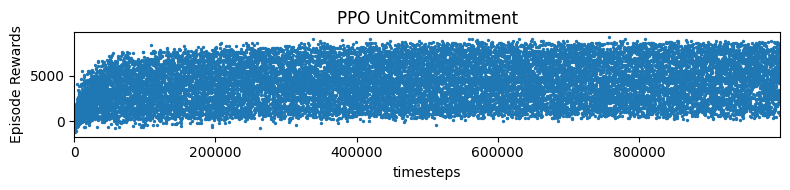

In [10]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e6, results_plotter.X_TIMESTEPS, "PPO UnitCommitment"
)

In [12]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

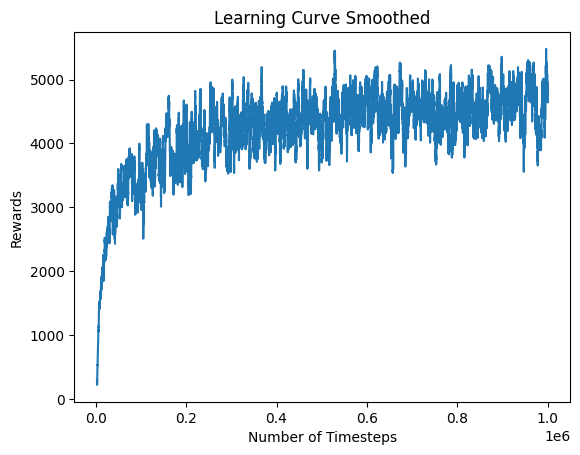

In [13]:
plot_results(log_dir)

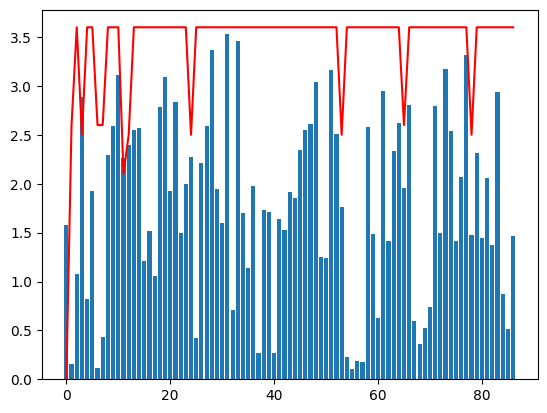

Test reward 8100.0


In [28]:
env = UnitCommitmentEnv(3, unit_characteristics)
observation, info = env.reset()
score = 0

statuses = [observation["unit_status"]]
Pgen = []
done = False
while not done:
    action, state_ = model.predict(observation)
    observation_, reward, done, truncated, info = env.step(action)

    observation = observation_
    statuses.append(observation["unit_status"])
    Pgen.append(env.P)
    score += reward


plt.figure()

x_ = np.arange(1, len(env.load_forecast)+1)
x = np.arange(len(env.load_forecast))
plt.bar(x, env.load_forecast)

# for i in range(len(x)-1):
#     plt.plot([x[i], x[i]], [Pgen[i], Pgen[i+1]], color='red') # vertical line
#     plt.plot([x[i+1], x[i+1]], [Pgen[i], Pgen[i+1]], color='red') # vertical line
#     plt.plot([x[i], x[i+1]], [Pgen[i], Pgen[i]], color='red')

plt.plot(x, Pgen, color='red')
plt.show()
print("Test reward", score)

